<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500) 
sns.set(rc={'figure.figsize': (8, 5)}) 
plt.style.use('seaborn-deep')



In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.base import clone
from sklearn.ensemble import StackingRegressor

#from hyperopt import tpe, hp, fmin, STATUS_OK,Trials

In [70]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 12:59:45) 
Numpy        : 1.20.1


In [71]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [72]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [73]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Определение min и max для числовых значений. На вход подаем имя столбца, на выходе [min,max]
def min_max(column):
    IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
    minimum = data[column].quantile(0.25) - 1.5*IQR
    maximum = data[column].quantile(0.75) + 1.5*IQR
    return [minimum, maximum]

#кросс-валидация модели estimator, с количеством разбиений n_splits
def cv(estimator,n_splits):
    skf = KFold(n_splits=n_splits, random_state=RANDOM_SEED)

    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
        y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]

         # For training, fit() is used
        estimator.fit(X_train, y_train)

        y_pred = estimator.predict(X_test)
        print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")
    
    return estimator

# Setup

In [74]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [75]:
!ls '../input'

ls: ../input: No such file or directory


In [76]:
#train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
#test = pd.read_csv(DIR_TEST+'test.csv')
#sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [77]:
train = pd.read_csv('all_auto_ru_09_09_2020.csv')
test = pd.read_csv('test.csv')


In [78]:
train.head(5)

bodyType brand   color fuelType  modelDate                   name  \
0            Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин     1982.0       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин     1988.0  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин     1988.0       1.8 MT (90 л.с.)   
4            Седан  AUDI  040001   бензин     1990.0      2.0 MT (101 л.с.)   

   numberOfDoors  productionDate          vehicleConfiguration  \
0            4.0            1991          SEDAN MECHANICAL 2.8   
1            4.0            1986          SEDAN MECHANICAL 1.8   
2            5.0            1989  WAGON_5_DOORS MECHANICAL 2.3   
3            4.0            1989          SEDAN MECHANICAL 1.8   
4            4.0            1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission engineDisplacement  enginePower  \
0          MECHANICAL                2.8        174.0   
1          MECHANICAL                1.8         90.0   
2          MECHANICAL                2.3        136.0   
3          MECHANICAL                1.8         90.0   
4          MECHANICAL                2.0        101.0   

                                         description  mileage Комплектация  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000  {'id': '0'}   
1  Машина в оригинале не гнилая все вопросы по те...   173424  {'id': '0'}   
2  ПТС Оригинал!\nПолный комплект ключей!\nПо рез...   230000  {'id': '0'}   
3                                                NaN   240000  {'id': '0'}   
4  Машина не гнилая, дыр нет, днище целое, даже в...   300000  {'id': '0'}   

     Привод  Руль  Состояние  Владельцы        ПТС  Таможня Владение  \
0    полный  LEFT        NaN        3.0   ORIGINAL     True      NaN   
1  передний  LEFT        NaN        3.0   ORIGINAL     True      NaN   
2    полный  LEFT        NaN        3.0   ORIGINAL     True      NaN   
3  передний  LEFT        NaN        3.0   ORIGINAL     True      NaN   
4  передний  LEFT        NaN        3.0  DUPLICATE     True      NaN   

      price            start_date  hidden model  
0  200000.0  2019-10-03T08:09:11Z     NaN   100  
1   60000.0  2020-09-06T06:49:40Z     NaN   100  
2   99000.0  2020-09-02T14:04:21Z     NaN   100  
3   65000.0  2020-08-23T17:40:09Z     NaN   100  
4  100000.0  2020-09-08T09:22:07Z     NaN   100

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [80]:
test.head(5)

bodyType  brand                                            car_url  \
0  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
1  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
2  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/superb/11...   
3  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   
4  лифтбек  SKODA  https://auto.ru/cars/used/sale/skoda/octavia/1...   

        color                                 complectation_dict  \
0       синий                                                NaN   
1      чёрный                                                NaN   
2       серый  {"id":"20026336","name":"Ambition","available_...   
3  коричневый  {"id":"20803582","name":"Ambition","available_...   
4       белый                                                NaN   

                                         description engineDisplacement  \
0  Все автомобили, представленные в продаже, прох...            1.2 LTR   
1  ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...            1.6 LTR   
2  Все автомобили, представленные в продаже, прох...            1.8 LTR   
3  КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...            1.6 LTR   
4  ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...            1.8 LTR   

  enginePower                                     equipment_dict fuelType  \
0     105 N12  {"engine-proof":true,"tinted-glass":true,"airb...   бензин   
1     110 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   
2     152 N12  {"cruise-control":true,"tinted-glass":true,"es...   бензин   
3     110 N12  {"cruise-control":true,"roller-blind-for-rear-...   бензин   
4     152 N12  {"cruise-control":true,"asr":true,"esp":true,"...   бензин   

                                               image  mileage  modelDate  \
0  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    74000       2013   
1  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    60563       2017   
2  https://avatars.mds.yandex.net/get-autoru-vos/...    88000       2013   
3  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    95000       2013   
4  https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...    58536       2008   

                                          model_info model_name  \
0  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
1  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
2  {"code":"SUPERB","name":"Superb","ru_name":"Су...     SUPERB   
3  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   
4  {"code":"OCTAVIA","name":"Octavia","ru_name":"...    OCTAVIA   

                     name  numberOfDoors  parsing_unixtime priceCurrency  \
0      1.2 AMT (105 л.с.)              5        1603226273           RUB   
1       1.6 MT (110 л.с.)              5        1603226277           RUB   
2  DSG 1.8 AMT (152 л.с.)              5        1603226280           RUB   
3       1.6 AT (110 л.с.)              5        1603226284           RUB   
4       1.8 AT (152 л.с.)              5        1603226288           RUB   

   productionDate     sell_id  \
0            2014  1100575026   
1            2017  1100549428   
2            2014  1100658222   
3            2014  1100937408   
4            2012  1101037972   

                                           super_gen     vehicleConfiguration  \
0  {"id":"10373605","displacement":1197,"engine_t...       LIFTBACK ROBOT 1.2   
1  {"id":"20913311","displacement":1598,"engine_t...  LIFTBACK MECHANICAL 1.6   
2  {"id":"20026323","nameplate":"DSG","displaceme...       LIFTBACK ROBOT 1.8   
3  {"id":"20105521","displacement":1598,"engine_t...   LIFTBACK AUTOMATIC 1.6   
4  {"id":"4561004","displacement":1798,"engine_ty...   LIFTBACK AUTOMATIC 1.8   

  vehicleTransmission    vendor    Владельцы Владение       ПТС    Привод  \
0    роботизированная  EUROPEAN  3 или более      NaN  Оригинал  передний   
1        механическая  EUROPEAN   1 владелец      NaN  Оригинал  передний   
2    роботиз

In [81]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [82]:
#Признаки bodyType, engineDisplacement, enginePower, modelDate, numberOfDoors, vehicleTransmission, Привод содержат только по одному пропуску. Удалим эти строки.
train.dropna(subset=['bodyType', 'enginePower', 'modelDate', 'numberOfDoors', 'vehicleTransmission', 'Привод'],inplace=True)

In [83]:
#price - целевая переменная. Строки, в которых она пропущенная, ценности не имеют. Удаляем их.
train.dropna(subset=['price'], inplace=True)

In [84]:
#Признак наименования модели в обучающем и валидационном датасэте имеет разные названия: model - в обучающем, model_name - в валидационном. 
#Сделаем все как в валидационнм.

train = train.rename(columns = {"model": "model_name"})

In [85]:
#В валидационном датасете признак parsing_unixtime указан в виде unix-метки, переведем значение YYYY-mm-dd
test['parsing_unixtime'] = pd.to_datetime(test['parsing_unixtime'],unit='s').dt.date.astype('str')

In [86]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и валидация в один датасет
train['sample'] = 1 # помечаем где у нас трейн
train.reset_index(inplace=True,drop=True)

test['sample'] = 0  # помечаем где у нас валидация

#Целевая переменная в обучающем датасете
y = train['price']

data = test.append(train.drop(columns=['price']), sort=False).reset_index(drop=True) # объединяем

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123653 entries, 0 to 123652
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              123653 non-null  object 
 1   brand                 123653 non-null  object 
 2   car_url               34686 non-null   object 
 3   color                 123653 non-null  object 
 4   complectation_dict    6418 non-null    object 
 5   description           120419 non-null  object 
 6   engineDisplacement    123653 non-null  object 
 7   enginePower           123653 non-null  object 
 8   equipment_dict        24690 non-null   object 
 9   fuelType              123653 non-null  object 
 10  image                 34686 non-null   object 
 11  mileage               123653 non-null  int64  
 12  modelDate             123653 non-null  float64
 13  model_info            34686 non-null   object 
 14  model_name            123653 non-null  object 
 15  

bodyType - тип кузова
brand - марка авто
car_url - ссылка на объявление
color - цвет
complectation_dict - комплектация
description - описание и реклама
engineDisplacement - объем двигателя
enginePower - мощность двигателя
equipment_dict - словарь установленного оборудования
fuelType - тип топлива
image - ссылка на картинку авто
mileage - пробег
modelDate - год модели
model_info - словарь описания модели
model_name - имя модели
name - краткое описание двигателя и мощности
numberOfDoors - количество дверей
parsing_unixtime - время сбора данных
priceCurrency - валюта, в которой указывалась цена
productionDate - дата выпуска авто
sell_id - идентифиактор объявления
super_gen - описание характеристик авто
vehicleConfiguration - краткое описание привода, кузова и объема двигателя
vehicleTransmission - тип коробки передач
vendor - регион производства авто
Владельцы - количество владельцев
Владение - срок владения
ПТС - оригинал/дубликат
Привод - привод)
Руль - расположение рулевого колеса
Состояние - состояние авто на момент подачи объявления
Таможня - авто растаможено в РФ или нет
Комплектация - словарь с описанием комплектации
start_date - дата подачи объявления
hidden - пустой признак в тренировочном датасете

In [88]:
data.drop(columns=['car_url','complectation_dict','description','equipment_dict','image','model_info','name','priceCurrency','sell_id','super_gen','vehicleConfiguration',\
                   'vendor','Комплектация','hidden','Владение','Состояние','Таможня','engineDisplacement','start_date'],inplace=True)

In [89]:
data.fillna("NOINFO",inplace=True)

In [90]:
#Переименуем признаки, содержащие кириллицу и выведем информацию по получившемуся датасету
data = data.rename(columns = {'Владельцы':'owners','ПТС':'pts','Привод':'wd','Руль':'wheel'})



In [91]:
#Бинарные категориальные переменные
bin_cols = ['wheel']

#Количественные переменные
num_cols = ['enginePower', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 'owners']

#Категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 'pts', 'wd']

In [92]:
#Значения различаются, заменим значения на цифровые LEFT, Левый = 0, RIGHT, Правый = 1 (Можно было использовать LabelEncoder, но раз все равно будем заменять часть, пройдем сразу по всему признаку)
data['wheel'].replace({"LEFT":0,"Левый":0,"RIGHT":1,"Правый":1},inplace=True)

In [93]:
#Посмотрим на значения в бинарных переменных
for col in bin_cols:
    print(col)
    print(data[col].value_counts())
    print("#"*20)

wheel
0    120472
1      3181
Name: wheel, dtype: int64
####################


In [94]:
#Посмотрим на значения в категориальных переменных
for col in cat_cols:
    print(col)
    print(data[col].unique())
    print(data[col].dtypes)
    print("#"*20)

bodyType
['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон' 'Седан' 'Универсал 5 дв.'
 'Хэтчбек 5 дв. Sportback' 'Хэтчбек 3 дв.' 'Хэтчбек 5 дв.' 'Кабриолет'
 'Купе' 'Лифтбек Sportback' 'Лифтбек' 'Седан Long' 'Внедорожник 5 дв.'
 'Кабриолет Roadster' 'Седан 2 дв.' 'Седан Gran Coupe' 'Компактвэн'
 'Компактвэн Gran Tourer' 'Лифтбек Gran Turismo' 'Хэтчбек 3 дв. Compact'
 'Лифтбек Gran Coupe' 'Купе-хардтоп' 'Родстер Roadster' 'Родстер'
 'Внедорожник 5 дв. ESV' 'Минивэн' 'Пикап Двойная кабина'
 'Внедорожник 3 дв.' 'Пикап Одинарная кабина' 'Тарга'
 'Пикап Двойная кабина Crew Cab' 'Пикап Двойная кабина Double'
 'Пикап Одинарная кабина Regular Cab' 'Внедорожник 5 дв. EXT' 'Седан SRT8'
 'Минивэн 

In [95]:
#получаем список "правильных" значений
corr_body_list = data[data['sample'] == 0]['bodyType'].sort_values(ascending=False).unique()

#value - проверяемое занчение Возвращает исправленное значение, если сопоставил его со списком, иначе оставляет как есть.
def replace_long_value(value):
    #проходим по списку "правильных" значений и ищем совпадение в проверяемой строке
    for corr_val in corr_body_list:
        if corr_val in value.lower(): return corr_val
    #если ничего не нашли, возвращаем оригинал
    return value.lower()

In [96]:
data['bodyType'] = data['bodyType'].apply(replace_long_value)

In [97]:
#в признаке color содержатся как русскоязычные наименования цветов, так и RGB. Приведем все к виду русскоязычных наименований.
#создадим словарь
color_dict = {'040001':"чёрный", 'EE1D19': 'красный', '0000CC':'синий', 'CACECB':'серебристый',\
              '007F00':'зелёный', 'FAFBFB':'белый', '97948F':'серый', '22A0F8':'голубой',\
              '660099':'пурпурный', '200204':'коричневый', 'C49648':'бежевый',\
              'DEA522':'золотистый','4A2197':'фиолетовый', 'FFD600':'жёлтый',\
              'FF8649':'оранжевый', 'FFC0CB':'розовый'}

data['color'].replace(color_dict,inplace=True)

In [98]:
#В признаке vehicleTransmission содержатся названия типов трансмиссий как на русском, так и на английском, приведем к русскому.
trans_dict = {'MECHANICAL': 'механическая','AUTOMATIC':'автоматическая', 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'}
data['vehicleTransmission'].replace(trans_dict,inplace=True)

#В признаке pts содержатся значения как на русском, так и на английском, приведем к русскому
pts_dict = {'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'}
data['pts'].replace(pts_dict,inplace=True)

In [99]:
for col in cat_cols:
    print("Признак {}: {} уникальных значений ".format(col,len(data[col].unique())))

Признак bodyType: 25 уникальных значений 
Признак brand: 36 уникальных значений 
Признак color: 16 уникальных значений 
Признак fuelType: 5 уникальных значений 
Признак model_name: 1104 уникальных значений 
Признак vehicleTransmission: 4 уникальных значений 
Признак pts: 3 уникальных значений 
Признак wd: 3 уникальных значений 


One Hot

In [100]:
for col in cat_cols:
    df_dummies = pd.get_dummies(data[col])
    data = pd.concat([data,df_dummies],axis=1)
    
#Удаляем из датасета категориальные признаки
data.drop(columns=cat_cols,inplace=True)

In [101]:
#Посмотрим на значения в числовых переменных
for col in num_cols:
    print(col)
    print(data[col].unique())
    print(data[col].dtypes)
    print("#"*20)

enginePower
['105 N12' '110 N12' '152 N12' '200 N12' '102 N12' '150 N12' '90 N12'
 '180 N12' '220 N12' '122 N12' '70 N12' '140 N12' '125 N12' '54 N12'
 '86 N12' '75 N12' '64 N12' '95 N12' '260 N12' '170 N12' '80 N12' '68 N12'
 '160 N12' '115 N12' '280 N12' '53 N12' '60 N12' '143 N12' '42 N12'
 '101 N12' '58 N12' '193 N12' '79 N12' '30 N12' '100 N12' '50 N12'
 '163 N12' '225 N12' '420 N12' '211 N12' '245 N12' '560 N12' '500 N12'
 '249 N12' '450 N12' '605 N12' '250 N12' '354 N12' '120 N12' '290 N12'
 '230 N12' '350 N12' '204 N12' '255 N12' '340 N12' '177 N12' '272 N12'
 '372 N12' '210 N12' '130 N12' '300 N12' '190 N12' '239 N12' '435 N12'
 '333 N12' '271 N12' '326 N12' '238 N12' '310 N12' '233 N12' '252 N12'
 '133 N12' '460 N12' '520 N12' '400 N12' '525 N12' '367 N12' '265 N12'
 '550 N12' '580 N12' '88 N12' '165 N12' '430 N12' '335 N12' '174 N12'
 '224 N12' '136 N12' '256 N12' '338 N12' '112 N12' '218 N12' '360 N12'
 '93 N12' '182 N12' '113 N12' '240 N12' '270 N12' '137 N12' '155 N12'
 '

In [102]:
#В признаке enginePower уберем значение N12, которое по всей видимости является заменой л.с.
data['enginePower'] = pd.to_numeric(data['enginePower'].replace(regex=[' N12'], value=''))

#В признаке owners заменим текстовые значения на числовые, NOINFO = 4
data['owners'].replace({'3 или более':3.0,'1\xa0владелец':1.0,'2\xa0владельца':2,'NOINFO':4},inplace=True)

In [103]:
data['age_year'] = 2022 - data.productionDate

num_cols.extend(['age_year'])

In [104]:
data['isnew'] = data.mileage.apply(lambda x: 1 if x == 0 else 0)

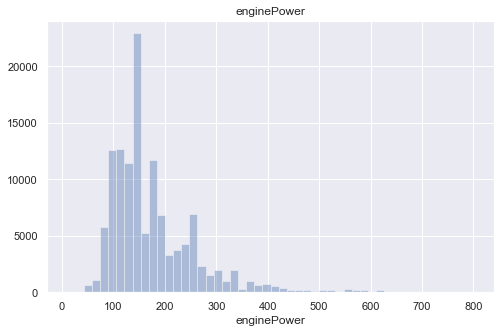

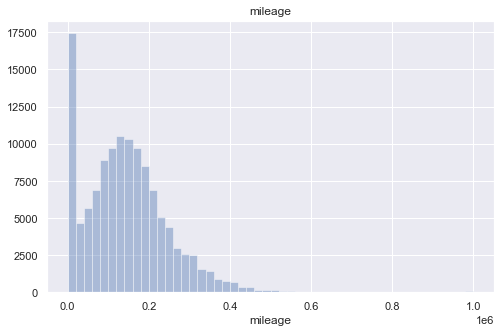

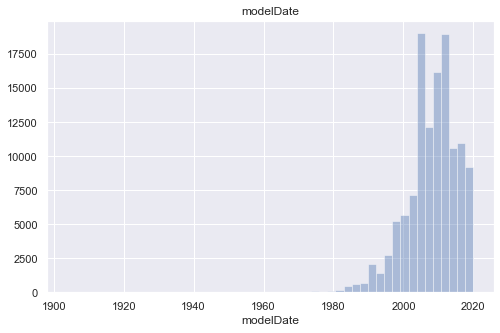

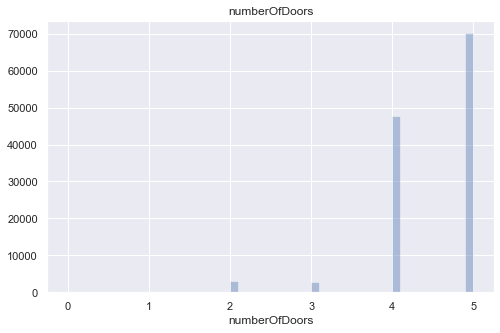

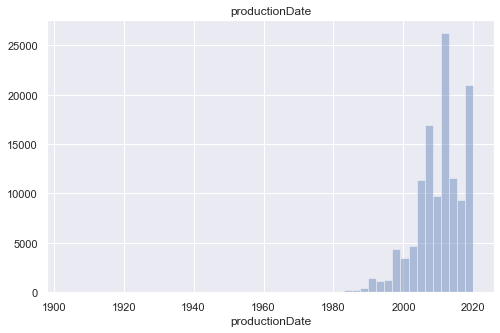

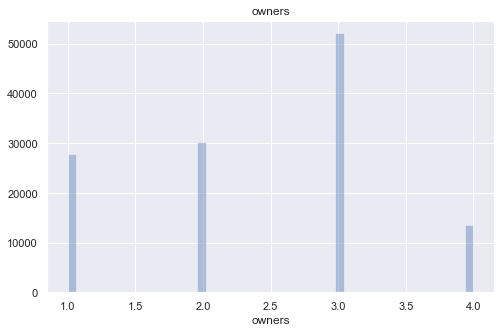

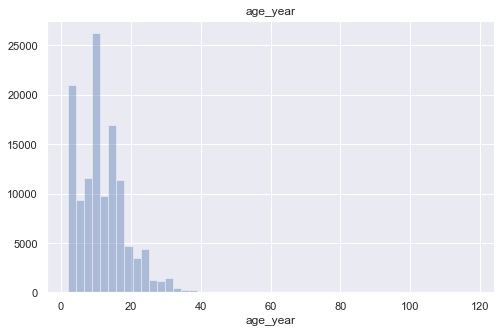

In [105]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

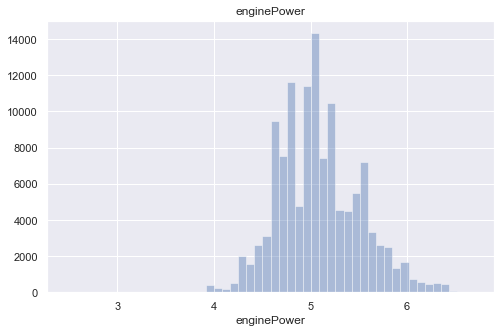

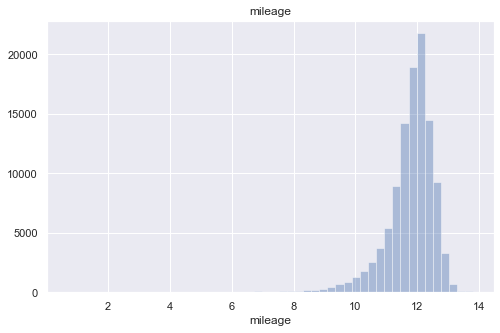

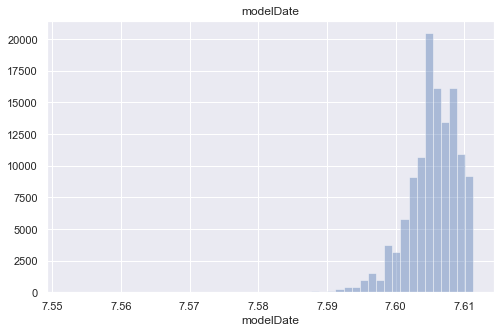

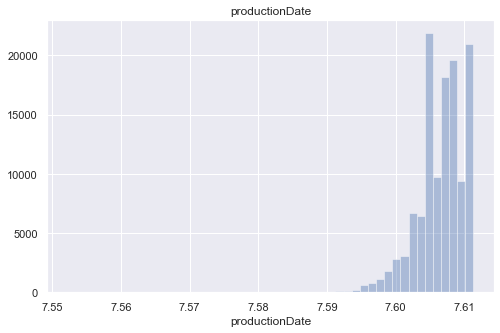

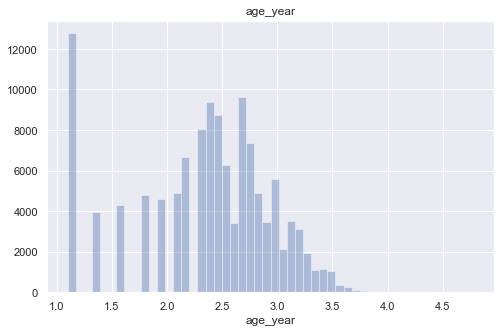

In [106]:
#Логирифмируем переменные и строим новые графики
for i in num_cols:
    if i in ['numberOfDoors','owners']: continue
        
    data[i] = data[i].apply(lambda x: np.log(abs(x)+1))
    plt.figure()
    sns.distplot(data[i][data[i] > 0], kde = False, rug=False)
    plt.title(i)
    plt.show()

<AxesSubplot:>

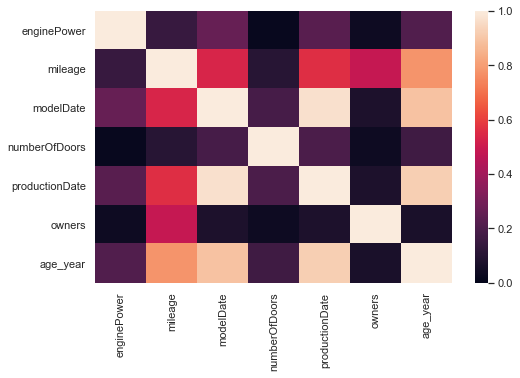

In [107]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

numberOfDoors      1.945743
owners             9.017836
enginePower       11.964146
productionDate    16.417788
modelDate         16.604874
age_year          34.522461
mileage           87.711088
dtype: float64

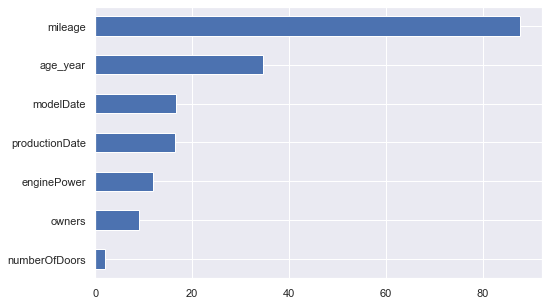

In [108]:
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
display(imp_num)

In [109]:
data.drop(columns=['numberOfDoors'],inplace=True)
num_cols.remove('numberOfDoors')

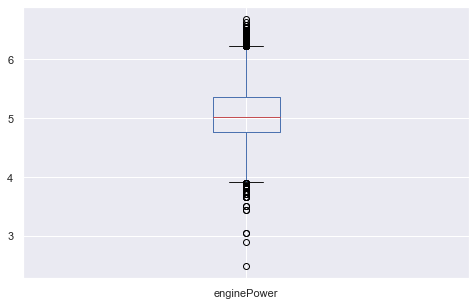

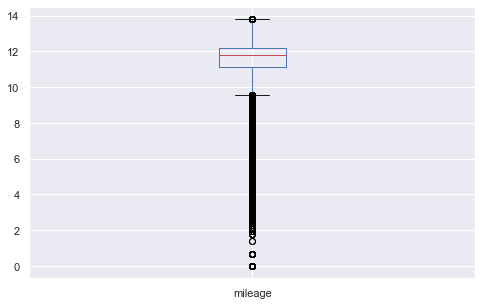

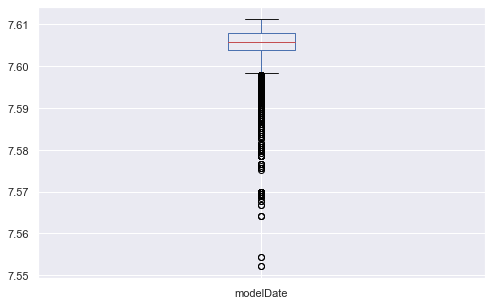

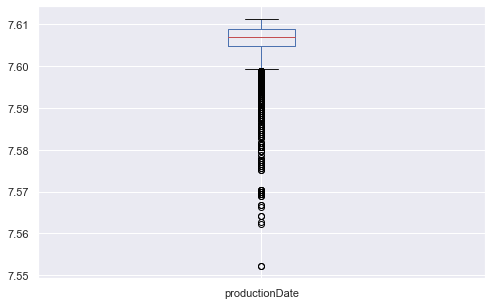

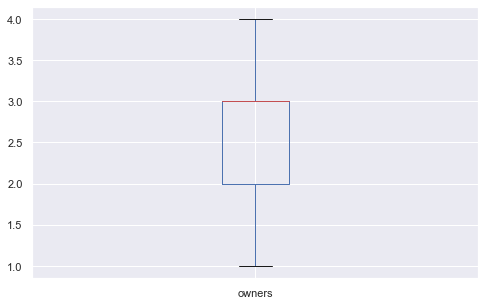

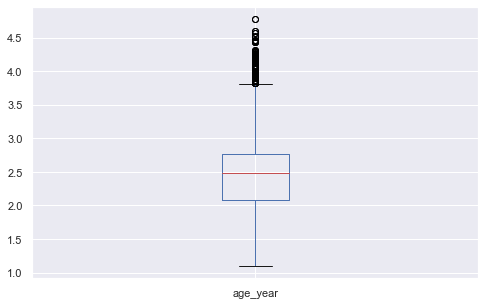

In [110]:
for i in num_cols:
    data[[i]].boxplot()
    plt.show()

In [111]:
for col in ['age_year','mileage','enginePower']:
    #Получаем минимальные и максимальные значения 1,5*IQR
    minimum,maximum = min_max(col)
    
    data[col] = data[col].apply(lambda x: minimum if x < minimum else maximum if x > maximum else x)

In [112]:
quantiles = []
for q in [0.2,0.4,0.6,0.8]:
    quantiles.append(data['modelDate'].quantile(q))
    
data['modelDate'] = data['modelDate'].apply(lambda x: 0 if x <= quantiles[0] else 1 if quantiles[0] < x <= quantiles[1] else 
                                                       2 if quantiles[1] < x <= quantiles[2] else 3 if quantiles[2] < x <= quantiles[3] else 4)

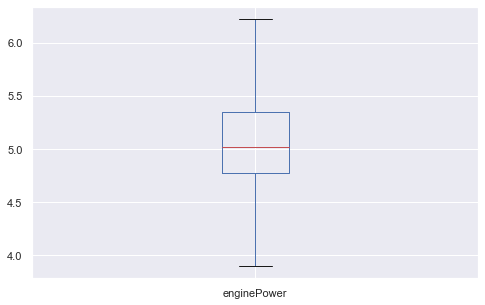

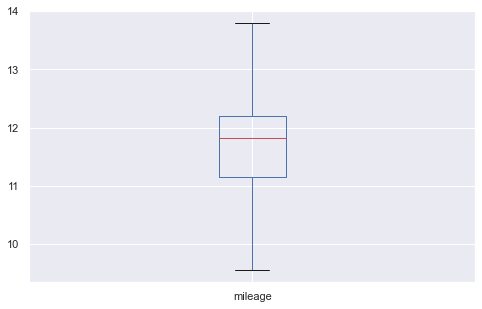

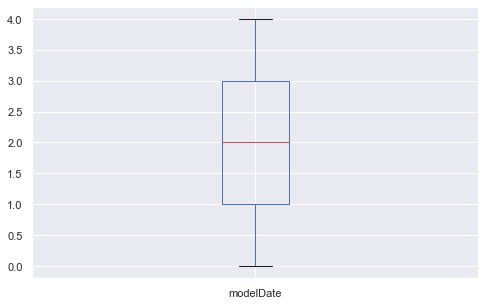

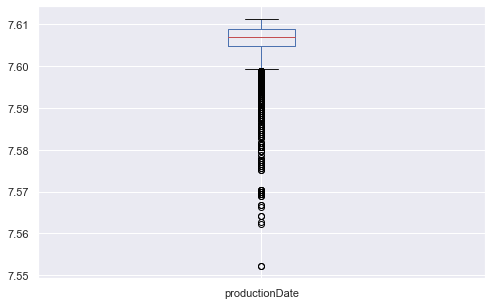

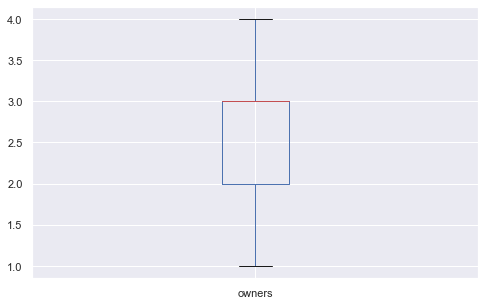

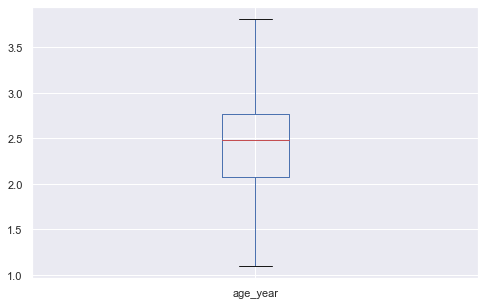

In [113]:
for i in num_cols:
    data[[i]].boxplot()
    plt.show()

In [114]:
exch_rate = {'2020-10-20': 1/85.3121,'2020-10-19': 1/85.2163, '2020-10-21': 1/85.5455, '2020-10-24': 1/84.4936, '2020-10-25':1/84.4936, \
            '2020-10-26': 1/84.4936, 'NOINFO': 1/82.8041}

data['exch_rate'] = data.parsing_unixtime.apply(lambda x: exch_rate[x])

#Удаляем признак 'parsing_unixtime'. Более он не требуется.
data.drop(columns=['parsing_unixtime'],inplace=True)

In [ ]:
y = y*data.query('sample == 1').copy().reset_index()['exch_rate']

In [115]:
y = np.log(y)

In [149]:
#Разделяем данные после EDA
X = data.query('sample == 1').drop(['sample'], axis=1)
X = pd.DataFrame(X.to_numpy())

#X_sub = data.query('sample == 0').drop(['sample','exch_rate'], axis=1)
#X_sub = pd.DataFrame(X_sub.to_numpy())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## МОДЕЛИ

In [150]:
model1 = LinearRegression()
model1.fit(X_train,y_train)

#Предсказываем значения
y_predict = model1.predict(X_test)

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, y_predict))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 11858616.43%


# RandomForestRegressor

In [151]:
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print(
    f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")

Точность модели по метрике MAPE: 13.05%


In [ ]:
# param = {'n_estimators': [400],
# 'max_features': ['auto'],
# 'max_depth': [None, 10, 20, 30, 40],
# 'min_samples_split': [1, 2, 5, 10, 20],
# 'min_samples_leaf': [1, 2, 4, 8, 12]}

In [ ]:
#rf = RandomForestRegressor(random_state=42)
#rcv = RandomizedSearchCV(estimator=rf, param_distributions=param, cv=3, n_jobs=-1,
                        #  scoring='neg_mean_absolute_percentage_error', n_iter=20)

#rcv.fit(X_train, y_train)
#predict = rcv.predict(X_test)
#predict = np.exp(predict)
#MAPE = mean_absolute_percentage_error(y_test, predict) * 100
#MAPE 

In [ ]:
# rcv.best_params_

In [ ]:
#rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1,
                           #min_samples_split=5, min_samples_leaf=1,
                           #max_features='auto', max_depth=20)
#rf.fit(X_train, y_train)
#predict = rf.predict(X_test)
#predict = np.exp(predict)
#MAPE = mean_absolute_percentage_error(y_test, predict) * 100
#MAPE

## XGBRegressor

In [152]:
xgb = XGBRegressor()
# 
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
# 
print(f"Точность модели XGBoost по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")

Точность модели XGBoost по метрике MAPE: 14.37%


In [ ]:
# param = {'n_estimators': [1000],
#          'colsample_bytree': [0.5, 0.75, 1.0],
#          'min_child_weight': [1, 3, 5],
#          'eta': [0.2],
#          'max_depth': [3, 6, 8],
#          'subsample': [0.5, 1.0]}

In [ ]:
# xgb = XGBRegressor(n_estimators=500, eval_metric='mape',random_state=42)
# rcv = RandomizedSearchCV(estimator=xgb, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=15)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [ ]:
# rcv.best_params_

In [ ]:
#xgb = XGBRegressor(objective='reg:squarederror', 
                      #random_state=42,
                      #n_estimators=2500,
                      #eta=0.04,
                      #max_depth=7,
                      #eval_metric='mape')

#xgb.fit(X_train, y_train)
#predict = xgb.predict(X_test)
#predict = np.exp(predict)
#MAPE = mean_absolute_percentage_error(y_test, predict) * 100
#MAPE

## ExtraTreesRegressor

In [153]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
etr.fit(X_train,y_train)
y_pred = etr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")


Точность модели по метрике MAPE: 13.14%


In [ ]:
# param = {'n_estimators': [200],
#          'max_features': ['auto'],
#          'max_depth': [None, 10, 20, 30, 40],
#          'min_samples_split': [1, 2, 5, 10, 20],
#          'min_samples_leaf': [1, 2, 4, 8, 12],
#          'bootstrap': [True, False]}

In [ ]:
# etr = ExtraTreesRegressor(random_state=42)
# rcv = RandomizedSearchCV(estimator=etr, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=20)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [ ]:
# rcv.best_params_

In [ ]:
#etr = ExtraTreesRegressor(n_estimators=800, random_state=42, n_jobs=-1,
                          #bootstrap=False, min_samples_split=10, min_samples_leaf=1,
                          #max_features='auto', max_depth=20)
#etr.fit(X_train, y_train)
#predict = etr.predict(X_test)
#predict = np.exp(predict)
#MAPE = mean_absolute_percentage_error(y_test, predict) * 100
#MAPE

## LGBMRegressor

In [ ]:
# param = {'n_estimators': [2500],
#          'learning_rate': [0.1],
#          'max_depth': [-1, 2, 4, 6],
#          'num_leaves': [20, 30 , 40, 50],
#          'min_child_samples': [None, 5, 10, 20],
#          'lambda_l2': [0.05, 0.1, 0.3, 0.8, 1.5]}

In [ ]:
# lgbm = LGBMRegressor(objective='regression', random_state=30)
# rcv = RandomizedSearchCV(estimator=lgbm, param_distributions=param, cv=3, n_jobs=-1,
#                          scoring='neg_mean_absolute_percentage_error', n_iter=15)

# rcv.fit(X_train, y_train)
# predict = rcv.predict(X_test)
# predict = np.exp(predict)
# MAPE = mean_absolute_percentage_error(y_test, predict) * 100
# MAPE

In [ ]:
# rcv.best_params_

In [ ]:
#lgbm = LGBMRegressor(objective='mape', 
                   #  random_state=30,
                   #  n_estimators=2500,
                   #  learning_rate=0.05,
                   #  lambda_l2=0.5)

#lgbm.fit(X_train, y_train,
      #   eval_set=(X_test, np.log(y_test)))

In [ ]:
#predict = lgbm.predict(X_test)
#predict = np.exp(predict)
#MAPE = mean_absolute_percentage_error(y_test, predict) * 100
#MAPE

In [154]:
lgbm = LGBMRegressor(random_state=RANDOM_SEED)
lgbm.fit(X_train,y_train)
y_pred = lgbm.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_pred)))*100:0.2f}%")

Точность модели по метрике MAPE: 14.76%


## CATboost

In [ ]:
#params = {'iterations': [5000],
         # 'depth': [None, 4, 5, 6, 7],
         # 'l2_leaf_reg': [0.1, 0.4, 1, 3, 5],
         # 'random_strength': [0, 0.3, 0.7, 1]}

In [ ]:
#cbr = CatBoostRegressor(random_seed=20, loss_function='MAPE',
                      #  eval_metric='MAPE', verbose=0)
#rs_cbr = cbr.randomized_search(params, X, y, cv=3, n_iter=20)
#rs_cbr['params']

In [155]:
cbr = CatBoostRegressor(iterations=5000,
                        random_seed=30,
                        loss_function='MAPE',
                        learning_rate=0.06,
                        depth=7,
                        random_strength=0.3,
                        l2_leaf_reg=0.15)

cbr.fit(X_train, y_train,
        eval_set=(X_test,y_test),
        verbose_eval=0,
        use_best_model=True)

In [156]:
y_predict = cbr.predict(X_test)

print(
    f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_predict)))*100:0.2f}%")

Точность модели по метрике MAPE: 11.98%


## StackingRegressor

In [228]:
#"Тяжелый stacking"
estimators = [('cbr', cbr), ('xgb', xgb), ('etr', etr), ('lgbm', lgbm)]
stacking = StackingRegressor(estimators=estimators,
                             final_estimator=Ridge())
stacking.fit(X_train, y_train)

0:	learn: 0.0588466	total: 43.2ms	remaining: 3m 36s
1:	learn: 0.0561407	total: 63.8ms	remaining: 2m 39s
2:	learn: 0.0536669	total: 77.9ms	remaining: 2m 9s
3:	learn: 0.0512633	total: 89.6ms	remaining: 1m 51s
4:	learn: 0.0490750	total: 104ms	remaining: 1m 43s
5:	learn: 0.0469903	total: 117ms	remaining: 1m 37s
6:	learn: 0.0450621	total: 127ms	remaining: 1m 30s
7:	learn: 0.0431575	total: 138ms	remaining: 1m 26s
8:	learn: 0.0413637	total: 149ms	remaining: 1m 22s
9:	learn: 0.0397740	total: 159ms	remaining: 1m 19s
10:	learn: 0.0382231	total: 170ms	remaining: 1m 16s
11:	learn: 0.0367117	total: 180ms	remaining: 1m 14s
12:	learn: 0.0353805	total: 192ms	remaining: 1m 13s
13:	learn: 0.0340841	total: 202ms	remaining: 1m 11s
14:	learn: 0.0328437	total: 212ms	remaining: 1m 10s
15:	learn: 0.0316450	total: 223ms	remaining: 1m 9s
16:	learn: 0.0305974	total: 234ms	remaining: 1m 8s
17:	learn: 0.0295916	total: 244ms	remaining: 1m 7s
18:	learn: 0.0286591	total: 256ms	remaining: 1m 7s
19:	learn: 0.0277864	to

169:	learn: 0.0124778	total: 1.64s	remaining: 46.6s
170:	learn: 0.0124665	total: 1.65s	remaining: 46.6s
171:	learn: 0.0124509	total: 1.66s	remaining: 46.6s
172:	learn: 0.0124400	total: 1.67s	remaining: 46.5s
173:	learn: 0.0124241	total: 1.68s	remaining: 46.5s
174:	learn: 0.0124161	total: 1.68s	remaining: 46.4s
175:	learn: 0.0124044	total: 1.69s	remaining: 46.4s
176:	learn: 0.0123950	total: 1.7s	remaining: 46.3s
177:	learn: 0.0123804	total: 1.71s	remaining: 46.3s
178:	learn: 0.0123728	total: 1.72s	remaining: 46.2s
179:	learn: 0.0123534	total: 1.73s	remaining: 46.2s
180:	learn: 0.0123368	total: 1.73s	remaining: 46.2s
181:	learn: 0.0123280	total: 1.74s	remaining: 46.1s
182:	learn: 0.0123182	total: 1.75s	remaining: 46.1s
183:	learn: 0.0123126	total: 1.76s	remaining: 46s
184:	learn: 0.0123038	total: 1.77s	remaining: 46s
185:	learn: 0.0122899	total: 1.77s	remaining: 45.9s
186:	learn: 0.0122807	total: 1.78s	remaining: 45.9s
187:	learn: 0.0122709	total: 1.79s	remaining: 45.9s
188:	learn: 0.012

330:	learn: 0.0111879	total: 3.04s	remaining: 42.8s
331:	learn: 0.0111816	total: 3.04s	remaining: 42.8s
332:	learn: 0.0111760	total: 3.05s	remaining: 42.8s
333:	learn: 0.0111708	total: 3.06s	remaining: 42.8s
334:	learn: 0.0111648	total: 3.07s	remaining: 42.8s
335:	learn: 0.0111603	total: 3.08s	remaining: 42.8s
336:	learn: 0.0111549	total: 3.09s	remaining: 42.8s
337:	learn: 0.0111474	total: 3.1s	remaining: 42.7s
338:	learn: 0.0111422	total: 3.11s	remaining: 42.7s
339:	learn: 0.0111372	total: 3.11s	remaining: 42.7s
340:	learn: 0.0111329	total: 3.12s	remaining: 42.7s
341:	learn: 0.0111274	total: 3.13s	remaining: 42.6s
342:	learn: 0.0111237	total: 3.14s	remaining: 42.6s
343:	learn: 0.0111188	total: 3.15s	remaining: 42.6s
344:	learn: 0.0111124	total: 3.15s	remaining: 42.6s
345:	learn: 0.0111066	total: 3.16s	remaining: 42.5s
346:	learn: 0.0111036	total: 3.17s	remaining: 42.5s
347:	learn: 0.0110990	total: 3.18s	remaining: 42.5s
348:	learn: 0.0110949	total: 3.19s	remaining: 42.5s
349:	learn: 0

498:	learn: 0.0105378	total: 4.44s	remaining: 40s
499:	learn: 0.0105354	total: 4.45s	remaining: 40s
500:	learn: 0.0105335	total: 4.46s	remaining: 40s
501:	learn: 0.0105303	total: 4.47s	remaining: 40s
502:	learn: 0.0105272	total: 4.47s	remaining: 40s
503:	learn: 0.0105237	total: 4.48s	remaining: 40s
504:	learn: 0.0105211	total: 4.49s	remaining: 40s
505:	learn: 0.0105185	total: 4.5s	remaining: 40s
506:	learn: 0.0105165	total: 4.51s	remaining: 40s
507:	learn: 0.0105133	total: 4.52s	remaining: 40s
508:	learn: 0.0105103	total: 4.53s	remaining: 39.9s
509:	learn: 0.0105075	total: 4.54s	remaining: 39.9s
510:	learn: 0.0105044	total: 4.54s	remaining: 39.9s
511:	learn: 0.0105017	total: 4.55s	remaining: 39.9s
512:	learn: 0.0104999	total: 4.56s	remaining: 39.9s
513:	learn: 0.0104986	total: 4.57s	remaining: 39.9s
514:	learn: 0.0104955	total: 4.58s	remaining: 39.8s
515:	learn: 0.0104926	total: 4.58s	remaining: 39.8s
516:	learn: 0.0104907	total: 4.59s	remaining: 39.8s
517:	learn: 0.0104873	total: 4.6s

671:	learn: 0.0101487	total: 5.83s	remaining: 37.6s
672:	learn: 0.0101467	total: 5.84s	remaining: 37.6s
673:	learn: 0.0101455	total: 5.85s	remaining: 37.6s
674:	learn: 0.0101419	total: 5.86s	remaining: 37.6s
675:	learn: 0.0101397	total: 5.87s	remaining: 37.5s
676:	learn: 0.0101378	total: 5.88s	remaining: 37.5s
677:	learn: 0.0101350	total: 5.89s	remaining: 37.5s
678:	learn: 0.0101332	total: 5.89s	remaining: 37.5s
679:	learn: 0.0101286	total: 5.9s	remaining: 37.5s
680:	learn: 0.0101274	total: 5.91s	remaining: 37.5s
681:	learn: 0.0101260	total: 5.92s	remaining: 37.5s
682:	learn: 0.0101251	total: 5.92s	remaining: 37.5s
683:	learn: 0.0101227	total: 5.93s	remaining: 37.4s
684:	learn: 0.0101217	total: 5.94s	remaining: 37.4s
685:	learn: 0.0101205	total: 5.95s	remaining: 37.4s
686:	learn: 0.0101189	total: 5.96s	remaining: 37.4s
687:	learn: 0.0101172	total: 5.96s	remaining: 37.4s
688:	learn: 0.0101140	total: 5.97s	remaining: 37.4s
689:	learn: 0.0101126	total: 5.98s	remaining: 37.4s
690:	learn: 0

840:	learn: 0.0098754	total: 7.23s	remaining: 35.8s
841:	learn: 0.0098747	total: 7.24s	remaining: 35.7s
842:	learn: 0.0098739	total: 7.25s	remaining: 35.7s
843:	learn: 0.0098728	total: 7.25s	remaining: 35.7s
844:	learn: 0.0098713	total: 7.26s	remaining: 35.7s
845:	learn: 0.0098705	total: 7.27s	remaining: 35.7s
846:	learn: 0.0098697	total: 7.28s	remaining: 35.7s
847:	learn: 0.0098682	total: 7.29s	remaining: 35.7s
848:	learn: 0.0098676	total: 7.3s	remaining: 35.7s
849:	learn: 0.0098667	total: 7.3s	remaining: 35.7s
850:	learn: 0.0098655	total: 7.31s	remaining: 35.7s
851:	learn: 0.0098648	total: 7.32s	remaining: 35.6s
852:	learn: 0.0098632	total: 7.33s	remaining: 35.6s
853:	learn: 0.0098618	total: 7.34s	remaining: 35.6s
854:	learn: 0.0098601	total: 7.34s	remaining: 35.6s
855:	learn: 0.0098586	total: 7.35s	remaining: 35.6s
856:	learn: 0.0098559	total: 7.36s	remaining: 35.6s
857:	learn: 0.0098551	total: 7.37s	remaining: 35.6s
858:	learn: 0.0098542	total: 7.38s	remaining: 35.6s
859:	learn: 0.

1011:	learn: 0.0096599	total: 8.63s	remaining: 34s
1012:	learn: 0.0096591	total: 8.64s	remaining: 34s
1013:	learn: 0.0096581	total: 8.64s	remaining: 34s
1014:	learn: 0.0096564	total: 8.65s	remaining: 34s
1015:	learn: 0.0096557	total: 8.66s	remaining: 34s
1016:	learn: 0.0096549	total: 8.67s	remaining: 34s
1017:	learn: 0.0096534	total: 8.68s	remaining: 34s
1018:	learn: 0.0096522	total: 8.69s	remaining: 33.9s
1019:	learn: 0.0096510	total: 8.7s	remaining: 33.9s
1020:	learn: 0.0096501	total: 8.7s	remaining: 33.9s
1021:	learn: 0.0096491	total: 8.71s	remaining: 33.9s
1022:	learn: 0.0096480	total: 8.72s	remaining: 33.9s
1023:	learn: 0.0096469	total: 8.73s	remaining: 33.9s
1024:	learn: 0.0096462	total: 8.73s	remaining: 33.9s
1025:	learn: 0.0096451	total: 8.74s	remaining: 33.9s
1026:	learn: 0.0096435	total: 8.75s	remaining: 33.9s
1027:	learn: 0.0096426	total: 8.76s	remaining: 33.8s
1028:	learn: 0.0096413	total: 8.77s	remaining: 33.8s
1029:	learn: 0.0096397	total: 8.78s	remaining: 33.8s
1030:	lea

1177:	learn: 0.0094922	total: 10s	remaining: 32.5s
1178:	learn: 0.0094914	total: 10s	remaining: 32.5s
1179:	learn: 0.0094908	total: 10s	remaining: 32.5s
1180:	learn: 0.0094900	total: 10s	remaining: 32.5s
1181:	learn: 0.0094891	total: 10.1s	remaining: 32.5s
1182:	learn: 0.0094888	total: 10.1s	remaining: 32.5s
1183:	learn: 0.0094882	total: 10.1s	remaining: 32.5s
1184:	learn: 0.0094878	total: 10.1s	remaining: 32.4s
1185:	learn: 0.0094874	total: 10.1s	remaining: 32.4s
1186:	learn: 0.0094860	total: 10.1s	remaining: 32.4s
1187:	learn: 0.0094852	total: 10.1s	remaining: 32.4s
1188:	learn: 0.0094844	total: 10.1s	remaining: 32.4s
1189:	learn: 0.0094835	total: 10.1s	remaining: 32.4s
1190:	learn: 0.0094824	total: 10.1s	remaining: 32.4s
1191:	learn: 0.0094820	total: 10.1s	remaining: 32.4s
1192:	learn: 0.0094812	total: 10.1s	remaining: 32.4s
1193:	learn: 0.0094807	total: 10.2s	remaining: 32.4s
1194:	learn: 0.0094797	total: 10.2s	remaining: 32.4s
1195:	learn: 0.0094793	total: 10.2s	remaining: 32.3s
1

1343:	learn: 0.0093628	total: 11.4s	remaining: 31.1s
1344:	learn: 0.0093624	total: 11.4s	remaining: 31.1s
1345:	learn: 0.0093619	total: 11.4s	remaining: 31s
1346:	learn: 0.0093611	total: 11.4s	remaining: 31s
1347:	learn: 0.0093597	total: 11.5s	remaining: 31s
1348:	learn: 0.0093593	total: 11.5s	remaining: 31s
1349:	learn: 0.0093580	total: 11.5s	remaining: 31s
1350:	learn: 0.0093574	total: 11.5s	remaining: 31s
1351:	learn: 0.0093565	total: 11.5s	remaining: 31s
1352:	learn: 0.0093557	total: 11.5s	remaining: 31s
1353:	learn: 0.0093550	total: 11.5s	remaining: 31s
1354:	learn: 0.0093542	total: 11.5s	remaining: 31s
1355:	learn: 0.0093539	total: 11.5s	remaining: 31s
1356:	learn: 0.0093534	total: 11.5s	remaining: 31s
1357:	learn: 0.0093526	total: 11.5s	remaining: 30.9s
1358:	learn: 0.0093522	total: 11.5s	remaining: 30.9s
1359:	learn: 0.0093516	total: 11.6s	remaining: 30.9s
1360:	learn: 0.0093507	total: 11.6s	remaining: 30.9s
1361:	learn: 0.0093503	total: 11.6s	remaining: 30.9s
1362:	learn: 0.00

1511:	learn: 0.0092444	total: 12.8s	remaining: 29.6s
1512:	learn: 0.0092441	total: 12.8s	remaining: 29.6s
1513:	learn: 0.0092438	total: 12.8s	remaining: 29.6s
1514:	learn: 0.0092434	total: 12.8s	remaining: 29.5s
1515:	learn: 0.0092422	total: 12.9s	remaining: 29.5s
1516:	learn: 0.0092416	total: 12.9s	remaining: 29.5s
1517:	learn: 0.0092410	total: 12.9s	remaining: 29.5s
1518:	learn: 0.0092406	total: 12.9s	remaining: 29.5s
1519:	learn: 0.0092399	total: 12.9s	remaining: 29.5s
1520:	learn: 0.0092393	total: 12.9s	remaining: 29.5s
1521:	learn: 0.0092388	total: 12.9s	remaining: 29.5s
1522:	learn: 0.0092385	total: 12.9s	remaining: 29.5s
1523:	learn: 0.0092379	total: 12.9s	remaining: 29.5s
1524:	learn: 0.0092374	total: 12.9s	remaining: 29.5s
1525:	learn: 0.0092366	total: 12.9s	remaining: 29.4s
1526:	learn: 0.0092363	total: 12.9s	remaining: 29.4s
1527:	learn: 0.0092359	total: 13s	remaining: 29.4s
1528:	learn: 0.0092353	total: 13s	remaining: 29.4s
1529:	learn: 0.0092348	total: 13s	remaining: 29.4s

1680:	learn: 0.0091354	total: 14.2s	remaining: 28.1s
1681:	learn: 0.0091350	total: 14.2s	remaining: 28s
1682:	learn: 0.0091344	total: 14.2s	remaining: 28s
1683:	learn: 0.0091328	total: 14.2s	remaining: 28s
1684:	learn: 0.0091322	total: 14.2s	remaining: 28s
1685:	learn: 0.0091317	total: 14.3s	remaining: 28s
1686:	learn: 0.0091310	total: 14.3s	remaining: 28s
1687:	learn: 0.0091305	total: 14.3s	remaining: 28s
1688:	learn: 0.0091298	total: 14.3s	remaining: 28s
1689:	learn: 0.0091295	total: 14.3s	remaining: 28s
1690:	learn: 0.0091291	total: 14.3s	remaining: 28s
1691:	learn: 0.0091285	total: 14.3s	remaining: 28s
1692:	learn: 0.0091279	total: 14.3s	remaining: 28s
1693:	learn: 0.0091267	total: 14.3s	remaining: 28s
1694:	learn: 0.0091261	total: 14.3s	remaining: 27.9s
1695:	learn: 0.0091258	total: 14.3s	remaining: 27.9s
1696:	learn: 0.0091255	total: 14.3s	remaining: 27.9s
1697:	learn: 0.0091247	total: 14.4s	remaining: 27.9s
1698:	learn: 0.0091240	total: 14.4s	remaining: 27.9s
1699:	learn: 0.0091

1841:	learn: 0.0090337	total: 15.6s	remaining: 26.8s
1842:	learn: 0.0090331	total: 15.6s	remaining: 26.8s
1843:	learn: 0.0090325	total: 15.6s	remaining: 26.8s
1844:	learn: 0.0090319	total: 15.6s	remaining: 26.8s
1845:	learn: 0.0090314	total: 15.7s	remaining: 26.8s
1846:	learn: 0.0090309	total: 15.7s	remaining: 26.7s
1847:	learn: 0.0090304	total: 15.7s	remaining: 26.7s
1848:	learn: 0.0090301	total: 15.7s	remaining: 26.7s
1849:	learn: 0.0090295	total: 15.7s	remaining: 26.7s
1850:	learn: 0.0090287	total: 15.7s	remaining: 26.7s
1851:	learn: 0.0090282	total: 15.7s	remaining: 26.7s
1852:	learn: 0.0090277	total: 15.7s	remaining: 26.7s
1853:	learn: 0.0090271	total: 15.7s	remaining: 26.7s
1854:	learn: 0.0090263	total: 15.7s	remaining: 26.7s
1855:	learn: 0.0090253	total: 15.7s	remaining: 26.7s
1856:	learn: 0.0090247	total: 15.8s	remaining: 26.7s
1857:	learn: 0.0090240	total: 15.8s	remaining: 26.7s
1858:	learn: 0.0090233	total: 15.8s	remaining: 26.6s
1859:	learn: 0.0090230	total: 15.8s	remaining:

2001:	learn: 0.0089394	total: 17s	remaining: 25.5s
2002:	learn: 0.0089391	total: 17s	remaining: 25.5s
2003:	learn: 0.0089387	total: 17s	remaining: 25.5s
2004:	learn: 0.0089385	total: 17s	remaining: 25.5s
2005:	learn: 0.0089378	total: 17.1s	remaining: 25.5s
2006:	learn: 0.0089371	total: 17.1s	remaining: 25.4s
2007:	learn: 0.0089367	total: 17.1s	remaining: 25.4s
2008:	learn: 0.0089363	total: 17.1s	remaining: 25.4s
2009:	learn: 0.0089357	total: 17.1s	remaining: 25.4s
2010:	learn: 0.0089353	total: 17.1s	remaining: 25.4s
2011:	learn: 0.0089350	total: 17.1s	remaining: 25.4s
2012:	learn: 0.0089342	total: 17.1s	remaining: 25.4s
2013:	learn: 0.0089338	total: 17.1s	remaining: 25.4s
2014:	learn: 0.0089332	total: 17.1s	remaining: 25.4s
2015:	learn: 0.0089326	total: 17.1s	remaining: 25.4s
2016:	learn: 0.0089322	total: 17.1s	remaining: 25.4s
2017:	learn: 0.0089317	total: 17.2s	remaining: 25.3s
2018:	learn: 0.0089315	total: 17.2s	remaining: 25.3s
2019:	learn: 0.0089310	total: 17.2s	remaining: 25.3s
2

2169:	learn: 0.0088584	total: 18.4s	remaining: 24s
2170:	learn: 0.0088581	total: 18.4s	remaining: 24s
2171:	learn: 0.0088577	total: 18.4s	remaining: 24s
2172:	learn: 0.0088572	total: 18.4s	remaining: 24s
2173:	learn: 0.0088565	total: 18.4s	remaining: 24s
2174:	learn: 0.0088557	total: 18.4s	remaining: 24s
2175:	learn: 0.0088549	total: 18.5s	remaining: 23.9s
2176:	learn: 0.0088543	total: 18.5s	remaining: 23.9s
2177:	learn: 0.0088542	total: 18.5s	remaining: 23.9s
2178:	learn: 0.0088538	total: 18.5s	remaining: 23.9s
2179:	learn: 0.0088534	total: 18.5s	remaining: 23.9s
2180:	learn: 0.0088531	total: 18.5s	remaining: 23.9s
2181:	learn: 0.0088527	total: 18.5s	remaining: 23.9s
2182:	learn: 0.0088522	total: 18.5s	remaining: 23.9s
2183:	learn: 0.0088516	total: 18.5s	remaining: 23.9s
2184:	learn: 0.0088514	total: 18.5s	remaining: 23.9s
2185:	learn: 0.0088512	total: 18.5s	remaining: 23.9s
2186:	learn: 0.0088503	total: 18.5s	remaining: 23.8s
2187:	learn: 0.0088494	total: 18.5s	remaining: 23.8s
2188:

2341:	learn: 0.0087845	total: 19.8s	remaining: 22.5s
2342:	learn: 0.0087841	total: 19.8s	remaining: 22.5s
2343:	learn: 0.0087840	total: 19.8s	remaining: 22.5s
2344:	learn: 0.0087837	total: 19.8s	remaining: 22.5s
2345:	learn: 0.0087835	total: 19.8s	remaining: 22.5s
2346:	learn: 0.0087828	total: 19.9s	remaining: 22.4s
2347:	learn: 0.0087826	total: 19.9s	remaining: 22.4s
2348:	learn: 0.0087818	total: 19.9s	remaining: 22.4s
2349:	learn: 0.0087816	total: 19.9s	remaining: 22.4s
2350:	learn: 0.0087813	total: 19.9s	remaining: 22.4s
2351:	learn: 0.0087809	total: 19.9s	remaining: 22.4s
2352:	learn: 0.0087806	total: 19.9s	remaining: 22.4s
2353:	learn: 0.0087801	total: 19.9s	remaining: 22.4s
2354:	learn: 0.0087798	total: 19.9s	remaining: 22.4s
2355:	learn: 0.0087795	total: 19.9s	remaining: 22.4s
2356:	learn: 0.0087793	total: 19.9s	remaining: 22.4s
2357:	learn: 0.0087788	total: 19.9s	remaining: 22.3s
2358:	learn: 0.0087786	total: 20s	remaining: 22.3s
2359:	learn: 0.0087782	total: 20s	remaining: 22.

2511:	learn: 0.0087121	total: 21.2s	remaining: 21s
2512:	learn: 0.0087116	total: 21.2s	remaining: 21s
2513:	learn: 0.0087104	total: 21.2s	remaining: 21s
2514:	learn: 0.0087101	total: 21.2s	remaining: 21s
2515:	learn: 0.0087099	total: 21.2s	remaining: 21s
2516:	learn: 0.0087095	total: 21.3s	remaining: 21s
2517:	learn: 0.0087092	total: 21.3s	remaining: 21s
2518:	learn: 0.0087090	total: 21.3s	remaining: 20.9s
2519:	learn: 0.0087087	total: 21.3s	remaining: 20.9s
2520:	learn: 0.0087084	total: 21.3s	remaining: 20.9s
2521:	learn: 0.0087078	total: 21.3s	remaining: 20.9s
2522:	learn: 0.0087075	total: 21.3s	remaining: 20.9s
2523:	learn: 0.0087073	total: 21.3s	remaining: 20.9s
2524:	learn: 0.0087069	total: 21.3s	remaining: 20.9s
2525:	learn: 0.0087066	total: 21.3s	remaining: 20.9s
2526:	learn: 0.0087059	total: 21.3s	remaining: 20.9s
2527:	learn: 0.0087055	total: 21.3s	remaining: 20.9s
2528:	learn: 0.0087052	total: 21.3s	remaining: 20.9s
2529:	learn: 0.0087049	total: 21.4s	remaining: 20.8s
2530:	l

2680:	learn: 0.0086479	total: 22.6s	remaining: 19.5s
2681:	learn: 0.0086477	total: 22.6s	remaining: 19.5s
2682:	learn: 0.0086475	total: 22.6s	remaining: 19.5s
2683:	learn: 0.0086472	total: 22.6s	remaining: 19.5s
2684:	learn: 0.0086469	total: 22.6s	remaining: 19.5s
2685:	learn: 0.0086464	total: 22.6s	remaining: 19.5s
2686:	learn: 0.0086460	total: 22.6s	remaining: 19.5s
2687:	learn: 0.0086455	total: 22.7s	remaining: 19.5s
2688:	learn: 0.0086453	total: 22.7s	remaining: 19.5s
2689:	learn: 0.0086452	total: 22.7s	remaining: 19.5s
2690:	learn: 0.0086448	total: 22.7s	remaining: 19.5s
2691:	learn: 0.0086445	total: 22.7s	remaining: 19.4s
2692:	learn: 0.0086438	total: 22.7s	remaining: 19.4s
2693:	learn: 0.0086435	total: 22.7s	remaining: 19.4s
2694:	learn: 0.0086429	total: 22.7s	remaining: 19.4s
2695:	learn: 0.0086421	total: 22.7s	remaining: 19.4s
2696:	learn: 0.0086419	total: 22.7s	remaining: 19.4s
2697:	learn: 0.0086416	total: 22.7s	remaining: 19.4s
2698:	learn: 0.0086410	total: 22.7s	remaining:

2850:	learn: 0.0085851	total: 24s	remaining: 18.1s
2851:	learn: 0.0085849	total: 24s	remaining: 18.1s
2852:	learn: 0.0085845	total: 24s	remaining: 18.1s
2853:	learn: 0.0085843	total: 24s	remaining: 18.1s
2854:	learn: 0.0085834	total: 24s	remaining: 18s
2855:	learn: 0.0085826	total: 24s	remaining: 18s
2856:	learn: 0.0085824	total: 24s	remaining: 18s
2857:	learn: 0.0085822	total: 24s	remaining: 18s
2858:	learn: 0.0085818	total: 24.1s	remaining: 18s
2859:	learn: 0.0085815	total: 24.1s	remaining: 18s
2860:	learn: 0.0085811	total: 24.1s	remaining: 18s
2861:	learn: 0.0085809	total: 24.1s	remaining: 18s
2862:	learn: 0.0085806	total: 24.1s	remaining: 18s
2863:	learn: 0.0085804	total: 24.1s	remaining: 18s
2864:	learn: 0.0085797	total: 24.1s	remaining: 18s
2865:	learn: 0.0085796	total: 24.1s	remaining: 17.9s
2866:	learn: 0.0085786	total: 24.1s	remaining: 17.9s
2867:	learn: 0.0085784	total: 24.1s	remaining: 17.9s
2868:	learn: 0.0085776	total: 24.1s	remaining: 17.9s
2869:	learn: 0.0085772	total: 2

3008:	learn: 0.0085324	total: 25.4s	remaining: 16.8s
3009:	learn: 0.0085321	total: 25.4s	remaining: 16.8s
3010:	learn: 0.0085317	total: 25.4s	remaining: 16.8s
3011:	learn: 0.0085310	total: 25.4s	remaining: 16.8s
3012:	learn: 0.0085307	total: 25.4s	remaining: 16.7s
3013:	learn: 0.0085304	total: 25.4s	remaining: 16.7s
3014:	learn: 0.0085302	total: 25.4s	remaining: 16.7s
3015:	learn: 0.0085298	total: 25.4s	remaining: 16.7s
3016:	learn: 0.0085294	total: 25.4s	remaining: 16.7s
3017:	learn: 0.0085291	total: 25.4s	remaining: 16.7s
3018:	learn: 0.0085287	total: 25.4s	remaining: 16.7s
3019:	learn: 0.0085286	total: 25.4s	remaining: 16.7s
3020:	learn: 0.0085282	total: 25.5s	remaining: 16.7s
3021:	learn: 0.0085281	total: 25.5s	remaining: 16.7s
3022:	learn: 0.0085279	total: 25.5s	remaining: 16.7s
3023:	learn: 0.0085277	total: 25.5s	remaining: 16.6s
3024:	learn: 0.0085270	total: 25.5s	remaining: 16.6s
3025:	learn: 0.0085267	total: 25.5s	remaining: 16.6s
3026:	learn: 0.0085265	total: 25.5s	remaining:

3176:	learn: 0.0084749	total: 26.8s	remaining: 15.3s
3177:	learn: 0.0084745	total: 26.8s	remaining: 15.3s
3178:	learn: 0.0084743	total: 26.8s	remaining: 15.3s
3179:	learn: 0.0084742	total: 26.8s	remaining: 15.3s
3180:	learn: 0.0084739	total: 26.8s	remaining: 15.3s
3181:	learn: 0.0084737	total: 26.8s	remaining: 15.3s
3182:	learn: 0.0084734	total: 26.8s	remaining: 15.3s
3183:	learn: 0.0084734	total: 26.8s	remaining: 15.3s
3184:	learn: 0.0084730	total: 26.8s	remaining: 15.3s
3185:	learn: 0.0084721	total: 26.8s	remaining: 15.3s
3186:	learn: 0.0084719	total: 26.8s	remaining: 15.3s
3187:	learn: 0.0084718	total: 26.8s	remaining: 15.3s
3188:	learn: 0.0084708	total: 26.9s	remaining: 15.3s
3189:	learn: 0.0084706	total: 26.9s	remaining: 15.2s
3190:	learn: 0.0084704	total: 26.9s	remaining: 15.2s
3191:	learn: 0.0084702	total: 26.9s	remaining: 15.2s
3192:	learn: 0.0084698	total: 26.9s	remaining: 15.2s
3193:	learn: 0.0084696	total: 26.9s	remaining: 15.2s
3194:	learn: 0.0084690	total: 26.9s	remaining:

3345:	learn: 0.0084276	total: 28.1s	remaining: 13.9s
3346:	learn: 0.0084274	total: 28.2s	remaining: 13.9s
3347:	learn: 0.0084270	total: 28.2s	remaining: 13.9s
3348:	learn: 0.0084269	total: 28.2s	remaining: 13.9s
3349:	learn: 0.0084269	total: 28.2s	remaining: 13.9s
3350:	learn: 0.0084268	total: 28.2s	remaining: 13.9s
3351:	learn: 0.0084266	total: 28.2s	remaining: 13.9s
3352:	learn: 0.0084264	total: 28.2s	remaining: 13.9s
3353:	learn: 0.0084262	total: 28.2s	remaining: 13.8s
3354:	learn: 0.0084259	total: 28.2s	remaining: 13.8s
3355:	learn: 0.0084257	total: 28.2s	remaining: 13.8s
3356:	learn: 0.0084254	total: 28.2s	remaining: 13.8s
3357:	learn: 0.0084251	total: 28.2s	remaining: 13.8s
3358:	learn: 0.0084249	total: 28.3s	remaining: 13.8s
3359:	learn: 0.0084248	total: 28.3s	remaining: 13.8s
3360:	learn: 0.0084246	total: 28.3s	remaining: 13.8s
3361:	learn: 0.0084245	total: 28.3s	remaining: 13.8s
3362:	learn: 0.0084242	total: 28.3s	remaining: 13.8s
3363:	learn: 0.0084240	total: 28.3s	remaining:

3513:	learn: 0.0083875	total: 29.5s	remaining: 12.5s
3514:	learn: 0.0083871	total: 29.5s	remaining: 12.5s
3515:	learn: 0.0083867	total: 29.6s	remaining: 12.5s
3516:	learn: 0.0083866	total: 29.6s	remaining: 12.5s
3517:	learn: 0.0083864	total: 29.6s	remaining: 12.5s
3518:	learn: 0.0083863	total: 29.6s	remaining: 12.4s
3519:	learn: 0.0083859	total: 29.6s	remaining: 12.4s
3520:	learn: 0.0083858	total: 29.6s	remaining: 12.4s
3521:	learn: 0.0083854	total: 29.6s	remaining: 12.4s
3522:	learn: 0.0083852	total: 29.6s	remaining: 12.4s
3523:	learn: 0.0083849	total: 29.6s	remaining: 12.4s
3524:	learn: 0.0083848	total: 29.6s	remaining: 12.4s
3525:	learn: 0.0083846	total: 29.6s	remaining: 12.4s
3526:	learn: 0.0083843	total: 29.6s	remaining: 12.4s
3527:	learn: 0.0083841	total: 29.7s	remaining: 12.4s
3528:	learn: 0.0083839	total: 29.7s	remaining: 12.4s
3529:	learn: 0.0083838	total: 29.7s	remaining: 12.4s
3530:	learn: 0.0083835	total: 29.7s	remaining: 12.3s
3531:	learn: 0.0083830	total: 29.7s	remaining:

3681:	learn: 0.0083428	total: 30.9s	remaining: 11.1s
3682:	learn: 0.0083426	total: 30.9s	remaining: 11.1s
3683:	learn: 0.0083423	total: 30.9s	remaining: 11.1s
3684:	learn: 0.0083417	total: 31s	remaining: 11s
3685:	learn: 0.0083413	total: 31s	remaining: 11s
3686:	learn: 0.0083411	total: 31s	remaining: 11s
3687:	learn: 0.0083408	total: 31s	remaining: 11s
3688:	learn: 0.0083407	total: 31s	remaining: 11s
3689:	learn: 0.0083406	total: 31s	remaining: 11s
3690:	learn: 0.0083399	total: 31s	remaining: 11s
3691:	learn: 0.0083395	total: 31s	remaining: 11s
3692:	learn: 0.0083394	total: 31s	remaining: 11s
3693:	learn: 0.0083392	total: 31s	remaining: 11s
3694:	learn: 0.0083391	total: 31s	remaining: 11s
3695:	learn: 0.0083388	total: 31s	remaining: 11s
3696:	learn: 0.0083386	total: 31.1s	remaining: 10.9s
3697:	learn: 0.0083385	total: 31.1s	remaining: 10.9s
3698:	learn: 0.0083381	total: 31.1s	remaining: 10.9s
3699:	learn: 0.0083380	total: 31.1s	remaining: 10.9s
3700:	learn: 0.0083379	total: 31.1s	remai

3842:	learn: 0.0083029	total: 32.3s	remaining: 9.73s
3843:	learn: 0.0083023	total: 32.3s	remaining: 9.72s
3844:	learn: 0.0083021	total: 32.3s	remaining: 9.71s
3845:	learn: 0.0083020	total: 32.4s	remaining: 9.71s
3846:	learn: 0.0083017	total: 32.4s	remaining: 9.7s
3847:	learn: 0.0083013	total: 32.4s	remaining: 9.69s
3848:	learn: 0.0083011	total: 32.4s	remaining: 9.68s
3849:	learn: 0.0083009	total: 32.4s	remaining: 9.67s
3850:	learn: 0.0083006	total: 32.4s	remaining: 9.66s
3851:	learn: 0.0083004	total: 32.4s	remaining: 9.65s
3852:	learn: 0.0083000	total: 32.4s	remaining: 9.65s
3853:	learn: 0.0082997	total: 32.4s	remaining: 9.64s
3854:	learn: 0.0082994	total: 32.4s	remaining: 9.63s
3855:	learn: 0.0082993	total: 32.4s	remaining: 9.62s
3856:	learn: 0.0082992	total: 32.4s	remaining: 9.61s
3857:	learn: 0.0082988	total: 32.4s	remaining: 9.6s
3858:	learn: 0.0082985	total: 32.5s	remaining: 9.6s
3859:	learn: 0.0082984	total: 32.5s	remaining: 9.59s
3860:	learn: 0.0082977	total: 32.5s	remaining: 9.

4010:	learn: 0.0082583	total: 33.7s	remaining: 8.31s
4011:	learn: 0.0082581	total: 33.7s	remaining: 8.3s
4012:	learn: 0.0082581	total: 33.7s	remaining: 8.29s
4013:	learn: 0.0082579	total: 33.7s	remaining: 8.29s
4014:	learn: 0.0082578	total: 33.7s	remaining: 8.28s
4015:	learn: 0.0082576	total: 33.7s	remaining: 8.27s
4016:	learn: 0.0082569	total: 33.8s	remaining: 8.26s
4017:	learn: 0.0082566	total: 33.8s	remaining: 8.25s
4018:	learn: 0.0082565	total: 33.8s	remaining: 8.24s
4019:	learn: 0.0082561	total: 33.8s	remaining: 8.23s
4020:	learn: 0.0082559	total: 33.8s	remaining: 8.23s
4021:	learn: 0.0082555	total: 33.8s	remaining: 8.22s
4022:	learn: 0.0082554	total: 33.8s	remaining: 8.21s
4023:	learn: 0.0082549	total: 33.8s	remaining: 8.2s
4024:	learn: 0.0082547	total: 33.8s	remaining: 8.19s
4025:	learn: 0.0082546	total: 33.8s	remaining: 8.18s
4026:	learn: 0.0082544	total: 33.8s	remaining: 8.18s
4027:	learn: 0.0082542	total: 33.8s	remaining: 8.17s
4028:	learn: 0.0082540	total: 33.9s	remaining: 8

4177:	learn: 0.0082190	total: 35.1s	remaining: 6.9s
4178:	learn: 0.0082189	total: 35.1s	remaining: 6.89s
4179:	learn: 0.0082185	total: 35.1s	remaining: 6.89s
4180:	learn: 0.0082184	total: 35.1s	remaining: 6.88s
4181:	learn: 0.0082182	total: 35.1s	remaining: 6.87s
4182:	learn: 0.0082175	total: 35.1s	remaining: 6.86s
4183:	learn: 0.0082172	total: 35.1s	remaining: 6.85s
4184:	learn: 0.0082163	total: 35.1s	remaining: 6.84s
4185:	learn: 0.0082159	total: 35.2s	remaining: 6.84s
4186:	learn: 0.0082155	total: 35.2s	remaining: 6.83s
4187:	learn: 0.0082154	total: 35.2s	remaining: 6.82s
4188:	learn: 0.0082153	total: 35.2s	remaining: 6.81s
4189:	learn: 0.0082153	total: 35.2s	remaining: 6.8s
4190:	learn: 0.0082152	total: 35.2s	remaining: 6.79s
4191:	learn: 0.0082146	total: 35.2s	remaining: 6.79s
4192:	learn: 0.0082145	total: 35.2s	remaining: 6.78s
4193:	learn: 0.0082142	total: 35.2s	remaining: 6.77s
4194:	learn: 0.0082140	total: 35.2s	remaining: 6.76s
4195:	learn: 0.0082139	total: 35.2s	remaining: 6

4339:	learn: 0.0081837	total: 36.5s	remaining: 5.54s
4340:	learn: 0.0081835	total: 36.5s	remaining: 5.54s
4341:	learn: 0.0081829	total: 36.5s	remaining: 5.53s
4342:	learn: 0.0081827	total: 36.5s	remaining: 5.52s
4343:	learn: 0.0081824	total: 36.5s	remaining: 5.51s
4344:	learn: 0.0081821	total: 36.5s	remaining: 5.5s
4345:	learn: 0.0081820	total: 36.5s	remaining: 5.5s
4346:	learn: 0.0081817	total: 36.5s	remaining: 5.49s
4347:	learn: 0.0081816	total: 36.5s	remaining: 5.48s
4348:	learn: 0.0081813	total: 36.5s	remaining: 5.47s
4349:	learn: 0.0081811	total: 36.6s	remaining: 5.46s
4350:	learn: 0.0081806	total: 36.6s	remaining: 5.45s
4351:	learn: 0.0081803	total: 36.6s	remaining: 5.45s
4352:	learn: 0.0081801	total: 36.6s	remaining: 5.44s
4353:	learn: 0.0081794	total: 36.6s	remaining: 5.43s
4354:	learn: 0.0081790	total: 36.6s	remaining: 5.42s
4355:	learn: 0.0081789	total: 36.6s	remaining: 5.41s
4356:	learn: 0.0081786	total: 36.6s	remaining: 5.4s
4357:	learn: 0.0081784	total: 36.6s	remaining: 5.

4507:	learn: 0.0081413	total: 37.9s	remaining: 4.13s
4508:	learn: 0.0081411	total: 37.9s	remaining: 4.12s
4509:	learn: 0.0081408	total: 37.9s	remaining: 4.12s
4510:	learn: 0.0081406	total: 37.9s	remaining: 4.11s
4511:	learn: 0.0081404	total: 37.9s	remaining: 4.1s
4512:	learn: 0.0081401	total: 37.9s	remaining: 4.09s
4513:	learn: 0.0081400	total: 37.9s	remaining: 4.08s
4514:	learn: 0.0081398	total: 37.9s	remaining: 4.07s
4515:	learn: 0.0081397	total: 37.9s	remaining: 4.07s
4516:	learn: 0.0081396	total: 37.9s	remaining: 4.06s
4517:	learn: 0.0081395	total: 38s	remaining: 4.05s
4518:	learn: 0.0081391	total: 38s	remaining: 4.04s
4519:	learn: 0.0081389	total: 38s	remaining: 4.03s
4520:	learn: 0.0081387	total: 38s	remaining: 4.02s
4521:	learn: 0.0081383	total: 38s	remaining: 4.01s
4522:	learn: 0.0081380	total: 38s	remaining: 4.01s
4523:	learn: 0.0081377	total: 38s	remaining: 4s
4524:	learn: 0.0081376	total: 38s	remaining: 3.99s
4525:	learn: 0.0081373	total: 38s	remaining: 3.98s
4526:	learn: 0.

4673:	learn: 0.0081021	total: 39.3s	remaining: 2.74s
4674:	learn: 0.0081021	total: 39.3s	remaining: 2.73s
4675:	learn: 0.0081019	total: 39.3s	remaining: 2.72s
4676:	learn: 0.0081015	total: 39.3s	remaining: 2.71s
4677:	learn: 0.0081013	total: 39.3s	remaining: 2.7s
4678:	learn: 0.0081008	total: 39.3s	remaining: 2.7s
4679:	learn: 0.0081007	total: 39.3s	remaining: 2.69s
4680:	learn: 0.0081004	total: 39.3s	remaining: 2.68s
4681:	learn: 0.0081004	total: 39.3s	remaining: 2.67s
4682:	learn: 0.0081001	total: 39.3s	remaining: 2.66s
4683:	learn: 0.0081001	total: 39.3s	remaining: 2.65s
4684:	learn: 0.0080999	total: 39.4s	remaining: 2.65s
4685:	learn: 0.0080997	total: 39.4s	remaining: 2.64s
4686:	learn: 0.0080996	total: 39.4s	remaining: 2.63s
4687:	learn: 0.0080992	total: 39.4s	remaining: 2.62s
4688:	learn: 0.0080990	total: 39.4s	remaining: 2.61s
4689:	learn: 0.0080989	total: 39.4s	remaining: 2.6s
4690:	learn: 0.0080986	total: 39.4s	remaining: 2.6s
4691:	learn: 0.0080983	total: 39.4s	remaining: 2.5

4850:	learn: 0.0080651	total: 40.9s	remaining: 1.25s
4851:	learn: 0.0080649	total: 40.9s	remaining: 1.25s
4852:	learn: 0.0080648	total: 40.9s	remaining: 1.24s
4853:	learn: 0.0080647	total: 40.9s	remaining: 1.23s
4854:	learn: 0.0080641	total: 40.9s	remaining: 1.22s
4855:	learn: 0.0080639	total: 40.9s	remaining: 1.21s
4856:	learn: 0.0080637	total: 40.9s	remaining: 1.2s
4857:	learn: 0.0080637	total: 40.9s	remaining: 1.2s
4858:	learn: 0.0080636	total: 40.9s	remaining: 1.19s
4859:	learn: 0.0080635	total: 40.9s	remaining: 1.18s
4860:	learn: 0.0080631	total: 41s	remaining: 1.17s
4861:	learn: 0.0080630	total: 41s	remaining: 1.16s
4862:	learn: 0.0080630	total: 41s	remaining: 1.15s
4863:	learn: 0.0080628	total: 41s	remaining: 1.15s
4864:	learn: 0.0080627	total: 41s	remaining: 1.14s
4865:	learn: 0.0080626	total: 41s	remaining: 1.13s
4866:	learn: 0.0080624	total: 41s	remaining: 1.12s
4867:	learn: 0.0080623	total: 41s	remaining: 1.11s
4868:	learn: 0.0080620	total: 41s	remaining: 1.1s
4869:	learn: 0

25:	learn: 0.0236077	total: 213ms	remaining: 40.7s
26:	learn: 0.0230441	total: 222ms	remaining: 40.9s
27:	learn: 0.0225744	total: 230ms	remaining: 40.9s
28:	learn: 0.0220572	total: 238ms	remaining: 40.9s
29:	learn: 0.0216221	total: 246ms	remaining: 40.8s
30:	learn: 0.0212067	total: 255ms	remaining: 40.8s
31:	learn: 0.0207826	total: 264ms	remaining: 41s
32:	learn: 0.0203786	total: 273ms	remaining: 41s
33:	learn: 0.0200244	total: 281ms	remaining: 41.1s
34:	learn: 0.0196900	total: 291ms	remaining: 41.2s
35:	learn: 0.0193931	total: 298ms	remaining: 41.1s
36:	learn: 0.0190886	total: 306ms	remaining: 41s
37:	learn: 0.0188442	total: 313ms	remaining: 40.9s
38:	learn: 0.0185820	total: 321ms	remaining: 40.8s
39:	learn: 0.0183120	total: 331ms	remaining: 41.1s
40:	learn: 0.0180851	total: 341ms	remaining: 41.2s
41:	learn: 0.0178513	total: 348ms	remaining: 41.1s
42:	learn: 0.0176375	total: 356ms	remaining: 41s
43:	learn: 0.0174357	total: 363ms	remaining: 40.9s
44:	learn: 0.0172367	total: 371ms	remai

209:	learn: 0.0120647	total: 1.61s	remaining: 36.8s
210:	learn: 0.0120511	total: 1.62s	remaining: 36.8s
211:	learn: 0.0120444	total: 1.63s	remaining: 36.7s
212:	learn: 0.0120356	total: 1.63s	remaining: 36.7s
213:	learn: 0.0120233	total: 1.64s	remaining: 36.7s
214:	learn: 0.0120135	total: 1.65s	remaining: 36.7s
215:	learn: 0.0120005	total: 1.66s	remaining: 36.7s
216:	learn: 0.0119912	total: 1.66s	remaining: 36.7s
217:	learn: 0.0119838	total: 1.67s	remaining: 36.6s
218:	learn: 0.0119755	total: 1.68s	remaining: 36.6s
219:	learn: 0.0119685	total: 1.68s	remaining: 36.6s
220:	learn: 0.0119602	total: 1.69s	remaining: 36.5s
221:	learn: 0.0119487	total: 1.7s	remaining: 36.5s
222:	learn: 0.0119349	total: 1.7s	remaining: 36.5s
223:	learn: 0.0119290	total: 1.71s	remaining: 36.5s
224:	learn: 0.0119203	total: 1.72s	remaining: 36.4s
225:	learn: 0.0119144	total: 1.72s	remaining: 36.4s
226:	learn: 0.0119062	total: 1.73s	remaining: 36.4s
227:	learn: 0.0119004	total: 1.74s	remaining: 36.4s
228:	learn: 0.

369:	learn: 0.0109969	total: 2.8s	remaining: 35s
370:	learn: 0.0109925	total: 2.81s	remaining: 35s
371:	learn: 0.0109860	total: 2.81s	remaining: 35s
372:	learn: 0.0109830	total: 2.82s	remaining: 35s
373:	learn: 0.0109794	total: 2.83s	remaining: 35s
374:	learn: 0.0109755	total: 2.84s	remaining: 35s
375:	learn: 0.0109699	total: 2.84s	remaining: 35s
376:	learn: 0.0109645	total: 2.85s	remaining: 35s
377:	learn: 0.0109603	total: 2.86s	remaining: 34.9s
378:	learn: 0.0109558	total: 2.86s	remaining: 34.9s
379:	learn: 0.0109523	total: 2.87s	remaining: 34.9s
380:	learn: 0.0109480	total: 2.88s	remaining: 34.9s
381:	learn: 0.0109448	total: 2.88s	remaining: 34.9s
382:	learn: 0.0109413	total: 2.89s	remaining: 34.9s
383:	learn: 0.0109378	total: 2.9s	remaining: 34.9s
384:	learn: 0.0109304	total: 2.91s	remaining: 34.8s
385:	learn: 0.0109276	total: 2.91s	remaining: 34.8s
386:	learn: 0.0109233	total: 2.92s	remaining: 34.8s
387:	learn: 0.0109195	total: 2.93s	remaining: 34.8s
388:	learn: 0.0109147	total: 2

529:	learn: 0.0104147	total: 3.99s	remaining: 33.7s
530:	learn: 0.0104107	total: 4s	remaining: 33.7s
531:	learn: 0.0104078	total: 4.01s	remaining: 33.7s
532:	learn: 0.0104042	total: 4.02s	remaining: 33.7s
533:	learn: 0.0103982	total: 4.03s	remaining: 33.7s
534:	learn: 0.0103930	total: 4.04s	remaining: 33.7s
535:	learn: 0.0103903	total: 4.04s	remaining: 33.7s
536:	learn: 0.0103875	total: 4.05s	remaining: 33.7s
537:	learn: 0.0103834	total: 4.06s	remaining: 33.7s
538:	learn: 0.0103818	total: 4.07s	remaining: 33.7s
539:	learn: 0.0103790	total: 4.08s	remaining: 33.7s
540:	learn: 0.0103762	total: 4.08s	remaining: 33.7s
541:	learn: 0.0103724	total: 4.09s	remaining: 33.6s
542:	learn: 0.0103682	total: 4.1s	remaining: 33.6s
543:	learn: 0.0103655	total: 4.1s	remaining: 33.6s
544:	learn: 0.0103625	total: 4.11s	remaining: 33.6s
545:	learn: 0.0103612	total: 4.12s	remaining: 33.6s
546:	learn: 0.0103588	total: 4.12s	remaining: 33.6s
547:	learn: 0.0103556	total: 4.13s	remaining: 33.6s
548:	learn: 0.010

691:	learn: 0.0100543	total: 5.19s	remaining: 32.3s
692:	learn: 0.0100530	total: 5.2s	remaining: 32.3s
693:	learn: 0.0100514	total: 5.21s	remaining: 32.3s
694:	learn: 0.0100500	total: 5.21s	remaining: 32.3s
695:	learn: 0.0100477	total: 5.22s	remaining: 32.3s
696:	learn: 0.0100460	total: 5.23s	remaining: 32.3s
697:	learn: 0.0100441	total: 5.24s	remaining: 32.3s
698:	learn: 0.0100425	total: 5.24s	remaining: 32.3s
699:	learn: 0.0100404	total: 5.25s	remaining: 32.3s
700:	learn: 0.0100392	total: 5.26s	remaining: 32.2s
701:	learn: 0.0100365	total: 5.26s	remaining: 32.2s
702:	learn: 0.0100351	total: 5.27s	remaining: 32.2s
703:	learn: 0.0100335	total: 5.28s	remaining: 32.2s
704:	learn: 0.0100324	total: 5.29s	remaining: 32.2s
705:	learn: 0.0100311	total: 5.29s	remaining: 32.2s
706:	learn: 0.0100292	total: 5.3s	remaining: 32.2s
707:	learn: 0.0100266	total: 5.3s	remaining: 32.2s
708:	learn: 0.0100257	total: 5.31s	remaining: 32.2s
709:	learn: 0.0100243	total: 5.32s	remaining: 32.1s
710:	learn: 0.0

850:	learn: 0.0098017	total: 6.38s	remaining: 31.1s
851:	learn: 0.0097998	total: 6.39s	remaining: 31.1s
852:	learn: 0.0097985	total: 6.4s	remaining: 31.1s
853:	learn: 0.0097973	total: 6.41s	remaining: 31.1s
854:	learn: 0.0097961	total: 6.43s	remaining: 31.2s
855:	learn: 0.0097952	total: 6.43s	remaining: 31.2s
856:	learn: 0.0097946	total: 6.44s	remaining: 31.2s
857:	learn: 0.0097938	total: 6.45s	remaining: 31.2s
858:	learn: 0.0097924	total: 6.46s	remaining: 31.1s
859:	learn: 0.0097913	total: 6.47s	remaining: 31.1s
860:	learn: 0.0097902	total: 6.47s	remaining: 31.1s
861:	learn: 0.0097894	total: 6.48s	remaining: 31.1s
862:	learn: 0.0097883	total: 6.49s	remaining: 31.1s
863:	learn: 0.0097866	total: 6.5s	remaining: 31.1s
864:	learn: 0.0097840	total: 6.5s	remaining: 31.1s
865:	learn: 0.0097831	total: 6.51s	remaining: 31.1s
866:	learn: 0.0097814	total: 6.52s	remaining: 31.1s
867:	learn: 0.0097800	total: 6.52s	remaining: 31.1s
868:	learn: 0.0097781	total: 6.53s	remaining: 31s
869:	learn: 0.009

1015:	learn: 0.0096009	total: 7.58s	remaining: 29.7s
1016:	learn: 0.0095992	total: 7.59s	remaining: 29.7s
1017:	learn: 0.0095985	total: 7.6s	remaining: 29.7s
1018:	learn: 0.0095974	total: 7.61s	remaining: 29.7s
1019:	learn: 0.0095962	total: 7.62s	remaining: 29.7s
1020:	learn: 0.0095950	total: 7.62s	remaining: 29.7s
1021:	learn: 0.0095941	total: 7.63s	remaining: 29.7s
1022:	learn: 0.0095922	total: 7.64s	remaining: 29.7s
1023:	learn: 0.0095913	total: 7.64s	remaining: 29.7s
1024:	learn: 0.0095902	total: 7.65s	remaining: 29.7s
1025:	learn: 0.0095886	total: 7.66s	remaining: 29.7s
1026:	learn: 0.0095877	total: 7.67s	remaining: 29.7s
1027:	learn: 0.0095870	total: 7.67s	remaining: 29.6s
1028:	learn: 0.0095864	total: 7.68s	remaining: 29.6s
1029:	learn: 0.0095857	total: 7.69s	remaining: 29.6s
1030:	learn: 0.0095845	total: 7.7s	remaining: 29.6s
1031:	learn: 0.0095824	total: 7.7s	remaining: 29.6s
1032:	learn: 0.0095818	total: 7.71s	remaining: 29.6s
1033:	learn: 0.0095804	total: 7.72s	remaining: 29

1173:	learn: 0.0094406	total: 8.75s	remaining: 28.5s
1174:	learn: 0.0094400	total: 8.76s	remaining: 28.5s
1175:	learn: 0.0094393	total: 8.77s	remaining: 28.5s
1176:	learn: 0.0094387	total: 8.78s	remaining: 28.5s
1177:	learn: 0.0094372	total: 8.79s	remaining: 28.5s
1178:	learn: 0.0094364	total: 8.8s	remaining: 28.5s
1179:	learn: 0.0094352	total: 8.81s	remaining: 28.5s
1180:	learn: 0.0094344	total: 8.82s	remaining: 28.5s
1181:	learn: 0.0094337	total: 8.82s	remaining: 28.5s
1182:	learn: 0.0094323	total: 8.84s	remaining: 28.5s
1183:	learn: 0.0094311	total: 8.84s	remaining: 28.5s
1184:	learn: 0.0094299	total: 8.85s	remaining: 28.5s
1185:	learn: 0.0094294	total: 8.86s	remaining: 28.5s
1186:	learn: 0.0094286	total: 8.87s	remaining: 28.5s
1187:	learn: 0.0094279	total: 8.87s	remaining: 28.5s
1188:	learn: 0.0094269	total: 8.88s	remaining: 28.5s
1189:	learn: 0.0094262	total: 8.89s	remaining: 28.5s
1190:	learn: 0.0094248	total: 8.9s	remaining: 28.5s
1191:	learn: 0.0094241	total: 8.91s	remaining: 2

1344:	learn: 0.0092897	total: 10.1s	remaining: 27.6s
1345:	learn: 0.0092889	total: 10.2s	remaining: 27.6s
1346:	learn: 0.0092879	total: 10.2s	remaining: 27.6s
1347:	learn: 0.0092872	total: 10.2s	remaining: 27.5s
1348:	learn: 0.0092864	total: 10.2s	remaining: 27.5s
1349:	learn: 0.0092849	total: 10.2s	remaining: 27.5s
1350:	learn: 0.0092843	total: 10.2s	remaining: 27.5s
1351:	learn: 0.0092831	total: 10.2s	remaining: 27.5s
1352:	learn: 0.0092827	total: 10.2s	remaining: 27.5s
1353:	learn: 0.0092823	total: 10.2s	remaining: 27.5s
1354:	learn: 0.0092818	total: 10.2s	remaining: 27.5s
1355:	learn: 0.0092809	total: 10.2s	remaining: 27.5s
1356:	learn: 0.0092802	total: 10.2s	remaining: 27.5s
1357:	learn: 0.0092796	total: 10.2s	remaining: 27.5s
1358:	learn: 0.0092788	total: 10.2s	remaining: 27.5s
1359:	learn: 0.0092779	total: 10.3s	remaining: 27.4s
1360:	learn: 0.0092773	total: 10.3s	remaining: 27.4s
1361:	learn: 0.0092765	total: 10.3s	remaining: 27.4s
1362:	learn: 0.0092758	total: 10.3s	remaining:

1520:	learn: 0.0091565	total: 11.5s	remaining: 26.4s
1521:	learn: 0.0091553	total: 11.5s	remaining: 26.4s
1522:	learn: 0.0091549	total: 11.5s	remaining: 26.4s
1523:	learn: 0.0091538	total: 11.6s	remaining: 26.4s
1524:	learn: 0.0091531	total: 11.6s	remaining: 26.3s
1525:	learn: 0.0091523	total: 11.6s	remaining: 26.3s
1526:	learn: 0.0091516	total: 11.6s	remaining: 26.3s
1527:	learn: 0.0091505	total: 11.6s	remaining: 26.3s
1528:	learn: 0.0091497	total: 11.6s	remaining: 26.3s
1529:	learn: 0.0091492	total: 11.6s	remaining: 26.3s
1530:	learn: 0.0091481	total: 11.6s	remaining: 26.3s
1531:	learn: 0.0091474	total: 11.6s	remaining: 26.3s
1532:	learn: 0.0091472	total: 11.6s	remaining: 26.3s
1533:	learn: 0.0091464	total: 11.6s	remaining: 26.3s
1534:	learn: 0.0091460	total: 11.6s	remaining: 26.3s
1535:	learn: 0.0091454	total: 11.7s	remaining: 26.3s
1536:	learn: 0.0091449	total: 11.7s	remaining: 26.3s
1537:	learn: 0.0091442	total: 11.7s	remaining: 26.3s
1538:	learn: 0.0091431	total: 11.7s	remaining:

1696:	learn: 0.0090422	total: 12.9s	remaining: 25.1s
1697:	learn: 0.0090418	total: 12.9s	remaining: 25.1s
1698:	learn: 0.0090416	total: 12.9s	remaining: 25.1s
1699:	learn: 0.0090399	total: 12.9s	remaining: 25.1s
1700:	learn: 0.0090394	total: 12.9s	remaining: 25.1s
1701:	learn: 0.0090386	total: 13s	remaining: 25.1s
1702:	learn: 0.0090383	total: 13s	remaining: 25.1s
1703:	learn: 0.0090377	total: 13s	remaining: 25.1s
1704:	learn: 0.0090374	total: 13s	remaining: 25.1s
1705:	learn: 0.0090364	total: 13s	remaining: 25.1s
1706:	learn: 0.0090359	total: 13s	remaining: 25.1s
1707:	learn: 0.0090354	total: 13s	remaining: 25.1s
1708:	learn: 0.0090347	total: 13s	remaining: 25s
1709:	learn: 0.0090343	total: 13s	remaining: 25s
1710:	learn: 0.0090337	total: 13s	remaining: 25s
1711:	learn: 0.0090328	total: 13s	remaining: 25s
1712:	learn: 0.0090323	total: 13s	remaining: 25s
1713:	learn: 0.0090315	total: 13s	remaining: 25s
1714:	learn: 0.0090309	total: 13.1s	remaining: 25s
1715:	learn: 0.0090306	total: 13.

1854:	learn: 0.0089480	total: 14.1s	remaining: 23.9s
1855:	learn: 0.0089473	total: 14.1s	remaining: 23.9s
1856:	learn: 0.0089470	total: 14.1s	remaining: 23.9s
1857:	learn: 0.0089467	total: 14.1s	remaining: 23.9s
1858:	learn: 0.0089462	total: 14.1s	remaining: 23.9s
1859:	learn: 0.0089451	total: 14.2s	remaining: 23.9s
1860:	learn: 0.0089447	total: 14.2s	remaining: 23.9s
1861:	learn: 0.0089444	total: 14.2s	remaining: 23.9s
1862:	learn: 0.0089439	total: 14.2s	remaining: 23.9s
1863:	learn: 0.0089432	total: 14.2s	remaining: 23.9s
1864:	learn: 0.0089426	total: 14.2s	remaining: 23.9s
1865:	learn: 0.0089420	total: 14.2s	remaining: 23.9s
1866:	learn: 0.0089410	total: 14.2s	remaining: 23.8s
1867:	learn: 0.0089404	total: 14.2s	remaining: 23.8s
1868:	learn: 0.0089400	total: 14.2s	remaining: 23.8s
1869:	learn: 0.0089391	total: 14.2s	remaining: 23.8s
1870:	learn: 0.0089386	total: 14.2s	remaining: 23.8s
1871:	learn: 0.0089381	total: 14.2s	remaining: 23.8s
1872:	learn: 0.0089374	total: 14.3s	remaining:

2017:	learn: 0.0088610	total: 15.3s	remaining: 22.6s
2018:	learn: 0.0088607	total: 15.3s	remaining: 22.6s
2019:	learn: 0.0088595	total: 15.3s	remaining: 22.6s
2020:	learn: 0.0088591	total: 15.3s	remaining: 22.6s
2021:	learn: 0.0088586	total: 15.3s	remaining: 22.6s
2022:	learn: 0.0088583	total: 15.3s	remaining: 22.6s
2023:	learn: 0.0088577	total: 15.3s	remaining: 22.6s
2024:	learn: 0.0088568	total: 15.4s	remaining: 22.6s
2025:	learn: 0.0088562	total: 15.4s	remaining: 22.5s
2026:	learn: 0.0088560	total: 15.4s	remaining: 22.5s
2027:	learn: 0.0088552	total: 15.4s	remaining: 22.5s
2028:	learn: 0.0088546	total: 15.4s	remaining: 22.5s
2029:	learn: 0.0088541	total: 15.4s	remaining: 22.5s
2030:	learn: 0.0088536	total: 15.4s	remaining: 22.5s
2031:	learn: 0.0088530	total: 15.4s	remaining: 22.5s
2032:	learn: 0.0088528	total: 15.4s	remaining: 22.5s
2033:	learn: 0.0088522	total: 15.4s	remaining: 22.5s
2034:	learn: 0.0088518	total: 15.4s	remaining: 22.5s
2035:	learn: 0.0088510	total: 15.4s	remaining:

2185:	learn: 0.0087742	total: 16.5s	remaining: 21.2s
2186:	learn: 0.0087733	total: 16.5s	remaining: 21.2s
2187:	learn: 0.0087727	total: 16.5s	remaining: 21.2s
2188:	learn: 0.0087725	total: 16.5s	remaining: 21.2s
2189:	learn: 0.0087721	total: 16.5s	remaining: 21.2s
2190:	learn: 0.0087717	total: 16.5s	remaining: 21.2s
2191:	learn: 0.0087713	total: 16.5s	remaining: 21.2s
2192:	learn: 0.0087709	total: 16.5s	remaining: 21.2s
2193:	learn: 0.0087704	total: 16.5s	remaining: 21.2s
2194:	learn: 0.0087698	total: 16.6s	remaining: 21.2s
2195:	learn: 0.0087693	total: 16.6s	remaining: 21.1s
2196:	learn: 0.0087691	total: 16.6s	remaining: 21.1s
2197:	learn: 0.0087685	total: 16.6s	remaining: 21.1s
2198:	learn: 0.0087675	total: 16.6s	remaining: 21.1s
2199:	learn: 0.0087668	total: 16.6s	remaining: 21.1s
2200:	learn: 0.0087660	total: 16.6s	remaining: 21.1s
2201:	learn: 0.0087653	total: 16.6s	remaining: 21.1s
2202:	learn: 0.0087649	total: 16.6s	remaining: 21.1s
2203:	learn: 0.0087646	total: 16.6s	remaining:

2353:	learn: 0.0086992	total: 17.7s	remaining: 19.9s
2354:	learn: 0.0086988	total: 17.7s	remaining: 19.9s
2355:	learn: 0.0086981	total: 17.7s	remaining: 19.8s
2356:	learn: 0.0086976	total: 17.7s	remaining: 19.8s
2357:	learn: 0.0086974	total: 17.7s	remaining: 19.8s
2358:	learn: 0.0086967	total: 17.7s	remaining: 19.8s
2359:	learn: 0.0086963	total: 17.7s	remaining: 19.8s
2360:	learn: 0.0086961	total: 17.7s	remaining: 19.8s
2361:	learn: 0.0086959	total: 17.7s	remaining: 19.8s
2362:	learn: 0.0086953	total: 17.7s	remaining: 19.8s
2363:	learn: 0.0086950	total: 17.7s	remaining: 19.8s
2364:	learn: 0.0086948	total: 17.8s	remaining: 19.8s
2365:	learn: 0.0086944	total: 17.8s	remaining: 19.8s
2366:	learn: 0.0086940	total: 17.8s	remaining: 19.8s
2367:	learn: 0.0086935	total: 17.8s	remaining: 19.8s
2368:	learn: 0.0086914	total: 17.8s	remaining: 19.7s
2369:	learn: 0.0086912	total: 17.8s	remaining: 19.7s
2370:	learn: 0.0086907	total: 17.8s	remaining: 19.7s
2371:	learn: 0.0086903	total: 17.8s	remaining:

2521:	learn: 0.0086262	total: 18.9s	remaining: 18.5s
2522:	learn: 0.0086255	total: 18.9s	remaining: 18.5s
2523:	learn: 0.0086252	total: 18.9s	remaining: 18.5s
2524:	learn: 0.0086249	total: 18.9s	remaining: 18.5s
2525:	learn: 0.0086246	total: 18.9s	remaining: 18.5s
2526:	learn: 0.0086241	total: 18.9s	remaining: 18.5s
2527:	learn: 0.0086240	total: 18.9s	remaining: 18.5s
2528:	learn: 0.0086237	total: 18.9s	remaining: 18.5s
2529:	learn: 0.0086232	total: 18.9s	remaining: 18.5s
2530:	learn: 0.0086228	total: 18.9s	remaining: 18.5s
2531:	learn: 0.0086223	total: 18.9s	remaining: 18.5s
2532:	learn: 0.0086222	total: 18.9s	remaining: 18.5s
2533:	learn: 0.0086218	total: 19s	remaining: 18.4s
2534:	learn: 0.0086216	total: 19s	remaining: 18.4s
2535:	learn: 0.0086213	total: 19s	remaining: 18.4s
2536:	learn: 0.0086208	total: 19s	remaining: 18.4s
2537:	learn: 0.0086205	total: 19s	remaining: 18.4s
2538:	learn: 0.0086198	total: 19s	remaining: 18.4s
2539:	learn: 0.0086191	total: 19s	remaining: 18.4s
2540:	l

2689:	learn: 0.0085579	total: 20.1s	remaining: 17.2s
2690:	learn: 0.0085577	total: 20.1s	remaining: 17.2s
2691:	learn: 0.0085575	total: 20.1s	remaining: 17.2s
2692:	learn: 0.0085572	total: 20.1s	remaining: 17.2s
2693:	learn: 0.0085565	total: 20.1s	remaining: 17.2s
2694:	learn: 0.0085564	total: 20.1s	remaining: 17.2s
2695:	learn: 0.0085557	total: 20.1s	remaining: 17.2s
2696:	learn: 0.0085554	total: 20.1s	remaining: 17.2s
2697:	learn: 0.0085552	total: 20.1s	remaining: 17.2s
2698:	learn: 0.0085549	total: 20.1s	remaining: 17.2s
2699:	learn: 0.0085544	total: 20.1s	remaining: 17.2s
2700:	learn: 0.0085536	total: 20.1s	remaining: 17.1s
2701:	learn: 0.0085524	total: 20.1s	remaining: 17.1s
2702:	learn: 0.0085520	total: 20.2s	remaining: 17.1s
2703:	learn: 0.0085517	total: 20.2s	remaining: 17.1s
2704:	learn: 0.0085511	total: 20.2s	remaining: 17.1s
2705:	learn: 0.0085508	total: 20.2s	remaining: 17.1s
2706:	learn: 0.0085506	total: 20.2s	remaining: 17.1s
2707:	learn: 0.0085501	total: 20.2s	remaining:

2857:	learn: 0.0084970	total: 21.3s	remaining: 15.9s
2858:	learn: 0.0084968	total: 21.3s	remaining: 15.9s
2859:	learn: 0.0084965	total: 21.3s	remaining: 15.9s
2860:	learn: 0.0084962	total: 21.3s	remaining: 15.9s
2861:	learn: 0.0084959	total: 21.3s	remaining: 15.9s
2862:	learn: 0.0084955	total: 21.3s	remaining: 15.9s
2863:	learn: 0.0084947	total: 21.3s	remaining: 15.9s
2864:	learn: 0.0084944	total: 21.3s	remaining: 15.9s
2865:	learn: 0.0084942	total: 21.3s	remaining: 15.9s
2866:	learn: 0.0084937	total: 21.3s	remaining: 15.9s
2867:	learn: 0.0084935	total: 21.3s	remaining: 15.8s
2868:	learn: 0.0084933	total: 21.3s	remaining: 15.8s
2869:	learn: 0.0084929	total: 21.3s	remaining: 15.8s
2870:	learn: 0.0084925	total: 21.3s	remaining: 15.8s
2871:	learn: 0.0084922	total: 21.3s	remaining: 15.8s
2872:	learn: 0.0084921	total: 21.4s	remaining: 15.8s
2873:	learn: 0.0084918	total: 21.4s	remaining: 15.8s
2874:	learn: 0.0084915	total: 21.4s	remaining: 15.8s
2875:	learn: 0.0084903	total: 21.4s	remaining:

3031:	learn: 0.0084418	total: 22.4s	remaining: 14.6s
3032:	learn: 0.0084415	total: 22.5s	remaining: 14.6s
3033:	learn: 0.0084410	total: 22.5s	remaining: 14.6s
3034:	learn: 0.0084409	total: 22.5s	remaining: 14.5s
3035:	learn: 0.0084405	total: 22.5s	remaining: 14.5s
3036:	learn: 0.0084402	total: 22.5s	remaining: 14.5s
3037:	learn: 0.0084399	total: 22.5s	remaining: 14.5s
3038:	learn: 0.0084397	total: 22.5s	remaining: 14.5s
3039:	learn: 0.0084395	total: 22.5s	remaining: 14.5s
3040:	learn: 0.0084390	total: 22.5s	remaining: 14.5s
3041:	learn: 0.0084388	total: 22.5s	remaining: 14.5s
3042:	learn: 0.0084386	total: 22.5s	remaining: 14.5s
3043:	learn: 0.0084380	total: 22.5s	remaining: 14.5s
3044:	learn: 0.0084378	total: 22.5s	remaining: 14.5s
3045:	learn: 0.0084376	total: 22.5s	remaining: 14.5s
3046:	learn: 0.0084373	total: 22.5s	remaining: 14.5s
3047:	learn: 0.0084368	total: 22.6s	remaining: 14.4s
3048:	learn: 0.0084366	total: 22.6s	remaining: 14.4s
3049:	learn: 0.0084362	total: 22.6s	remaining:

3191:	learn: 0.0083883	total: 23.6s	remaining: 13.4s
3192:	learn: 0.0083878	total: 23.6s	remaining: 13.4s
3193:	learn: 0.0083872	total: 23.6s	remaining: 13.4s
3194:	learn: 0.0083870	total: 23.6s	remaining: 13.4s
3195:	learn: 0.0083862	total: 23.7s	remaining: 13.4s
3196:	learn: 0.0083860	total: 23.7s	remaining: 13.3s
3197:	learn: 0.0083854	total: 23.7s	remaining: 13.3s
3198:	learn: 0.0083844	total: 23.7s	remaining: 13.3s
3199:	learn: 0.0083841	total: 23.7s	remaining: 13.3s
3200:	learn: 0.0083837	total: 23.7s	remaining: 13.3s
3201:	learn: 0.0083828	total: 23.7s	remaining: 13.3s
3202:	learn: 0.0083825	total: 23.7s	remaining: 13.3s
3203:	learn: 0.0083820	total: 23.7s	remaining: 13.3s
3204:	learn: 0.0083816	total: 23.7s	remaining: 13.3s
3205:	learn: 0.0083813	total: 23.7s	remaining: 13.3s
3206:	learn: 0.0083812	total: 23.7s	remaining: 13.3s
3207:	learn: 0.0083810	total: 23.7s	remaining: 13.3s
3208:	learn: 0.0083807	total: 23.8s	remaining: 13.3s
3209:	learn: 0.0083798	total: 23.8s	remaining:

3360:	learn: 0.0083258	total: 24.8s	remaining: 12.1s
3361:	learn: 0.0083256	total: 24.8s	remaining: 12.1s
3362:	learn: 0.0083252	total: 24.8s	remaining: 12.1s
3363:	learn: 0.0083250	total: 24.8s	remaining: 12.1s
3364:	learn: 0.0083247	total: 24.8s	remaining: 12.1s
3365:	learn: 0.0083240	total: 24.9s	remaining: 12.1s
3366:	learn: 0.0083239	total: 24.9s	remaining: 12.1s
3367:	learn: 0.0083237	total: 24.9s	remaining: 12.1s
3368:	learn: 0.0083235	total: 24.9s	remaining: 12s
3369:	learn: 0.0083230	total: 24.9s	remaining: 12s
3370:	learn: 0.0083228	total: 24.9s	remaining: 12s
3371:	learn: 0.0083226	total: 24.9s	remaining: 12s
3372:	learn: 0.0083223	total: 24.9s	remaining: 12s
3373:	learn: 0.0083221	total: 24.9s	remaining: 12s
3374:	learn: 0.0083218	total: 24.9s	remaining: 12s
3375:	learn: 0.0083217	total: 24.9s	remaining: 12s
3376:	learn: 0.0083216	total: 24.9s	remaining: 12s
3377:	learn: 0.0083215	total: 24.9s	remaining: 12s
3378:	learn: 0.0083213	total: 24.9s	remaining: 12s
3379:	learn: 0.

3530:	learn: 0.0082774	total: 26s	remaining: 10.8s
3531:	learn: 0.0082772	total: 26s	remaining: 10.8s
3532:	learn: 0.0082770	total: 26s	remaining: 10.8s
3533:	learn: 0.0082767	total: 26s	remaining: 10.8s
3534:	learn: 0.0082765	total: 26s	remaining: 10.8s
3535:	learn: 0.0082759	total: 26s	remaining: 10.8s
3536:	learn: 0.0082757	total: 26.1s	remaining: 10.8s
3537:	learn: 0.0082754	total: 26.1s	remaining: 10.8s
3538:	learn: 0.0082743	total: 26.1s	remaining: 10.8s
3539:	learn: 0.0082741	total: 26.1s	remaining: 10.8s
3540:	learn: 0.0082739	total: 26.1s	remaining: 10.7s
3541:	learn: 0.0082737	total: 26.1s	remaining: 10.7s
3542:	learn: 0.0082735	total: 26.1s	remaining: 10.7s
3543:	learn: 0.0082734	total: 26.1s	remaining: 10.7s
3544:	learn: 0.0082731	total: 26.1s	remaining: 10.7s
3545:	learn: 0.0082725	total: 26.1s	remaining: 10.7s
3546:	learn: 0.0082723	total: 26.1s	remaining: 10.7s
3547:	learn: 0.0082718	total: 26.1s	remaining: 10.7s
3548:	learn: 0.0082713	total: 26.1s	remaining: 10.7s
3549:

3697:	learn: 0.0082223	total: 27.2s	remaining: 9.57s
3698:	learn: 0.0082221	total: 27.2s	remaining: 9.56s
3699:	learn: 0.0082220	total: 27.2s	remaining: 9.56s
3700:	learn: 0.0082219	total: 27.2s	remaining: 9.55s
3701:	learn: 0.0082217	total: 27.2s	remaining: 9.54s
3702:	learn: 0.0082214	total: 27.2s	remaining: 9.54s
3703:	learn: 0.0082213	total: 27.2s	remaining: 9.53s
3704:	learn: 0.0082211	total: 27.2s	remaining: 9.52s
3705:	learn: 0.0082206	total: 27.2s	remaining: 9.51s
3706:	learn: 0.0082200	total: 27.3s	remaining: 9.51s
3707:	learn: 0.0082199	total: 27.3s	remaining: 9.5s
3708:	learn: 0.0082190	total: 27.3s	remaining: 9.49s
3709:	learn: 0.0082184	total: 27.3s	remaining: 9.48s
3710:	learn: 0.0082181	total: 27.3s	remaining: 9.48s
3711:	learn: 0.0082179	total: 27.3s	remaining: 9.47s
3712:	learn: 0.0082177	total: 27.3s	remaining: 9.46s
3713:	learn: 0.0082174	total: 27.3s	remaining: 9.45s
3714:	learn: 0.0082173	total: 27.3s	remaining: 9.45s
3715:	learn: 0.0082171	total: 27.3s	remaining: 

3862:	learn: 0.0081765	total: 28.4s	remaining: 8.35s
3863:	learn: 0.0081759	total: 28.4s	remaining: 8.34s
3864:	learn: 0.0081756	total: 28.4s	remaining: 8.34s
3865:	learn: 0.0081755	total: 28.4s	remaining: 8.33s
3866:	learn: 0.0081754	total: 28.4s	remaining: 8.32s
3867:	learn: 0.0081752	total: 28.4s	remaining: 8.31s
3868:	learn: 0.0081751	total: 28.4s	remaining: 8.31s
3869:	learn: 0.0081749	total: 28.4s	remaining: 8.3s
3870:	learn: 0.0081746	total: 28.4s	remaining: 8.29s
3871:	learn: 0.0081745	total: 28.4s	remaining: 8.28s
3872:	learn: 0.0081744	total: 28.4s	remaining: 8.28s
3873:	learn: 0.0081739	total: 28.5s	remaining: 8.27s
3874:	learn: 0.0081738	total: 28.5s	remaining: 8.26s
3875:	learn: 0.0081734	total: 28.5s	remaining: 8.26s
3876:	learn: 0.0081730	total: 28.5s	remaining: 8.25s
3877:	learn: 0.0081725	total: 28.5s	remaining: 8.24s
3878:	learn: 0.0081722	total: 28.5s	remaining: 8.23s
3879:	learn: 0.0081717	total: 28.5s	remaining: 8.22s
3880:	learn: 0.0081714	total: 28.5s	remaining: 

4029:	learn: 0.0081347	total: 29.6s	remaining: 7.12s
4030:	learn: 0.0081347	total: 29.6s	remaining: 7.11s
4031:	learn: 0.0081345	total: 29.6s	remaining: 7.1s
4032:	learn: 0.0081337	total: 29.6s	remaining: 7.09s
4033:	learn: 0.0081333	total: 29.6s	remaining: 7.09s
4034:	learn: 0.0081330	total: 29.6s	remaining: 7.08s
4035:	learn: 0.0081328	total: 29.6s	remaining: 7.07s
4036:	learn: 0.0081327	total: 29.6s	remaining: 7.07s
4037:	learn: 0.0081326	total: 29.6s	remaining: 7.06s
4038:	learn: 0.0081322	total: 29.6s	remaining: 7.05s
4039:	learn: 0.0081320	total: 29.6s	remaining: 7.04s
4040:	learn: 0.0081320	total: 29.6s	remaining: 7.04s
4041:	learn: 0.0081318	total: 29.7s	remaining: 7.03s
4042:	learn: 0.0081317	total: 29.7s	remaining: 7.02s
4043:	learn: 0.0081315	total: 29.7s	remaining: 7.01s
4044:	learn: 0.0081313	total: 29.7s	remaining: 7s
4045:	learn: 0.0081310	total: 29.7s	remaining: 7s
4046:	learn: 0.0081308	total: 29.7s	remaining: 6.99s
4047:	learn: 0.0081306	total: 29.7s	remaining: 6.98s


4196:	learn: 0.0080901	total: 30.8s	remaining: 5.88s
4197:	learn: 0.0080900	total: 30.8s	remaining: 5.88s
4198:	learn: 0.0080898	total: 30.8s	remaining: 5.87s
4199:	learn: 0.0080895	total: 30.8s	remaining: 5.86s
4200:	learn: 0.0080892	total: 30.8s	remaining: 5.86s
4201:	learn: 0.0080887	total: 30.8s	remaining: 5.85s
4202:	learn: 0.0080886	total: 30.8s	remaining: 5.84s
4203:	learn: 0.0080875	total: 30.8s	remaining: 5.83s
4204:	learn: 0.0080874	total: 30.8s	remaining: 5.83s
4205:	learn: 0.0080868	total: 30.8s	remaining: 5.82s
4206:	learn: 0.0080863	total: 30.8s	remaining: 5.81s
4207:	learn: 0.0080862	total: 30.8s	remaining: 5.8s
4208:	learn: 0.0080861	total: 30.8s	remaining: 5.8s
4209:	learn: 0.0080858	total: 30.9s	remaining: 5.79s
4210:	learn: 0.0080857	total: 30.9s	remaining: 5.78s
4211:	learn: 0.0080853	total: 30.9s	remaining: 5.77s
4212:	learn: 0.0080849	total: 30.9s	remaining: 5.77s
4213:	learn: 0.0080844	total: 30.9s	remaining: 5.76s
4214:	learn: 0.0080841	total: 30.9s	remaining: 5

4364:	learn: 0.0080466	total: 32s	remaining: 4.65s
4365:	learn: 0.0080463	total: 32s	remaining: 4.64s
4366:	learn: 0.0080458	total: 32s	remaining: 4.63s
4367:	learn: 0.0080457	total: 32s	remaining: 4.63s
4368:	learn: 0.0080453	total: 32s	remaining: 4.62s
4369:	learn: 0.0080450	total: 32s	remaining: 4.61s
4370:	learn: 0.0080449	total: 32s	remaining: 4.61s
4371:	learn: 0.0080447	total: 32s	remaining: 4.6s
4372:	learn: 0.0080442	total: 32s	remaining: 4.59s
4373:	learn: 0.0080439	total: 32s	remaining: 4.58s
4374:	learn: 0.0080436	total: 32s	remaining: 4.58s
4375:	learn: 0.0080435	total: 32s	remaining: 4.57s
4376:	learn: 0.0080432	total: 32s	remaining: 4.56s
4377:	learn: 0.0080430	total: 32.1s	remaining: 4.55s
4378:	learn: 0.0080426	total: 32.1s	remaining: 4.55s
4379:	learn: 0.0080419	total: 32.1s	remaining: 4.54s
4380:	learn: 0.0080417	total: 32.1s	remaining: 4.53s
4381:	learn: 0.0080413	total: 32.1s	remaining: 4.52s
4382:	learn: 0.0080406	total: 32.1s	remaining: 4.52s
4383:	learn: 0.00804

4531:	learn: 0.0080037	total: 33.2s	remaining: 3.42s
4532:	learn: 0.0080035	total: 33.2s	remaining: 3.42s
4533:	learn: 0.0080033	total: 33.2s	remaining: 3.41s
4534:	learn: 0.0080031	total: 33.2s	remaining: 3.4s
4535:	learn: 0.0080027	total: 33.2s	remaining: 3.39s
4536:	learn: 0.0080023	total: 33.2s	remaining: 3.39s
4537:	learn: 0.0080020	total: 33.2s	remaining: 3.38s
4538:	learn: 0.0080019	total: 33.2s	remaining: 3.37s
4539:	learn: 0.0080015	total: 33.2s	remaining: 3.37s
4540:	learn: 0.0080013	total: 33.2s	remaining: 3.36s
4541:	learn: 0.0080008	total: 33.2s	remaining: 3.35s
4542:	learn: 0.0080004	total: 33.2s	remaining: 3.34s
4543:	learn: 0.0080000	total: 33.2s	remaining: 3.33s
4544:	learn: 0.0079996	total: 33.2s	remaining: 3.33s
4545:	learn: 0.0079994	total: 33.3s	remaining: 3.32s
4546:	learn: 0.0079993	total: 33.3s	remaining: 3.31s
4547:	learn: 0.0079990	total: 33.3s	remaining: 3.31s
4548:	learn: 0.0079989	total: 33.3s	remaining: 3.3s
4549:	learn: 0.0079986	total: 33.3s	remaining: 3

4698:	learn: 0.0079593	total: 34.3s	remaining: 2.2s
4699:	learn: 0.0079589	total: 34.4s	remaining: 2.19s
4700:	learn: 0.0079586	total: 34.4s	remaining: 2.19s
4701:	learn: 0.0079584	total: 34.4s	remaining: 2.18s
4702:	learn: 0.0079581	total: 34.4s	remaining: 2.17s
4703:	learn: 0.0079578	total: 34.4s	remaining: 2.16s
4704:	learn: 0.0079576	total: 34.4s	remaining: 2.16s
4705:	learn: 0.0079571	total: 34.4s	remaining: 2.15s
4706:	learn: 0.0079569	total: 34.4s	remaining: 2.14s
4707:	learn: 0.0079566	total: 34.4s	remaining: 2.13s
4708:	learn: 0.0079564	total: 34.4s	remaining: 2.13s
4709:	learn: 0.0079563	total: 34.4s	remaining: 2.12s
4710:	learn: 0.0079562	total: 34.4s	remaining: 2.11s
4711:	learn: 0.0079561	total: 34.4s	remaining: 2.1s
4712:	learn: 0.0079558	total: 34.4s	remaining: 2.1s
4713:	learn: 0.0079557	total: 34.5s	remaining: 2.09s
4714:	learn: 0.0079554	total: 34.5s	remaining: 2.08s
4715:	learn: 0.0079551	total: 34.5s	remaining: 2.08s
4716:	learn: 0.0079550	total: 34.5s	remaining: 2.

4866:	learn: 0.0079202	total: 35.5s	remaining: 971ms
4867:	learn: 0.0079197	total: 35.5s	remaining: 964ms
4868:	learn: 0.0079196	total: 35.6s	remaining: 957ms
4869:	learn: 0.0079193	total: 35.6s	remaining: 949ms
4870:	learn: 0.0079192	total: 35.6s	remaining: 942ms
4871:	learn: 0.0079189	total: 35.6s	remaining: 935ms
4872:	learn: 0.0079186	total: 35.6s	remaining: 927ms
4873:	learn: 0.0079185	total: 35.6s	remaining: 920ms
4874:	learn: 0.0079183	total: 35.6s	remaining: 913ms
4875:	learn: 0.0079181	total: 35.6s	remaining: 905ms
4876:	learn: 0.0079179	total: 35.6s	remaining: 898ms
4877:	learn: 0.0079177	total: 35.6s	remaining: 891ms
4878:	learn: 0.0079173	total: 35.6s	remaining: 883ms
4879:	learn: 0.0079171	total: 35.6s	remaining: 876ms
4880:	learn: 0.0079166	total: 35.6s	remaining: 869ms
4881:	learn: 0.0079165	total: 35.6s	remaining: 862ms
4882:	learn: 0.0079162	total: 35.7s	remaining: 854ms
4883:	learn: 0.0079159	total: 35.7s	remaining: 847ms
4884:	learn: 0.0079157	total: 35.7s	remaining:

26:	learn: 0.0229376	total: 210ms	remaining: 38.8s
27:	learn: 0.0224012	total: 218ms	remaining: 38.8s
28:	learn: 0.0218987	total: 227ms	remaining: 38.9s
29:	learn: 0.0214222	total: 236ms	remaining: 39.1s
30:	learn: 0.0210047	total: 244ms	remaining: 39.1s
31:	learn: 0.0206167	total: 252ms	remaining: 39.1s
32:	learn: 0.0202585	total: 261ms	remaining: 39.3s
33:	learn: 0.0199047	total: 269ms	remaining: 39.3s
34:	learn: 0.0195737	total: 276ms	remaining: 39.2s
35:	learn: 0.0192717	total: 284ms	remaining: 39.1s
36:	learn: 0.0189600	total: 291ms	remaining: 39.1s
37:	learn: 0.0186824	total: 299ms	remaining: 39s
38:	learn: 0.0184460	total: 306ms	remaining: 38.9s
39:	learn: 0.0182251	total: 314ms	remaining: 38.9s
40:	learn: 0.0179808	total: 321ms	remaining: 38.8s
41:	learn: 0.0177443	total: 328ms	remaining: 38.8s
42:	learn: 0.0175170	total: 336ms	remaining: 38.7s
43:	learn: 0.0173264	total: 343ms	remaining: 38.6s
44:	learn: 0.0171602	total: 351ms	remaining: 38.7s
45:	learn: 0.0169891	total: 359ms

191:	learn: 0.0121608	total: 1.41s	remaining: 35.2s
192:	learn: 0.0121458	total: 1.41s	remaining: 35.2s
193:	learn: 0.0121348	total: 1.42s	remaining: 35.2s
194:	learn: 0.0121270	total: 1.43s	remaining: 35.2s
195:	learn: 0.0121182	total: 1.44s	remaining: 35.2s
196:	learn: 0.0121046	total: 1.44s	remaining: 35.2s
197:	learn: 0.0120971	total: 1.45s	remaining: 35.2s
198:	learn: 0.0120870	total: 1.46s	remaining: 35.2s
199:	learn: 0.0120785	total: 1.47s	remaining: 35.2s
200:	learn: 0.0120682	total: 1.47s	remaining: 35.1s
201:	learn: 0.0120603	total: 1.48s	remaining: 35.1s
202:	learn: 0.0120496	total: 1.49s	remaining: 35.1s
203:	learn: 0.0120426	total: 1.49s	remaining: 35.1s
204:	learn: 0.0120292	total: 1.5s	remaining: 35.1s
205:	learn: 0.0120211	total: 1.51s	remaining: 35.1s
206:	learn: 0.0120126	total: 1.51s	remaining: 35s
207:	learn: 0.0120041	total: 1.52s	remaining: 35s
208:	learn: 0.0119935	total: 1.53s	remaining: 35.1s
209:	learn: 0.0119849	total: 1.54s	remaining: 35.1s
210:	learn: 0.011

357:	learn: 0.0109833	total: 2.59s	remaining: 33.6s
358:	learn: 0.0109792	total: 2.6s	remaining: 33.6s
359:	learn: 0.0109763	total: 2.61s	remaining: 33.6s
360:	learn: 0.0109717	total: 2.62s	remaining: 33.6s
361:	learn: 0.0109684	total: 2.62s	remaining: 33.6s
362:	learn: 0.0109634	total: 2.63s	remaining: 33.6s
363:	learn: 0.0109602	total: 2.64s	remaining: 33.6s
364:	learn: 0.0109560	total: 2.65s	remaining: 33.6s
365:	learn: 0.0109483	total: 2.65s	remaining: 33.6s
366:	learn: 0.0109425	total: 2.66s	remaining: 33.6s
367:	learn: 0.0109387	total: 2.67s	remaining: 33.6s
368:	learn: 0.0109350	total: 2.67s	remaining: 33.5s
369:	learn: 0.0109312	total: 2.68s	remaining: 33.5s
370:	learn: 0.0109280	total: 2.69s	remaining: 33.5s
371:	learn: 0.0109248	total: 2.69s	remaining: 33.5s
372:	learn: 0.0109209	total: 2.7s	remaining: 33.5s
373:	learn: 0.0109161	total: 2.71s	remaining: 33.5s
374:	learn: 0.0109128	total: 2.71s	remaining: 33.5s
375:	learn: 0.0109075	total: 2.72s	remaining: 33.5s
376:	learn: 0.

525:	learn: 0.0104165	total: 3.78s	remaining: 32.1s
526:	learn: 0.0104111	total: 3.78s	remaining: 32.1s
527:	learn: 0.0104063	total: 3.79s	remaining: 32.1s
528:	learn: 0.0104036	total: 3.8s	remaining: 32.1s
529:	learn: 0.0104009	total: 3.81s	remaining: 32.1s
530:	learn: 0.0103992	total: 3.81s	remaining: 32.1s
531:	learn: 0.0103960	total: 3.82s	remaining: 32.1s
532:	learn: 0.0103941	total: 3.83s	remaining: 32.1s
533:	learn: 0.0103923	total: 3.83s	remaining: 32.1s
534:	learn: 0.0103890	total: 3.84s	remaining: 32.1s
535:	learn: 0.0103875	total: 3.85s	remaining: 32.1s
536:	learn: 0.0103862	total: 3.86s	remaining: 32s
537:	learn: 0.0103846	total: 3.86s	remaining: 32s
538:	learn: 0.0103817	total: 3.87s	remaining: 32s
539:	learn: 0.0103794	total: 3.88s	remaining: 32s
540:	learn: 0.0103771	total: 3.88s	remaining: 32s
541:	learn: 0.0103750	total: 3.89s	remaining: 32s
542:	learn: 0.0103732	total: 3.9s	remaining: 32s
543:	learn: 0.0103696	total: 3.9s	remaining: 32s
544:	learn: 0.0103656	total: 3.

695:	learn: 0.0100151	total: 4.96s	remaining: 30.7s
696:	learn: 0.0100132	total: 4.97s	remaining: 30.7s
697:	learn: 0.0100122	total: 4.98s	remaining: 30.7s
698:	learn: 0.0100095	total: 4.99s	remaining: 30.7s
699:	learn: 0.0100066	total: 5s	remaining: 30.7s
700:	learn: 0.0100037	total: 5s	remaining: 30.7s
701:	learn: 0.0100010	total: 5.01s	remaining: 30.7s
702:	learn: 0.0099992	total: 5.02s	remaining: 30.7s
703:	learn: 0.0099975	total: 5.03s	remaining: 30.7s
704:	learn: 0.0099953	total: 5.03s	remaining: 30.7s
705:	learn: 0.0099929	total: 5.04s	remaining: 30.6s
706:	learn: 0.0099910	total: 5.04s	remaining: 30.6s
707:	learn: 0.0099893	total: 5.05s	remaining: 30.6s
708:	learn: 0.0099852	total: 5.06s	remaining: 30.6s
709:	learn: 0.0099831	total: 5.07s	remaining: 30.6s
710:	learn: 0.0099800	total: 5.07s	remaining: 30.6s
711:	learn: 0.0099765	total: 5.08s	remaining: 30.6s
712:	learn: 0.0099744	total: 5.09s	remaining: 30.6s
713:	learn: 0.0099723	total: 5.09s	remaining: 30.6s
714:	learn: 0.0099

861:	learn: 0.0097076	total: 6.16s	remaining: 29.6s
862:	learn: 0.0097062	total: 6.16s	remaining: 29.5s
863:	learn: 0.0097053	total: 6.17s	remaining: 29.5s
864:	learn: 0.0097044	total: 6.18s	remaining: 29.5s
865:	learn: 0.0097031	total: 6.19s	remaining: 29.5s
866:	learn: 0.0097020	total: 6.19s	remaining: 29.5s
867:	learn: 0.0097010	total: 6.2s	remaining: 29.5s
868:	learn: 0.0097003	total: 6.21s	remaining: 29.5s
869:	learn: 0.0096984	total: 6.21s	remaining: 29.5s
870:	learn: 0.0096973	total: 6.22s	remaining: 29.5s
871:	learn: 0.0096959	total: 6.23s	remaining: 29.5s
872:	learn: 0.0096948	total: 6.24s	remaining: 29.5s
873:	learn: 0.0096935	total: 6.24s	remaining: 29.5s
874:	learn: 0.0096929	total: 6.25s	remaining: 29.5s
875:	learn: 0.0096903	total: 6.26s	remaining: 29.5s
876:	learn: 0.0096891	total: 6.26s	remaining: 29.5s
877:	learn: 0.0096876	total: 6.27s	remaining: 29.4s
878:	learn: 0.0096862	total: 6.28s	remaining: 29.4s
879:	learn: 0.0096850	total: 6.29s	remaining: 29.4s
880:	learn: 0

1027:	learn: 0.0094831	total: 7.35s	remaining: 28.4s
1028:	learn: 0.0094820	total: 7.36s	remaining: 28.4s
1029:	learn: 0.0094806	total: 7.37s	remaining: 28.4s
1030:	learn: 0.0094789	total: 7.37s	remaining: 28.4s
1031:	learn: 0.0094779	total: 7.38s	remaining: 28.4s
1032:	learn: 0.0094769	total: 7.39s	remaining: 28.4s
1033:	learn: 0.0094760	total: 7.4s	remaining: 28.4s
1034:	learn: 0.0094745	total: 7.4s	remaining: 28.4s
1035:	learn: 0.0094736	total: 7.41s	remaining: 28.4s
1036:	learn: 0.0094729	total: 7.42s	remaining: 28.3s
1037:	learn: 0.0094722	total: 7.42s	remaining: 28.3s
1038:	learn: 0.0094712	total: 7.43s	remaining: 28.3s
1039:	learn: 0.0094703	total: 7.44s	remaining: 28.3s
1040:	learn: 0.0094697	total: 7.45s	remaining: 28.3s
1041:	learn: 0.0094691	total: 7.45s	remaining: 28.3s
1042:	learn: 0.0094677	total: 7.46s	remaining: 28.3s
1043:	learn: 0.0094666	total: 7.47s	remaining: 28.3s
1044:	learn: 0.0094655	total: 7.48s	remaining: 28.3s
1045:	learn: 0.0094644	total: 7.48s	remaining: 2

1192:	learn: 0.0093079	total: 8.55s	remaining: 27.3s
1193:	learn: 0.0093073	total: 8.55s	remaining: 27.3s
1194:	learn: 0.0093047	total: 8.56s	remaining: 27.3s
1195:	learn: 0.0093034	total: 8.57s	remaining: 27.3s
1196:	learn: 0.0093025	total: 8.58s	remaining: 27.3s
1197:	learn: 0.0093015	total: 8.59s	remaining: 27.3s
1198:	learn: 0.0093006	total: 8.59s	remaining: 27.2s
1199:	learn: 0.0092997	total: 8.6s	remaining: 27.2s
1200:	learn: 0.0092990	total: 8.61s	remaining: 27.2s
1201:	learn: 0.0092976	total: 8.62s	remaining: 27.2s
1202:	learn: 0.0092962	total: 8.62s	remaining: 27.2s
1203:	learn: 0.0092944	total: 8.63s	remaining: 27.2s
1204:	learn: 0.0092928	total: 8.64s	remaining: 27.2s
1205:	learn: 0.0092917	total: 8.64s	remaining: 27.2s
1206:	learn: 0.0092899	total: 8.65s	remaining: 27.2s
1207:	learn: 0.0092891	total: 8.66s	remaining: 27.2s
1208:	learn: 0.0092883	total: 8.67s	remaining: 27.2s
1209:	learn: 0.0092870	total: 8.67s	remaining: 27.2s
1210:	learn: 0.0092867	total: 8.68s	remaining: 

1357:	learn: 0.0091484	total: 9.74s	remaining: 26.1s
1358:	learn: 0.0091477	total: 9.75s	remaining: 26.1s
1359:	learn: 0.0091469	total: 9.76s	remaining: 26.1s
1360:	learn: 0.0091461	total: 9.76s	remaining: 26.1s
1361:	learn: 0.0091454	total: 9.77s	remaining: 26.1s
1362:	learn: 0.0091445	total: 9.78s	remaining: 26.1s
1363:	learn: 0.0091436	total: 9.79s	remaining: 26.1s
1364:	learn: 0.0091427	total: 9.79s	remaining: 26.1s
1365:	learn: 0.0091413	total: 9.8s	remaining: 26.1s
1366:	learn: 0.0091406	total: 9.81s	remaining: 26.1s
1367:	learn: 0.0091397	total: 9.81s	remaining: 26.1s
1368:	learn: 0.0091384	total: 9.82s	remaining: 26.1s
1369:	learn: 0.0091374	total: 9.83s	remaining: 26s
1370:	learn: 0.0091362	total: 9.84s	remaining: 26s
1371:	learn: 0.0091353	total: 9.84s	remaining: 26s
1372:	learn: 0.0091331	total: 9.85s	remaining: 26s
1373:	learn: 0.0091326	total: 9.86s	remaining: 26s
1374:	learn: 0.0091308	total: 9.87s	remaining: 26s
1375:	learn: 0.0091303	total: 9.87s	remaining: 26s
1376:	le

1524:	learn: 0.0090116	total: 10.9s	remaining: 24.9s
1525:	learn: 0.0090109	total: 11s	remaining: 24.9s
1526:	learn: 0.0090104	total: 11s	remaining: 24.9s
1527:	learn: 0.0090099	total: 11s	remaining: 24.9s
1528:	learn: 0.0090092	total: 11s	remaining: 24.9s
1529:	learn: 0.0090078	total: 11s	remaining: 24.9s
1530:	learn: 0.0090071	total: 11s	remaining: 24.9s
1531:	learn: 0.0090055	total: 11s	remaining: 24.9s
1532:	learn: 0.0090046	total: 11s	remaining: 24.9s
1533:	learn: 0.0090042	total: 11s	remaining: 24.9s
1534:	learn: 0.0090035	total: 11s	remaining: 24.9s
1535:	learn: 0.0090030	total: 11s	remaining: 24.9s
1536:	learn: 0.0090023	total: 11s	remaining: 24.9s
1537:	learn: 0.0090016	total: 11s	remaining: 24.9s
1538:	learn: 0.0090012	total: 11s	remaining: 24.8s
1539:	learn: 0.0090007	total: 11.1s	remaining: 24.8s
1540:	learn: 0.0090001	total: 11.1s	remaining: 24.8s
1541:	learn: 0.0089992	total: 11.1s	remaining: 24.8s
1542:	learn: 0.0089983	total: 11.1s	remaining: 24.8s
1543:	learn: 0.008998

1689:	learn: 0.0088957	total: 12.1s	remaining: 23.8s
1690:	learn: 0.0088949	total: 12.2s	remaining: 23.8s
1691:	learn: 0.0088945	total: 12.2s	remaining: 23.8s
1692:	learn: 0.0088941	total: 12.2s	remaining: 23.8s
1693:	learn: 0.0088934	total: 12.2s	remaining: 23.8s
1694:	learn: 0.0088921	total: 12.2s	remaining: 23.8s
1695:	learn: 0.0088918	total: 12.2s	remaining: 23.7s
1696:	learn: 0.0088913	total: 12.2s	remaining: 23.7s
1697:	learn: 0.0088907	total: 12.2s	remaining: 23.7s
1698:	learn: 0.0088903	total: 12.2s	remaining: 23.7s
1699:	learn: 0.0088898	total: 12.2s	remaining: 23.7s
1700:	learn: 0.0088893	total: 12.2s	remaining: 23.7s
1701:	learn: 0.0088889	total: 12.2s	remaining: 23.7s
1702:	learn: 0.0088879	total: 12.2s	remaining: 23.7s
1703:	learn: 0.0088875	total: 12.2s	remaining: 23.7s
1704:	learn: 0.0088873	total: 12.3s	remaining: 23.7s
1705:	learn: 0.0088866	total: 12.3s	remaining: 23.7s
1706:	learn: 0.0088862	total: 12.3s	remaining: 23.7s
1707:	learn: 0.0088857	total: 12.3s	remaining:

1852:	learn: 0.0087786	total: 13.3s	remaining: 22.6s
1853:	learn: 0.0087780	total: 13.3s	remaining: 22.6s
1854:	learn: 0.0087775	total: 13.3s	remaining: 22.6s
1855:	learn: 0.0087772	total: 13.4s	remaining: 22.6s
1856:	learn: 0.0087764	total: 13.4s	remaining: 22.6s
1857:	learn: 0.0087757	total: 13.4s	remaining: 22.6s
1858:	learn: 0.0087749	total: 13.4s	remaining: 22.6s
1859:	learn: 0.0087742	total: 13.4s	remaining: 22.6s
1860:	learn: 0.0087735	total: 13.4s	remaining: 22.6s
1861:	learn: 0.0087724	total: 13.4s	remaining: 22.6s
1862:	learn: 0.0087717	total: 13.4s	remaining: 22.6s
1863:	learn: 0.0087710	total: 13.4s	remaining: 22.6s
1864:	learn: 0.0087702	total: 13.4s	remaining: 22.6s
1865:	learn: 0.0087695	total: 13.4s	remaining: 22.6s
1866:	learn: 0.0087690	total: 13.4s	remaining: 22.5s
1867:	learn: 0.0087683	total: 13.4s	remaining: 22.5s
1868:	learn: 0.0087672	total: 13.4s	remaining: 22.5s
1869:	learn: 0.0087670	total: 13.5s	remaining: 22.5s
1870:	learn: 0.0087657	total: 13.5s	remaining:

2018:	learn: 0.0086660	total: 14.5s	remaining: 21.5s
2019:	learn: 0.0086654	total: 14.5s	remaining: 21.5s
2020:	learn: 0.0086652	total: 14.6s	remaining: 21.4s
2021:	learn: 0.0086642	total: 14.6s	remaining: 21.4s
2022:	learn: 0.0086635	total: 14.6s	remaining: 21.4s
2023:	learn: 0.0086628	total: 14.6s	remaining: 21.4s
2024:	learn: 0.0086623	total: 14.6s	remaining: 21.4s
2025:	learn: 0.0086614	total: 14.6s	remaining: 21.4s
2026:	learn: 0.0086610	total: 14.6s	remaining: 21.4s
2027:	learn: 0.0086603	total: 14.6s	remaining: 21.4s
2028:	learn: 0.0086598	total: 14.6s	remaining: 21.4s
2029:	learn: 0.0086594	total: 14.6s	remaining: 21.4s
2030:	learn: 0.0086589	total: 14.6s	remaining: 21.4s
2031:	learn: 0.0086580	total: 14.6s	remaining: 21.4s
2032:	learn: 0.0086574	total: 14.6s	remaining: 21.4s
2033:	learn: 0.0086564	total: 14.6s	remaining: 21.4s
2034:	learn: 0.0086555	total: 14.7s	remaining: 21.3s
2035:	learn: 0.0086549	total: 14.7s	remaining: 21.3s
2036:	learn: 0.0086546	total: 14.7s	remaining:

2183:	learn: 0.0085728	total: 15.7s	remaining: 20.3s
2184:	learn: 0.0085719	total: 15.7s	remaining: 20.3s
2185:	learn: 0.0085716	total: 15.7s	remaining: 20.3s
2186:	learn: 0.0085712	total: 15.8s	remaining: 20.3s
2187:	learn: 0.0085706	total: 15.8s	remaining: 20.3s
2188:	learn: 0.0085704	total: 15.8s	remaining: 20.2s
2189:	learn: 0.0085702	total: 15.8s	remaining: 20.2s
2190:	learn: 0.0085697	total: 15.8s	remaining: 20.2s
2191:	learn: 0.0085691	total: 15.8s	remaining: 20.2s
2192:	learn: 0.0085683	total: 15.8s	remaining: 20.2s
2193:	learn: 0.0085678	total: 15.8s	remaining: 20.2s
2194:	learn: 0.0085673	total: 15.8s	remaining: 20.2s
2195:	learn: 0.0085670	total: 15.8s	remaining: 20.2s
2196:	learn: 0.0085668	total: 15.8s	remaining: 20.2s
2197:	learn: 0.0085663	total: 15.8s	remaining: 20.2s
2198:	learn: 0.0085659	total: 15.8s	remaining: 20.2s
2199:	learn: 0.0085654	total: 15.8s	remaining: 20.2s
2200:	learn: 0.0085650	total: 15.9s	remaining: 20.2s
2201:	learn: 0.0085640	total: 15.9s	remaining:

2345:	learn: 0.0085012	total: 16.9s	remaining: 19.1s
2346:	learn: 0.0085008	total: 16.9s	remaining: 19.1s
2347:	learn: 0.0085006	total: 16.9s	remaining: 19.1s
2348:	learn: 0.0085003	total: 16.9s	remaining: 19.1s
2349:	learn: 0.0085000	total: 16.9s	remaining: 19.1s
2350:	learn: 0.0084991	total: 17s	remaining: 19.1s
2351:	learn: 0.0084984	total: 17s	remaining: 19.1s
2352:	learn: 0.0084976	total: 17s	remaining: 19.1s
2353:	learn: 0.0084973	total: 17s	remaining: 19.1s
2354:	learn: 0.0084969	total: 17s	remaining: 19.1s
2355:	learn: 0.0084964	total: 17s	remaining: 19.1s
2356:	learn: 0.0084960	total: 17s	remaining: 19.1s
2357:	learn: 0.0084956	total: 17s	remaining: 19.1s
2358:	learn: 0.0084954	total: 17s	remaining: 19s
2359:	learn: 0.0084951	total: 17s	remaining: 19s
2360:	learn: 0.0084950	total: 17s	remaining: 19s
2361:	learn: 0.0084947	total: 17s	remaining: 19s
2362:	learn: 0.0084939	total: 17s	remaining: 19s
2363:	learn: 0.0084933	total: 17s	remaining: 19s
2364:	learn: 0.0084923	total: 17.

2507:	learn: 0.0084326	total: 18.1s	remaining: 18s
2508:	learn: 0.0084322	total: 18.1s	remaining: 18s
2509:	learn: 0.0084318	total: 18.1s	remaining: 18s
2510:	learn: 0.0084315	total: 18.1s	remaining: 18s
2511:	learn: 0.0084312	total: 18.1s	remaining: 17.9s
2512:	learn: 0.0084306	total: 18.1s	remaining: 17.9s
2513:	learn: 0.0084302	total: 18.1s	remaining: 17.9s
2514:	learn: 0.0084300	total: 18.1s	remaining: 17.9s
2515:	learn: 0.0084296	total: 18.2s	remaining: 17.9s
2516:	learn: 0.0084293	total: 18.2s	remaining: 17.9s
2517:	learn: 0.0084284	total: 18.2s	remaining: 17.9s
2518:	learn: 0.0084281	total: 18.2s	remaining: 17.9s
2519:	learn: 0.0084272	total: 18.2s	remaining: 17.9s
2520:	learn: 0.0084270	total: 18.2s	remaining: 17.9s
2521:	learn: 0.0084268	total: 18.2s	remaining: 17.9s
2522:	learn: 0.0084263	total: 18.2s	remaining: 17.9s
2523:	learn: 0.0084259	total: 18.2s	remaining: 17.9s
2524:	learn: 0.0084255	total: 18.2s	remaining: 17.9s
2525:	learn: 0.0084254	total: 18.2s	remaining: 17.8s
2

2671:	learn: 0.0083735	total: 19.3s	remaining: 16.8s
2672:	learn: 0.0083726	total: 19.3s	remaining: 16.8s
2673:	learn: 0.0083724	total: 19.3s	remaining: 16.8s
2674:	learn: 0.0083716	total: 19.3s	remaining: 16.8s
2675:	learn: 0.0083712	total: 19.3s	remaining: 16.8s
2676:	learn: 0.0083708	total: 19.3s	remaining: 16.8s
2677:	learn: 0.0083706	total: 19.3s	remaining: 16.8s
2678:	learn: 0.0083702	total: 19.3s	remaining: 16.7s
2679:	learn: 0.0083698	total: 19.3s	remaining: 16.7s
2680:	learn: 0.0083695	total: 19.3s	remaining: 16.7s
2681:	learn: 0.0083690	total: 19.4s	remaining: 16.7s
2682:	learn: 0.0083687	total: 19.4s	remaining: 16.7s
2683:	learn: 0.0083677	total: 19.4s	remaining: 16.7s
2684:	learn: 0.0083674	total: 19.4s	remaining: 16.7s
2685:	learn: 0.0083670	total: 19.4s	remaining: 16.7s
2686:	learn: 0.0083666	total: 19.4s	remaining: 16.7s
2687:	learn: 0.0083661	total: 19.4s	remaining: 16.7s
2688:	learn: 0.0083658	total: 19.4s	remaining: 16.7s
2689:	learn: 0.0083656	total: 19.4s	remaining:

2833:	learn: 0.0083079	total: 20.5s	remaining: 15.6s
2834:	learn: 0.0083077	total: 20.5s	remaining: 15.6s
2835:	learn: 0.0083073	total: 20.5s	remaining: 15.6s
2836:	learn: 0.0083069	total: 20.5s	remaining: 15.6s
2837:	learn: 0.0083068	total: 20.5s	remaining: 15.6s
2838:	learn: 0.0083066	total: 20.5s	remaining: 15.6s
2839:	learn: 0.0083062	total: 20.5s	remaining: 15.6s
2840:	learn: 0.0083057	total: 20.5s	remaining: 15.6s
2841:	learn: 0.0083050	total: 20.5s	remaining: 15.6s
2842:	learn: 0.0083048	total: 20.5s	remaining: 15.6s
2843:	learn: 0.0083045	total: 20.5s	remaining: 15.6s
2844:	learn: 0.0083043	total: 20.5s	remaining: 15.6s
2845:	learn: 0.0083040	total: 20.6s	remaining: 15.6s
2846:	learn: 0.0083035	total: 20.6s	remaining: 15.5s
2847:	learn: 0.0083031	total: 20.6s	remaining: 15.5s
2848:	learn: 0.0083027	total: 20.6s	remaining: 15.5s
2849:	learn: 0.0083026	total: 20.6s	remaining: 15.5s
2850:	learn: 0.0083022	total: 20.6s	remaining: 15.5s
2851:	learn: 0.0083019	total: 20.6s	remaining:

2995:	learn: 0.0082549	total: 21.6s	remaining: 14.5s
2996:	learn: 0.0082547	total: 21.7s	remaining: 14.5s
2997:	learn: 0.0082543	total: 21.7s	remaining: 14.5s
2998:	learn: 0.0082539	total: 21.7s	remaining: 14.5s
2999:	learn: 0.0082535	total: 21.7s	remaining: 14.5s
3000:	learn: 0.0082533	total: 21.7s	remaining: 14.4s
3001:	learn: 0.0082531	total: 21.7s	remaining: 14.4s
3002:	learn: 0.0082527	total: 21.7s	remaining: 14.4s
3003:	learn: 0.0082519	total: 21.7s	remaining: 14.4s
3004:	learn: 0.0082512	total: 21.7s	remaining: 14.4s
3005:	learn: 0.0082509	total: 21.7s	remaining: 14.4s
3006:	learn: 0.0082506	total: 21.7s	remaining: 14.4s
3007:	learn: 0.0082495	total: 21.7s	remaining: 14.4s
3008:	learn: 0.0082492	total: 21.7s	remaining: 14.4s
3009:	learn: 0.0082489	total: 21.8s	remaining: 14.4s
3010:	learn: 0.0082487	total: 21.8s	remaining: 14.4s
3011:	learn: 0.0082483	total: 21.8s	remaining: 14.4s
3012:	learn: 0.0082481	total: 21.8s	remaining: 14.4s
3013:	learn: 0.0082477	total: 21.8s	remaining:

3158:	learn: 0.0082000	total: 22.8s	remaining: 13.3s
3159:	learn: 0.0081993	total: 22.8s	remaining: 13.3s
3160:	learn: 0.0081992	total: 22.8s	remaining: 13.3s
3161:	learn: 0.0081988	total: 22.9s	remaining: 13.3s
3162:	learn: 0.0081986	total: 22.9s	remaining: 13.3s
3163:	learn: 0.0081984	total: 22.9s	remaining: 13.3s
3164:	learn: 0.0081982	total: 22.9s	remaining: 13.3s
3165:	learn: 0.0081976	total: 22.9s	remaining: 13.3s
3166:	learn: 0.0081974	total: 22.9s	remaining: 13.3s
3167:	learn: 0.0081973	total: 22.9s	remaining: 13.2s
3168:	learn: 0.0081972	total: 22.9s	remaining: 13.2s
3169:	learn: 0.0081971	total: 22.9s	remaining: 13.2s
3170:	learn: 0.0081967	total: 22.9s	remaining: 13.2s
3171:	learn: 0.0081966	total: 22.9s	remaining: 13.2s
3172:	learn: 0.0081961	total: 22.9s	remaining: 13.2s
3173:	learn: 0.0081955	total: 22.9s	remaining: 13.2s
3174:	learn: 0.0081950	total: 23s	remaining: 13.2s
3175:	learn: 0.0081946	total: 23s	remaining: 13.2s
3176:	learn: 0.0081941	total: 23s	remaining: 13.2s

3321:	learn: 0.0081493	total: 24s	remaining: 12.1s
3322:	learn: 0.0081488	total: 24s	remaining: 12.1s
3323:	learn: 0.0081486	total: 24s	remaining: 12.1s
3324:	learn: 0.0081484	total: 24s	remaining: 12.1s
3325:	learn: 0.0081484	total: 24s	remaining: 12.1s
3326:	learn: 0.0081478	total: 24.1s	remaining: 12.1s
3327:	learn: 0.0081476	total: 24.1s	remaining: 12.1s
3328:	learn: 0.0081475	total: 24.1s	remaining: 12.1s
3329:	learn: 0.0081473	total: 24.1s	remaining: 12.1s
3330:	learn: 0.0081471	total: 24.1s	remaining: 12.1s
3331:	learn: 0.0081470	total: 24.1s	remaining: 12.1s
3332:	learn: 0.0081468	total: 24.1s	remaining: 12.1s
3333:	learn: 0.0081465	total: 24.1s	remaining: 12s
3334:	learn: 0.0081462	total: 24.1s	remaining: 12s
3335:	learn: 0.0081459	total: 24.1s	remaining: 12s
3336:	learn: 0.0081457	total: 24.1s	remaining: 12s
3337:	learn: 0.0081455	total: 24.1s	remaining: 12s
3338:	learn: 0.0081453	total: 24.1s	remaining: 12s
3339:	learn: 0.0081452	total: 24.1s	remaining: 12s
3340:	learn: 0.00

3483:	learn: 0.0081049	total: 25.2s	remaining: 11s
3484:	learn: 0.0081044	total: 25.2s	remaining: 11s
3485:	learn: 0.0081042	total: 25.2s	remaining: 10.9s
3486:	learn: 0.0081040	total: 25.2s	remaining: 10.9s
3487:	learn: 0.0081038	total: 25.2s	remaining: 10.9s
3488:	learn: 0.0081034	total: 25.2s	remaining: 10.9s
3489:	learn: 0.0081032	total: 25.2s	remaining: 10.9s
3490:	learn: 0.0081029	total: 25.3s	remaining: 10.9s
3491:	learn: 0.0081028	total: 25.3s	remaining: 10.9s
3492:	learn: 0.0081025	total: 25.3s	remaining: 10.9s
3493:	learn: 0.0081023	total: 25.3s	remaining: 10.9s
3494:	learn: 0.0081021	total: 25.3s	remaining: 10.9s
3495:	learn: 0.0081016	total: 25.3s	remaining: 10.9s
3496:	learn: 0.0081013	total: 25.3s	remaining: 10.9s
3497:	learn: 0.0081011	total: 25.3s	remaining: 10.9s
3498:	learn: 0.0081008	total: 25.3s	remaining: 10.9s
3499:	learn: 0.0081006	total: 25.3s	remaining: 10.8s
3500:	learn: 0.0081004	total: 25.3s	remaining: 10.8s
3501:	learn: 0.0080999	total: 25.3s	remaining: 10.

3646:	learn: 0.0080553	total: 26.4s	remaining: 9.79s
3647:	learn: 0.0080549	total: 26.4s	remaining: 9.78s
3648:	learn: 0.0080546	total: 26.4s	remaining: 9.78s
3649:	learn: 0.0080543	total: 26.4s	remaining: 9.77s
3650:	learn: 0.0080539	total: 26.4s	remaining: 9.76s
3651:	learn: 0.0080532	total: 26.4s	remaining: 9.75s
3652:	learn: 0.0080531	total: 26.4s	remaining: 9.75s
3653:	learn: 0.0080529	total: 26.4s	remaining: 9.74s
3654:	learn: 0.0080524	total: 26.4s	remaining: 9.73s
3655:	learn: 0.0080523	total: 26.5s	remaining: 9.73s
3656:	learn: 0.0080521	total: 26.5s	remaining: 9.72s
3657:	learn: 0.0080516	total: 26.5s	remaining: 9.71s
3658:	learn: 0.0080513	total: 26.5s	remaining: 9.7s
3659:	learn: 0.0080510	total: 26.5s	remaining: 9.7s
3660:	learn: 0.0080508	total: 26.5s	remaining: 9.69s
3661:	learn: 0.0080505	total: 26.5s	remaining: 9.68s
3662:	learn: 0.0080500	total: 26.5s	remaining: 9.68s
3663:	learn: 0.0080499	total: 26.5s	remaining: 9.67s
3664:	learn: 0.0080496	total: 26.5s	remaining: 9

3808:	learn: 0.0080068	total: 27.6s	remaining: 8.62s
3809:	learn: 0.0080062	total: 27.6s	remaining: 8.61s
3810:	learn: 0.0080058	total: 27.6s	remaining: 8.61s
3811:	learn: 0.0080057	total: 27.6s	remaining: 8.6s
3812:	learn: 0.0080055	total: 27.6s	remaining: 8.59s
3813:	learn: 0.0080054	total: 27.6s	remaining: 8.59s
3814:	learn: 0.0080052	total: 27.6s	remaining: 8.58s
3815:	learn: 0.0080049	total: 27.6s	remaining: 8.57s
3816:	learn: 0.0080046	total: 27.6s	remaining: 8.56s
3817:	learn: 0.0080041	total: 27.6s	remaining: 8.56s
3818:	learn: 0.0080039	total: 27.6s	remaining: 8.55s
3819:	learn: 0.0080036	total: 27.7s	remaining: 8.54s
3820:	learn: 0.0080034	total: 27.7s	remaining: 8.54s
3821:	learn: 0.0080032	total: 27.7s	remaining: 8.53s
3822:	learn: 0.0080031	total: 27.7s	remaining: 8.52s
3823:	learn: 0.0080026	total: 27.7s	remaining: 8.51s
3824:	learn: 0.0080020	total: 27.7s	remaining: 8.51s
3825:	learn: 0.0080016	total: 27.7s	remaining: 8.5s
3826:	learn: 0.0080014	total: 27.7s	remaining: 8

3971:	learn: 0.0079638	total: 28.8s	remaining: 7.44s
3972:	learn: 0.0079637	total: 28.8s	remaining: 7.44s
3973:	learn: 0.0079634	total: 28.8s	remaining: 7.43s
3974:	learn: 0.0079632	total: 28.8s	remaining: 7.42s
3975:	learn: 0.0079631	total: 28.8s	remaining: 7.42s
3976:	learn: 0.0079629	total: 28.8s	remaining: 7.41s
3977:	learn: 0.0079626	total: 28.8s	remaining: 7.4s
3978:	learn: 0.0079625	total: 28.8s	remaining: 7.39s
3979:	learn: 0.0079624	total: 28.8s	remaining: 7.39s
3980:	learn: 0.0079621	total: 28.8s	remaining: 7.38s
3981:	learn: 0.0079619	total: 28.8s	remaining: 7.37s
3982:	learn: 0.0079616	total: 28.8s	remaining: 7.37s
3983:	learn: 0.0079614	total: 28.9s	remaining: 7.36s
3984:	learn: 0.0079612	total: 28.9s	remaining: 7.35s
3985:	learn: 0.0079611	total: 28.9s	remaining: 7.34s
3986:	learn: 0.0079607	total: 28.9s	remaining: 7.33s
3987:	learn: 0.0079603	total: 28.9s	remaining: 7.33s
3988:	learn: 0.0079601	total: 28.9s	remaining: 7.32s
3989:	learn: 0.0079599	total: 28.9s	remaining: 

4135:	learn: 0.0079258	total: 30s	remaining: 6.26s
4136:	learn: 0.0079257	total: 30s	remaining: 6.25s
4137:	learn: 0.0079253	total: 30s	remaining: 6.24s
4138:	learn: 0.0079252	total: 30s	remaining: 6.24s
4139:	learn: 0.0079250	total: 30s	remaining: 6.23s
4140:	learn: 0.0079245	total: 30s	remaining: 6.22s
4141:	learn: 0.0079242	total: 30s	remaining: 6.21s
4142:	learn: 0.0079240	total: 30s	remaining: 6.21s
4143:	learn: 0.0079238	total: 30s	remaining: 6.2s
4144:	learn: 0.0079237	total: 30s	remaining: 6.19s
4145:	learn: 0.0079235	total: 30s	remaining: 6.18s
4146:	learn: 0.0079232	total: 30s	remaining: 6.18s
4147:	learn: 0.0079229	total: 30s	remaining: 6.17s
4148:	learn: 0.0079227	total: 30.1s	remaining: 6.16s
4149:	learn: 0.0079226	total: 30.1s	remaining: 6.16s
4150:	learn: 0.0079223	total: 30.1s	remaining: 6.15s
4151:	learn: 0.0079222	total: 30.1s	remaining: 6.14s
4152:	learn: 0.0079221	total: 30.1s	remaining: 6.13s
4153:	learn: 0.0079219	total: 30.1s	remaining: 6.13s
4154:	learn: 0.00792

4297:	learn: 0.0078885	total: 31.1s	remaining: 5.09s
4298:	learn: 0.0078884	total: 31.2s	remaining: 5.08s
4299:	learn: 0.0078879	total: 31.2s	remaining: 5.07s
4300:	learn: 0.0078872	total: 31.2s	remaining: 5.07s
4301:	learn: 0.0078869	total: 31.2s	remaining: 5.06s
4302:	learn: 0.0078866	total: 31.2s	remaining: 5.05s
4303:	learn: 0.0078864	total: 31.2s	remaining: 5.04s
4304:	learn: 0.0078863	total: 31.2s	remaining: 5.04s
4305:	learn: 0.0078858	total: 31.2s	remaining: 5.03s
4306:	learn: 0.0078855	total: 31.2s	remaining: 5.02s
4307:	learn: 0.0078851	total: 31.2s	remaining: 5.01s
4308:	learn: 0.0078848	total: 31.2s	remaining: 5.01s
4309:	learn: 0.0078847	total: 31.2s	remaining: 5s
4310:	learn: 0.0078846	total: 31.2s	remaining: 4.99s
4311:	learn: 0.0078842	total: 31.2s	remaining: 4.99s
4312:	learn: 0.0078839	total: 31.3s	remaining: 4.98s
4313:	learn: 0.0078836	total: 31.3s	remaining: 4.97s
4314:	learn: 0.0078835	total: 31.3s	remaining: 4.96s
4315:	learn: 0.0078832	total: 31.3s	remaining: 4.

4458:	learn: 0.0078516	total: 32.3s	remaining: 3.92s
4459:	learn: 0.0078514	total: 32.3s	remaining: 3.92s
4460:	learn: 0.0078510	total: 32.3s	remaining: 3.91s
4461:	learn: 0.0078508	total: 32.4s	remaining: 3.9s
4462:	learn: 0.0078505	total: 32.4s	remaining: 3.89s
4463:	learn: 0.0078504	total: 32.4s	remaining: 3.89s
4464:	learn: 0.0078503	total: 32.4s	remaining: 3.88s
4465:	learn: 0.0078501	total: 32.4s	remaining: 3.87s
4466:	learn: 0.0078499	total: 32.4s	remaining: 3.86s
4467:	learn: 0.0078496	total: 32.4s	remaining: 3.86s
4468:	learn: 0.0078495	total: 32.4s	remaining: 3.85s
4469:	learn: 0.0078494	total: 32.4s	remaining: 3.84s
4470:	learn: 0.0078493	total: 32.4s	remaining: 3.83s
4471:	learn: 0.0078492	total: 32.4s	remaining: 3.83s
4472:	learn: 0.0078490	total: 32.4s	remaining: 3.82s
4473:	learn: 0.0078488	total: 32.4s	remaining: 3.81s
4474:	learn: 0.0078488	total: 32.4s	remaining: 3.81s
4475:	learn: 0.0078486	total: 32.5s	remaining: 3.8s
4476:	learn: 0.0078485	total: 32.5s	remaining: 3

4620:	learn: 0.0078129	total: 33.5s	remaining: 2.75s
4621:	learn: 0.0078127	total: 33.5s	remaining: 2.74s
4622:	learn: 0.0078124	total: 33.5s	remaining: 2.73s
4623:	learn: 0.0078123	total: 33.5s	remaining: 2.73s
4624:	learn: 0.0078122	total: 33.6s	remaining: 2.72s
4625:	learn: 0.0078120	total: 33.6s	remaining: 2.71s
4626:	learn: 0.0078119	total: 33.6s	remaining: 2.71s
4627:	learn: 0.0078118	total: 33.6s	remaining: 2.7s
4628:	learn: 0.0078114	total: 33.6s	remaining: 2.69s
4629:	learn: 0.0078113	total: 33.6s	remaining: 2.68s
4630:	learn: 0.0078111	total: 33.6s	remaining: 2.68s
4631:	learn: 0.0078109	total: 33.6s	remaining: 2.67s
4632:	learn: 0.0078108	total: 33.6s	remaining: 2.66s
4633:	learn: 0.0078107	total: 33.6s	remaining: 2.65s
4634:	learn: 0.0078106	total: 33.6s	remaining: 2.65s
4635:	learn: 0.0078104	total: 33.6s	remaining: 2.64s
4636:	learn: 0.0078101	total: 33.6s	remaining: 2.63s
4637:	learn: 0.0078097	total: 33.6s	remaining: 2.63s
4638:	learn: 0.0078095	total: 33.7s	remaining: 

4782:	learn: 0.0077845	total: 34.7s	remaining: 1.57s
4783:	learn: 0.0077843	total: 34.7s	remaining: 1.57s
4784:	learn: 0.0077838	total: 34.7s	remaining: 1.56s
4785:	learn: 0.0077836	total: 34.7s	remaining: 1.55s
4786:	learn: 0.0077835	total: 34.7s	remaining: 1.54s
4787:	learn: 0.0077833	total: 34.7s	remaining: 1.54s
4788:	learn: 0.0077832	total: 34.8s	remaining: 1.53s
4789:	learn: 0.0077828	total: 34.8s	remaining: 1.52s
4790:	learn: 0.0077826	total: 34.8s	remaining: 1.52s
4791:	learn: 0.0077825	total: 34.8s	remaining: 1.51s
4792:	learn: 0.0077824	total: 34.8s	remaining: 1.5s
4793:	learn: 0.0077822	total: 34.8s	remaining: 1.49s
4794:	learn: 0.0077819	total: 34.8s	remaining: 1.49s
4795:	learn: 0.0077815	total: 34.8s	remaining: 1.48s
4796:	learn: 0.0077811	total: 34.8s	remaining: 1.47s
4797:	learn: 0.0077810	total: 34.8s	remaining: 1.47s
4798:	learn: 0.0077808	total: 34.8s	remaining: 1.46s
4799:	learn: 0.0077807	total: 34.8s	remaining: 1.45s
4800:	learn: 0.0077806	total: 34.8s	remaining: 

4943:	learn: 0.0077485	total: 35.9s	remaining: 407ms
4944:	learn: 0.0077484	total: 35.9s	remaining: 399ms
4945:	learn: 0.0077483	total: 35.9s	remaining: 392ms
4946:	learn: 0.0077478	total: 35.9s	remaining: 385ms
4947:	learn: 0.0077478	total: 35.9s	remaining: 378ms
4948:	learn: 0.0077476	total: 35.9s	remaining: 370ms
4949:	learn: 0.0077474	total: 35.9s	remaining: 363ms
4950:	learn: 0.0077472	total: 36s	remaining: 356ms
4951:	learn: 0.0077467	total: 36s	remaining: 349ms
4952:	learn: 0.0077464	total: 36s	remaining: 341ms
4953:	learn: 0.0077464	total: 36s	remaining: 334ms
4954:	learn: 0.0077463	total: 36s	remaining: 327ms
4955:	learn: 0.0077458	total: 36s	remaining: 320ms
4956:	learn: 0.0077457	total: 36s	remaining: 312ms
4957:	learn: 0.0077455	total: 36s	remaining: 305ms
4958:	learn: 0.0077453	total: 36s	remaining: 298ms
4959:	learn: 0.0077452	total: 36s	remaining: 290ms
4960:	learn: 0.0077446	total: 36s	remaining: 283ms
4961:	learn: 0.0077443	total: 36s	remaining: 276ms
4962:	learn: 0.00

128:	learn: 0.0130671	total: 1s	remaining: 37.9s
129:	learn: 0.0130491	total: 1.01s	remaining: 37.8s
130:	learn: 0.0130184	total: 1.02s	remaining: 37.8s
131:	learn: 0.0130009	total: 1.02s	remaining: 37.8s
132:	learn: 0.0129884	total: 1.03s	remaining: 37.8s
133:	learn: 0.0129739	total: 1.04s	remaining: 37.8s
134:	learn: 0.0129604	total: 1.05s	remaining: 37.7s
135:	learn: 0.0129452	total: 1.05s	remaining: 37.7s
136:	learn: 0.0129333	total: 1.06s	remaining: 37.6s
137:	learn: 0.0129173	total: 1.07s	remaining: 37.6s
138:	learn: 0.0129023	total: 1.07s	remaining: 37.6s
139:	learn: 0.0128772	total: 1.08s	remaining: 37.5s
140:	learn: 0.0128599	total: 1.09s	remaining: 37.5s
141:	learn: 0.0128453	total: 1.09s	remaining: 37.4s
142:	learn: 0.0128289	total: 1.1s	remaining: 37.4s
143:	learn: 0.0128169	total: 1.11s	remaining: 37.4s
144:	learn: 0.0128027	total: 1.11s	remaining: 37.3s
145:	learn: 0.0127877	total: 1.12s	remaining: 37.3s
146:	learn: 0.0127683	total: 1.13s	remaining: 37.2s
147:	learn: 0.01

297:	learn: 0.0113087	total: 2.2s	remaining: 34.7s
298:	learn: 0.0113058	total: 2.2s	remaining: 34.7s
299:	learn: 0.0112978	total: 2.21s	remaining: 34.6s
300:	learn: 0.0112909	total: 2.22s	remaining: 34.6s
301:	learn: 0.0112856	total: 2.23s	remaining: 34.6s
302:	learn: 0.0112807	total: 2.23s	remaining: 34.6s
303:	learn: 0.0112768	total: 2.24s	remaining: 34.6s
304:	learn: 0.0112707	total: 2.25s	remaining: 34.6s
305:	learn: 0.0112669	total: 2.25s	remaining: 34.6s
306:	learn: 0.0112610	total: 2.26s	remaining: 34.6s
307:	learn: 0.0112571	total: 2.27s	remaining: 34.6s
308:	learn: 0.0112521	total: 2.27s	remaining: 34.5s
309:	learn: 0.0112466	total: 2.28s	remaining: 34.5s
310:	learn: 0.0112419	total: 2.29s	remaining: 34.5s
311:	learn: 0.0112383	total: 2.3s	remaining: 34.5s
312:	learn: 0.0112341	total: 2.3s	remaining: 34.5s
313:	learn: 0.0112315	total: 2.31s	remaining: 34.5s
314:	learn: 0.0112220	total: 2.32s	remaining: 34.5s
315:	learn: 0.0112163	total: 2.33s	remaining: 34.5s
316:	learn: 0.01

469:	learn: 0.0105259	total: 3.39s	remaining: 32.7s
470:	learn: 0.0105217	total: 3.4s	remaining: 32.7s
471:	learn: 0.0105190	total: 3.41s	remaining: 32.7s
472:	learn: 0.0105138	total: 3.42s	remaining: 32.7s
473:	learn: 0.0105103	total: 3.42s	remaining: 32.7s
474:	learn: 0.0105073	total: 3.43s	remaining: 32.7s
475:	learn: 0.0105045	total: 3.44s	remaining: 32.7s
476:	learn: 0.0104995	total: 3.44s	remaining: 32.7s
477:	learn: 0.0104968	total: 3.45s	remaining: 32.6s
478:	learn: 0.0104944	total: 3.46s	remaining: 32.6s
479:	learn: 0.0104912	total: 3.46s	remaining: 32.6s
480:	learn: 0.0104889	total: 3.47s	remaining: 32.6s
481:	learn: 0.0104864	total: 3.48s	remaining: 32.6s
482:	learn: 0.0104822	total: 3.48s	remaining: 32.6s
483:	learn: 0.0104798	total: 3.49s	remaining: 32.6s
484:	learn: 0.0104774	total: 3.5s	remaining: 32.6s
485:	learn: 0.0104746	total: 3.51s	remaining: 32.6s
486:	learn: 0.0104722	total: 3.51s	remaining: 32.6s
487:	learn: 0.0104698	total: 3.52s	remaining: 32.5s
488:	learn: 0.

643:	learn: 0.0100921	total: 4.58s	remaining: 31s
644:	learn: 0.0100904	total: 4.59s	remaining: 31s
645:	learn: 0.0100887	total: 4.59s	remaining: 31s
646:	learn: 0.0100863	total: 4.6s	remaining: 31s
647:	learn: 0.0100843	total: 4.61s	remaining: 31s
648:	learn: 0.0100824	total: 4.62s	remaining: 31s
649:	learn: 0.0100800	total: 4.62s	remaining: 30.9s
650:	learn: 0.0100780	total: 4.63s	remaining: 30.9s
651:	learn: 0.0100752	total: 4.64s	remaining: 30.9s
652:	learn: 0.0100713	total: 4.64s	remaining: 30.9s
653:	learn: 0.0100701	total: 4.65s	remaining: 30.9s
654:	learn: 0.0100687	total: 4.66s	remaining: 30.9s
655:	learn: 0.0100675	total: 4.66s	remaining: 30.9s
656:	learn: 0.0100654	total: 4.67s	remaining: 30.9s
657:	learn: 0.0100639	total: 4.68s	remaining: 30.9s
658:	learn: 0.0100627	total: 4.68s	remaining: 30.9s
659:	learn: 0.0100609	total: 4.69s	remaining: 30.8s
660:	learn: 0.0100579	total: 4.7s	remaining: 30.8s
661:	learn: 0.0100566	total: 4.7s	remaining: 30.8s
662:	learn: 0.0100547	total

814:	learn: 0.0097414	total: 5.78s	remaining: 29.7s
815:	learn: 0.0097398	total: 5.79s	remaining: 29.7s
816:	learn: 0.0097380	total: 5.8s	remaining: 29.7s
817:	learn: 0.0097345	total: 5.8s	remaining: 29.7s
818:	learn: 0.0097326	total: 5.81s	remaining: 29.7s
819:	learn: 0.0097300	total: 5.82s	remaining: 29.7s
820:	learn: 0.0097291	total: 5.83s	remaining: 29.7s
821:	learn: 0.0097279	total: 5.83s	remaining: 29.7s
822:	learn: 0.0097266	total: 5.84s	remaining: 29.6s
823:	learn: 0.0097233	total: 5.85s	remaining: 29.6s
824:	learn: 0.0097220	total: 5.86s	remaining: 29.6s
825:	learn: 0.0097201	total: 5.86s	remaining: 29.6s
826:	learn: 0.0097186	total: 5.87s	remaining: 29.6s
827:	learn: 0.0097175	total: 5.88s	remaining: 29.6s
828:	learn: 0.0097156	total: 5.88s	remaining: 29.6s
829:	learn: 0.0097141	total: 5.89s	remaining: 29.6s
830:	learn: 0.0097127	total: 5.9s	remaining: 29.6s
831:	learn: 0.0097097	total: 5.9s	remaining: 29.6s
832:	learn: 0.0097079	total: 5.91s	remaining: 29.6s
833:	learn: 0.00

982:	learn: 0.0094849	total: 6.96s	remaining: 28.5s
983:	learn: 0.0094839	total: 6.97s	remaining: 28.5s
984:	learn: 0.0094818	total: 6.98s	remaining: 28.5s
985:	learn: 0.0094799	total: 6.99s	remaining: 28.4s
986:	learn: 0.0094769	total: 7s	remaining: 28.4s
987:	learn: 0.0094759	total: 7s	remaining: 28.4s
988:	learn: 0.0094753	total: 7.01s	remaining: 28.4s
989:	learn: 0.0094741	total: 7.02s	remaining: 28.4s
990:	learn: 0.0094736	total: 7.02s	remaining: 28.4s
991:	learn: 0.0094728	total: 7.03s	remaining: 28.4s
992:	learn: 0.0094715	total: 7.04s	remaining: 28.4s
993:	learn: 0.0094701	total: 7.04s	remaining: 28.4s
994:	learn: 0.0094690	total: 7.05s	remaining: 28.4s
995:	learn: 0.0094679	total: 7.06s	remaining: 28.4s
996:	learn: 0.0094671	total: 7.07s	remaining: 28.4s
997:	learn: 0.0094659	total: 7.07s	remaining: 28.4s
998:	learn: 0.0094634	total: 7.08s	remaining: 28.4s
999:	learn: 0.0094623	total: 7.09s	remaining: 28.3s
1000:	learn: 0.0094615	total: 7.09s	remaining: 28.3s
1001:	learn: 0.00

1149:	learn: 0.0092907	total: 8.15s	remaining: 27.3s
1150:	learn: 0.0092893	total: 8.16s	remaining: 27.3s
1151:	learn: 0.0092888	total: 8.17s	remaining: 27.3s
1152:	learn: 0.0092881	total: 8.18s	remaining: 27.3s
1153:	learn: 0.0092874	total: 8.18s	remaining: 27.3s
1154:	learn: 0.0092859	total: 8.19s	remaining: 27.3s
1155:	learn: 0.0092853	total: 8.2s	remaining: 27.3s
1156:	learn: 0.0092833	total: 8.21s	remaining: 27.3s
1157:	learn: 0.0092822	total: 8.21s	remaining: 27.3s
1158:	learn: 0.0092806	total: 8.22s	remaining: 27.2s
1159:	learn: 0.0092787	total: 8.23s	remaining: 27.2s
1160:	learn: 0.0092777	total: 8.24s	remaining: 27.2s
1161:	learn: 0.0092762	total: 8.24s	remaining: 27.2s
1162:	learn: 0.0092754	total: 8.25s	remaining: 27.2s
1163:	learn: 0.0092737	total: 8.26s	remaining: 27.2s
1164:	learn: 0.0092720	total: 8.26s	remaining: 27.2s
1165:	learn: 0.0092710	total: 8.27s	remaining: 27.2s
1166:	learn: 0.0092703	total: 8.28s	remaining: 27.2s
1167:	learn: 0.0092695	total: 8.29s	remaining: 

1308:	learn: 0.0091169	total: 9.33s	remaining: 26.3s
1309:	learn: 0.0091157	total: 9.34s	remaining: 26.3s
1310:	learn: 0.0091142	total: 9.35s	remaining: 26.3s
1311:	learn: 0.0091132	total: 9.36s	remaining: 26.3s
1312:	learn: 0.0091125	total: 9.37s	remaining: 26.3s
1313:	learn: 0.0091123	total: 9.37s	remaining: 26.3s
1314:	learn: 0.0091114	total: 9.38s	remaining: 26.3s
1315:	learn: 0.0091107	total: 9.39s	remaining: 26.3s
1316:	learn: 0.0091098	total: 9.4s	remaining: 26.3s
1317:	learn: 0.0091086	total: 9.4s	remaining: 26.3s
1318:	learn: 0.0091071	total: 9.41s	remaining: 26.3s
1319:	learn: 0.0091062	total: 9.42s	remaining: 26.3s
1320:	learn: 0.0091055	total: 9.43s	remaining: 26.3s
1321:	learn: 0.0091047	total: 9.43s	remaining: 26.2s
1322:	learn: 0.0091044	total: 9.44s	remaining: 26.2s
1323:	learn: 0.0091036	total: 9.45s	remaining: 26.2s
1324:	learn: 0.0091029	total: 9.46s	remaining: 26.2s
1325:	learn: 0.0091021	total: 9.46s	remaining: 26.2s
1326:	learn: 0.0091014	total: 9.47s	remaining: 2

1464:	learn: 0.0089913	total: 10.5s	remaining: 25.4s
1465:	learn: 0.0089908	total: 10.5s	remaining: 25.4s
1466:	learn: 0.0089903	total: 10.6s	remaining: 25.4s
1467:	learn: 0.0089894	total: 10.6s	remaining: 25.4s
1468:	learn: 0.0089886	total: 10.6s	remaining: 25.4s
1469:	learn: 0.0089879	total: 10.6s	remaining: 25.4s
1470:	learn: 0.0089866	total: 10.6s	remaining: 25.4s
1471:	learn: 0.0089860	total: 10.6s	remaining: 25.4s
1472:	learn: 0.0089840	total: 10.6s	remaining: 25.4s
1473:	learn: 0.0089834	total: 10.6s	remaining: 25.4s
1474:	learn: 0.0089823	total: 10.6s	remaining: 25.4s
1475:	learn: 0.0089815	total: 10.6s	remaining: 25.4s
1476:	learn: 0.0089811	total: 10.6s	remaining: 25.4s
1477:	learn: 0.0089799	total: 10.6s	remaining: 25.4s
1478:	learn: 0.0089794	total: 10.7s	remaining: 25.4s
1479:	learn: 0.0089787	total: 10.7s	remaining: 25.4s
1480:	learn: 0.0089779	total: 10.7s	remaining: 25.3s
1481:	learn: 0.0089775	total: 10.7s	remaining: 25.3s
1482:	learn: 0.0089768	total: 10.7s	remaining:

1623:	learn: 0.0088635	total: 11.7s	remaining: 24.4s
1624:	learn: 0.0088629	total: 11.7s	remaining: 24.4s
1625:	learn: 0.0088620	total: 11.7s	remaining: 24.4s
1626:	learn: 0.0088614	total: 11.7s	remaining: 24.3s
1627:	learn: 0.0088611	total: 11.8s	remaining: 24.3s
1628:	learn: 0.0088608	total: 11.8s	remaining: 24.3s
1629:	learn: 0.0088597	total: 11.8s	remaining: 24.3s
1630:	learn: 0.0088584	total: 11.8s	remaining: 24.3s
1631:	learn: 0.0088578	total: 11.8s	remaining: 24.3s
1632:	learn: 0.0088571	total: 11.8s	remaining: 24.3s
1633:	learn: 0.0088555	total: 11.8s	remaining: 24.3s
1634:	learn: 0.0088545	total: 11.8s	remaining: 24.3s
1635:	learn: 0.0088541	total: 11.8s	remaining: 24.3s
1636:	learn: 0.0088536	total: 11.8s	remaining: 24.3s
1637:	learn: 0.0088531	total: 11.8s	remaining: 24.3s
1638:	learn: 0.0088526	total: 11.8s	remaining: 24.3s
1639:	learn: 0.0088520	total: 11.8s	remaining: 24.2s
1640:	learn: 0.0088510	total: 11.8s	remaining: 24.2s
1641:	learn: 0.0088502	total: 11.8s	remaining:

1791:	learn: 0.0087466	total: 12.9s	remaining: 23.1s
1792:	learn: 0.0087461	total: 12.9s	remaining: 23.1s
1793:	learn: 0.0087451	total: 12.9s	remaining: 23.1s
1794:	learn: 0.0087444	total: 12.9s	remaining: 23.1s
1795:	learn: 0.0087439	total: 12.9s	remaining: 23.1s
1796:	learn: 0.0087434	total: 12.9s	remaining: 23.1s
1797:	learn: 0.0087425	total: 12.9s	remaining: 23.1s
1798:	learn: 0.0087419	total: 13s	remaining: 23s
1799:	learn: 0.0087410	total: 13s	remaining: 23s
1800:	learn: 0.0087405	total: 13s	remaining: 23s
1801:	learn: 0.0087399	total: 13s	remaining: 23s
1802:	learn: 0.0087382	total: 13s	remaining: 23s
1803:	learn: 0.0087378	total: 13s	remaining: 23s
1804:	learn: 0.0087373	total: 13s	remaining: 23s
1805:	learn: 0.0087365	total: 13s	remaining: 23s
1806:	learn: 0.0087359	total: 13s	remaining: 23s
1807:	learn: 0.0087354	total: 13s	remaining: 23s
1808:	learn: 0.0087348	total: 13s	remaining: 23s
1809:	learn: 0.0087344	total: 13s	remaining: 23s
1810:	learn: 0.0087332	total: 13s	remaini

1959:	learn: 0.0086479	total: 14.1s	remaining: 21.9s
1960:	learn: 0.0086465	total: 14.1s	remaining: 21.9s
1961:	learn: 0.0086462	total: 14.1s	remaining: 21.8s
1962:	learn: 0.0086459	total: 14.1s	remaining: 21.8s
1963:	learn: 0.0086456	total: 14.1s	remaining: 21.8s
1964:	learn: 0.0086447	total: 14.1s	remaining: 21.8s
1965:	learn: 0.0086439	total: 14.1s	remaining: 21.8s
1966:	learn: 0.0086428	total: 14.1s	remaining: 21.8s
1967:	learn: 0.0086423	total: 14.2s	remaining: 21.8s
1968:	learn: 0.0086420	total: 14.2s	remaining: 21.8s
1969:	learn: 0.0086418	total: 14.2s	remaining: 21.8s
1970:	learn: 0.0086415	total: 14.2s	remaining: 21.8s
1971:	learn: 0.0086411	total: 14.2s	remaining: 21.8s
1972:	learn: 0.0086395	total: 14.2s	remaining: 21.8s
1973:	learn: 0.0086388	total: 14.2s	remaining: 21.8s
1974:	learn: 0.0086382	total: 14.2s	remaining: 21.8s
1975:	learn: 0.0086374	total: 14.2s	remaining: 21.7s
1976:	learn: 0.0086365	total: 14.2s	remaining: 21.7s
1977:	learn: 0.0086359	total: 14.2s	remaining:

2127:	learn: 0.0085611	total: 15.3s	remaining: 20.6s
2128:	learn: 0.0085608	total: 15.3s	remaining: 20.6s
2129:	learn: 0.0085606	total: 15.3s	remaining: 20.6s
2130:	learn: 0.0085601	total: 15.3s	remaining: 20.6s
2131:	learn: 0.0085590	total: 15.3s	remaining: 20.6s
2132:	learn: 0.0085586	total: 15.3s	remaining: 20.6s
2133:	learn: 0.0085584	total: 15.3s	remaining: 20.6s
2134:	learn: 0.0085581	total: 15.3s	remaining: 20.6s
2135:	learn: 0.0085578	total: 15.3s	remaining: 20.6s
2136:	learn: 0.0085574	total: 15.3s	remaining: 20.6s
2137:	learn: 0.0085567	total: 15.3s	remaining: 20.5s
2138:	learn: 0.0085563	total: 15.4s	remaining: 20.5s
2139:	learn: 0.0085561	total: 15.4s	remaining: 20.5s
2140:	learn: 0.0085559	total: 15.4s	remaining: 20.5s
2141:	learn: 0.0085556	total: 15.4s	remaining: 20.5s
2142:	learn: 0.0085543	total: 15.4s	remaining: 20.5s
2143:	learn: 0.0085537	total: 15.4s	remaining: 20.5s
2144:	learn: 0.0085535	total: 15.4s	remaining: 20.5s
2145:	learn: 0.0085527	total: 15.4s	remaining:

2295:	learn: 0.0084908	total: 16.5s	remaining: 19.4s
2296:	learn: 0.0084905	total: 16.5s	remaining: 19.4s
2297:	learn: 0.0084893	total: 16.5s	remaining: 19.4s
2298:	learn: 0.0084892	total: 16.5s	remaining: 19.4s
2299:	learn: 0.0084888	total: 16.5s	remaining: 19.4s
2300:	learn: 0.0084885	total: 16.5s	remaining: 19.4s
2301:	learn: 0.0084877	total: 16.5s	remaining: 19.3s
2302:	learn: 0.0084871	total: 16.5s	remaining: 19.3s
2303:	learn: 0.0084867	total: 16.5s	remaining: 19.3s
2304:	learn: 0.0084858	total: 16.5s	remaining: 19.3s
2305:	learn: 0.0084855	total: 16.5s	remaining: 19.3s
2306:	learn: 0.0084853	total: 16.5s	remaining: 19.3s
2307:	learn: 0.0084848	total: 16.6s	remaining: 19.3s
2308:	learn: 0.0084845	total: 16.6s	remaining: 19.3s
2309:	learn: 0.0084836	total: 16.6s	remaining: 19.3s
2310:	learn: 0.0084834	total: 16.6s	remaining: 19.3s
2311:	learn: 0.0084830	total: 16.6s	remaining: 19.3s
2312:	learn: 0.0084828	total: 16.6s	remaining: 19.3s
2313:	learn: 0.0084824	total: 16.6s	remaining:

2463:	learn: 0.0084209	total: 17.7s	remaining: 18.2s
2464:	learn: 0.0084207	total: 17.7s	remaining: 18.2s
2465:	learn: 0.0084200	total: 17.7s	remaining: 18.2s
2466:	learn: 0.0084194	total: 17.7s	remaining: 18.2s
2467:	learn: 0.0084192	total: 17.7s	remaining: 18.1s
2468:	learn: 0.0084185	total: 17.7s	remaining: 18.1s
2469:	learn: 0.0084183	total: 17.7s	remaining: 18.1s
2470:	learn: 0.0084176	total: 17.7s	remaining: 18.1s
2471:	learn: 0.0084167	total: 17.7s	remaining: 18.1s
2472:	learn: 0.0084161	total: 17.7s	remaining: 18.1s
2473:	learn: 0.0084158	total: 17.7s	remaining: 18.1s
2474:	learn: 0.0084153	total: 17.7s	remaining: 18.1s
2475:	learn: 0.0084133	total: 17.7s	remaining: 18.1s
2476:	learn: 0.0084130	total: 17.8s	remaining: 18.1s
2477:	learn: 0.0084123	total: 17.8s	remaining: 18.1s
2478:	learn: 0.0084118	total: 17.8s	remaining: 18.1s
2479:	learn: 0.0084114	total: 17.8s	remaining: 18.1s
2480:	learn: 0.0084108	total: 17.8s	remaining: 18.1s
2481:	learn: 0.0084106	total: 17.8s	remaining:

2630:	learn: 0.0083507	total: 18.9s	remaining: 17s
2631:	learn: 0.0083502	total: 18.9s	remaining: 17s
2632:	learn: 0.0083498	total: 18.9s	remaining: 17s
2633:	learn: 0.0083492	total: 18.9s	remaining: 17s
2634:	learn: 0.0083487	total: 18.9s	remaining: 17s
2635:	learn: 0.0083484	total: 18.9s	remaining: 16.9s
2636:	learn: 0.0083482	total: 18.9s	remaining: 16.9s
2637:	learn: 0.0083479	total: 18.9s	remaining: 16.9s
2638:	learn: 0.0083473	total: 18.9s	remaining: 16.9s
2639:	learn: 0.0083469	total: 18.9s	remaining: 16.9s
2640:	learn: 0.0083466	total: 18.9s	remaining: 16.9s
2641:	learn: 0.0083463	total: 18.9s	remaining: 16.9s
2642:	learn: 0.0083459	total: 18.9s	remaining: 16.9s
2643:	learn: 0.0083455	total: 19s	remaining: 16.9s
2644:	learn: 0.0083452	total: 19s	remaining: 16.9s
2645:	learn: 0.0083448	total: 19s	remaining: 16.9s
2646:	learn: 0.0083446	total: 19s	remaining: 16.9s
2647:	learn: 0.0083435	total: 19s	remaining: 16.9s
2648:	learn: 0.0083432	total: 19s	remaining: 16.9s
2649:	learn: 0.

2797:	learn: 0.0082908	total: 20.1s	remaining: 15.8s
2798:	learn: 0.0082905	total: 20.1s	remaining: 15.8s
2799:	learn: 0.0082902	total: 20.1s	remaining: 15.8s
2800:	learn: 0.0082898	total: 20.1s	remaining: 15.8s
2801:	learn: 0.0082889	total: 20.1s	remaining: 15.8s
2802:	learn: 0.0082884	total: 20.1s	remaining: 15.7s
2803:	learn: 0.0082882	total: 20.1s	remaining: 15.7s
2804:	learn: 0.0082876	total: 20.1s	remaining: 15.7s
2805:	learn: 0.0082871	total: 20.1s	remaining: 15.7s
2806:	learn: 0.0082870	total: 20.1s	remaining: 15.7s
2807:	learn: 0.0082869	total: 20.1s	remaining: 15.7s
2808:	learn: 0.0082866	total: 20.1s	remaining: 15.7s
2809:	learn: 0.0082863	total: 20.1s	remaining: 15.7s
2810:	learn: 0.0082860	total: 20.1s	remaining: 15.7s
2811:	learn: 0.0082856	total: 20.2s	remaining: 15.7s
2812:	learn: 0.0082854	total: 20.2s	remaining: 15.7s
2813:	learn: 0.0082850	total: 20.2s	remaining: 15.7s
2814:	learn: 0.0082845	total: 20.2s	remaining: 15.7s
2815:	learn: 0.0082841	total: 20.2s	remaining:

2964:	learn: 0.0082285	total: 21.3s	remaining: 14.6s
2965:	learn: 0.0082277	total: 21.3s	remaining: 14.6s
2966:	learn: 0.0082271	total: 21.3s	remaining: 14.6s
2967:	learn: 0.0082265	total: 21.3s	remaining: 14.6s
2968:	learn: 0.0082263	total: 21.3s	remaining: 14.6s
2969:	learn: 0.0082262	total: 21.3s	remaining: 14.6s
2970:	learn: 0.0082261	total: 21.3s	remaining: 14.5s
2971:	learn: 0.0082256	total: 21.3s	remaining: 14.5s
2972:	learn: 0.0082252	total: 21.3s	remaining: 14.5s
2973:	learn: 0.0082250	total: 21.3s	remaining: 14.5s
2974:	learn: 0.0082249	total: 21.3s	remaining: 14.5s
2975:	learn: 0.0082247	total: 21.3s	remaining: 14.5s
2976:	learn: 0.0082240	total: 21.3s	remaining: 14.5s
2977:	learn: 0.0082238	total: 21.3s	remaining: 14.5s
2978:	learn: 0.0082237	total: 21.4s	remaining: 14.5s
2979:	learn: 0.0082229	total: 21.4s	remaining: 14.5s
2980:	learn: 0.0082228	total: 21.4s	remaining: 14.5s
2981:	learn: 0.0082226	total: 21.4s	remaining: 14.5s
2982:	learn: 0.0082222	total: 21.4s	remaining:

3132:	learn: 0.0081663	total: 22.5s	remaining: 13.4s
3133:	learn: 0.0081657	total: 22.5s	remaining: 13.4s
3134:	learn: 0.0081654	total: 22.5s	remaining: 13.4s
3135:	learn: 0.0081651	total: 22.5s	remaining: 13.4s
3136:	learn: 0.0081649	total: 22.5s	remaining: 13.4s
3137:	learn: 0.0081646	total: 22.5s	remaining: 13.3s
3138:	learn: 0.0081643	total: 22.5s	remaining: 13.3s
3139:	learn: 0.0081640	total: 22.5s	remaining: 13.3s
3140:	learn: 0.0081633	total: 22.5s	remaining: 13.3s
3141:	learn: 0.0081629	total: 22.5s	remaining: 13.3s
3142:	learn: 0.0081628	total: 22.5s	remaining: 13.3s
3143:	learn: 0.0081624	total: 22.5s	remaining: 13.3s
3144:	learn: 0.0081623	total: 22.5s	remaining: 13.3s
3145:	learn: 0.0081620	total: 22.5s	remaining: 13.3s
3146:	learn: 0.0081618	total: 22.6s	remaining: 13.3s
3147:	learn: 0.0081614	total: 22.6s	remaining: 13.3s
3148:	learn: 0.0081613	total: 22.6s	remaining: 13.3s
3149:	learn: 0.0081610	total: 22.6s	remaining: 13.3s
3150:	learn: 0.0081608	total: 22.6s	remaining:

3301:	learn: 0.0081147	total: 23.7s	remaining: 12.2s
3302:	learn: 0.0081145	total: 23.7s	remaining: 12.2s
3303:	learn: 0.0081141	total: 23.7s	remaining: 12.2s
3304:	learn: 0.0081137	total: 23.7s	remaining: 12.1s
3305:	learn: 0.0081134	total: 23.7s	remaining: 12.1s
3306:	learn: 0.0081133	total: 23.7s	remaining: 12.1s
3307:	learn: 0.0081129	total: 23.7s	remaining: 12.1s
3308:	learn: 0.0081127	total: 23.7s	remaining: 12.1s
3309:	learn: 0.0081124	total: 23.7s	remaining: 12.1s
3310:	learn: 0.0081119	total: 23.7s	remaining: 12.1s
3311:	learn: 0.0081118	total: 23.7s	remaining: 12.1s
3312:	learn: 0.0081116	total: 23.7s	remaining: 12.1s
3313:	learn: 0.0081112	total: 23.7s	remaining: 12.1s
3314:	learn: 0.0081108	total: 23.8s	remaining: 12.1s
3315:	learn: 0.0081105	total: 23.8s	remaining: 12.1s
3316:	learn: 0.0081100	total: 23.8s	remaining: 12.1s
3317:	learn: 0.0081093	total: 23.8s	remaining: 12.1s
3318:	learn: 0.0081091	total: 23.8s	remaining: 12s
3319:	learn: 0.0081088	total: 23.8s	remaining: 1

3469:	learn: 0.0080592	total: 24.8s	remaining: 11s
3470:	learn: 0.0080589	total: 24.8s	remaining: 10.9s
3471:	learn: 0.0080585	total: 24.9s	remaining: 10.9s
3472:	learn: 0.0080582	total: 24.9s	remaining: 10.9s
3473:	learn: 0.0080577	total: 24.9s	remaining: 10.9s
3474:	learn: 0.0080573	total: 24.9s	remaining: 10.9s
3475:	learn: 0.0080569	total: 24.9s	remaining: 10.9s
3476:	learn: 0.0080566	total: 24.9s	remaining: 10.9s
3477:	learn: 0.0080562	total: 24.9s	remaining: 10.9s
3478:	learn: 0.0080558	total: 24.9s	remaining: 10.9s
3479:	learn: 0.0080555	total: 24.9s	remaining: 10.9s
3480:	learn: 0.0080548	total: 24.9s	remaining: 10.9s
3481:	learn: 0.0080544	total: 24.9s	remaining: 10.9s
3482:	learn: 0.0080540	total: 24.9s	remaining: 10.9s
3483:	learn: 0.0080538	total: 24.9s	remaining: 10.9s
3484:	learn: 0.0080534	total: 24.9s	remaining: 10.8s
3485:	learn: 0.0080530	total: 25s	remaining: 10.8s
3486:	learn: 0.0080527	total: 25s	remaining: 10.8s
3487:	learn: 0.0080526	total: 25s	remaining: 10.8s
3

3637:	learn: 0.0080025	total: 26s	remaining: 9.74s
3638:	learn: 0.0080018	total: 26s	remaining: 9.73s
3639:	learn: 0.0080014	total: 26s	remaining: 9.73s
3640:	learn: 0.0080009	total: 26s	remaining: 9.72s
3641:	learn: 0.0080004	total: 26s	remaining: 9.71s
3642:	learn: 0.0080001	total: 26.1s	remaining: 9.71s
3643:	learn: 0.0079998	total: 26.1s	remaining: 9.7s
3644:	learn: 0.0079996	total: 26.1s	remaining: 9.69s
3645:	learn: 0.0079993	total: 26.1s	remaining: 9.68s
3646:	learn: 0.0079992	total: 26.1s	remaining: 9.68s
3647:	learn: 0.0079989	total: 26.1s	remaining: 9.67s
3648:	learn: 0.0079985	total: 26.1s	remaining: 9.66s
3649:	learn: 0.0079981	total: 26.1s	remaining: 9.65s
3650:	learn: 0.0079978	total: 26.1s	remaining: 9.65s
3651:	learn: 0.0079977	total: 26.1s	remaining: 9.64s
3652:	learn: 0.0079974	total: 26.1s	remaining: 9.63s
3653:	learn: 0.0079972	total: 26.1s	remaining: 9.63s
3654:	learn: 0.0079968	total: 26.1s	remaining: 9.62s
3655:	learn: 0.0079965	total: 26.1s	remaining: 9.61s
3656

3805:	learn: 0.0079468	total: 27.2s	remaining: 8.53s
3806:	learn: 0.0079467	total: 27.2s	remaining: 8.53s
3807:	learn: 0.0079465	total: 27.2s	remaining: 8.52s
3808:	learn: 0.0079463	total: 27.2s	remaining: 8.51s
3809:	learn: 0.0079462	total: 27.2s	remaining: 8.51s
3810:	learn: 0.0079460	total: 27.2s	remaining: 8.5s
3811:	learn: 0.0079458	total: 27.3s	remaining: 8.49s
3812:	learn: 0.0079452	total: 27.3s	remaining: 8.48s
3813:	learn: 0.0079451	total: 27.3s	remaining: 8.48s
3814:	learn: 0.0079447	total: 27.3s	remaining: 8.47s
3815:	learn: 0.0079445	total: 27.3s	remaining: 8.46s
3816:	learn: 0.0079441	total: 27.3s	remaining: 8.46s
3817:	learn: 0.0079438	total: 27.3s	remaining: 8.45s
3818:	learn: 0.0079434	total: 27.3s	remaining: 8.44s
3819:	learn: 0.0079431	total: 27.3s	remaining: 8.43s
3820:	learn: 0.0079430	total: 27.3s	remaining: 8.43s
3821:	learn: 0.0079427	total: 27.3s	remaining: 8.42s
3822:	learn: 0.0079425	total: 27.3s	remaining: 8.41s
3823:	learn: 0.0079423	total: 27.3s	remaining: 

3974:	learn: 0.0078875	total: 28.4s	remaining: 7.32s
3975:	learn: 0.0078874	total: 28.4s	remaining: 7.31s
3976:	learn: 0.0078867	total: 28.4s	remaining: 7.31s
3977:	learn: 0.0078865	total: 28.4s	remaining: 7.3s
3978:	learn: 0.0078864	total: 28.4s	remaining: 7.29s
3979:	learn: 0.0078859	total: 28.4s	remaining: 7.29s
3980:	learn: 0.0078856	total: 28.4s	remaining: 7.28s
3981:	learn: 0.0078854	total: 28.4s	remaining: 7.27s
3982:	learn: 0.0078852	total: 28.4s	remaining: 7.26s
3983:	learn: 0.0078850	total: 28.5s	remaining: 7.26s
3984:	learn: 0.0078846	total: 28.5s	remaining: 7.25s
3985:	learn: 0.0078844	total: 28.5s	remaining: 7.24s
3986:	learn: 0.0078843	total: 28.5s	remaining: 7.24s
3987:	learn: 0.0078842	total: 28.5s	remaining: 7.23s
3988:	learn: 0.0078838	total: 28.5s	remaining: 7.22s
3989:	learn: 0.0078832	total: 28.5s	remaining: 7.21s
3990:	learn: 0.0078831	total: 28.5s	remaining: 7.21s
3991:	learn: 0.0078827	total: 28.5s	remaining: 7.2s
3992:	learn: 0.0078820	total: 28.5s	remaining: 7

4141:	learn: 0.0078395	total: 29.6s	remaining: 6.13s
4142:	learn: 0.0078391	total: 29.6s	remaining: 6.12s
4143:	learn: 0.0078390	total: 29.6s	remaining: 6.11s
4144:	learn: 0.0078384	total: 29.6s	remaining: 6.11s
4145:	learn: 0.0078383	total: 29.6s	remaining: 6.1s
4146:	learn: 0.0078381	total: 29.6s	remaining: 6.09s
4147:	learn: 0.0078378	total: 29.6s	remaining: 6.09s
4148:	learn: 0.0078377	total: 29.6s	remaining: 6.08s
4149:	learn: 0.0078372	total: 29.6s	remaining: 6.07s
4150:	learn: 0.0078371	total: 29.7s	remaining: 6.06s
4151:	learn: 0.0078366	total: 29.7s	remaining: 6.06s
4152:	learn: 0.0078364	total: 29.7s	remaining: 6.05s
4153:	learn: 0.0078356	total: 29.7s	remaining: 6.04s
4154:	learn: 0.0078352	total: 29.7s	remaining: 6.04s
4155:	learn: 0.0078350	total: 29.7s	remaining: 6.03s
4156:	learn: 0.0078350	total: 29.7s	remaining: 6.02s
4157:	learn: 0.0078349	total: 29.7s	remaining: 6.01s
4158:	learn: 0.0078343	total: 29.7s	remaining: 6.01s
4159:	learn: 0.0078337	total: 29.7s	remaining: 

4310:	learn: 0.0077941	total: 30.8s	remaining: 4.92s
4311:	learn: 0.0077939	total: 30.8s	remaining: 4.91s
4312:	learn: 0.0077937	total: 30.8s	remaining: 4.91s
4313:	learn: 0.0077935	total: 30.8s	remaining: 4.9s
4314:	learn: 0.0077931	total: 30.8s	remaining: 4.89s
4315:	learn: 0.0077927	total: 30.8s	remaining: 4.88s
4316:	learn: 0.0077926	total: 30.8s	remaining: 4.88s
4317:	learn: 0.0077925	total: 30.8s	remaining: 4.87s
4318:	learn: 0.0077923	total: 30.8s	remaining: 4.86s
4319:	learn: 0.0077921	total: 30.9s	remaining: 4.86s
4320:	learn: 0.0077919	total: 30.9s	remaining: 4.85s
4321:	learn: 0.0077917	total: 30.9s	remaining: 4.84s
4322:	learn: 0.0077914	total: 30.9s	remaining: 4.83s
4323:	learn: 0.0077912	total: 30.9s	remaining: 4.83s
4324:	learn: 0.0077911	total: 30.9s	remaining: 4.82s
4325:	learn: 0.0077908	total: 30.9s	remaining: 4.81s
4326:	learn: 0.0077907	total: 30.9s	remaining: 4.81s
4327:	learn: 0.0077903	total: 30.9s	remaining: 4.8s
4328:	learn: 0.0077902	total: 30.9s	remaining: 4

4477:	learn: 0.0077500	total: 32s	remaining: 3.73s
4478:	learn: 0.0077499	total: 32s	remaining: 3.72s
4479:	learn: 0.0077495	total: 32s	remaining: 3.71s
4480:	learn: 0.0077490	total: 32s	remaining: 3.71s
4481:	learn: 0.0077488	total: 32s	remaining: 3.7s
4482:	learn: 0.0077484	total: 32s	remaining: 3.69s
4483:	learn: 0.0077482	total: 32s	remaining: 3.68s
4484:	learn: 0.0077481	total: 32s	remaining: 3.68s
4485:	learn: 0.0077478	total: 32s	remaining: 3.67s
4486:	learn: 0.0077471	total: 32s	remaining: 3.66s
4487:	learn: 0.0077470	total: 32s	remaining: 3.66s
4488:	learn: 0.0077468	total: 32.1s	remaining: 3.65s
4489:	learn: 0.0077468	total: 32.1s	remaining: 3.64s
4490:	learn: 0.0077467	total: 32.1s	remaining: 3.63s
4491:	learn: 0.0077465	total: 32.1s	remaining: 3.63s
4492:	learn: 0.0077464	total: 32.1s	remaining: 3.62s
4493:	learn: 0.0077463	total: 32.1s	remaining: 3.61s
4494:	learn: 0.0077462	total: 32.1s	remaining: 3.6s
4495:	learn: 0.0077462	total: 32.1s	remaining: 3.6s
4496:	learn: 0.007

4645:	learn: 0.0077141	total: 33.2s	remaining: 2.53s
4646:	learn: 0.0077139	total: 33.2s	remaining: 2.52s
4647:	learn: 0.0077136	total: 33.2s	remaining: 2.51s
4648:	learn: 0.0077132	total: 33.2s	remaining: 2.5s
4649:	learn: 0.0077128	total: 33.2s	remaining: 2.5s
4650:	learn: 0.0077127	total: 33.2s	remaining: 2.49s
4651:	learn: 0.0077126	total: 33.2s	remaining: 2.48s
4652:	learn: 0.0077125	total: 33.2s	remaining: 2.48s
4653:	learn: 0.0077124	total: 33.2s	remaining: 2.47s
4654:	learn: 0.0077123	total: 33.2s	remaining: 2.46s
4655:	learn: 0.0077118	total: 33.2s	remaining: 2.46s
4656:	learn: 0.0077118	total: 33.2s	remaining: 2.45s
4657:	learn: 0.0077117	total: 33.3s	remaining: 2.44s
4658:	learn: 0.0077114	total: 33.3s	remaining: 2.43s
4659:	learn: 0.0077112	total: 33.3s	remaining: 2.43s
4660:	learn: 0.0077110	total: 33.3s	remaining: 2.42s
4661:	learn: 0.0077106	total: 33.3s	remaining: 2.41s
4662:	learn: 0.0077104	total: 33.3s	remaining: 2.4s
4663:	learn: 0.0077102	total: 33.3s	remaining: 2.

4813:	learn: 0.0076771	total: 34.4s	remaining: 1.33s
4814:	learn: 0.0076769	total: 34.4s	remaining: 1.32s
4815:	learn: 0.0076765	total: 34.4s	remaining: 1.31s
4816:	learn: 0.0076760	total: 34.4s	remaining: 1.31s
4817:	learn: 0.0076760	total: 34.4s	remaining: 1.3s
4818:	learn: 0.0076759	total: 34.4s	remaining: 1.29s
4819:	learn: 0.0076757	total: 34.4s	remaining: 1.28s
4820:	learn: 0.0076754	total: 34.4s	remaining: 1.28s
4821:	learn: 0.0076753	total: 34.4s	remaining: 1.27s
4822:	learn: 0.0076752	total: 34.4s	remaining: 1.26s
4823:	learn: 0.0076750	total: 34.5s	remaining: 1.26s
4824:	learn: 0.0076748	total: 34.5s	remaining: 1.25s
4825:	learn: 0.0076745	total: 34.5s	remaining: 1.24s
4826:	learn: 0.0076743	total: 34.5s	remaining: 1.24s
4827:	learn: 0.0076738	total: 34.5s	remaining: 1.23s
4828:	learn: 0.0076736	total: 34.5s	remaining: 1.22s
4829:	learn: 0.0076735	total: 34.5s	remaining: 1.21s
4830:	learn: 0.0076733	total: 34.5s	remaining: 1.21s
4831:	learn: 0.0076733	total: 34.5s	remaining: 

4978:	learn: 0.0076407	total: 35.6s	remaining: 150ms
4979:	learn: 0.0076405	total: 35.6s	remaining: 143ms
4980:	learn: 0.0076403	total: 35.6s	remaining: 136ms
4981:	learn: 0.0076402	total: 35.6s	remaining: 129ms
4982:	learn: 0.0076401	total: 35.6s	remaining: 121ms
4983:	learn: 0.0076401	total: 35.6s	remaining: 114ms
4984:	learn: 0.0076400	total: 35.6s	remaining: 107ms
4985:	learn: 0.0076399	total: 35.6s	remaining: 100ms
4986:	learn: 0.0076397	total: 35.6s	remaining: 92.9ms
4987:	learn: 0.0076395	total: 35.6s	remaining: 85.7ms
4988:	learn: 0.0076394	total: 35.6s	remaining: 78.6ms
4989:	learn: 0.0076392	total: 35.6s	remaining: 71.4ms
4990:	learn: 0.0076390	total: 35.6s	remaining: 64.3ms
4991:	learn: 0.0076390	total: 35.7s	remaining: 57.1ms
4992:	learn: 0.0076389	total: 35.7s	remaining: 50ms
4993:	learn: 0.0076389	total: 35.7s	remaining: 42.9ms
4994:	learn: 0.0076388	total: 35.7s	remaining: 35.7ms
4995:	learn: 0.0076385	total: 35.7s	remaining: 28.6ms
4996:	learn: 0.0076383	total: 35.7s	re

158:	learn: 0.0126511	total: 1.2s	remaining: 36.5s
159:	learn: 0.0126343	total: 1.21s	remaining: 36.6s
160:	learn: 0.0126148	total: 1.22s	remaining: 36.7s
161:	learn: 0.0126036	total: 1.23s	remaining: 36.7s
162:	learn: 0.0125894	total: 1.24s	remaining: 36.8s
163:	learn: 0.0125732	total: 1.25s	remaining: 36.9s
164:	learn: 0.0125593	total: 1.26s	remaining: 36.8s
165:	learn: 0.0125477	total: 1.26s	remaining: 36.8s
166:	learn: 0.0125329	total: 1.27s	remaining: 36.8s
167:	learn: 0.0125169	total: 1.28s	remaining: 36.8s
168:	learn: 0.0125046	total: 1.29s	remaining: 36.8s
169:	learn: 0.0124934	total: 1.29s	remaining: 36.8s
170:	learn: 0.0124779	total: 1.3s	remaining: 36.7s
171:	learn: 0.0124666	total: 1.31s	remaining: 36.7s
172:	learn: 0.0124467	total: 1.31s	remaining: 36.7s
173:	learn: 0.0124374	total: 1.32s	remaining: 36.7s
174:	learn: 0.0124225	total: 1.33s	remaining: 36.6s
175:	learn: 0.0124087	total: 1.34s	remaining: 36.6s
176:	learn: 0.0123974	total: 1.34s	remaining: 36.6s
177:	learn: 0.

325:	learn: 0.0112022	total: 2.4s	remaining: 34.5s
326:	learn: 0.0111978	total: 2.41s	remaining: 34.5s
327:	learn: 0.0111925	total: 2.42s	remaining: 34.4s
328:	learn: 0.0111893	total: 2.42s	remaining: 34.4s
329:	learn: 0.0111852	total: 2.43s	remaining: 34.4s
330:	learn: 0.0111790	total: 2.44s	remaining: 34.4s
331:	learn: 0.0111752	total: 2.45s	remaining: 34.4s
332:	learn: 0.0111676	total: 2.45s	remaining: 34.4s
333:	learn: 0.0111636	total: 2.46s	remaining: 34.4s
334:	learn: 0.0111601	total: 2.47s	remaining: 34.4s
335:	learn: 0.0111554	total: 2.48s	remaining: 34.4s
336:	learn: 0.0111505	total: 2.48s	remaining: 34.4s
337:	learn: 0.0111477	total: 2.49s	remaining: 34.3s
338:	learn: 0.0111438	total: 2.5s	remaining: 34.3s
339:	learn: 0.0111379	total: 2.5s	remaining: 34.3s
340:	learn: 0.0111331	total: 2.51s	remaining: 34.3s
341:	learn: 0.0111301	total: 2.52s	remaining: 34.3s
342:	learn: 0.0111207	total: 2.52s	remaining: 34.3s
343:	learn: 0.0111163	total: 2.53s	remaining: 34.3s
344:	learn: 0.0

493:	learn: 0.0105127	total: 3.59s	remaining: 32.7s
494:	learn: 0.0105083	total: 3.6s	remaining: 32.7s
495:	learn: 0.0105050	total: 3.6s	remaining: 32.7s
496:	learn: 0.0105032	total: 3.61s	remaining: 32.7s
497:	learn: 0.0104996	total: 3.62s	remaining: 32.7s
498:	learn: 0.0104970	total: 3.63s	remaining: 32.7s
499:	learn: 0.0104952	total: 3.63s	remaining: 32.7s
500:	learn: 0.0104927	total: 3.64s	remaining: 32.7s
501:	learn: 0.0104897	total: 3.65s	remaining: 32.7s
502:	learn: 0.0104876	total: 3.65s	remaining: 32.7s
503:	learn: 0.0104846	total: 3.66s	remaining: 32.7s
504:	learn: 0.0104826	total: 3.67s	remaining: 32.7s
505:	learn: 0.0104796	total: 3.68s	remaining: 32.6s
506:	learn: 0.0104778	total: 3.68s	remaining: 32.6s
507:	learn: 0.0104748	total: 3.69s	remaining: 32.6s
508:	learn: 0.0104727	total: 3.7s	remaining: 32.6s
509:	learn: 0.0104710	total: 3.7s	remaining: 32.6s
510:	learn: 0.0104679	total: 3.71s	remaining: 32.6s
511:	learn: 0.0104640	total: 3.72s	remaining: 32.6s
512:	learn: 0.01

662:	learn: 0.0101193	total: 4.78s	remaining: 31.2s
663:	learn: 0.0101157	total: 4.78s	remaining: 31.2s
664:	learn: 0.0101138	total: 4.79s	remaining: 31.2s
665:	learn: 0.0101121	total: 4.8s	remaining: 31.2s
666:	learn: 0.0101093	total: 4.81s	remaining: 31.2s
667:	learn: 0.0101050	total: 4.81s	remaining: 31.2s
668:	learn: 0.0101032	total: 4.82s	remaining: 31.2s
669:	learn: 0.0101017	total: 4.83s	remaining: 31.2s
670:	learn: 0.0101008	total: 4.83s	remaining: 31.2s
671:	learn: 0.0100970	total: 4.84s	remaining: 31.2s
672:	learn: 0.0100953	total: 4.85s	remaining: 31.2s
673:	learn: 0.0100928	total: 4.85s	remaining: 31.2s
674:	learn: 0.0100889	total: 4.86s	remaining: 31.1s
675:	learn: 0.0100874	total: 4.87s	remaining: 31.1s
676:	learn: 0.0100862	total: 4.87s	remaining: 31.1s
677:	learn: 0.0100845	total: 4.88s	remaining: 31.1s
678:	learn: 0.0100828	total: 4.89s	remaining: 31.1s
679:	learn: 0.0100812	total: 4.89s	remaining: 31.1s
680:	learn: 0.0100791	total: 4.9s	remaining: 31.1s
681:	learn: 0.

827:	learn: 0.0098312	total: 5.96s	remaining: 30s
828:	learn: 0.0098300	total: 5.97s	remaining: 30s
829:	learn: 0.0098275	total: 5.97s	remaining: 30s
830:	learn: 0.0098262	total: 5.98s	remaining: 30s
831:	learn: 0.0098249	total: 5.99s	remaining: 30s
832:	learn: 0.0098235	total: 6s	remaining: 30s
833:	learn: 0.0098214	total: 6s	remaining: 30s
834:	learn: 0.0098195	total: 6.01s	remaining: 30s
835:	learn: 0.0098183	total: 6.02s	remaining: 30s
836:	learn: 0.0098168	total: 6.03s	remaining: 30s
837:	learn: 0.0098161	total: 6.03s	remaining: 30s
838:	learn: 0.0098151	total: 6.04s	remaining: 30s
839:	learn: 0.0098135	total: 6.05s	remaining: 30s
840:	learn: 0.0098127	total: 6.05s	remaining: 29.9s
841:	learn: 0.0098117	total: 6.06s	remaining: 29.9s
842:	learn: 0.0098105	total: 6.07s	remaining: 29.9s
843:	learn: 0.0098095	total: 6.08s	remaining: 29.9s
844:	learn: 0.0098075	total: 6.08s	remaining: 29.9s
845:	learn: 0.0098066	total: 6.09s	remaining: 29.9s
846:	learn: 0.0098049	total: 6.1s	remaining:

993:	learn: 0.0096294	total: 7.16s	remaining: 28.9s
994:	learn: 0.0096283	total: 7.17s	remaining: 28.9s
995:	learn: 0.0096266	total: 7.18s	remaining: 28.9s
996:	learn: 0.0096242	total: 7.18s	remaining: 28.8s
997:	learn: 0.0096232	total: 7.19s	remaining: 28.8s
998:	learn: 0.0096225	total: 7.2s	remaining: 28.8s
999:	learn: 0.0096215	total: 7.21s	remaining: 28.8s
1000:	learn: 0.0096204	total: 7.21s	remaining: 28.8s
1001:	learn: 0.0096195	total: 7.22s	remaining: 28.8s
1002:	learn: 0.0096187	total: 7.23s	remaining: 28.8s
1003:	learn: 0.0096176	total: 7.24s	remaining: 28.8s
1004:	learn: 0.0096171	total: 7.24s	remaining: 28.8s
1005:	learn: 0.0096155	total: 7.25s	remaining: 28.8s
1006:	learn: 0.0096148	total: 7.26s	remaining: 28.8s
1007:	learn: 0.0096141	total: 7.26s	remaining: 28.8s
1008:	learn: 0.0096131	total: 7.27s	remaining: 28.8s
1009:	learn: 0.0096118	total: 7.28s	remaining: 28.7s
1010:	learn: 0.0096114	total: 7.28s	remaining: 28.7s
1011:	learn: 0.0096107	total: 7.29s	remaining: 28.7s
1

1159:	learn: 0.0094484	total: 8.36s	remaining: 27.7s
1160:	learn: 0.0094479	total: 8.36s	remaining: 27.7s
1161:	learn: 0.0094468	total: 8.37s	remaining: 27.6s
1162:	learn: 0.0094459	total: 8.38s	remaining: 27.6s
1163:	learn: 0.0094449	total: 8.39s	remaining: 27.6s
1164:	learn: 0.0094439	total: 8.39s	remaining: 27.6s
1165:	learn: 0.0094425	total: 8.4s	remaining: 27.6s
1166:	learn: 0.0094412	total: 8.41s	remaining: 27.6s
1167:	learn: 0.0094400	total: 8.41s	remaining: 27.6s
1168:	learn: 0.0094389	total: 8.42s	remaining: 27.6s
1169:	learn: 0.0094386	total: 8.43s	remaining: 27.6s
1170:	learn: 0.0094379	total: 8.44s	remaining: 27.6s
1171:	learn: 0.0094374	total: 8.44s	remaining: 27.6s
1172:	learn: 0.0094366	total: 8.45s	remaining: 27.6s
1173:	learn: 0.0094359	total: 8.46s	remaining: 27.6s
1174:	learn: 0.0094350	total: 8.46s	remaining: 27.6s
1175:	learn: 0.0094340	total: 8.47s	remaining: 27.5s
1176:	learn: 0.0094323	total: 8.48s	remaining: 27.5s
1177:	learn: 0.0094315	total: 8.48s	remaining: 

1327:	learn: 0.0092936	total: 9.56s	remaining: 26.4s
1328:	learn: 0.0092925	total: 9.57s	remaining: 26.4s
1329:	learn: 0.0092920	total: 9.58s	remaining: 26.4s
1330:	learn: 0.0092915	total: 9.59s	remaining: 26.4s
1331:	learn: 0.0092898	total: 9.59s	remaining: 26.4s
1332:	learn: 0.0092889	total: 9.6s	remaining: 26.4s
1333:	learn: 0.0092878	total: 9.61s	remaining: 26.4s
1334:	learn: 0.0092871	total: 9.62s	remaining: 26.4s
1335:	learn: 0.0092866	total: 9.62s	remaining: 26.4s
1336:	learn: 0.0092862	total: 9.63s	remaining: 26.4s
1337:	learn: 0.0092851	total: 9.64s	remaining: 26.4s
1338:	learn: 0.0092843	total: 9.64s	remaining: 26.4s
1339:	learn: 0.0092827	total: 9.65s	remaining: 26.4s
1340:	learn: 0.0092817	total: 9.66s	remaining: 26.4s
1341:	learn: 0.0092812	total: 9.67s	remaining: 26.3s
1342:	learn: 0.0092802	total: 9.67s	remaining: 26.3s
1343:	learn: 0.0092796	total: 9.68s	remaining: 26.3s
1344:	learn: 0.0092788	total: 9.69s	remaining: 26.3s
1345:	learn: 0.0092785	total: 9.69s	remaining: 

1493:	learn: 0.0091607	total: 10.8s	remaining: 25.3s
1494:	learn: 0.0091603	total: 10.8s	remaining: 25.2s
1495:	learn: 0.0091598	total: 10.8s	remaining: 25.2s
1496:	learn: 0.0091591	total: 10.8s	remaining: 25.2s
1497:	learn: 0.0091580	total: 10.8s	remaining: 25.2s
1498:	learn: 0.0091574	total: 10.8s	remaining: 25.2s
1499:	learn: 0.0091570	total: 10.8s	remaining: 25.2s
1500:	learn: 0.0091565	total: 10.8s	remaining: 25.2s
1501:	learn: 0.0091556	total: 10.8s	remaining: 25.2s
1502:	learn: 0.0091547	total: 10.8s	remaining: 25.2s
1503:	learn: 0.0091540	total: 10.8s	remaining: 25.2s
1504:	learn: 0.0091531	total: 10.8s	remaining: 25.2s
1505:	learn: 0.0091525	total: 10.8s	remaining: 25.2s
1506:	learn: 0.0091523	total: 10.9s	remaining: 25.2s
1507:	learn: 0.0091518	total: 10.9s	remaining: 25.2s
1508:	learn: 0.0091505	total: 10.9s	remaining: 25.2s
1509:	learn: 0.0091500	total: 10.9s	remaining: 25.1s
1510:	learn: 0.0091492	total: 10.9s	remaining: 25.1s
1511:	learn: 0.0091486	total: 10.9s	remaining:

1657:	learn: 0.0090494	total: 11.9s	remaining: 24.1s
1658:	learn: 0.0090491	total: 12s	remaining: 24.1s
1659:	learn: 0.0090483	total: 12s	remaining: 24.1s
1660:	learn: 0.0090478	total: 12s	remaining: 24.1s
1661:	learn: 0.0090470	total: 12s	remaining: 24.1s
1662:	learn: 0.0090456	total: 12s	remaining: 24s
1663:	learn: 0.0090442	total: 12s	remaining: 24s
1664:	learn: 0.0090432	total: 12s	remaining: 24s
1665:	learn: 0.0090428	total: 12s	remaining: 24s
1666:	learn: 0.0090422	total: 12s	remaining: 24s
1667:	learn: 0.0090418	total: 12s	remaining: 24s
1668:	learn: 0.0090414	total: 12s	remaining: 24s
1669:	learn: 0.0090409	total: 12s	remaining: 24s
1670:	learn: 0.0090399	total: 12s	remaining: 24s
1671:	learn: 0.0090395	total: 12s	remaining: 24s
1672:	learn: 0.0090391	total: 12.1s	remaining: 24s
1673:	learn: 0.0090385	total: 12.1s	remaining: 24s
1674:	learn: 0.0090382	total: 12.1s	remaining: 24s
1675:	learn: 0.0090378	total: 12.1s	remaining: 23.9s
1676:	learn: 0.0090370	total: 12.1s	remaining: 

1819:	learn: 0.0089457	total: 13.1s	remaining: 22.9s
1820:	learn: 0.0089451	total: 13.1s	remaining: 22.9s
1821:	learn: 0.0089447	total: 13.1s	remaining: 22.9s
1822:	learn: 0.0089439	total: 13.2s	remaining: 22.9s
1823:	learn: 0.0089425	total: 13.2s	remaining: 22.9s
1824:	learn: 0.0089421	total: 13.2s	remaining: 22.9s
1825:	learn: 0.0089414	total: 13.2s	remaining: 22.9s
1826:	learn: 0.0089409	total: 13.2s	remaining: 22.9s
1827:	learn: 0.0089405	total: 13.2s	remaining: 22.9s
1828:	learn: 0.0089393	total: 13.2s	remaining: 22.9s
1829:	learn: 0.0089389	total: 13.2s	remaining: 22.9s
1830:	learn: 0.0089378	total: 13.2s	remaining: 22.9s
1831:	learn: 0.0089363	total: 13.2s	remaining: 22.9s
1832:	learn: 0.0089357	total: 13.2s	remaining: 22.8s
1833:	learn: 0.0089346	total: 13.2s	remaining: 22.8s
1834:	learn: 0.0089339	total: 13.2s	remaining: 22.8s
1835:	learn: 0.0089334	total: 13.2s	remaining: 22.8s
1836:	learn: 0.0089325	total: 13.3s	remaining: 22.8s
1837:	learn: 0.0089317	total: 13.3s	remaining:

1981:	learn: 0.0088501	total: 14.3s	remaining: 21.8s
1982:	learn: 0.0088495	total: 14.3s	remaining: 21.8s
1983:	learn: 0.0088488	total: 14.3s	remaining: 21.8s
1984:	learn: 0.0088479	total: 14.3s	remaining: 21.8s
1985:	learn: 0.0088473	total: 14.4s	remaining: 21.8s
1986:	learn: 0.0088466	total: 14.4s	remaining: 21.8s
1987:	learn: 0.0088463	total: 14.4s	remaining: 21.8s
1988:	learn: 0.0088456	total: 14.4s	remaining: 21.8s
1989:	learn: 0.0088451	total: 14.4s	remaining: 21.8s
1990:	learn: 0.0088449	total: 14.4s	remaining: 21.7s
1991:	learn: 0.0088441	total: 14.4s	remaining: 21.7s
1992:	learn: 0.0088435	total: 14.4s	remaining: 21.7s
1993:	learn: 0.0088430	total: 14.4s	remaining: 21.7s
1994:	learn: 0.0088425	total: 14.4s	remaining: 21.7s
1995:	learn: 0.0088416	total: 14.4s	remaining: 21.7s
1996:	learn: 0.0088413	total: 14.4s	remaining: 21.7s
1997:	learn: 0.0088405	total: 14.4s	remaining: 21.7s
1998:	learn: 0.0088402	total: 14.4s	remaining: 21.7s
1999:	learn: 0.0088396	total: 14.5s	remaining:

2146:	learn: 0.0087687	total: 15.5s	remaining: 20.6s
2147:	learn: 0.0087685	total: 15.5s	remaining: 20.6s
2148:	learn: 0.0087680	total: 15.5s	remaining: 20.6s
2149:	learn: 0.0087676	total: 15.5s	remaining: 20.6s
2150:	learn: 0.0087670	total: 15.5s	remaining: 20.6s
2151:	learn: 0.0087657	total: 15.6s	remaining: 20.6s
2152:	learn: 0.0087654	total: 15.6s	remaining: 20.6s
2153:	learn: 0.0087649	total: 15.6s	remaining: 20.6s
2154:	learn: 0.0087643	total: 15.6s	remaining: 20.6s
2155:	learn: 0.0087640	total: 15.6s	remaining: 20.6s
2156:	learn: 0.0087634	total: 15.6s	remaining: 20.5s
2157:	learn: 0.0087630	total: 15.6s	remaining: 20.5s
2158:	learn: 0.0087628	total: 15.6s	remaining: 20.5s
2159:	learn: 0.0087624	total: 15.6s	remaining: 20.5s
2160:	learn: 0.0087622	total: 15.6s	remaining: 20.5s
2161:	learn: 0.0087618	total: 15.6s	remaining: 20.5s
2162:	learn: 0.0087611	total: 15.6s	remaining: 20.5s
2163:	learn: 0.0087608	total: 15.6s	remaining: 20.5s
2164:	learn: 0.0087603	total: 15.6s	remaining:

2314:	learn: 0.0086887	total: 16.7s	remaining: 19.4s
2315:	learn: 0.0086885	total: 16.7s	remaining: 19.4s
2316:	learn: 0.0086880	total: 16.7s	remaining: 19.4s
2317:	learn: 0.0086873	total: 16.7s	remaining: 19.4s
2318:	learn: 0.0086869	total: 16.7s	remaining: 19.4s
2319:	learn: 0.0086864	total: 16.8s	remaining: 19.4s
2320:	learn: 0.0086862	total: 16.8s	remaining: 19.3s
2321:	learn: 0.0086858	total: 16.8s	remaining: 19.3s
2322:	learn: 0.0086852	total: 16.8s	remaining: 19.3s
2323:	learn: 0.0086848	total: 16.8s	remaining: 19.3s
2324:	learn: 0.0086844	total: 16.8s	remaining: 19.3s
2325:	learn: 0.0086837	total: 16.8s	remaining: 19.3s
2326:	learn: 0.0086833	total: 16.8s	remaining: 19.3s
2327:	learn: 0.0086828	total: 16.8s	remaining: 19.3s
2328:	learn: 0.0086823	total: 16.8s	remaining: 19.3s
2329:	learn: 0.0086819	total: 16.8s	remaining: 19.3s
2330:	learn: 0.0086816	total: 16.8s	remaining: 19.3s
2331:	learn: 0.0086811	total: 16.8s	remaining: 19.3s
2332:	learn: 0.0086800	total: 16.8s	remaining:

2481:	learn: 0.0086115	total: 17.9s	remaining: 18.2s
2482:	learn: 0.0086109	total: 17.9s	remaining: 18.2s
2483:	learn: 0.0086106	total: 17.9s	remaining: 18.2s
2484:	learn: 0.0086102	total: 17.9s	remaining: 18.2s
2485:	learn: 0.0086097	total: 17.9s	remaining: 18.1s
2486:	learn: 0.0086091	total: 17.9s	remaining: 18.1s
2487:	learn: 0.0086086	total: 18s	remaining: 18.1s
2488:	learn: 0.0086085	total: 18s	remaining: 18.1s
2489:	learn: 0.0086080	total: 18s	remaining: 18.1s
2490:	learn: 0.0086079	total: 18s	remaining: 18.1s
2491:	learn: 0.0086076	total: 18s	remaining: 18.1s
2492:	learn: 0.0086072	total: 18s	remaining: 18.1s
2493:	learn: 0.0086064	total: 18s	remaining: 18.1s
2494:	learn: 0.0086061	total: 18s	remaining: 18.1s
2495:	learn: 0.0086057	total: 18s	remaining: 18.1s
2496:	learn: 0.0086054	total: 18s	remaining: 18.1s
2497:	learn: 0.0086051	total: 18s	remaining: 18.1s
2498:	learn: 0.0086050	total: 18s	remaining: 18.1s
2499:	learn: 0.0086044	total: 18s	remaining: 18s
2500:	learn: 0.008603

2648:	learn: 0.0085425	total: 19.1s	remaining: 17s
2649:	learn: 0.0085420	total: 19.1s	remaining: 17s
2650:	learn: 0.0085416	total: 19.1s	remaining: 16.9s
2651:	learn: 0.0085414	total: 19.1s	remaining: 16.9s
2652:	learn: 0.0085411	total: 19.1s	remaining: 16.9s
2653:	learn: 0.0085407	total: 19.1s	remaining: 16.9s
2654:	learn: 0.0085403	total: 19.2s	remaining: 16.9s
2655:	learn: 0.0085400	total: 19.2s	remaining: 16.9s
2656:	learn: 0.0085394	total: 19.2s	remaining: 16.9s
2657:	learn: 0.0085392	total: 19.2s	remaining: 16.9s
2658:	learn: 0.0085383	total: 19.2s	remaining: 16.9s
2659:	learn: 0.0085379	total: 19.2s	remaining: 16.9s
2660:	learn: 0.0085375	total: 19.2s	remaining: 16.9s
2661:	learn: 0.0085372	total: 19.2s	remaining: 16.9s
2662:	learn: 0.0085371	total: 19.2s	remaining: 16.9s
2663:	learn: 0.0085366	total: 19.2s	remaining: 16.9s
2664:	learn: 0.0085360	total: 19.2s	remaining: 16.8s
2665:	learn: 0.0085357	total: 19.2s	remaining: 16.8s
2666:	learn: 0.0085355	total: 19.2s	remaining: 16.

2810:	learn: 0.0084829	total: 20.3s	remaining: 15.8s
2811:	learn: 0.0084822	total: 20.3s	remaining: 15.8s
2812:	learn: 0.0084820	total: 20.3s	remaining: 15.8s
2813:	learn: 0.0084816	total: 20.3s	remaining: 15.8s
2814:	learn: 0.0084813	total: 20.3s	remaining: 15.8s
2815:	learn: 0.0084810	total: 20.3s	remaining: 15.8s
2816:	learn: 0.0084807	total: 20.3s	remaining: 15.8s
2817:	learn: 0.0084804	total: 20.4s	remaining: 15.8s
2818:	learn: 0.0084799	total: 20.4s	remaining: 15.8s
2819:	learn: 0.0084797	total: 20.4s	remaining: 15.7s
2820:	learn: 0.0084796	total: 20.4s	remaining: 15.7s
2821:	learn: 0.0084792	total: 20.4s	remaining: 15.7s
2822:	learn: 0.0084789	total: 20.4s	remaining: 15.7s
2823:	learn: 0.0084788	total: 20.4s	remaining: 15.7s
2824:	learn: 0.0084782	total: 20.4s	remaining: 15.7s
2825:	learn: 0.0084777	total: 20.4s	remaining: 15.7s
2826:	learn: 0.0084775	total: 20.4s	remaining: 15.7s
2827:	learn: 0.0084769	total: 20.4s	remaining: 15.7s
2828:	learn: 0.0084766	total: 20.4s	remaining:

2972:	learn: 0.0084319	total: 21.5s	remaining: 14.7s
2973:	learn: 0.0084311	total: 21.5s	remaining: 14.6s
2974:	learn: 0.0084308	total: 21.5s	remaining: 14.6s
2975:	learn: 0.0084305	total: 21.5s	remaining: 14.6s
2976:	learn: 0.0084301	total: 21.5s	remaining: 14.6s
2977:	learn: 0.0084300	total: 21.5s	remaining: 14.6s
2978:	learn: 0.0084297	total: 21.5s	remaining: 14.6s
2979:	learn: 0.0084294	total: 21.5s	remaining: 14.6s
2980:	learn: 0.0084291	total: 21.6s	remaining: 14.6s
2981:	learn: 0.0084287	total: 21.6s	remaining: 14.6s
2982:	learn: 0.0084283	total: 21.6s	remaining: 14.6s
2983:	learn: 0.0084276	total: 21.6s	remaining: 14.6s
2984:	learn: 0.0084274	total: 21.6s	remaining: 14.6s
2985:	learn: 0.0084271	total: 21.6s	remaining: 14.6s
2986:	learn: 0.0084269	total: 21.6s	remaining: 14.6s
2987:	learn: 0.0084267	total: 21.6s	remaining: 14.5s
2988:	learn: 0.0084265	total: 21.6s	remaining: 14.5s
2989:	learn: 0.0084260	total: 21.6s	remaining: 14.5s
2990:	learn: 0.0084258	total: 21.6s	remaining:

3134:	learn: 0.0083809	total: 22.7s	remaining: 13.5s
3135:	learn: 0.0083798	total: 22.7s	remaining: 13.5s
3136:	learn: 0.0083794	total: 22.7s	remaining: 13.5s
3137:	learn: 0.0083791	total: 22.7s	remaining: 13.5s
3138:	learn: 0.0083789	total: 22.7s	remaining: 13.5s
3139:	learn: 0.0083787	total: 22.7s	remaining: 13.5s
3140:	learn: 0.0083785	total: 22.7s	remaining: 13.5s
3141:	learn: 0.0083782	total: 22.7s	remaining: 13.4s
3142:	learn: 0.0083780	total: 22.7s	remaining: 13.4s
3143:	learn: 0.0083776	total: 22.8s	remaining: 13.4s
3144:	learn: 0.0083773	total: 22.8s	remaining: 13.4s
3145:	learn: 0.0083771	total: 22.8s	remaining: 13.4s
3146:	learn: 0.0083770	total: 22.8s	remaining: 13.4s
3147:	learn: 0.0083769	total: 22.8s	remaining: 13.4s
3148:	learn: 0.0083766	total: 22.8s	remaining: 13.4s
3149:	learn: 0.0083762	total: 22.8s	remaining: 13.4s
3150:	learn: 0.0083761	total: 22.8s	remaining: 13.4s
3151:	learn: 0.0083759	total: 22.8s	remaining: 13.4s
3152:	learn: 0.0083755	total: 22.8s	remaining:

3296:	learn: 0.0083276	total: 23.9s	remaining: 12.3s
3297:	learn: 0.0083273	total: 23.9s	remaining: 12.3s
3298:	learn: 0.0083270	total: 23.9s	remaining: 12.3s
3299:	learn: 0.0083268	total: 23.9s	remaining: 12.3s
3300:	learn: 0.0083267	total: 23.9s	remaining: 12.3s
3301:	learn: 0.0083265	total: 23.9s	remaining: 12.3s
3302:	learn: 0.0083264	total: 23.9s	remaining: 12.3s
3303:	learn: 0.0083262	total: 23.9s	remaining: 12.3s
3304:	learn: 0.0083260	total: 23.9s	remaining: 12.3s
3305:	learn: 0.0083257	total: 23.9s	remaining: 12.3s
3306:	learn: 0.0083255	total: 24s	remaining: 12.3s
3307:	learn: 0.0083253	total: 24s	remaining: 12.3s
3308:	learn: 0.0083251	total: 24s	remaining: 12.3s
3309:	learn: 0.0083247	total: 24s	remaining: 12.2s
3310:	learn: 0.0083244	total: 24s	remaining: 12.2s
3311:	learn: 0.0083236	total: 24s	remaining: 12.2s
3312:	learn: 0.0083233	total: 24s	remaining: 12.2s
3313:	learn: 0.0083230	total: 24s	remaining: 12.2s
3314:	learn: 0.0083228	total: 24s	remaining: 12.2s
3315:	learn

3458:	learn: 0.0082832	total: 25.1s	remaining: 11.2s
3459:	learn: 0.0082827	total: 25.1s	remaining: 11.2s
3460:	learn: 0.0082826	total: 25.1s	remaining: 11.2s
3461:	learn: 0.0082824	total: 25.1s	remaining: 11.2s
3462:	learn: 0.0082820	total: 25.1s	remaining: 11.1s
3463:	learn: 0.0082818	total: 25.1s	remaining: 11.1s
3464:	learn: 0.0082814	total: 25.1s	remaining: 11.1s
3465:	learn: 0.0082812	total: 25.1s	remaining: 11.1s
3466:	learn: 0.0082809	total: 25.1s	remaining: 11.1s
3467:	learn: 0.0082802	total: 25.1s	remaining: 11.1s
3468:	learn: 0.0082796	total: 25.2s	remaining: 11.1s
3469:	learn: 0.0082789	total: 25.2s	remaining: 11.1s
3470:	learn: 0.0082788	total: 25.2s	remaining: 11.1s
3471:	learn: 0.0082782	total: 25.2s	remaining: 11.1s
3472:	learn: 0.0082781	total: 25.2s	remaining: 11.1s
3473:	learn: 0.0082778	total: 25.2s	remaining: 11.1s
3474:	learn: 0.0082771	total: 25.2s	remaining: 11.1s
3475:	learn: 0.0082768	total: 25.2s	remaining: 11s
3476:	learn: 0.0082766	total: 25.2s	remaining: 1

3620:	learn: 0.0082368	total: 26.3s	remaining: 10s
3621:	learn: 0.0082365	total: 26.3s	remaining: 10s
3622:	learn: 0.0082363	total: 26.3s	remaining: 9.99s
3623:	learn: 0.0082361	total: 26.3s	remaining: 9.98s
3624:	learn: 0.0082354	total: 26.3s	remaining: 9.98s
3625:	learn: 0.0082346	total: 26.3s	remaining: 9.97s
3626:	learn: 0.0082344	total: 26.3s	remaining: 9.96s
3627:	learn: 0.0082342	total: 26.3s	remaining: 9.96s
3628:	learn: 0.0082339	total: 26.3s	remaining: 9.95s
3629:	learn: 0.0082337	total: 26.3s	remaining: 9.94s
3630:	learn: 0.0082335	total: 26.3s	remaining: 9.93s
3631:	learn: 0.0082333	total: 26.4s	remaining: 9.93s
3632:	learn: 0.0082332	total: 26.4s	remaining: 9.92s
3633:	learn: 0.0082329	total: 26.4s	remaining: 9.91s
3634:	learn: 0.0082326	total: 26.4s	remaining: 9.9s
3635:	learn: 0.0082324	total: 26.4s	remaining: 9.9s
3636:	learn: 0.0082323	total: 26.4s	remaining: 9.89s
3637:	learn: 0.0082320	total: 26.4s	remaining: 9.88s
3638:	learn: 0.0082315	total: 26.4s	remaining: 9.88s

3783:	learn: 0.0081963	total: 27.5s	remaining: 8.83s
3784:	learn: 0.0081963	total: 27.5s	remaining: 8.82s
3785:	learn: 0.0081961	total: 27.5s	remaining: 8.81s
3786:	learn: 0.0081958	total: 27.5s	remaining: 8.81s
3787:	learn: 0.0081955	total: 27.5s	remaining: 8.8s
3788:	learn: 0.0081952	total: 27.5s	remaining: 8.79s
3789:	learn: 0.0081945	total: 27.5s	remaining: 8.79s
3790:	learn: 0.0081940	total: 27.5s	remaining: 8.78s
3791:	learn: 0.0081935	total: 27.5s	remaining: 8.77s
3792:	learn: 0.0081930	total: 27.5s	remaining: 8.76s
3793:	learn: 0.0081928	total: 27.5s	remaining: 8.76s
3794:	learn: 0.0081926	total: 27.6s	remaining: 8.75s
3795:	learn: 0.0081925	total: 27.6s	remaining: 8.74s
3796:	learn: 0.0081924	total: 27.6s	remaining: 8.73s
3797:	learn: 0.0081923	total: 27.6s	remaining: 8.73s
3798:	learn: 0.0081921	total: 27.6s	remaining: 8.72s
3799:	learn: 0.0081920	total: 27.6s	remaining: 8.71s
3800:	learn: 0.0081918	total: 27.6s	remaining: 8.71s
3801:	learn: 0.0081917	total: 27.6s	remaining: 

3945:	learn: 0.0081555	total: 28.7s	remaining: 7.66s
3946:	learn: 0.0081552	total: 28.7s	remaining: 7.65s
3947:	learn: 0.0081549	total: 28.7s	remaining: 7.64s
3948:	learn: 0.0081545	total: 28.7s	remaining: 7.63s
3949:	learn: 0.0081542	total: 28.7s	remaining: 7.63s
3950:	learn: 0.0081540	total: 28.7s	remaining: 7.62s
3951:	learn: 0.0081537	total: 28.7s	remaining: 7.61s
3952:	learn: 0.0081534	total: 28.7s	remaining: 7.61s
3953:	learn: 0.0081530	total: 28.7s	remaining: 7.6s
3954:	learn: 0.0081526	total: 28.7s	remaining: 7.59s
3955:	learn: 0.0081522	total: 28.7s	remaining: 7.58s
3956:	learn: 0.0081521	total: 28.7s	remaining: 7.58s
3957:	learn: 0.0081518	total: 28.7s	remaining: 7.57s
3958:	learn: 0.0081516	total: 28.8s	remaining: 7.56s
3959:	learn: 0.0081513	total: 28.8s	remaining: 7.55s
3960:	learn: 0.0081511	total: 28.8s	remaining: 7.55s
3961:	learn: 0.0081505	total: 28.8s	remaining: 7.54s
3962:	learn: 0.0081502	total: 28.8s	remaining: 7.53s
3963:	learn: 0.0081496	total: 28.8s	remaining: 

4106:	learn: 0.0081166	total: 29.9s	remaining: 6.49s
4107:	learn: 0.0081163	total: 29.9s	remaining: 6.48s
4108:	learn: 0.0081161	total: 29.9s	remaining: 6.48s
4109:	learn: 0.0081160	total: 29.9s	remaining: 6.47s
4110:	learn: 0.0081159	total: 29.9s	remaining: 6.46s
4111:	learn: 0.0081157	total: 29.9s	remaining: 6.46s
4112:	learn: 0.0081156	total: 29.9s	remaining: 6.45s
4113:	learn: 0.0081153	total: 29.9s	remaining: 6.44s
4114:	learn: 0.0081152	total: 29.9s	remaining: 6.43s
4115:	learn: 0.0081148	total: 29.9s	remaining: 6.43s
4116:	learn: 0.0081146	total: 29.9s	remaining: 6.42s
4117:	learn: 0.0081143	total: 29.9s	remaining: 6.41s
4118:	learn: 0.0081142	total: 29.9s	remaining: 6.41s
4119:	learn: 0.0081140	total: 30s	remaining: 6.4s
4120:	learn: 0.0081138	total: 30s	remaining: 6.39s
4121:	learn: 0.0081135	total: 30s	remaining: 6.38s
4122:	learn: 0.0081133	total: 30s	remaining: 6.38s
4123:	learn: 0.0081130	total: 30s	remaining: 6.37s
4124:	learn: 0.0081127	total: 30s	remaining: 6.36s
4125:	

4267:	learn: 0.0080781	total: 31.1s	remaining: 5.33s
4268:	learn: 0.0080778	total: 31.1s	remaining: 5.32s
4269:	learn: 0.0080777	total: 31.1s	remaining: 5.31s
4270:	learn: 0.0080774	total: 31.1s	remaining: 5.3s
4271:	learn: 0.0080773	total: 31.1s	remaining: 5.3s
4272:	learn: 0.0080772	total: 31.1s	remaining: 5.29s
4273:	learn: 0.0080770	total: 31.1s	remaining: 5.28s
4274:	learn: 0.0080767	total: 31.1s	remaining: 5.28s
4275:	learn: 0.0080765	total: 31.1s	remaining: 5.27s
4276:	learn: 0.0080763	total: 31.1s	remaining: 5.26s
4277:	learn: 0.0080760	total: 31.1s	remaining: 5.25s
4278:	learn: 0.0080759	total: 31.1s	remaining: 5.25s
4279:	learn: 0.0080757	total: 31.1s	remaining: 5.24s
4280:	learn: 0.0080754	total: 31.1s	remaining: 5.23s
4281:	learn: 0.0080751	total: 31.2s	remaining: 5.22s
4282:	learn: 0.0080748	total: 31.2s	remaining: 5.22s
4283:	learn: 0.0080747	total: 31.2s	remaining: 5.21s
4284:	learn: 0.0080746	total: 31.2s	remaining: 5.2s
4285:	learn: 0.0080744	total: 31.2s	remaining: 5.

4431:	learn: 0.0080431	total: 32.2s	remaining: 4.13s
4432:	learn: 0.0080429	total: 32.3s	remaining: 4.12s
4433:	learn: 0.0080427	total: 32.3s	remaining: 4.12s
4434:	learn: 0.0080426	total: 32.3s	remaining: 4.11s
4435:	learn: 0.0080424	total: 32.3s	remaining: 4.1s
4436:	learn: 0.0080423	total: 32.3s	remaining: 4.1s
4437:	learn: 0.0080422	total: 32.3s	remaining: 4.09s
4438:	learn: 0.0080420	total: 32.3s	remaining: 4.08s
4439:	learn: 0.0080418	total: 32.3s	remaining: 4.07s
4440:	learn: 0.0080415	total: 32.3s	remaining: 4.07s
4441:	learn: 0.0080413	total: 32.3s	remaining: 4.06s
4442:	learn: 0.0080412	total: 32.3s	remaining: 4.05s
4443:	learn: 0.0080411	total: 32.3s	remaining: 4.04s
4444:	learn: 0.0080410	total: 32.3s	remaining: 4.04s
4445:	learn: 0.0080408	total: 32.3s	remaining: 4.03s
4446:	learn: 0.0080404	total: 32.4s	remaining: 4.02s
4447:	learn: 0.0080401	total: 32.4s	remaining: 4.01s
4448:	learn: 0.0080398	total: 32.4s	remaining: 4.01s
4449:	learn: 0.0080397	total: 32.4s	remaining: 4

4597:	learn: 0.0080087	total: 33.4s	remaining: 2.92s
4598:	learn: 0.0080085	total: 33.4s	remaining: 2.92s
4599:	learn: 0.0080080	total: 33.5s	remaining: 2.91s
4600:	learn: 0.0080080	total: 33.5s	remaining: 2.9s
4601:	learn: 0.0080079	total: 33.5s	remaining: 2.89s
4602:	learn: 0.0080078	total: 33.5s	remaining: 2.89s
4603:	learn: 0.0080076	total: 33.5s	remaining: 2.88s
4604:	learn: 0.0080072	total: 33.5s	remaining: 2.87s
4605:	learn: 0.0080071	total: 33.5s	remaining: 2.87s
4606:	learn: 0.0080068	total: 33.5s	remaining: 2.86s
4607:	learn: 0.0080066	total: 33.5s	remaining: 2.85s
4608:	learn: 0.0080066	total: 33.5s	remaining: 2.84s
4609:	learn: 0.0080062	total: 33.5s	remaining: 2.84s
4610:	learn: 0.0080061	total: 33.5s	remaining: 2.83s
4611:	learn: 0.0080059	total: 33.5s	remaining: 2.82s
4612:	learn: 0.0080058	total: 33.5s	remaining: 2.81s
4613:	learn: 0.0080057	total: 33.6s	remaining: 2.81s
4614:	learn: 0.0080057	total: 33.6s	remaining: 2.8s
4615:	learn: 0.0080051	total: 33.6s	remaining: 2

4764:	learn: 0.0079712	total: 34.6s	remaining: 1.71s
4765:	learn: 0.0079711	total: 34.6s	remaining: 1.7s
4766:	learn: 0.0079710	total: 34.6s	remaining: 1.69s
4767:	learn: 0.0079708	total: 34.7s	remaining: 1.69s
4768:	learn: 0.0079708	total: 34.7s	remaining: 1.68s
4769:	learn: 0.0079706	total: 34.7s	remaining: 1.67s
4770:	learn: 0.0079705	total: 34.7s	remaining: 1.66s
4771:	learn: 0.0079703	total: 34.7s	remaining: 1.66s
4772:	learn: 0.0079702	total: 34.7s	remaining: 1.65s
4773:	learn: 0.0079700	total: 34.7s	remaining: 1.64s
4774:	learn: 0.0079699	total: 34.7s	remaining: 1.64s
4775:	learn: 0.0079694	total: 34.7s	remaining: 1.63s
4776:	learn: 0.0079693	total: 34.7s	remaining: 1.62s
4777:	learn: 0.0079692	total: 34.7s	remaining: 1.61s
4778:	learn: 0.0079689	total: 34.7s	remaining: 1.61s
4779:	learn: 0.0079687	total: 34.7s	remaining: 1.6s
4780:	learn: 0.0079686	total: 34.8s	remaining: 1.59s
4781:	learn: 0.0079685	total: 34.8s	remaining: 1.58s
4782:	learn: 0.0079683	total: 34.8s	remaining: 1

4930:	learn: 0.0079420	total: 35.8s	remaining: 501ms
4931:	learn: 0.0079419	total: 35.8s	remaining: 494ms
4932:	learn: 0.0079417	total: 35.8s	remaining: 487ms
4933:	learn: 0.0079415	total: 35.9s	remaining: 480ms
4934:	learn: 0.0079412	total: 35.9s	remaining: 472ms
4935:	learn: 0.0079411	total: 35.9s	remaining: 465ms
4936:	learn: 0.0079409	total: 35.9s	remaining: 458ms
4937:	learn: 0.0079408	total: 35.9s	remaining: 451ms
4938:	learn: 0.0079407	total: 35.9s	remaining: 443ms
4939:	learn: 0.0079403	total: 35.9s	remaining: 436ms
4940:	learn: 0.0079403	total: 35.9s	remaining: 429ms
4941:	learn: 0.0079401	total: 35.9s	remaining: 421ms
4942:	learn: 0.0079400	total: 35.9s	remaining: 414ms
4943:	learn: 0.0079399	total: 35.9s	remaining: 407ms
4944:	learn: 0.0079398	total: 35.9s	remaining: 400ms
4945:	learn: 0.0079395	total: 35.9s	remaining: 392ms
4946:	learn: 0.0079393	total: 35.9s	remaining: 385ms
4947:	learn: 0.0079391	total: 36s	remaining: 378ms
4948:	learn: 0.0079390	total: 36s	remaining: 371

105:	learn: 0.0135938	total: 804ms	remaining: 37.1s
106:	learn: 0.0135685	total: 811ms	remaining: 37.1s
107:	learn: 0.0135453	total: 819ms	remaining: 37.1s
108:	learn: 0.0135133	total: 827ms	remaining: 37.1s
109:	learn: 0.0134923	total: 834ms	remaining: 37.1s
110:	learn: 0.0134663	total: 843ms	remaining: 37.1s
111:	learn: 0.0134474	total: 850ms	remaining: 37.1s
112:	learn: 0.0134288	total: 857ms	remaining: 37.1s
113:	learn: 0.0134078	total: 864ms	remaining: 37s
114:	learn: 0.0133882	total: 871ms	remaining: 37s
115:	learn: 0.0133671	total: 877ms	remaining: 36.9s
116:	learn: 0.0133453	total: 884ms	remaining: 36.9s
117:	learn: 0.0133274	total: 891ms	remaining: 36.9s
118:	learn: 0.0133094	total: 898ms	remaining: 36.8s
119:	learn: 0.0132795	total: 905ms	remaining: 36.8s
120:	learn: 0.0132642	total: 912ms	remaining: 36.8s
121:	learn: 0.0132507	total: 919ms	remaining: 36.7s
122:	learn: 0.0132271	total: 926ms	remaining: 36.7s
123:	learn: 0.0132156	total: 932ms	remaining: 36.7s
124:	learn: 0.01

270:	learn: 0.0115268	total: 1.99s	remaining: 34.8s
271:	learn: 0.0115193	total: 2s	remaining: 34.8s
272:	learn: 0.0115093	total: 2.01s	remaining: 34.8s
273:	learn: 0.0115004	total: 2.01s	remaining: 34.8s
274:	learn: 0.0114967	total: 2.02s	remaining: 34.8s
275:	learn: 0.0114898	total: 2.03s	remaining: 34.7s
276:	learn: 0.0114826	total: 2.04s	remaining: 34.7s
277:	learn: 0.0114767	total: 2.04s	remaining: 34.7s
278:	learn: 0.0114705	total: 2.05s	remaining: 34.7s
279:	learn: 0.0114628	total: 2.06s	remaining: 34.7s
280:	learn: 0.0114590	total: 2.06s	remaining: 34.7s
281:	learn: 0.0114535	total: 2.07s	remaining: 34.7s
282:	learn: 0.0114481	total: 2.08s	remaining: 34.7s
283:	learn: 0.0114440	total: 2.08s	remaining: 34.6s
284:	learn: 0.0114376	total: 2.09s	remaining: 34.6s
285:	learn: 0.0114326	total: 2.1s	remaining: 34.6s
286:	learn: 0.0114282	total: 2.11s	remaining: 34.6s
287:	learn: 0.0114218	total: 2.11s	remaining: 34.6s
288:	learn: 0.0114132	total: 2.12s	remaining: 34.6s
289:	learn: 0.01

437:	learn: 0.0106814	total: 3.19s	remaining: 33.2s
438:	learn: 0.0106753	total: 3.19s	remaining: 33.2s
439:	learn: 0.0106714	total: 3.2s	remaining: 33.2s
440:	learn: 0.0106677	total: 3.21s	remaining: 33.2s
441:	learn: 0.0106645	total: 3.22s	remaining: 33.2s
442:	learn: 0.0106588	total: 3.22s	remaining: 33.2s
443:	learn: 0.0106560	total: 3.23s	remaining: 33.2s
444:	learn: 0.0106510	total: 3.24s	remaining: 33.2s
445:	learn: 0.0106473	total: 3.25s	remaining: 33.1s
446:	learn: 0.0106445	total: 3.25s	remaining: 33.1s
447:	learn: 0.0106407	total: 3.26s	remaining: 33.1s
448:	learn: 0.0106386	total: 3.27s	remaining: 33.1s
449:	learn: 0.0106361	total: 3.27s	remaining: 33.1s
450:	learn: 0.0106332	total: 3.28s	remaining: 33.1s
451:	learn: 0.0106306	total: 3.29s	remaining: 33.1s
452:	learn: 0.0106271	total: 3.29s	remaining: 33.1s
453:	learn: 0.0106247	total: 3.3s	remaining: 33.1s
454:	learn: 0.0106208	total: 3.31s	remaining: 33.1s
455:	learn: 0.0106185	total: 3.32s	remaining: 33s
456:	learn: 0.01

604:	learn: 0.0102187	total: 4.38s	remaining: 31.8s
605:	learn: 0.0102163	total: 4.39s	remaining: 31.8s
606:	learn: 0.0102148	total: 4.4s	remaining: 31.8s
607:	learn: 0.0102134	total: 4.41s	remaining: 31.8s
608:	learn: 0.0102114	total: 4.42s	remaining: 31.8s
609:	learn: 0.0102102	total: 4.42s	remaining: 31.8s
610:	learn: 0.0102073	total: 4.43s	remaining: 31.8s
611:	learn: 0.0102053	total: 4.44s	remaining: 31.8s
612:	learn: 0.0102037	total: 4.44s	remaining: 31.8s
613:	learn: 0.0102005	total: 4.45s	remaining: 31.8s
614:	learn: 0.0101984	total: 4.46s	remaining: 31.8s
615:	learn: 0.0101974	total: 4.46s	remaining: 31.8s
616:	learn: 0.0101948	total: 4.47s	remaining: 31.8s
617:	learn: 0.0101928	total: 4.48s	remaining: 31.8s
618:	learn: 0.0101910	total: 4.49s	remaining: 31.8s
619:	learn: 0.0101894	total: 4.49s	remaining: 31.7s
620:	learn: 0.0101876	total: 4.5s	remaining: 31.7s
621:	learn: 0.0101864	total: 4.51s	remaining: 31.7s
622:	learn: 0.0101849	total: 4.51s	remaining: 31.7s
623:	learn: 0.

770:	learn: 0.0099314	total: 5.58s	remaining: 30.6s
771:	learn: 0.0099305	total: 5.59s	remaining: 30.6s
772:	learn: 0.0099287	total: 5.59s	remaining: 30.6s
773:	learn: 0.0099274	total: 5.6s	remaining: 30.6s
774:	learn: 0.0099262	total: 5.61s	remaining: 30.6s
775:	learn: 0.0099245	total: 5.62s	remaining: 30.6s
776:	learn: 0.0099231	total: 5.62s	remaining: 30.6s
777:	learn: 0.0099219	total: 5.63s	remaining: 30.6s
778:	learn: 0.0099208	total: 5.64s	remaining: 30.5s
779:	learn: 0.0099192	total: 5.64s	remaining: 30.5s
780:	learn: 0.0099176	total: 5.65s	remaining: 30.5s
781:	learn: 0.0099157	total: 5.66s	remaining: 30.5s
782:	learn: 0.0099146	total: 5.67s	remaining: 30.5s
783:	learn: 0.0099135	total: 5.67s	remaining: 30.5s
784:	learn: 0.0099126	total: 5.68s	remaining: 30.5s
785:	learn: 0.0099113	total: 5.69s	remaining: 30.5s
786:	learn: 0.0099103	total: 5.69s	remaining: 30.5s
787:	learn: 0.0099091	total: 5.7s	remaining: 30.5s
788:	learn: 0.0099075	total: 5.71s	remaining: 30.5s
789:	learn: 0.

934:	learn: 0.0097049	total: 6.76s	remaining: 29.4s
935:	learn: 0.0097039	total: 6.77s	remaining: 29.4s
936:	learn: 0.0097024	total: 6.78s	remaining: 29.4s
937:	learn: 0.0097016	total: 6.79s	remaining: 29.4s
938:	learn: 0.0097007	total: 6.8s	remaining: 29.4s
939:	learn: 0.0096999	total: 6.8s	remaining: 29.4s
940:	learn: 0.0096991	total: 6.81s	remaining: 29.4s
941:	learn: 0.0096984	total: 6.82s	remaining: 29.4s
942:	learn: 0.0096974	total: 6.83s	remaining: 29.4s
943:	learn: 0.0096959	total: 6.83s	remaining: 29.4s
944:	learn: 0.0096950	total: 6.84s	remaining: 29.4s
945:	learn: 0.0096942	total: 6.85s	remaining: 29.3s
946:	learn: 0.0096936	total: 6.85s	remaining: 29.3s
947:	learn: 0.0096920	total: 6.86s	remaining: 29.3s
948:	learn: 0.0096912	total: 6.87s	remaining: 29.3s
949:	learn: 0.0096888	total: 6.87s	remaining: 29.3s
950:	learn: 0.0096870	total: 6.88s	remaining: 29.3s
951:	learn: 0.0096864	total: 6.89s	remaining: 29.3s
952:	learn: 0.0096850	total: 6.9s	remaining: 29.3s
953:	learn: 0.0

1101:	learn: 0.0095209	total: 7.97s	remaining: 28.2s
1102:	learn: 0.0095196	total: 7.97s	remaining: 28.2s
1103:	learn: 0.0095171	total: 7.98s	remaining: 28.2s
1104:	learn: 0.0095162	total: 7.99s	remaining: 28.2s
1105:	learn: 0.0095152	total: 8s	remaining: 28.2s
1106:	learn: 0.0095145	total: 8.01s	remaining: 28.2s
1107:	learn: 0.0095139	total: 8.01s	remaining: 28.1s
1108:	learn: 0.0095125	total: 8.02s	remaining: 28.1s
1109:	learn: 0.0095114	total: 8.03s	remaining: 28.1s
1110:	learn: 0.0095107	total: 8.03s	remaining: 28.1s
1111:	learn: 0.0095097	total: 8.04s	remaining: 28.1s
1112:	learn: 0.0095078	total: 8.05s	remaining: 28.1s
1113:	learn: 0.0095070	total: 8.06s	remaining: 28.1s
1114:	learn: 0.0095063	total: 8.06s	remaining: 28.1s
1115:	learn: 0.0095058	total: 8.07s	remaining: 28.1s
1116:	learn: 0.0095045	total: 8.08s	remaining: 28.1s
1117:	learn: 0.0095037	total: 8.08s	remaining: 28.1s
1118:	learn: 0.0095030	total: 8.09s	remaining: 28.1s
1119:	learn: 0.0095022	total: 8.1s	remaining: 28.

1267:	learn: 0.0093639	total: 9.17s	remaining: 27s
1268:	learn: 0.0093629	total: 9.17s	remaining: 27s
1269:	learn: 0.0093619	total: 9.18s	remaining: 27s
1270:	learn: 0.0093611	total: 9.19s	remaining: 27s
1271:	learn: 0.0093603	total: 9.2s	remaining: 27s
1272:	learn: 0.0093596	total: 9.21s	remaining: 27s
1273:	learn: 0.0093590	total: 9.21s	remaining: 26.9s
1274:	learn: 0.0093582	total: 9.22s	remaining: 26.9s
1275:	learn: 0.0093574	total: 9.23s	remaining: 26.9s
1276:	learn: 0.0093569	total: 9.23s	remaining: 26.9s
1277:	learn: 0.0093563	total: 9.24s	remaining: 26.9s
1278:	learn: 0.0093556	total: 9.25s	remaining: 26.9s
1279:	learn: 0.0093547	total: 9.26s	remaining: 26.9s
1280:	learn: 0.0093539	total: 9.26s	remaining: 26.9s
1281:	learn: 0.0093530	total: 9.27s	remaining: 26.9s
1282:	learn: 0.0093517	total: 9.28s	remaining: 26.9s
1283:	learn: 0.0093511	total: 9.28s	remaining: 26.9s
1284:	learn: 0.0093505	total: 9.29s	remaining: 26.9s
1285:	learn: 0.0093493	total: 9.3s	remaining: 26.9s
1286:	l

1430:	learn: 0.0092293	total: 10.4s	remaining: 25.8s
1431:	learn: 0.0092283	total: 10.4s	remaining: 25.8s
1432:	learn: 0.0092267	total: 10.4s	remaining: 25.8s
1433:	learn: 0.0092260	total: 10.4s	remaining: 25.8s
1434:	learn: 0.0092254	total: 10.4s	remaining: 25.8s
1435:	learn: 0.0092244	total: 10.4s	remaining: 25.8s
1436:	learn: 0.0092232	total: 10.4s	remaining: 25.8s
1437:	learn: 0.0092224	total: 10.4s	remaining: 25.8s
1438:	learn: 0.0092220	total: 10.4s	remaining: 25.8s
1439:	learn: 0.0092217	total: 10.4s	remaining: 25.8s
1440:	learn: 0.0092209	total: 10.4s	remaining: 25.8s
1441:	learn: 0.0092195	total: 10.4s	remaining: 25.7s
1442:	learn: 0.0092192	total: 10.4s	remaining: 25.7s
1443:	learn: 0.0092185	total: 10.4s	remaining: 25.7s
1444:	learn: 0.0092177	total: 10.5s	remaining: 25.7s
1445:	learn: 0.0092171	total: 10.5s	remaining: 25.7s
1446:	learn: 0.0092164	total: 10.5s	remaining: 25.7s
1447:	learn: 0.0092152	total: 10.5s	remaining: 25.7s
1448:	learn: 0.0092144	total: 10.5s	remaining:

1593:	learn: 0.0091060	total: 11.5s	remaining: 24.7s
1594:	learn: 0.0091057	total: 11.5s	remaining: 24.6s
1595:	learn: 0.0091050	total: 11.6s	remaining: 24.6s
1596:	learn: 0.0091046	total: 11.6s	remaining: 24.6s
1597:	learn: 0.0091041	total: 11.6s	remaining: 24.6s
1598:	learn: 0.0091034	total: 11.6s	remaining: 24.6s
1599:	learn: 0.0091030	total: 11.6s	remaining: 24.6s
1600:	learn: 0.0091025	total: 11.6s	remaining: 24.6s
1601:	learn: 0.0091016	total: 11.6s	remaining: 24.6s
1602:	learn: 0.0091011	total: 11.6s	remaining: 24.6s
1603:	learn: 0.0091002	total: 11.6s	remaining: 24.6s
1604:	learn: 0.0090992	total: 11.6s	remaining: 24.6s
1605:	learn: 0.0090985	total: 11.6s	remaining: 24.6s
1606:	learn: 0.0090980	total: 11.6s	remaining: 24.6s
1607:	learn: 0.0090965	total: 11.6s	remaining: 24.6s
1608:	learn: 0.0090961	total: 11.6s	remaining: 24.5s
1609:	learn: 0.0090955	total: 11.7s	remaining: 24.5s
1610:	learn: 0.0090944	total: 11.7s	remaining: 24.5s
1611:	learn: 0.0090939	total: 11.7s	remaining:

1755:	learn: 0.0090054	total: 12.7s	remaining: 23.5s
1756:	learn: 0.0090051	total: 12.7s	remaining: 23.5s
1757:	learn: 0.0090042	total: 12.7s	remaining: 23.5s
1758:	learn: 0.0090036	total: 12.7s	remaining: 23.5s
1759:	learn: 0.0090031	total: 12.7s	remaining: 23.5s
1760:	learn: 0.0090022	total: 12.8s	remaining: 23.5s
1761:	learn: 0.0090014	total: 12.8s	remaining: 23.5s
1762:	learn: 0.0090010	total: 12.8s	remaining: 23.4s
1763:	learn: 0.0089998	total: 12.8s	remaining: 23.4s
1764:	learn: 0.0089991	total: 12.8s	remaining: 23.4s
1765:	learn: 0.0089986	total: 12.8s	remaining: 23.4s
1766:	learn: 0.0089982	total: 12.8s	remaining: 23.4s
1767:	learn: 0.0089976	total: 12.8s	remaining: 23.4s
1768:	learn: 0.0089968	total: 12.8s	remaining: 23.4s
1769:	learn: 0.0089961	total: 12.8s	remaining: 23.4s
1770:	learn: 0.0089956	total: 12.8s	remaining: 23.4s
1771:	learn: 0.0089954	total: 12.8s	remaining: 23.4s
1772:	learn: 0.0089944	total: 12.8s	remaining: 23.4s
1773:	learn: 0.0089936	total: 12.8s	remaining:

1917:	learn: 0.0089140	total: 13.9s	remaining: 22.3s
1918:	learn: 0.0089134	total: 13.9s	remaining: 22.3s
1919:	learn: 0.0089130	total: 13.9s	remaining: 22.3s
1920:	learn: 0.0089126	total: 13.9s	remaining: 22.3s
1921:	learn: 0.0089121	total: 13.9s	remaining: 22.3s
1922:	learn: 0.0089116	total: 13.9s	remaining: 22.3s
1923:	learn: 0.0089112	total: 13.9s	remaining: 22.3s
1924:	learn: 0.0089108	total: 14s	remaining: 22.3s
1925:	learn: 0.0089100	total: 14s	remaining: 22.3s
1926:	learn: 0.0089095	total: 14s	remaining: 22.3s
1927:	learn: 0.0089090	total: 14s	remaining: 22.3s
1928:	learn: 0.0089084	total: 14s	remaining: 22.3s
1929:	learn: 0.0089080	total: 14s	remaining: 22.3s
1930:	learn: 0.0089076	total: 14s	remaining: 22.2s
1931:	learn: 0.0089072	total: 14s	remaining: 22.2s
1932:	learn: 0.0089070	total: 14s	remaining: 22.2s
1933:	learn: 0.0089064	total: 14s	remaining: 22.2s
1934:	learn: 0.0089061	total: 14s	remaining: 22.2s
1935:	learn: 0.0089054	total: 14s	remaining: 22.2s
1936:	learn: 0.00

2084:	learn: 0.0088293	total: 15.1s	remaining: 21.1s
2085:	learn: 0.0088288	total: 15.1s	remaining: 21.1s
2086:	learn: 0.0088283	total: 15.1s	remaining: 21.1s
2087:	learn: 0.0088277	total: 15.1s	remaining: 21.1s
2088:	learn: 0.0088271	total: 15.1s	remaining: 21.1s
2089:	learn: 0.0088270	total: 15.1s	remaining: 21.1s
2090:	learn: 0.0088267	total: 15.2s	remaining: 21.1s
2091:	learn: 0.0088263	total: 15.2s	remaining: 21.1s
2092:	learn: 0.0088254	total: 15.2s	remaining: 21.1s
2093:	learn: 0.0088250	total: 15.2s	remaining: 21.1s
2094:	learn: 0.0088242	total: 15.2s	remaining: 21s
2095:	learn: 0.0088240	total: 15.2s	remaining: 21s
2096:	learn: 0.0088236	total: 15.2s	remaining: 21s
2097:	learn: 0.0088230	total: 15.2s	remaining: 21s
2098:	learn: 0.0088222	total: 15.2s	remaining: 21s
2099:	learn: 0.0088217	total: 15.2s	remaining: 21s
2100:	learn: 0.0088213	total: 15.2s	remaining: 21s
2101:	learn: 0.0088209	total: 15.2s	remaining: 21s
2102:	learn: 0.0088207	total: 15.2s	remaining: 21s
2103:	learn

2252:	learn: 0.0087445	total: 16.3s	remaining: 19.9s
2253:	learn: 0.0087438	total: 16.3s	remaining: 19.9s
2254:	learn: 0.0087433	total: 16.3s	remaining: 19.9s
2255:	learn: 0.0087426	total: 16.3s	remaining: 19.9s
2256:	learn: 0.0087422	total: 16.3s	remaining: 19.8s
2257:	learn: 0.0087419	total: 16.3s	remaining: 19.8s
2258:	learn: 0.0087408	total: 16.3s	remaining: 19.8s
2259:	learn: 0.0087403	total: 16.3s	remaining: 19.8s
2260:	learn: 0.0087398	total: 16.4s	remaining: 19.8s
2261:	learn: 0.0087395	total: 16.4s	remaining: 19.8s
2262:	learn: 0.0087392	total: 16.4s	remaining: 19.8s
2263:	learn: 0.0087388	total: 16.4s	remaining: 19.8s
2264:	learn: 0.0087385	total: 16.4s	remaining: 19.8s
2265:	learn: 0.0087380	total: 16.4s	remaining: 19.8s
2266:	learn: 0.0087377	total: 16.4s	remaining: 19.8s
2267:	learn: 0.0087372	total: 16.4s	remaining: 19.8s
2268:	learn: 0.0087369	total: 16.4s	remaining: 19.8s
2269:	learn: 0.0087366	total: 16.4s	remaining: 19.7s
2270:	learn: 0.0087363	total: 16.4s	remaining:

2420:	learn: 0.0086674	total: 17.5s	remaining: 18.6s
2421:	learn: 0.0086672	total: 17.5s	remaining: 18.6s
2422:	learn: 0.0086669	total: 17.5s	remaining: 18.6s
2423:	learn: 0.0086667	total: 17.5s	remaining: 18.6s
2424:	learn: 0.0086661	total: 17.5s	remaining: 18.6s
2425:	learn: 0.0086657	total: 17.5s	remaining: 18.6s
2426:	learn: 0.0086647	total: 17.5s	remaining: 18.6s
2427:	learn: 0.0086645	total: 17.5s	remaining: 18.6s
2428:	learn: 0.0086641	total: 17.6s	remaining: 18.6s
2429:	learn: 0.0086635	total: 17.6s	remaining: 18.6s
2430:	learn: 0.0086628	total: 17.6s	remaining: 18.6s
2431:	learn: 0.0086623	total: 17.6s	remaining: 18.6s
2432:	learn: 0.0086617	total: 17.6s	remaining: 18.5s
2433:	learn: 0.0086614	total: 17.6s	remaining: 18.5s
2434:	learn: 0.0086610	total: 17.6s	remaining: 18.5s
2435:	learn: 0.0086608	total: 17.6s	remaining: 18.5s
2436:	learn: 0.0086607	total: 17.6s	remaining: 18.5s
2437:	learn: 0.0086603	total: 17.6s	remaining: 18.5s
2438:	learn: 0.0086598	total: 17.6s	remaining:

2587:	learn: 0.0085997	total: 18.7s	remaining: 17.4s
2588:	learn: 0.0085992	total: 18.7s	remaining: 17.4s
2589:	learn: 0.0085989	total: 18.7s	remaining: 17.4s
2590:	learn: 0.0085986	total: 18.7s	remaining: 17.4s
2591:	learn: 0.0085983	total: 18.7s	remaining: 17.4s
2592:	learn: 0.0085980	total: 18.7s	remaining: 17.4s
2593:	learn: 0.0085975	total: 18.7s	remaining: 17.4s
2594:	learn: 0.0085974	total: 18.7s	remaining: 17.4s
2595:	learn: 0.0085972	total: 18.7s	remaining: 17.4s
2596:	learn: 0.0085965	total: 18.8s	remaining: 17.4s
2597:	learn: 0.0085963	total: 18.8s	remaining: 17.3s
2598:	learn: 0.0085959	total: 18.8s	remaining: 17.3s
2599:	learn: 0.0085957	total: 18.8s	remaining: 17.3s
2600:	learn: 0.0085955	total: 18.8s	remaining: 17.3s
2601:	learn: 0.0085954	total: 18.8s	remaining: 17.3s
2602:	learn: 0.0085945	total: 18.8s	remaining: 17.3s
2603:	learn: 0.0085943	total: 18.8s	remaining: 17.3s
2604:	learn: 0.0085939	total: 18.8s	remaining: 17.3s
2605:	learn: 0.0085934	total: 18.8s	remaining:

2763:	learn: 0.0085285	total: 20.1s	remaining: 16.2s
2764:	learn: 0.0085283	total: 20.1s	remaining: 16.2s
2765:	learn: 0.0085278	total: 20.1s	remaining: 16.2s
2766:	learn: 0.0085275	total: 20.1s	remaining: 16.2s
2767:	learn: 0.0085270	total: 20.1s	remaining: 16.2s
2768:	learn: 0.0085267	total: 20.1s	remaining: 16.2s
2769:	learn: 0.0085264	total: 20.1s	remaining: 16.2s
2770:	learn: 0.0085261	total: 20.1s	remaining: 16.2s
2771:	learn: 0.0085257	total: 20.1s	remaining: 16.2s
2772:	learn: 0.0085249	total: 20.1s	remaining: 16.2s
2773:	learn: 0.0085246	total: 20.1s	remaining: 16.2s
2774:	learn: 0.0085233	total: 20.1s	remaining: 16.1s
2775:	learn: 0.0085228	total: 20.1s	remaining: 16.1s
2776:	learn: 0.0085225	total: 20.2s	remaining: 16.1s
2777:	learn: 0.0085218	total: 20.2s	remaining: 16.1s
2778:	learn: 0.0085215	total: 20.2s	remaining: 16.1s
2779:	learn: 0.0085212	total: 20.2s	remaining: 16.1s
2780:	learn: 0.0085208	total: 20.2s	remaining: 16.1s
2781:	learn: 0.0085205	total: 20.2s	remaining:

2941:	learn: 0.0084619	total: 21.5s	remaining: 15s
2942:	learn: 0.0084616	total: 21.5s	remaining: 15s
2943:	learn: 0.0084612	total: 21.5s	remaining: 15s
2944:	learn: 0.0084607	total: 21.5s	remaining: 15s
2945:	learn: 0.0084604	total: 21.5s	remaining: 15s
2946:	learn: 0.0084600	total: 21.5s	remaining: 15s
2947:	learn: 0.0084597	total: 21.5s	remaining: 15s
2948:	learn: 0.0084595	total: 21.5s	remaining: 15s
2949:	learn: 0.0084592	total: 21.5s	remaining: 15s
2950:	learn: 0.0084589	total: 21.5s	remaining: 14.9s
2951:	learn: 0.0084586	total: 21.5s	remaining: 14.9s
2952:	learn: 0.0084585	total: 21.5s	remaining: 14.9s
2953:	learn: 0.0084581	total: 21.5s	remaining: 14.9s
2954:	learn: 0.0084576	total: 21.6s	remaining: 14.9s
2955:	learn: 0.0084575	total: 21.6s	remaining: 14.9s
2956:	learn: 0.0084572	total: 21.6s	remaining: 14.9s
2957:	learn: 0.0084571	total: 21.6s	remaining: 14.9s
2958:	learn: 0.0084568	total: 21.6s	remaining: 14.9s
2959:	learn: 0.0084562	total: 21.6s	remaining: 14.9s
2960:	learn

3119:	learn: 0.0084006	total: 22.8s	remaining: 13.8s
3120:	learn: 0.0084005	total: 22.8s	remaining: 13.8s
3121:	learn: 0.0084003	total: 22.9s	remaining: 13.7s
3122:	learn: 0.0084000	total: 22.9s	remaining: 13.7s
3123:	learn: 0.0083998	total: 22.9s	remaining: 13.7s
3124:	learn: 0.0083994	total: 22.9s	remaining: 13.7s
3125:	learn: 0.0083990	total: 22.9s	remaining: 13.7s
3126:	learn: 0.0083987	total: 22.9s	remaining: 13.7s
3127:	learn: 0.0083985	total: 22.9s	remaining: 13.7s
3128:	learn: 0.0083982	total: 22.9s	remaining: 13.7s
3129:	learn: 0.0083977	total: 22.9s	remaining: 13.7s
3130:	learn: 0.0083975	total: 22.9s	remaining: 13.7s
3131:	learn: 0.0083970	total: 22.9s	remaining: 13.7s
3132:	learn: 0.0083969	total: 22.9s	remaining: 13.7s
3133:	learn: 0.0083966	total: 22.9s	remaining: 13.7s
3134:	learn: 0.0083965	total: 23s	remaining: 13.7s
3135:	learn: 0.0083959	total: 23s	remaining: 13.7s
3136:	learn: 0.0083955	total: 23s	remaining: 13.6s
3137:	learn: 0.0083953	total: 23s	remaining: 13.6s
3

3277:	learn: 0.0083522	total: 24s	remaining: 12.6s
3278:	learn: 0.0083520	total: 24s	remaining: 12.6s
3279:	learn: 0.0083515	total: 24.1s	remaining: 12.6s
3280:	learn: 0.0083513	total: 24.1s	remaining: 12.6s
3281:	learn: 0.0083511	total: 24.1s	remaining: 12.6s
3282:	learn: 0.0083505	total: 24.1s	remaining: 12.6s
3283:	learn: 0.0083504	total: 24.1s	remaining: 12.6s
3284:	learn: 0.0083500	total: 24.1s	remaining: 12.6s
3285:	learn: 0.0083498	total: 24.1s	remaining: 12.6s
3286:	learn: 0.0083496	total: 24.1s	remaining: 12.6s
3287:	learn: 0.0083492	total: 24.1s	remaining: 12.6s
3288:	learn: 0.0083490	total: 24.1s	remaining: 12.5s
3289:	learn: 0.0083488	total: 24.1s	remaining: 12.5s
3290:	learn: 0.0083480	total: 24.1s	remaining: 12.5s
3291:	learn: 0.0083474	total: 24.1s	remaining: 12.5s
3292:	learn: 0.0083473	total: 24.1s	remaining: 12.5s
3293:	learn: 0.0083469	total: 24.1s	remaining: 12.5s
3294:	learn: 0.0083468	total: 24.2s	remaining: 12.5s
3295:	learn: 0.0083465	total: 24.2s	remaining: 12.

3445:	learn: 0.0082997	total: 25.2s	remaining: 11.4s
3446:	learn: 0.0082993	total: 25.2s	remaining: 11.4s
3447:	learn: 0.0082992	total: 25.2s	remaining: 11.4s
3448:	learn: 0.0082990	total: 25.3s	remaining: 11.4s
3449:	learn: 0.0082987	total: 25.3s	remaining: 11.3s
3450:	learn: 0.0082980	total: 25.3s	remaining: 11.3s
3451:	learn: 0.0082978	total: 25.3s	remaining: 11.3s
3452:	learn: 0.0082977	total: 25.3s	remaining: 11.3s
3453:	learn: 0.0082975	total: 25.3s	remaining: 11.3s
3454:	learn: 0.0082974	total: 25.3s	remaining: 11.3s
3455:	learn: 0.0082970	total: 25.3s	remaining: 11.3s
3456:	learn: 0.0082968	total: 25.3s	remaining: 11.3s
3457:	learn: 0.0082965	total: 25.3s	remaining: 11.3s
3458:	learn: 0.0082961	total: 25.3s	remaining: 11.3s
3459:	learn: 0.0082960	total: 25.3s	remaining: 11.3s
3460:	learn: 0.0082959	total: 25.3s	remaining: 11.3s
3461:	learn: 0.0082958	total: 25.3s	remaining: 11.3s
3462:	learn: 0.0082951	total: 25.4s	remaining: 11.3s
3463:	learn: 0.0082949	total: 25.4s	remaining:

3613:	learn: 0.0082488	total: 26.4s	remaining: 10.1s
3614:	learn: 0.0082485	total: 26.4s	remaining: 10.1s
3615:	learn: 0.0082483	total: 26.4s	remaining: 10.1s
3616:	learn: 0.0082481	total: 26.5s	remaining: 10.1s
3617:	learn: 0.0082479	total: 26.5s	remaining: 10.1s
3618:	learn: 0.0082475	total: 26.5s	remaining: 10.1s
3619:	learn: 0.0082473	total: 26.5s	remaining: 10.1s
3620:	learn: 0.0082471	total: 26.5s	remaining: 10.1s
3621:	learn: 0.0082462	total: 26.5s	remaining: 10.1s
3622:	learn: 0.0082460	total: 26.5s	remaining: 10.1s
3623:	learn: 0.0082456	total: 26.5s	remaining: 10.1s
3624:	learn: 0.0082453	total: 26.5s	remaining: 10.1s
3625:	learn: 0.0082450	total: 26.5s	remaining: 10s
3626:	learn: 0.0082447	total: 26.5s	remaining: 10s
3627:	learn: 0.0082445	total: 26.5s	remaining: 10s
3628:	learn: 0.0082443	total: 26.5s	remaining: 10s
3629:	learn: 0.0082441	total: 26.6s	remaining: 10s
3630:	learn: 0.0082439	total: 26.6s	remaining: 10s
3631:	learn: 0.0082435	total: 26.6s	remaining: 10s
3632:	l

3781:	learn: 0.0081980	total: 27.6s	remaining: 8.9s
3782:	learn: 0.0081975	total: 27.6s	remaining: 8.89s
3783:	learn: 0.0081974	total: 27.7s	remaining: 8.89s
3784:	learn: 0.0081968	total: 27.7s	remaining: 8.88s
3785:	learn: 0.0081966	total: 27.7s	remaining: 8.87s
3786:	learn: 0.0081961	total: 27.7s	remaining: 8.86s
3787:	learn: 0.0081958	total: 27.7s	remaining: 8.86s
3788:	learn: 0.0081957	total: 27.7s	remaining: 8.85s
3789:	learn: 0.0081954	total: 27.7s	remaining: 8.84s
3790:	learn: 0.0081949	total: 27.7s	remaining: 8.84s
3791:	learn: 0.0081948	total: 27.7s	remaining: 8.83s
3792:	learn: 0.0081946	total: 27.7s	remaining: 8.82s
3793:	learn: 0.0081944	total: 27.7s	remaining: 8.81s
3794:	learn: 0.0081942	total: 27.7s	remaining: 8.81s
3795:	learn: 0.0081941	total: 27.7s	remaining: 8.8s
3796:	learn: 0.0081939	total: 27.7s	remaining: 8.79s
3797:	learn: 0.0081936	total: 27.8s	remaining: 8.78s
3798:	learn: 0.0081931	total: 27.8s	remaining: 8.78s
3799:	learn: 0.0081929	total: 27.8s	remaining: 8

3943:	learn: 0.0081527	total: 28.8s	remaining: 7.72s
3944:	learn: 0.0081524	total: 28.8s	remaining: 7.71s
3945:	learn: 0.0081518	total: 28.8s	remaining: 7.7s
3946:	learn: 0.0081516	total: 28.8s	remaining: 7.7s
3947:	learn: 0.0081514	total: 28.9s	remaining: 7.69s
3948:	learn: 0.0081511	total: 28.9s	remaining: 7.68s
3949:	learn: 0.0081509	total: 28.9s	remaining: 7.67s
3950:	learn: 0.0081504	total: 28.9s	remaining: 7.67s
3951:	learn: 0.0081502	total: 28.9s	remaining: 7.66s
3952:	learn: 0.0081499	total: 28.9s	remaining: 7.65s
3953:	learn: 0.0081497	total: 28.9s	remaining: 7.64s
3954:	learn: 0.0081494	total: 28.9s	remaining: 7.64s
3955:	learn: 0.0081491	total: 28.9s	remaining: 7.63s
3956:	learn: 0.0081486	total: 28.9s	remaining: 7.62s
3957:	learn: 0.0081484	total: 28.9s	remaining: 7.62s
3958:	learn: 0.0081482	total: 28.9s	remaining: 7.61s
3959:	learn: 0.0081480	total: 28.9s	remaining: 7.6s
3960:	learn: 0.0081476	total: 28.9s	remaining: 7.59s
3961:	learn: 0.0081473	total: 29s	remaining: 7.59

4105:	learn: 0.0081088	total: 30s	remaining: 6.54s
4106:	learn: 0.0081087	total: 30s	remaining: 6.53s
4107:	learn: 0.0081084	total: 30s	remaining: 6.52s
4108:	learn: 0.0081082	total: 30s	remaining: 6.51s
4109:	learn: 0.0081081	total: 30s	remaining: 6.51s
4110:	learn: 0.0081077	total: 30.1s	remaining: 6.5s
4111:	learn: 0.0081076	total: 30.1s	remaining: 6.49s
4112:	learn: 0.0081073	total: 30.1s	remaining: 6.48s
4113:	learn: 0.0081071	total: 30.1s	remaining: 6.48s
4114:	learn: 0.0081070	total: 30.1s	remaining: 6.47s
4115:	learn: 0.0081069	total: 30.1s	remaining: 6.46s
4116:	learn: 0.0081065	total: 30.1s	remaining: 6.46s
4117:	learn: 0.0081063	total: 30.1s	remaining: 6.45s
4118:	learn: 0.0081062	total: 30.1s	remaining: 6.44s
4119:	learn: 0.0081057	total: 30.1s	remaining: 6.43s
4120:	learn: 0.0081055	total: 30.1s	remaining: 6.43s
4121:	learn: 0.0081053	total: 30.1s	remaining: 6.42s
4122:	learn: 0.0081048	total: 30.1s	remaining: 6.41s
4123:	learn: 0.0081048	total: 30.1s	remaining: 6.4s
4124:

4267:	learn: 0.0080699	total: 31.2s	remaining: 5.35s
4268:	learn: 0.0080698	total: 31.2s	remaining: 5.35s
4269:	learn: 0.0080697	total: 31.2s	remaining: 5.34s
4270:	learn: 0.0080696	total: 31.2s	remaining: 5.33s
4271:	learn: 0.0080695	total: 31.2s	remaining: 5.32s
4272:	learn: 0.0080694	total: 31.3s	remaining: 5.32s
4273:	learn: 0.0080692	total: 31.3s	remaining: 5.31s
4274:	learn: 0.0080689	total: 31.3s	remaining: 5.3s
4275:	learn: 0.0080688	total: 31.3s	remaining: 5.29s
4276:	learn: 0.0080684	total: 31.3s	remaining: 5.29s
4277:	learn: 0.0080682	total: 31.3s	remaining: 5.28s
4278:	learn: 0.0080681	total: 31.3s	remaining: 5.27s
4279:	learn: 0.0080680	total: 31.3s	remaining: 5.27s
4280:	learn: 0.0080679	total: 31.3s	remaining: 5.26s
4281:	learn: 0.0080677	total: 31.3s	remaining: 5.25s
4282:	learn: 0.0080676	total: 31.3s	remaining: 5.24s
4283:	learn: 0.0080674	total: 31.3s	remaining: 5.24s
4284:	learn: 0.0080672	total: 31.3s	remaining: 5.23s
4285:	learn: 0.0080666	total: 31.3s	remaining: 

4429:	learn: 0.0080320	total: 32.4s	remaining: 4.17s
4430:	learn: 0.0080318	total: 32.4s	remaining: 4.16s
4431:	learn: 0.0080316	total: 32.4s	remaining: 4.16s
4432:	learn: 0.0080315	total: 32.4s	remaining: 4.15s
4433:	learn: 0.0080311	total: 32.4s	remaining: 4.14s
4434:	learn: 0.0080309	total: 32.5s	remaining: 4.13s
4435:	learn: 0.0080305	total: 32.5s	remaining: 4.13s
4436:	learn: 0.0080304	total: 32.5s	remaining: 4.12s
4437:	learn: 0.0080304	total: 32.5s	remaining: 4.11s
4438:	learn: 0.0080300	total: 32.5s	remaining: 4.1s
4439:	learn: 0.0080298	total: 32.5s	remaining: 4.1s
4440:	learn: 0.0080297	total: 32.5s	remaining: 4.09s
4441:	learn: 0.0080295	total: 32.5s	remaining: 4.08s
4442:	learn: 0.0080293	total: 32.5s	remaining: 4.08s
4443:	learn: 0.0080291	total: 32.5s	remaining: 4.07s
4444:	learn: 0.0080290	total: 32.5s	remaining: 4.06s
4445:	learn: 0.0080288	total: 32.5s	remaining: 4.05s
4446:	learn: 0.0080285	total: 32.5s	remaining: 4.05s
4447:	learn: 0.0080282	total: 32.6s	remaining: 4

4585:	learn: 0.0079986	total: 33.6s	remaining: 3.03s
4586:	learn: 0.0079984	total: 33.6s	remaining: 3.03s
4587:	learn: 0.0079983	total: 33.6s	remaining: 3.02s
4588:	learn: 0.0079981	total: 33.6s	remaining: 3.01s
4589:	learn: 0.0079980	total: 33.6s	remaining: 3s
4590:	learn: 0.0079977	total: 33.6s	remaining: 3s
4591:	learn: 0.0079974	total: 33.7s	remaining: 2.99s
4592:	learn: 0.0079972	total: 33.7s	remaining: 2.98s
4593:	learn: 0.0079972	total: 33.7s	remaining: 2.98s
4594:	learn: 0.0079972	total: 33.7s	remaining: 2.97s
4595:	learn: 0.0079971	total: 33.7s	remaining: 2.96s
4596:	learn: 0.0079971	total: 33.7s	remaining: 2.95s
4597:	learn: 0.0079969	total: 33.7s	remaining: 2.95s
4598:	learn: 0.0079968	total: 33.7s	remaining: 2.94s
4599:	learn: 0.0079966	total: 33.7s	remaining: 2.93s
4600:	learn: 0.0079965	total: 33.7s	remaining: 2.92s
4601:	learn: 0.0079964	total: 33.7s	remaining: 2.92s
4602:	learn: 0.0079962	total: 33.7s	remaining: 2.91s
4603:	learn: 0.0079958	total: 33.7s	remaining: 2.9s


4747:	learn: 0.0079674	total: 34.8s	remaining: 1.85s
4748:	learn: 0.0079672	total: 34.8s	remaining: 1.84s
4749:	learn: 0.0079669	total: 34.8s	remaining: 1.83s
4750:	learn: 0.0079664	total: 34.8s	remaining: 1.82s
4751:	learn: 0.0079663	total: 34.8s	remaining: 1.82s
4752:	learn: 0.0079657	total: 34.8s	remaining: 1.81s
4753:	learn: 0.0079657	total: 34.9s	remaining: 1.8s
4754:	learn: 0.0079654	total: 34.9s	remaining: 1.8s
4755:	learn: 0.0079652	total: 34.9s	remaining: 1.79s
4756:	learn: 0.0079648	total: 34.9s	remaining: 1.78s
4757:	learn: 0.0079646	total: 34.9s	remaining: 1.77s
4758:	learn: 0.0079645	total: 34.9s	remaining: 1.77s
4759:	learn: 0.0079644	total: 34.9s	remaining: 1.76s
4760:	learn: 0.0079642	total: 34.9s	remaining: 1.75s
4761:	learn: 0.0079638	total: 34.9s	remaining: 1.74s
4762:	learn: 0.0079637	total: 34.9s	remaining: 1.74s
4763:	learn: 0.0079634	total: 34.9s	remaining: 1.73s
4764:	learn: 0.0079633	total: 34.9s	remaining: 1.72s
4765:	learn: 0.0079632	total: 34.9s	remaining: 1

4909:	learn: 0.0079293	total: 36s	remaining: 660ms
4910:	learn: 0.0079292	total: 36s	remaining: 652ms
4911:	learn: 0.0079291	total: 36s	remaining: 645ms
4912:	learn: 0.0079289	total: 36s	remaining: 638ms
4913:	learn: 0.0079286	total: 36s	remaining: 630ms
4914:	learn: 0.0079284	total: 36s	remaining: 623ms
4915:	learn: 0.0079283	total: 36s	remaining: 616ms
4916:	learn: 0.0079280	total: 36s	remaining: 608ms
4917:	learn: 0.0079278	total: 36.1s	remaining: 601ms
4918:	learn: 0.0079277	total: 36.1s	remaining: 594ms
4919:	learn: 0.0079272	total: 36.1s	remaining: 586ms
4920:	learn: 0.0079270	total: 36.1s	remaining: 579ms
4921:	learn: 0.0079268	total: 36.1s	remaining: 572ms
4922:	learn: 0.0079266	total: 36.1s	remaining: 564ms
4923:	learn: 0.0079265	total: 36.1s	remaining: 557ms
4924:	learn: 0.0079262	total: 36.1s	remaining: 550ms
4925:	learn: 0.0079259	total: 36.1s	remaining: 542ms
4926:	learn: 0.0079256	total: 36.1s	remaining: 535ms
4927:	learn: 0.0079254	total: 36.1s	remaining: 528ms
4928:	lea

StackingRegressor(estimators=[('cbr',
                               <catboost.core.CatBoostRegressor object at 0x7f9505750940>),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                   

In [172]:
#estimators = [('cbr', cbr), ('xgb', xgb)]
#stacking = StackingRegressor(estimators=estimators,
                             #final_estimator=Ridge())
#stacking.fit(X_train, y_train)

0:	learn: 0.0588466	total: 34ms	remaining: 2m 49s
1:	learn: 0.0561407	total: 48.3ms	remaining: 2m
2:	learn: 0.0536669	total: 60ms	remaining: 1m 39s
3:	learn: 0.0512633	total: 71ms	remaining: 1m 28s
4:	learn: 0.0490750	total: 82.6ms	remaining: 1m 22s
5:	learn: 0.0469903	total: 95.4ms	remaining: 1m 19s
6:	learn: 0.0450621	total: 106ms	remaining: 1m 15s
7:	learn: 0.0431575	total: 116ms	remaining: 1m 12s
8:	learn: 0.0413637	total: 125ms	remaining: 1m 9s
9:	learn: 0.0397740	total: 137ms	remaining: 1m 8s
10:	learn: 0.0382231	total: 152ms	remaining: 1m 8s
11:	learn: 0.0367117	total: 163ms	remaining: 1m 7s
12:	learn: 0.0353805	total: 176ms	remaining: 1m 7s
13:	learn: 0.0340841	total: 187ms	remaining: 1m 6s
14:	learn: 0.0328437	total: 197ms	remaining: 1m 5s
15:	learn: 0.0316450	total: 207ms	remaining: 1m 4s
16:	learn: 0.0305974	total: 217ms	remaining: 1m 3s
17:	learn: 0.0295916	total: 227ms	remaining: 1m 2s
18:	learn: 0.0286591	total: 238ms	remaining: 1m 2s
19:	learn: 0.0277864	total: 249ms	rem

164:	learn: 0.0125467	total: 1.64s	remaining: 48.2s
165:	learn: 0.0125353	total: 1.65s	remaining: 48.2s
166:	learn: 0.0125184	total: 1.66s	remaining: 48.1s
167:	learn: 0.0125066	total: 1.67s	remaining: 48.1s
168:	learn: 0.0124936	total: 1.68s	remaining: 48.1s
169:	learn: 0.0124778	total: 1.69s	remaining: 48.1s
170:	learn: 0.0124665	total: 1.7s	remaining: 48.1s
171:	learn: 0.0124509	total: 1.71s	remaining: 48s
172:	learn: 0.0124400	total: 1.72s	remaining: 48s
173:	learn: 0.0124241	total: 1.73s	remaining: 48s
174:	learn: 0.0124161	total: 1.74s	remaining: 47.9s
175:	learn: 0.0124044	total: 1.75s	remaining: 47.9s
176:	learn: 0.0123950	total: 1.76s	remaining: 47.9s
177:	learn: 0.0123804	total: 1.77s	remaining: 47.9s
178:	learn: 0.0123728	total: 1.78s	remaining: 47.9s
179:	learn: 0.0123534	total: 1.79s	remaining: 47.8s
180:	learn: 0.0123368	total: 1.8s	remaining: 47.8s
181:	learn: 0.0123280	total: 1.8s	remaining: 47.8s
182:	learn: 0.0123182	total: 1.81s	remaining: 47.8s
183:	learn: 0.0123126

334:	learn: 0.0111648	total: 3.26s	remaining: 45.4s
335:	learn: 0.0111603	total: 3.27s	remaining: 45.4s
336:	learn: 0.0111549	total: 3.28s	remaining: 45.4s
337:	learn: 0.0111474	total: 3.29s	remaining: 45.3s
338:	learn: 0.0111422	total: 3.3s	remaining: 45.3s
339:	learn: 0.0111372	total: 3.3s	remaining: 45.3s
340:	learn: 0.0111329	total: 3.31s	remaining: 45.3s
341:	learn: 0.0111274	total: 3.32s	remaining: 45.2s
342:	learn: 0.0111237	total: 3.33s	remaining: 45.2s
343:	learn: 0.0111188	total: 3.34s	remaining: 45.2s
344:	learn: 0.0111124	total: 3.35s	remaining: 45.1s
345:	learn: 0.0111066	total: 3.35s	remaining: 45.1s
346:	learn: 0.0111036	total: 3.36s	remaining: 45.1s
347:	learn: 0.0110990	total: 3.37s	remaining: 45s
348:	learn: 0.0110949	total: 3.38s	remaining: 45s
349:	learn: 0.0110879	total: 3.38s	remaining: 45s
350:	learn: 0.0110838	total: 3.39s	remaining: 44.9s
351:	learn: 0.0110798	total: 3.4s	remaining: 44.9s
352:	learn: 0.0110768	total: 3.41s	remaining: 44.9s
353:	learn: 0.0110724

503:	learn: 0.0105237	total: 4.66s	remaining: 41.5s
504:	learn: 0.0105211	total: 4.67s	remaining: 41.5s
505:	learn: 0.0105185	total: 4.67s	remaining: 41.5s
506:	learn: 0.0105165	total: 4.68s	remaining: 41.5s
507:	learn: 0.0105133	total: 4.69s	remaining: 41.5s
508:	learn: 0.0105103	total: 4.7s	remaining: 41.5s
509:	learn: 0.0105075	total: 4.71s	remaining: 41.4s
510:	learn: 0.0105044	total: 4.71s	remaining: 41.4s
511:	learn: 0.0105017	total: 4.72s	remaining: 41.4s
512:	learn: 0.0104999	total: 4.73s	remaining: 41.4s
513:	learn: 0.0104986	total: 4.74s	remaining: 41.4s
514:	learn: 0.0104955	total: 4.75s	remaining: 41.3s
515:	learn: 0.0104926	total: 4.75s	remaining: 41.3s
516:	learn: 0.0104907	total: 4.76s	remaining: 41.3s
517:	learn: 0.0104873	total: 4.77s	remaining: 41.3s
518:	learn: 0.0104840	total: 4.78s	remaining: 41.3s
519:	learn: 0.0104809	total: 4.79s	remaining: 41.3s
520:	learn: 0.0104791	total: 4.8s	remaining: 41.2s
521:	learn: 0.0104746	total: 4.8s	remaining: 41.2s
522:	learn: 0.0

674:	learn: 0.0101419	total: 6.05s	remaining: 38.7s
675:	learn: 0.0101397	total: 6.05s	remaining: 38.7s
676:	learn: 0.0101378	total: 6.06s	remaining: 38.7s
677:	learn: 0.0101350	total: 6.07s	remaining: 38.7s
678:	learn: 0.0101332	total: 6.08s	remaining: 38.7s
679:	learn: 0.0101286	total: 6.09s	remaining: 38.7s
680:	learn: 0.0101274	total: 6.1s	remaining: 38.7s
681:	learn: 0.0101260	total: 6.11s	remaining: 38.7s
682:	learn: 0.0101251	total: 6.11s	remaining: 38.6s
683:	learn: 0.0101227	total: 6.12s	remaining: 38.6s
684:	learn: 0.0101217	total: 6.13s	remaining: 38.6s
685:	learn: 0.0101205	total: 6.14s	remaining: 38.6s
686:	learn: 0.0101189	total: 6.14s	remaining: 38.6s
687:	learn: 0.0101172	total: 6.15s	remaining: 38.6s
688:	learn: 0.0101140	total: 6.16s	remaining: 38.5s
689:	learn: 0.0101126	total: 6.17s	remaining: 38.5s
690:	learn: 0.0101117	total: 6.18s	remaining: 38.5s
691:	learn: 0.0101106	total: 6.18s	remaining: 38.5s
692:	learn: 0.0101093	total: 6.19s	remaining: 38.5s
693:	learn: 0

845:	learn: 0.0098705	total: 7.45s	remaining: 36.6s
846:	learn: 0.0098697	total: 7.46s	remaining: 36.6s
847:	learn: 0.0098682	total: 7.47s	remaining: 36.6s
848:	learn: 0.0098676	total: 7.48s	remaining: 36.6s
849:	learn: 0.0098667	total: 7.48s	remaining: 36.5s
850:	learn: 0.0098655	total: 7.49s	remaining: 36.5s
851:	learn: 0.0098648	total: 7.5s	remaining: 36.5s
852:	learn: 0.0098632	total: 7.51s	remaining: 36.5s
853:	learn: 0.0098618	total: 7.52s	remaining: 36.5s
854:	learn: 0.0098601	total: 7.53s	remaining: 36.5s
855:	learn: 0.0098586	total: 7.53s	remaining: 36.5s
856:	learn: 0.0098559	total: 7.54s	remaining: 36.5s
857:	learn: 0.0098551	total: 7.55s	remaining: 36.4s
858:	learn: 0.0098542	total: 7.56s	remaining: 36.4s
859:	learn: 0.0098533	total: 7.57s	remaining: 36.4s
860:	learn: 0.0098525	total: 7.57s	remaining: 36.4s
861:	learn: 0.0098512	total: 7.58s	remaining: 36.4s
862:	learn: 0.0098502	total: 7.59s	remaining: 36.4s
863:	learn: 0.0098490	total: 7.6s	remaining: 36.4s
864:	learn: 0.

1014:	learn: 0.0096564	total: 8.83s	remaining: 34.7s
1015:	learn: 0.0096557	total: 8.84s	remaining: 34.7s
1016:	learn: 0.0096549	total: 8.85s	remaining: 34.7s
1017:	learn: 0.0096534	total: 8.86s	remaining: 34.7s
1018:	learn: 0.0096522	total: 8.87s	remaining: 34.7s
1019:	learn: 0.0096510	total: 8.88s	remaining: 34.6s
1020:	learn: 0.0096501	total: 8.89s	remaining: 34.6s
1021:	learn: 0.0096491	total: 8.89s	remaining: 34.6s
1022:	learn: 0.0096480	total: 8.9s	remaining: 34.6s
1023:	learn: 0.0096469	total: 8.91s	remaining: 34.6s
1024:	learn: 0.0096462	total: 8.92s	remaining: 34.6s
1025:	learn: 0.0096451	total: 8.93s	remaining: 34.6s
1026:	learn: 0.0096435	total: 8.93s	remaining: 34.6s
1027:	learn: 0.0096426	total: 8.94s	remaining: 34.6s
1028:	learn: 0.0096413	total: 8.95s	remaining: 34.5s
1029:	learn: 0.0096397	total: 8.96s	remaining: 34.5s
1030:	learn: 0.0096387	total: 8.97s	remaining: 34.5s
1031:	learn: 0.0096377	total: 8.97s	remaining: 34.5s
1032:	learn: 0.0096357	total: 8.98s	remaining: 

1174:	learn: 0.0094947	total: 10.2s	remaining: 33.3s
1175:	learn: 0.0094940	total: 10.2s	remaining: 33.3s
1176:	learn: 0.0094929	total: 10.2s	remaining: 33.2s
1177:	learn: 0.0094922	total: 10.2s	remaining: 33.2s
1178:	learn: 0.0094914	total: 10.3s	remaining: 33.2s
1179:	learn: 0.0094908	total: 10.3s	remaining: 33.2s
1180:	learn: 0.0094900	total: 10.3s	remaining: 33.2s
1181:	learn: 0.0094891	total: 10.3s	remaining: 33.2s
1182:	learn: 0.0094888	total: 10.3s	remaining: 33.2s
1183:	learn: 0.0094882	total: 10.3s	remaining: 33.2s
1184:	learn: 0.0094878	total: 10.3s	remaining: 33.2s
1185:	learn: 0.0094874	total: 10.3s	remaining: 33.2s
1186:	learn: 0.0094860	total: 10.3s	remaining: 33.2s
1187:	learn: 0.0094852	total: 10.3s	remaining: 33.2s
1188:	learn: 0.0094844	total: 10.3s	remaining: 33.2s
1189:	learn: 0.0094835	total: 10.4s	remaining: 33.1s
1190:	learn: 0.0094824	total: 10.4s	remaining: 33.1s
1191:	learn: 0.0094820	total: 10.4s	remaining: 33.1s
1192:	learn: 0.0094812	total: 10.4s	remaining:

1333:	learn: 0.0093696	total: 11.6s	remaining: 31.9s
1334:	learn: 0.0093688	total: 11.6s	remaining: 31.9s
1335:	learn: 0.0093677	total: 11.6s	remaining: 31.9s
1336:	learn: 0.0093671	total: 11.7s	remaining: 31.9s
1337:	learn: 0.0093669	total: 11.7s	remaining: 31.9s
1338:	learn: 0.0093664	total: 11.7s	remaining: 31.9s
1339:	learn: 0.0093654	total: 11.7s	remaining: 31.9s
1340:	learn: 0.0093650	total: 11.7s	remaining: 31.9s
1341:	learn: 0.0093641	total: 11.7s	remaining: 31.9s
1342:	learn: 0.0093637	total: 11.7s	remaining: 31.9s
1343:	learn: 0.0093628	total: 11.7s	remaining: 31.9s
1344:	learn: 0.0093624	total: 11.7s	remaining: 31.9s
1345:	learn: 0.0093619	total: 11.7s	remaining: 31.9s
1346:	learn: 0.0093611	total: 11.7s	remaining: 31.9s
1347:	learn: 0.0093597	total: 11.8s	remaining: 31.8s
1348:	learn: 0.0093593	total: 11.8s	remaining: 31.8s
1349:	learn: 0.0093580	total: 11.8s	remaining: 31.8s
1350:	learn: 0.0093574	total: 11.8s	remaining: 31.8s
1351:	learn: 0.0093565	total: 11.8s	remaining:

1492:	learn: 0.0092575	total: 13s	remaining: 30.6s
1493:	learn: 0.0092567	total: 13s	remaining: 30.6s
1494:	learn: 0.0092563	total: 13.1s	remaining: 30.6s
1495:	learn: 0.0092557	total: 13.1s	remaining: 30.6s
1496:	learn: 0.0092551	total: 13.1s	remaining: 30.6s
1497:	learn: 0.0092541	total: 13.1s	remaining: 30.6s
1498:	learn: 0.0092538	total: 13.1s	remaining: 30.6s
1499:	learn: 0.0092530	total: 13.1s	remaining: 30.6s
1500:	learn: 0.0092524	total: 13.1s	remaining: 30.6s
1501:	learn: 0.0092516	total: 13.1s	remaining: 30.6s
1502:	learn: 0.0092504	total: 13.1s	remaining: 30.5s
1503:	learn: 0.0092499	total: 13.1s	remaining: 30.5s
1504:	learn: 0.0092494	total: 13.1s	remaining: 30.5s
1505:	learn: 0.0092491	total: 13.2s	remaining: 30.5s
1506:	learn: 0.0092478	total: 13.2s	remaining: 30.5s
1507:	learn: 0.0092472	total: 13.2s	remaining: 30.5s
1508:	learn: 0.0092460	total: 13.2s	remaining: 30.5s
1509:	learn: 0.0092456	total: 13.2s	remaining: 30.5s
1510:	learn: 0.0092448	total: 13.2s	remaining: 30.

1648:	learn: 0.0091541	total: 14.4s	remaining: 29.3s
1649:	learn: 0.0091536	total: 14.4s	remaining: 29.3s
1650:	learn: 0.0091533	total: 14.4s	remaining: 29.3s
1651:	learn: 0.0091523	total: 14.4s	remaining: 29.3s
1652:	learn: 0.0091514	total: 14.5s	remaining: 29.3s
1653:	learn: 0.0091510	total: 14.5s	remaining: 29.3s
1654:	learn: 0.0091501	total: 14.5s	remaining: 29.3s
1655:	learn: 0.0091492	total: 14.5s	remaining: 29.2s
1656:	learn: 0.0091488	total: 14.5s	remaining: 29.2s
1657:	learn: 0.0091485	total: 14.5s	remaining: 29.2s
1658:	learn: 0.0091479	total: 14.5s	remaining: 29.2s
1659:	learn: 0.0091473	total: 14.5s	remaining: 29.2s
1660:	learn: 0.0091470	total: 14.5s	remaining: 29.2s
1661:	learn: 0.0091461	total: 14.5s	remaining: 29.2s
1662:	learn: 0.0091456	total: 14.5s	remaining: 29.2s
1663:	learn: 0.0091451	total: 14.5s	remaining: 29.2s
1664:	learn: 0.0091443	total: 14.6s	remaining: 29.2s
1665:	learn: 0.0091440	total: 14.6s	remaining: 29.1s
1666:	learn: 0.0091433	total: 14.6s	remaining:

1818:	learn: 0.0090467	total: 15.8s	remaining: 27.7s
1819:	learn: 0.0090461	total: 15.8s	remaining: 27.7s
1820:	learn: 0.0090457	total: 15.9s	remaining: 27.7s
1821:	learn: 0.0090453	total: 15.9s	remaining: 27.7s
1822:	learn: 0.0090446	total: 15.9s	remaining: 27.7s
1823:	learn: 0.0090439	total: 15.9s	remaining: 27.6s
1824:	learn: 0.0090433	total: 15.9s	remaining: 27.6s
1825:	learn: 0.0090426	total: 15.9s	remaining: 27.6s
1826:	learn: 0.0090419	total: 15.9s	remaining: 27.6s
1827:	learn: 0.0090403	total: 15.9s	remaining: 27.6s
1828:	learn: 0.0090400	total: 15.9s	remaining: 27.6s
1829:	learn: 0.0090396	total: 15.9s	remaining: 27.6s
1830:	learn: 0.0090392	total: 15.9s	remaining: 27.6s
1831:	learn: 0.0090388	total: 15.9s	remaining: 27.6s
1832:	learn: 0.0090382	total: 16s	remaining: 27.6s
1833:	learn: 0.0090378	total: 16s	remaining: 27.6s
1834:	learn: 0.0090375	total: 16s	remaining: 27.6s
1835:	learn: 0.0090371	total: 16s	remaining: 27.5s
1836:	learn: 0.0090366	total: 16s	remaining: 27.5s
183

1978:	learn: 0.0089521	total: 17.2s	remaining: 26.3s
1979:	learn: 0.0089516	total: 17.2s	remaining: 26.3s
1980:	learn: 0.0089511	total: 17.3s	remaining: 26.3s
1981:	learn: 0.0089502	total: 17.3s	remaining: 26.3s
1982:	learn: 0.0089496	total: 17.3s	remaining: 26.3s
1983:	learn: 0.0089488	total: 17.3s	remaining: 26.3s
1984:	learn: 0.0089484	total: 17.3s	remaining: 26.3s
1985:	learn: 0.0089479	total: 17.3s	remaining: 26.3s
1986:	learn: 0.0089476	total: 17.3s	remaining: 26.3s
1987:	learn: 0.0089473	total: 17.3s	remaining: 26.2s
1988:	learn: 0.0089469	total: 17.3s	remaining: 26.2s
1989:	learn: 0.0089464	total: 17.3s	remaining: 26.2s
1990:	learn: 0.0089461	total: 17.3s	remaining: 26.2s
1991:	learn: 0.0089458	total: 17.4s	remaining: 26.2s
1992:	learn: 0.0089441	total: 17.4s	remaining: 26.2s
1993:	learn: 0.0089439	total: 17.4s	remaining: 26.2s
1994:	learn: 0.0089430	total: 17.4s	remaining: 26.2s
1995:	learn: 0.0089427	total: 17.4s	remaining: 26.2s
1996:	learn: 0.0089424	total: 17.4s	remaining:

2137:	learn: 0.0088728	total: 18.6s	remaining: 25s
2138:	learn: 0.0088721	total: 18.6s	remaining: 24.9s
2139:	learn: 0.0088716	total: 18.7s	remaining: 24.9s
2140:	learn: 0.0088713	total: 18.7s	remaining: 24.9s
2141:	learn: 0.0088709	total: 18.7s	remaining: 24.9s
2142:	learn: 0.0088705	total: 18.7s	remaining: 24.9s
2143:	learn: 0.0088702	total: 18.7s	remaining: 24.9s
2144:	learn: 0.0088699	total: 18.7s	remaining: 24.9s
2145:	learn: 0.0088696	total: 18.7s	remaining: 24.9s
2146:	learn: 0.0088691	total: 18.7s	remaining: 24.9s
2147:	learn: 0.0088688	total: 18.7s	remaining: 24.9s
2148:	learn: 0.0088682	total: 18.7s	remaining: 24.9s
2149:	learn: 0.0088674	total: 18.7s	remaining: 24.9s
2150:	learn: 0.0088669	total: 18.8s	remaining: 24.8s
2151:	learn: 0.0088665	total: 18.8s	remaining: 24.8s
2152:	learn: 0.0088660	total: 18.8s	remaining: 24.8s
2153:	learn: 0.0088656	total: 18.8s	remaining: 24.8s
2154:	learn: 0.0088653	total: 18.8s	remaining: 24.8s
2155:	learn: 0.0088647	total: 18.8s	remaining: 2

2298:	learn: 0.0088021	total: 20.1s	remaining: 23.6s
2299:	learn: 0.0088017	total: 20.1s	remaining: 23.6s
2300:	learn: 0.0088012	total: 20.1s	remaining: 23.5s
2301:	learn: 0.0088005	total: 20.1s	remaining: 23.5s
2302:	learn: 0.0088004	total: 20.1s	remaining: 23.5s
2303:	learn: 0.0088000	total: 20.1s	remaining: 23.5s
2304:	learn: 0.0087995	total: 20.1s	remaining: 23.5s
2305:	learn: 0.0087991	total: 20.1s	remaining: 23.5s
2306:	learn: 0.0087985	total: 20.1s	remaining: 23.5s
2307:	learn: 0.0087978	total: 20.1s	remaining: 23.5s
2308:	learn: 0.0087976	total: 20.1s	remaining: 23.5s
2309:	learn: 0.0087974	total: 20.2s	remaining: 23.5s
2310:	learn: 0.0087970	total: 20.2s	remaining: 23.5s
2311:	learn: 0.0087964	total: 20.2s	remaining: 23.4s
2312:	learn: 0.0087962	total: 20.2s	remaining: 23.4s
2313:	learn: 0.0087958	total: 20.2s	remaining: 23.4s
2314:	learn: 0.0087956	total: 20.2s	remaining: 23.4s
2315:	learn: 0.0087952	total: 20.2s	remaining: 23.4s
2316:	learn: 0.0087949	total: 20.2s	remaining:

2458:	learn: 0.0087342	total: 21.5s	remaining: 22.2s
2459:	learn: 0.0087339	total: 21.5s	remaining: 22.2s
2460:	learn: 0.0087335	total: 21.5s	remaining: 22.2s
2461:	learn: 0.0087330	total: 21.5s	remaining: 22.2s
2462:	learn: 0.0087325	total: 21.5s	remaining: 22.1s
2463:	learn: 0.0087321	total: 21.5s	remaining: 22.1s
2464:	learn: 0.0087319	total: 21.5s	remaining: 22.1s
2465:	learn: 0.0087302	total: 21.5s	remaining: 22.1s
2466:	learn: 0.0087299	total: 21.5s	remaining: 22.1s
2467:	learn: 0.0087295	total: 21.5s	remaining: 22.1s
2468:	learn: 0.0087293	total: 21.6s	remaining: 22.1s
2469:	learn: 0.0087290	total: 21.6s	remaining: 22.1s
2470:	learn: 0.0087286	total: 21.6s	remaining: 22.1s
2471:	learn: 0.0087281	total: 21.6s	remaining: 22.1s
2472:	learn: 0.0087276	total: 21.6s	remaining: 22.1s
2473:	learn: 0.0087272	total: 21.6s	remaining: 22.1s
2474:	learn: 0.0087269	total: 21.6s	remaining: 22s
2475:	learn: 0.0087261	total: 21.6s	remaining: 22s
2476:	learn: 0.0087251	total: 21.6s	remaining: 22s

2618:	learn: 0.0086708	total: 22.9s	remaining: 20.8s
2619:	learn: 0.0086705	total: 22.9s	remaining: 20.8s
2620:	learn: 0.0086703	total: 22.9s	remaining: 20.8s
2621:	learn: 0.0086701	total: 22.9s	remaining: 20.8s
2622:	learn: 0.0086697	total: 22.9s	remaining: 20.8s
2623:	learn: 0.0086694	total: 22.9s	remaining: 20.8s
2624:	learn: 0.0086689	total: 22.9s	remaining: 20.7s
2625:	learn: 0.0086685	total: 22.9s	remaining: 20.7s
2626:	learn: 0.0086681	total: 23s	remaining: 20.7s
2627:	learn: 0.0086678	total: 23s	remaining: 20.7s
2628:	learn: 0.0086675	total: 23s	remaining: 20.7s
2629:	learn: 0.0086669	total: 23s	remaining: 20.7s
2630:	learn: 0.0086666	total: 23s	remaining: 20.7s
2631:	learn: 0.0086664	total: 23s	remaining: 20.7s
2632:	learn: 0.0086659	total: 23s	remaining: 20.7s
2633:	learn: 0.0086656	total: 23s	remaining: 20.7s
2634:	learn: 0.0086653	total: 23s	remaining: 20.7s
2635:	learn: 0.0086652	total: 23s	remaining: 20.7s
2636:	learn: 0.0086650	total: 23s	remaining: 20.6s
2637:	learn: 0.

2779:	learn: 0.0086116	total: 24.3s	remaining: 19.4s
2780:	learn: 0.0086114	total: 24.3s	remaining: 19.4s
2781:	learn: 0.0086102	total: 24.3s	remaining: 19.4s
2782:	learn: 0.0086099	total: 24.3s	remaining: 19.4s
2783:	learn: 0.0086094	total: 24.3s	remaining: 19.4s
2784:	learn: 0.0086088	total: 24.3s	remaining: 19.4s
2785:	learn: 0.0086083	total: 24.3s	remaining: 19.3s
2786:	learn: 0.0086081	total: 24.4s	remaining: 19.3s
2787:	learn: 0.0086078	total: 24.4s	remaining: 19.3s
2788:	learn: 0.0086068	total: 24.4s	remaining: 19.3s
2789:	learn: 0.0086065	total: 24.4s	remaining: 19.3s
2790:	learn: 0.0086063	total: 24.4s	remaining: 19.3s
2791:	learn: 0.0086059	total: 24.4s	remaining: 19.3s
2792:	learn: 0.0086056	total: 24.4s	remaining: 19.3s
2793:	learn: 0.0086052	total: 24.4s	remaining: 19.3s
2794:	learn: 0.0086049	total: 24.4s	remaining: 19.3s
2795:	learn: 0.0086046	total: 24.4s	remaining: 19.3s
2796:	learn: 0.0086042	total: 24.4s	remaining: 19.3s
2797:	learn: 0.0086040	total: 24.4s	remaining:

2940:	learn: 0.0085538	total: 25.7s	remaining: 18s
2941:	learn: 0.0085532	total: 25.7s	remaining: 18s
2942:	learn: 0.0085528	total: 25.7s	remaining: 18s
2943:	learn: 0.0085521	total: 25.7s	remaining: 18s
2944:	learn: 0.0085520	total: 25.7s	remaining: 18s
2945:	learn: 0.0085517	total: 25.7s	remaining: 18s
2946:	learn: 0.0085512	total: 25.8s	remaining: 17.9s
2947:	learn: 0.0085509	total: 25.8s	remaining: 17.9s
2948:	learn: 0.0085506	total: 25.8s	remaining: 17.9s
2949:	learn: 0.0085503	total: 25.8s	remaining: 17.9s
2950:	learn: 0.0085502	total: 25.8s	remaining: 17.9s
2951:	learn: 0.0085500	total: 25.8s	remaining: 17.9s
2952:	learn: 0.0085497	total: 25.8s	remaining: 17.9s
2953:	learn: 0.0085492	total: 25.8s	remaining: 17.9s
2954:	learn: 0.0085490	total: 25.8s	remaining: 17.9s
2955:	learn: 0.0085487	total: 25.8s	remaining: 17.9s
2956:	learn: 0.0085485	total: 25.8s	remaining: 17.9s
2957:	learn: 0.0085483	total: 25.8s	remaining: 17.8s
2958:	learn: 0.0085481	total: 25.9s	remaining: 17.8s
2959:

3104:	learn: 0.0085000	total: 27.1s	remaining: 16.5s
3105:	learn: 0.0084993	total: 27.1s	remaining: 16.5s
3106:	learn: 0.0084992	total: 27.1s	remaining: 16.5s
3107:	learn: 0.0084982	total: 27.1s	remaining: 16.5s
3108:	learn: 0.0084975	total: 27.1s	remaining: 16.5s
3109:	learn: 0.0084972	total: 27.1s	remaining: 16.5s
3110:	learn: 0.0084968	total: 27.2s	remaining: 16.5s
3111:	learn: 0.0084964	total: 27.2s	remaining: 16.5s
3112:	learn: 0.0084958	total: 27.2s	remaining: 16.5s
3113:	learn: 0.0084955	total: 27.2s	remaining: 16.5s
3114:	learn: 0.0084953	total: 27.2s	remaining: 16.5s
3115:	learn: 0.0084950	total: 27.2s	remaining: 16.4s
3116:	learn: 0.0084947	total: 27.2s	remaining: 16.4s
3117:	learn: 0.0084943	total: 27.2s	remaining: 16.4s
3118:	learn: 0.0084939	total: 27.2s	remaining: 16.4s
3119:	learn: 0.0084937	total: 27.2s	remaining: 16.4s
3120:	learn: 0.0084927	total: 27.2s	remaining: 16.4s
3121:	learn: 0.0084925	total: 27.2s	remaining: 16.4s
3122:	learn: 0.0084921	total: 27.3s	remaining:

3274:	learn: 0.0084457	total: 28.5s	remaining: 15s
3275:	learn: 0.0084455	total: 28.5s	remaining: 15s
3276:	learn: 0.0084452	total: 28.5s	remaining: 15s
3277:	learn: 0.0084447	total: 28.5s	remaining: 15s
3278:	learn: 0.0084444	total: 28.5s	remaining: 15s
3279:	learn: 0.0084441	total: 28.5s	remaining: 15s
3280:	learn: 0.0084437	total: 28.5s	remaining: 15s
3281:	learn: 0.0084435	total: 28.6s	remaining: 14.9s
3282:	learn: 0.0084431	total: 28.6s	remaining: 14.9s
3283:	learn: 0.0084429	total: 28.6s	remaining: 14.9s
3284:	learn: 0.0084427	total: 28.6s	remaining: 14.9s
3285:	learn: 0.0084425	total: 28.6s	remaining: 14.9s
3286:	learn: 0.0084423	total: 28.6s	remaining: 14.9s
3287:	learn: 0.0084421	total: 28.6s	remaining: 14.9s
3288:	learn: 0.0084419	total: 28.6s	remaining: 14.9s
3289:	learn: 0.0084418	total: 28.6s	remaining: 14.9s
3290:	learn: 0.0084415	total: 28.6s	remaining: 14.9s
3291:	learn: 0.0084413	total: 28.6s	remaining: 14.9s
3292:	learn: 0.0084410	total: 28.6s	remaining: 14.8s
3293:	l

3442:	learn: 0.0084047	total: 29.9s	remaining: 13.5s
3443:	learn: 0.0084045	total: 29.9s	remaining: 13.5s
3444:	learn: 0.0084044	total: 29.9s	remaining: 13.5s
3445:	learn: 0.0084042	total: 29.9s	remaining: 13.5s
3446:	learn: 0.0084041	total: 29.9s	remaining: 13.5s
3447:	learn: 0.0084038	total: 29.9s	remaining: 13.5s
3448:	learn: 0.0084035	total: 29.9s	remaining: 13.5s
3449:	learn: 0.0084034	total: 29.9s	remaining: 13.4s
3450:	learn: 0.0084031	total: 29.9s	remaining: 13.4s
3451:	learn: 0.0084029	total: 30s	remaining: 13.4s
3452:	learn: 0.0084025	total: 30s	remaining: 13.4s
3453:	learn: 0.0084022	total: 30s	remaining: 13.4s
3454:	learn: 0.0084019	total: 30s	remaining: 13.4s
3455:	learn: 0.0084018	total: 30s	remaining: 13.4s
3456:	learn: 0.0084015	total: 30s	remaining: 13.4s
3457:	learn: 0.0084014	total: 30s	remaining: 13.4s
3458:	learn: 0.0084013	total: 30s	remaining: 13.4s
3459:	learn: 0.0084011	total: 30s	remaining: 13.4s
3460:	learn: 0.0084007	total: 30s	remaining: 13.4s
3461:	learn: 

3610:	learn: 0.0083604	total: 31.3s	remaining: 12s
3611:	learn: 0.0083600	total: 31.3s	remaining: 12s
3612:	learn: 0.0083596	total: 31.3s	remaining: 12s
3613:	learn: 0.0083594	total: 31.3s	remaining: 12s
3614:	learn: 0.0083589	total: 31.3s	remaining: 12s
3615:	learn: 0.0083586	total: 31.3s	remaining: 12s
3616:	learn: 0.0083585	total: 31.3s	remaining: 12s
3617:	learn: 0.0083582	total: 31.3s	remaining: 12s
3618:	learn: 0.0083581	total: 31.3s	remaining: 12s
3619:	learn: 0.0083579	total: 31.3s	remaining: 11.9s
3620:	learn: 0.0083576	total: 31.3s	remaining: 11.9s
3621:	learn: 0.0083573	total: 31.4s	remaining: 11.9s
3622:	learn: 0.0083569	total: 31.4s	remaining: 11.9s
3623:	learn: 0.0083566	total: 31.4s	remaining: 11.9s
3624:	learn: 0.0083557	total: 31.4s	remaining: 11.9s
3625:	learn: 0.0083556	total: 31.4s	remaining: 11.9s
3626:	learn: 0.0083554	total: 31.4s	remaining: 11.9s
3627:	learn: 0.0083552	total: 31.4s	remaining: 11.9s
3628:	learn: 0.0083551	total: 31.4s	remaining: 11.9s
3629:	learn

3778:	learn: 0.0083204	total: 32.6s	remaining: 10.5s
3779:	learn: 0.0083202	total: 32.7s	remaining: 10.5s
3780:	learn: 0.0083198	total: 32.7s	remaining: 10.5s
3781:	learn: 0.0083197	total: 32.7s	remaining: 10.5s
3782:	learn: 0.0083185	total: 32.7s	remaining: 10.5s
3783:	learn: 0.0083182	total: 32.7s	remaining: 10.5s
3784:	learn: 0.0083178	total: 32.7s	remaining: 10.5s
3785:	learn: 0.0083176	total: 32.7s	remaining: 10.5s
3786:	learn: 0.0083166	total: 32.7s	remaining: 10.5s
3787:	learn: 0.0083164	total: 32.7s	remaining: 10.5s
3788:	learn: 0.0083162	total: 32.7s	remaining: 10.5s
3789:	learn: 0.0083160	total: 32.7s	remaining: 10.5s
3790:	learn: 0.0083158	total: 32.7s	remaining: 10.4s
3791:	learn: 0.0083156	total: 32.8s	remaining: 10.4s
3792:	learn: 0.0083154	total: 32.8s	remaining: 10.4s
3793:	learn: 0.0083152	total: 32.8s	remaining: 10.4s
3794:	learn: 0.0083151	total: 32.8s	remaining: 10.4s
3795:	learn: 0.0083145	total: 32.8s	remaining: 10.4s
3796:	learn: 0.0083141	total: 32.8s	remaining:

3949:	learn: 0.0082727	total: 34.1s	remaining: 9.05s
3950:	learn: 0.0082722	total: 34.1s	remaining: 9.04s
3951:	learn: 0.0082720	total: 34.1s	remaining: 9.03s
3952:	learn: 0.0082719	total: 34.1s	remaining: 9.03s
3953:	learn: 0.0082718	total: 34.1s	remaining: 9.02s
3954:	learn: 0.0082716	total: 34.1s	remaining: 9.01s
3955:	learn: 0.0082714	total: 34.1s	remaining: 9s
3956:	learn: 0.0082712	total: 34.1s	remaining: 8.99s
3957:	learn: 0.0082708	total: 34.1s	remaining: 8.98s
3958:	learn: 0.0082704	total: 34.1s	remaining: 8.97s
3959:	learn: 0.0082701	total: 34.1s	remaining: 8.96s
3960:	learn: 0.0082700	total: 34.1s	remaining: 8.96s
3961:	learn: 0.0082699	total: 34.2s	remaining: 8.95s
3962:	learn: 0.0082698	total: 34.2s	remaining: 8.94s
3963:	learn: 0.0082696	total: 34.2s	remaining: 8.93s
3964:	learn: 0.0082695	total: 34.2s	remaining: 8.92s
3965:	learn: 0.0082692	total: 34.2s	remaining: 8.91s
3966:	learn: 0.0082691	total: 34.2s	remaining: 8.9s
3967:	learn: 0.0082689	total: 34.2s	remaining: 8.8

4117:	learn: 0.0082333	total: 35.4s	remaining: 7.59s
4118:	learn: 0.0082332	total: 35.4s	remaining: 7.58s
4119:	learn: 0.0082328	total: 35.5s	remaining: 7.57s
4120:	learn: 0.0082327	total: 35.5s	remaining: 7.56s
4121:	learn: 0.0082326	total: 35.5s	remaining: 7.55s
4122:	learn: 0.0082324	total: 35.5s	remaining: 7.55s
4123:	learn: 0.0082323	total: 35.5s	remaining: 7.54s
4124:	learn: 0.0082321	total: 35.5s	remaining: 7.53s
4125:	learn: 0.0082315	total: 35.5s	remaining: 7.52s
4126:	learn: 0.0082312	total: 35.5s	remaining: 7.51s
4127:	learn: 0.0082312	total: 35.5s	remaining: 7.5s
4128:	learn: 0.0082308	total: 35.5s	remaining: 7.5s
4129:	learn: 0.0082307	total: 35.5s	remaining: 7.49s
4130:	learn: 0.0082304	total: 35.6s	remaining: 7.48s
4131:	learn: 0.0082302	total: 35.6s	remaining: 7.47s
4132:	learn: 0.0082297	total: 35.6s	remaining: 7.46s
4133:	learn: 0.0082297	total: 35.6s	remaining: 7.45s
4134:	learn: 0.0082296	total: 35.6s	remaining: 7.44s
4135:	learn: 0.0082294	total: 35.6s	remaining: 7

4282:	learn: 0.0081962	total: 36.8s	remaining: 6.17s
4283:	learn: 0.0081961	total: 36.8s	remaining: 6.16s
4284:	learn: 0.0081956	total: 36.8s	remaining: 6.15s
4285:	learn: 0.0081953	total: 36.9s	remaining: 6.14s
4286:	learn: 0.0081948	total: 36.9s	remaining: 6.13s
4287:	learn: 0.0081946	total: 36.9s	remaining: 6.12s
4288:	learn: 0.0081945	total: 36.9s	remaining: 6.11s
4289:	learn: 0.0081944	total: 36.9s	remaining: 6.11s
4290:	learn: 0.0081942	total: 36.9s	remaining: 6.1s
4291:	learn: 0.0081940	total: 36.9s	remaining: 6.09s
4292:	learn: 0.0081939	total: 36.9s	remaining: 6.08s
4293:	learn: 0.0081939	total: 36.9s	remaining: 6.07s
4294:	learn: 0.0081938	total: 36.9s	remaining: 6.06s
4295:	learn: 0.0081936	total: 36.9s	remaining: 6.05s
4296:	learn: 0.0081933	total: 36.9s	remaining: 6.04s
4297:	learn: 0.0081933	total: 37s	remaining: 6.04s
4298:	learn: 0.0081930	total: 37s	remaining: 6.03s
4299:	learn: 0.0081926	total: 37s	remaining: 6.02s
4300:	learn: 0.0081925	total: 37s	remaining: 6.01s
43

4450:	learn: 0.0081552	total: 38.2s	remaining: 4.71s
4451:	learn: 0.0081548	total: 38.2s	remaining: 4.71s
4452:	learn: 0.0081546	total: 38.2s	remaining: 4.7s
4453:	learn: 0.0081544	total: 38.3s	remaining: 4.69s
4454:	learn: 0.0081542	total: 38.3s	remaining: 4.68s
4455:	learn: 0.0081540	total: 38.3s	remaining: 4.67s
4456:	learn: 0.0081539	total: 38.3s	remaining: 4.66s
4457:	learn: 0.0081538	total: 38.3s	remaining: 4.65s
4458:	learn: 0.0081537	total: 38.3s	remaining: 4.65s
4459:	learn: 0.0081531	total: 38.3s	remaining: 4.64s
4460:	learn: 0.0081530	total: 38.3s	remaining: 4.63s
4461:	learn: 0.0081529	total: 38.3s	remaining: 4.62s
4462:	learn: 0.0081528	total: 38.3s	remaining: 4.61s
4463:	learn: 0.0081526	total: 38.3s	remaining: 4.6s
4464:	learn: 0.0081524	total: 38.3s	remaining: 4.59s
4465:	learn: 0.0081523	total: 38.4s	remaining: 4.59s
4466:	learn: 0.0081521	total: 38.4s	remaining: 4.58s
4467:	learn: 0.0081520	total: 38.4s	remaining: 4.57s
4468:	learn: 0.0081516	total: 38.4s	remaining: 4

4617:	learn: 0.0081154	total: 39.6s	remaining: 3.28s
4618:	learn: 0.0081153	total: 39.6s	remaining: 3.27s
4619:	learn: 0.0081149	total: 39.6s	remaining: 3.26s
4620:	learn: 0.0081148	total: 39.6s	remaining: 3.25s
4621:	learn: 0.0081145	total: 39.7s	remaining: 3.24s
4622:	learn: 0.0081143	total: 39.7s	remaining: 3.23s
4623:	learn: 0.0081142	total: 39.7s	remaining: 3.23s
4624:	learn: 0.0081141	total: 39.7s	remaining: 3.22s
4625:	learn: 0.0081140	total: 39.7s	remaining: 3.21s
4626:	learn: 0.0081136	total: 39.7s	remaining: 3.2s
4627:	learn: 0.0081134	total: 39.7s	remaining: 3.19s
4628:	learn: 0.0081131	total: 39.7s	remaining: 3.18s
4629:	learn: 0.0081126	total: 39.7s	remaining: 3.17s
4630:	learn: 0.0081123	total: 39.7s	remaining: 3.17s
4631:	learn: 0.0081122	total: 39.7s	remaining: 3.16s
4632:	learn: 0.0081122	total: 39.7s	remaining: 3.15s
4633:	learn: 0.0081118	total: 39.8s	remaining: 3.14s
4634:	learn: 0.0081117	total: 39.8s	remaining: 3.13s
4635:	learn: 0.0081117	total: 39.8s	remaining: 

4783:	learn: 0.0080780	total: 41s	remaining: 1.85s
4784:	learn: 0.0080780	total: 41s	remaining: 1.84s
4785:	learn: 0.0080779	total: 41s	remaining: 1.83s
4786:	learn: 0.0080778	total: 41.1s	remaining: 1.83s
4787:	learn: 0.0080777	total: 41.1s	remaining: 1.82s
4788:	learn: 0.0080775	total: 41.1s	remaining: 1.81s
4789:	learn: 0.0080772	total: 41.1s	remaining: 1.8s
4790:	learn: 0.0080771	total: 41.1s	remaining: 1.79s
4791:	learn: 0.0080769	total: 41.1s	remaining: 1.78s
4792:	learn: 0.0080769	total: 41.1s	remaining: 1.77s
4793:	learn: 0.0080768	total: 41.1s	remaining: 1.77s
4794:	learn: 0.0080763	total: 41.1s	remaining: 1.76s
4795:	learn: 0.0080760	total: 41.1s	remaining: 1.75s
4796:	learn: 0.0080759	total: 41.1s	remaining: 1.74s
4797:	learn: 0.0080757	total: 41.1s	remaining: 1.73s
4798:	learn: 0.0080754	total: 41.2s	remaining: 1.72s
4799:	learn: 0.0080752	total: 41.2s	remaining: 1.72s
4800:	learn: 0.0080748	total: 41.2s	remaining: 1.71s
4801:	learn: 0.0080745	total: 41.2s	remaining: 1.7s
4

4946:	learn: 0.0080446	total: 42.4s	remaining: 455ms
4947:	learn: 0.0080444	total: 42.4s	remaining: 446ms
4948:	learn: 0.0080440	total: 42.4s	remaining: 437ms
4949:	learn: 0.0080439	total: 42.5s	remaining: 429ms
4950:	learn: 0.0080433	total: 42.5s	remaining: 420ms
4951:	learn: 0.0080431	total: 42.5s	remaining: 412ms
4952:	learn: 0.0080430	total: 42.5s	remaining: 403ms
4953:	learn: 0.0080427	total: 42.5s	remaining: 394ms
4954:	learn: 0.0080426	total: 42.5s	remaining: 386ms
4955:	learn: 0.0080425	total: 42.5s	remaining: 377ms
4956:	learn: 0.0080423	total: 42.5s	remaining: 369ms
4957:	learn: 0.0080422	total: 42.5s	remaining: 360ms
4958:	learn: 0.0080416	total: 42.5s	remaining: 352ms
4959:	learn: 0.0080414	total: 42.5s	remaining: 343ms
4960:	learn: 0.0080413	total: 42.5s	remaining: 334ms
4961:	learn: 0.0080407	total: 42.5s	remaining: 326ms
4962:	learn: 0.0080405	total: 42.6s	remaining: 317ms
4963:	learn: 0.0080402	total: 42.6s	remaining: 309ms
4964:	learn: 0.0080401	total: 42.6s	remaining:

124:	learn: 0.0132582	total: 1.01s	remaining: 39.5s
125:	learn: 0.0132372	total: 1.02s	remaining: 39.5s
126:	learn: 0.0132174	total: 1.03s	remaining: 39.6s
127:	learn: 0.0131980	total: 1.04s	remaining: 39.7s
128:	learn: 0.0131788	total: 1.05s	remaining: 39.8s
129:	learn: 0.0131578	total: 1.06s	remaining: 39.9s
130:	learn: 0.0131319	total: 1.07s	remaining: 40s
131:	learn: 0.0131144	total: 1.08s	remaining: 40s
132:	learn: 0.0130971	total: 1.09s	remaining: 40.1s
133:	learn: 0.0130793	total: 1.1s	remaining: 40.2s
134:	learn: 0.0130554	total: 1.11s	remaining: 40.2s
135:	learn: 0.0130352	total: 1.12s	remaining: 40.2s
136:	learn: 0.0130176	total: 1.13s	remaining: 40.2s
137:	learn: 0.0130051	total: 1.14s	remaining: 40.2s
138:	learn: 0.0129891	total: 1.15s	remaining: 40.2s
139:	learn: 0.0129744	total: 1.16s	remaining: 40.2s
140:	learn: 0.0129539	total: 1.16s	remaining: 40.1s
141:	learn: 0.0129374	total: 1.17s	remaining: 40.1s
142:	learn: 0.0129212	total: 1.18s	remaining: 40.1s
143:	learn: 0.012

284:	learn: 0.0114796	total: 2.21s	remaining: 36.5s
285:	learn: 0.0114696	total: 2.21s	remaining: 36.5s
286:	learn: 0.0114649	total: 2.22s	remaining: 36.5s
287:	learn: 0.0114599	total: 2.23s	remaining: 36.5s
288:	learn: 0.0114523	total: 2.23s	remaining: 36.4s
289:	learn: 0.0114479	total: 2.24s	remaining: 36.4s
290:	learn: 0.0114428	total: 2.25s	remaining: 36.4s
291:	learn: 0.0114326	total: 2.25s	remaining: 36.4s
292:	learn: 0.0114275	total: 2.26s	remaining: 36.3s
293:	learn: 0.0114180	total: 2.27s	remaining: 36.3s
294:	learn: 0.0114135	total: 2.27s	remaining: 36.3s
295:	learn: 0.0114070	total: 2.28s	remaining: 36.3s
296:	learn: 0.0114021	total: 2.29s	remaining: 36.2s
297:	learn: 0.0113941	total: 2.29s	remaining: 36.2s
298:	learn: 0.0113866	total: 2.3s	remaining: 36.2s
299:	learn: 0.0113798	total: 2.31s	remaining: 36.2s
300:	learn: 0.0113760	total: 2.31s	remaining: 36.2s
301:	learn: 0.0113704	total: 2.32s	remaining: 36.1s
302:	learn: 0.0113660	total: 2.33s	remaining: 36.1s
303:	learn: 0

455:	learn: 0.0106390	total: 3.4s	remaining: 33.9s
456:	learn: 0.0106360	total: 3.4s	remaining: 33.8s
457:	learn: 0.0106325	total: 3.41s	remaining: 33.8s
458:	learn: 0.0106295	total: 3.42s	remaining: 33.8s
459:	learn: 0.0106270	total: 3.42s	remaining: 33.8s
460:	learn: 0.0106249	total: 3.43s	remaining: 33.8s
461:	learn: 0.0106198	total: 3.44s	remaining: 33.8s
462:	learn: 0.0106166	total: 3.45s	remaining: 33.8s
463:	learn: 0.0106135	total: 3.45s	remaining: 33.8s
464:	learn: 0.0106104	total: 3.46s	remaining: 33.7s
465:	learn: 0.0106082	total: 3.47s	remaining: 33.7s
466:	learn: 0.0106052	total: 3.47s	remaining: 33.7s
467:	learn: 0.0106017	total: 3.48s	remaining: 33.7s
468:	learn: 0.0105991	total: 3.49s	remaining: 33.7s
469:	learn: 0.0105962	total: 3.49s	remaining: 33.7s
470:	learn: 0.0105927	total: 3.5s	remaining: 33.6s
471:	learn: 0.0105905	total: 3.51s	remaining: 33.6s
472:	learn: 0.0105856	total: 3.51s	remaining: 33.6s
473:	learn: 0.0105816	total: 3.52s	remaining: 33.6s
474:	learn: 0.0

626:	learn: 0.0101685	total: 4.58s	remaining: 32s
627:	learn: 0.0101668	total: 4.59s	remaining: 32s
628:	learn: 0.0101654	total: 4.6s	remaining: 32s
629:	learn: 0.0101640	total: 4.61s	remaining: 32s
630:	learn: 0.0101626	total: 4.61s	remaining: 31.9s
631:	learn: 0.0101613	total: 4.62s	remaining: 31.9s
632:	learn: 0.0101592	total: 4.63s	remaining: 31.9s
633:	learn: 0.0101576	total: 4.63s	remaining: 31.9s
634:	learn: 0.0101555	total: 4.64s	remaining: 31.9s
635:	learn: 0.0101539	total: 4.65s	remaining: 31.9s
636:	learn: 0.0101525	total: 4.65s	remaining: 31.9s
637:	learn: 0.0101510	total: 4.66s	remaining: 31.9s
638:	learn: 0.0101492	total: 4.67s	remaining: 31.9s
639:	learn: 0.0101461	total: 4.67s	remaining: 31.8s
640:	learn: 0.0101449	total: 4.68s	remaining: 31.8s
641:	learn: 0.0101435	total: 4.69s	remaining: 31.8s
642:	learn: 0.0101418	total: 4.69s	remaining: 31.8s
643:	learn: 0.0101406	total: 4.7s	remaining: 31.8s
644:	learn: 0.0101394	total: 4.71s	remaining: 31.8s
645:	learn: 0.0101382	

789:	learn: 0.0098906	total: 5.75s	remaining: 30.7s
790:	learn: 0.0098893	total: 5.76s	remaining: 30.6s
791:	learn: 0.0098876	total: 5.77s	remaining: 30.6s
792:	learn: 0.0098867	total: 5.78s	remaining: 30.6s
793:	learn: 0.0098845	total: 5.78s	remaining: 30.6s
794:	learn: 0.0098829	total: 5.79s	remaining: 30.6s
795:	learn: 0.0098807	total: 5.8s	remaining: 30.6s
796:	learn: 0.0098790	total: 5.8s	remaining: 30.6s
797:	learn: 0.0098777	total: 5.81s	remaining: 30.6s
798:	learn: 0.0098762	total: 5.82s	remaining: 30.6s
799:	learn: 0.0098744	total: 5.83s	remaining: 30.6s
800:	learn: 0.0098735	total: 5.83s	remaining: 30.6s
801:	learn: 0.0098721	total: 5.84s	remaining: 30.6s
802:	learn: 0.0098702	total: 5.85s	remaining: 30.6s
803:	learn: 0.0098681	total: 5.85s	remaining: 30.6s
804:	learn: 0.0098669	total: 5.86s	remaining: 30.5s
805:	learn: 0.0098653	total: 5.87s	remaining: 30.5s
806:	learn: 0.0098641	total: 5.88s	remaining: 30.5s
807:	learn: 0.0098616	total: 5.88s	remaining: 30.5s
808:	learn: 0.

952:	learn: 0.0096713	total: 6.93s	remaining: 29.4s
953:	learn: 0.0096698	total: 6.94s	remaining: 29.4s
954:	learn: 0.0096692	total: 6.95s	remaining: 29.4s
955:	learn: 0.0096684	total: 6.95s	remaining: 29.4s
956:	learn: 0.0096673	total: 6.96s	remaining: 29.4s
957:	learn: 0.0096659	total: 6.97s	remaining: 29.4s
958:	learn: 0.0096650	total: 6.98s	remaining: 29.4s
959:	learn: 0.0096639	total: 6.98s	remaining: 29.4s
960:	learn: 0.0096628	total: 6.99s	remaining: 29.4s
961:	learn: 0.0096610	total: 7s	remaining: 29.4s
962:	learn: 0.0096603	total: 7s	remaining: 29.4s
963:	learn: 0.0096590	total: 7.01s	remaining: 29.4s
964:	learn: 0.0096580	total: 7.02s	remaining: 29.4s
965:	learn: 0.0096574	total: 7.03s	remaining: 29.3s
966:	learn: 0.0096567	total: 7.04s	remaining: 29.3s
967:	learn: 0.0096556	total: 7.04s	remaining: 29.3s
968:	learn: 0.0096544	total: 7.05s	remaining: 29.3s
969:	learn: 0.0096534	total: 7.05s	remaining: 29.3s
970:	learn: 0.0096524	total: 7.06s	remaining: 29.3s
971:	learn: 0.0096

1123:	learn: 0.0094869	total: 8.12s	remaining: 28s
1124:	learn: 0.0094854	total: 8.13s	remaining: 28s
1125:	learn: 0.0094845	total: 8.13s	remaining: 28s
1126:	learn: 0.0094839	total: 8.14s	remaining: 28s
1127:	learn: 0.0094832	total: 8.15s	remaining: 28s
1128:	learn: 0.0094823	total: 8.16s	remaining: 28s
1129:	learn: 0.0094817	total: 8.16s	remaining: 28s
1130:	learn: 0.0094807	total: 8.17s	remaining: 27.9s
1131:	learn: 0.0094796	total: 8.18s	remaining: 27.9s
1132:	learn: 0.0094786	total: 8.18s	remaining: 27.9s
1133:	learn: 0.0094772	total: 8.19s	remaining: 27.9s
1134:	learn: 0.0094759	total: 8.2s	remaining: 27.9s
1135:	learn: 0.0094749	total: 8.21s	remaining: 27.9s
1136:	learn: 0.0094741	total: 8.21s	remaining: 27.9s
1137:	learn: 0.0094727	total: 8.22s	remaining: 27.9s
1138:	learn: 0.0094708	total: 8.23s	remaining: 27.9s
1139:	learn: 0.0094699	total: 8.23s	remaining: 27.9s
1140:	learn: 0.0094692	total: 8.24s	remaining: 27.9s
1141:	learn: 0.0094685	total: 8.25s	remaining: 27.9s
1142:	le

1289:	learn: 0.0093373	total: 9.3s	remaining: 26.7s
1290:	learn: 0.0093367	total: 9.3s	remaining: 26.7s
1291:	learn: 0.0093352	total: 9.31s	remaining: 26.7s
1292:	learn: 0.0093342	total: 9.32s	remaining: 26.7s
1293:	learn: 0.0093334	total: 9.33s	remaining: 26.7s
1294:	learn: 0.0093328	total: 9.33s	remaining: 26.7s
1295:	learn: 0.0093317	total: 9.34s	remaining: 26.7s
1296:	learn: 0.0093312	total: 9.35s	remaining: 26.7s
1297:	learn: 0.0093305	total: 9.36s	remaining: 26.7s
1298:	learn: 0.0093297	total: 9.36s	remaining: 26.7s
1299:	learn: 0.0093288	total: 9.37s	remaining: 26.7s
1300:	learn: 0.0093282	total: 9.38s	remaining: 26.7s
1301:	learn: 0.0093267	total: 9.38s	remaining: 26.6s
1302:	learn: 0.0093261	total: 9.39s	remaining: 26.6s
1303:	learn: 0.0093251	total: 9.4s	remaining: 26.6s
1304:	learn: 0.0093243	total: 9.4s	remaining: 26.6s
1305:	learn: 0.0093240	total: 9.41s	remaining: 26.6s
1306:	learn: 0.0093234	total: 9.42s	remaining: 26.6s
1307:	learn: 0.0093226	total: 9.42s	remaining: 26.

1452:	learn: 0.0092055	total: 10.5s	remaining: 25.6s
1453:	learn: 0.0092043	total: 10.5s	remaining: 25.6s
1454:	learn: 0.0092036	total: 10.5s	remaining: 25.6s
1455:	learn: 0.0092032	total: 10.5s	remaining: 25.6s
1456:	learn: 0.0092027	total: 10.5s	remaining: 25.6s
1457:	learn: 0.0092023	total: 10.5s	remaining: 25.6s
1458:	learn: 0.0092018	total: 10.5s	remaining: 25.6s
1459:	learn: 0.0092013	total: 10.5s	remaining: 25.5s
1460:	learn: 0.0092007	total: 10.5s	remaining: 25.5s
1461:	learn: 0.0092002	total: 10.5s	remaining: 25.5s
1462:	learn: 0.0091995	total: 10.6s	remaining: 25.5s
1463:	learn: 0.0091989	total: 10.6s	remaining: 25.5s
1464:	learn: 0.0091980	total: 10.6s	remaining: 25.5s
1465:	learn: 0.0091974	total: 10.6s	remaining: 25.5s
1466:	learn: 0.0091971	total: 10.6s	remaining: 25.5s
1467:	learn: 0.0091964	total: 10.6s	remaining: 25.5s
1468:	learn: 0.0091955	total: 10.6s	remaining: 25.5s
1469:	learn: 0.0091951	total: 10.6s	remaining: 25.5s
1470:	learn: 0.0091942	total: 10.6s	remaining:

1614:	learn: 0.0090963	total: 11.7s	remaining: 24.5s
1615:	learn: 0.0090958	total: 11.7s	remaining: 24.5s
1616:	learn: 0.0090952	total: 11.7s	remaining: 24.5s
1617:	learn: 0.0090946	total: 11.7s	remaining: 24.5s
1618:	learn: 0.0090940	total: 11.7s	remaining: 24.5s
1619:	learn: 0.0090931	total: 11.7s	remaining: 24.5s
1620:	learn: 0.0090926	total: 11.7s	remaining: 24.4s
1621:	learn: 0.0090923	total: 11.7s	remaining: 24.4s
1622:	learn: 0.0090916	total: 11.7s	remaining: 24.4s
1623:	learn: 0.0090902	total: 11.7s	remaining: 24.4s
1624:	learn: 0.0090892	total: 11.8s	remaining: 24.4s
1625:	learn: 0.0090882	total: 11.8s	remaining: 24.4s
1626:	learn: 0.0090867	total: 11.8s	remaining: 24.4s
1627:	learn: 0.0090853	total: 11.8s	remaining: 24.4s
1628:	learn: 0.0090848	total: 11.8s	remaining: 24.4s
1629:	learn: 0.0090840	total: 11.8s	remaining: 24.4s
1630:	learn: 0.0090832	total: 11.8s	remaining: 24.4s
1631:	learn: 0.0090828	total: 11.8s	remaining: 24.4s
1632:	learn: 0.0090819	total: 11.8s	remaining:

1775:	learn: 0.0089930	total: 12.9s	remaining: 23.4s
1776:	learn: 0.0089922	total: 12.9s	remaining: 23.4s
1777:	learn: 0.0089912	total: 12.9s	remaining: 23.4s
1778:	learn: 0.0089906	total: 12.9s	remaining: 23.4s
1779:	learn: 0.0089903	total: 12.9s	remaining: 23.4s
1780:	learn: 0.0089897	total: 12.9s	remaining: 23.3s
1781:	learn: 0.0089893	total: 12.9s	remaining: 23.3s
1782:	learn: 0.0089889	total: 12.9s	remaining: 23.3s
1783:	learn: 0.0089880	total: 12.9s	remaining: 23.3s
1784:	learn: 0.0089873	total: 12.9s	remaining: 23.3s
1785:	learn: 0.0089859	total: 13s	remaining: 23.3s
1786:	learn: 0.0089851	total: 13s	remaining: 23.3s
1787:	learn: 0.0089846	total: 13s	remaining: 23.3s
1788:	learn: 0.0089838	total: 13s	remaining: 23.3s
1789:	learn: 0.0089833	total: 13s	remaining: 23.3s
1790:	learn: 0.0089826	total: 13s	remaining: 23.3s
1791:	learn: 0.0089822	total: 13s	remaining: 23.3s
1792:	learn: 0.0089817	total: 13s	remaining: 23.3s
1793:	learn: 0.0089802	total: 13s	remaining: 23.3s
1794:	learn

1949:	learn: 0.0088950	total: 14.3s	remaining: 22.3s
1950:	learn: 0.0088945	total: 14.3s	remaining: 22.3s
1951:	learn: 0.0088943	total: 14.3s	remaining: 22.3s
1952:	learn: 0.0088937	total: 14.3s	remaining: 22.3s
1953:	learn: 0.0088935	total: 14.3s	remaining: 22.3s
1954:	learn: 0.0088931	total: 14.3s	remaining: 22.3s
1955:	learn: 0.0088925	total: 14.3s	remaining: 22.3s
1956:	learn: 0.0088921	total: 14.3s	remaining: 22.3s
1957:	learn: 0.0088918	total: 14.3s	remaining: 22.3s
1958:	learn: 0.0088913	total: 14.3s	remaining: 22.3s
1959:	learn: 0.0088908	total: 14.3s	remaining: 22.3s
1960:	learn: 0.0088899	total: 14.4s	remaining: 22.2s
1961:	learn: 0.0088891	total: 14.4s	remaining: 22.2s
1962:	learn: 0.0088886	total: 14.4s	remaining: 22.2s
1963:	learn: 0.0088882	total: 14.4s	remaining: 22.2s
1964:	learn: 0.0088880	total: 14.4s	remaining: 22.2s
1965:	learn: 0.0088878	total: 14.4s	remaining: 22.2s
1966:	learn: 0.0088872	total: 14.4s	remaining: 22.2s
1967:	learn: 0.0088860	total: 14.4s	remaining:

2118:	learn: 0.0088068	total: 15.7s	remaining: 21.3s
2119:	learn: 0.0088062	total: 15.7s	remaining: 21.3s
2120:	learn: 0.0088060	total: 15.7s	remaining: 21.3s
2121:	learn: 0.0088057	total: 15.7s	remaining: 21.3s
2122:	learn: 0.0088051	total: 15.7s	remaining: 21.3s
2123:	learn: 0.0088045	total: 15.7s	remaining: 21.3s
2124:	learn: 0.0088041	total: 15.7s	remaining: 21.2s
2125:	learn: 0.0088027	total: 15.7s	remaining: 21.2s
2126:	learn: 0.0088022	total: 15.7s	remaining: 21.2s
2127:	learn: 0.0088016	total: 15.7s	remaining: 21.2s
2128:	learn: 0.0088010	total: 15.7s	remaining: 21.2s
2129:	learn: 0.0088006	total: 15.7s	remaining: 21.2s
2130:	learn: 0.0088004	total: 15.7s	remaining: 21.2s
2131:	learn: 0.0088000	total: 15.8s	remaining: 21.2s
2132:	learn: 0.0087996	total: 15.8s	remaining: 21.2s
2133:	learn: 0.0087992	total: 15.8s	remaining: 21.2s
2134:	learn: 0.0087987	total: 15.8s	remaining: 21.2s
2135:	learn: 0.0087979	total: 15.8s	remaining: 21.2s
2136:	learn: 0.0087973	total: 15.8s	remaining:

2279:	learn: 0.0087301	total: 16.9s	remaining: 20.1s
2280:	learn: 0.0087300	total: 16.9s	remaining: 20.1s
2281:	learn: 0.0087292	total: 16.9s	remaining: 20.1s
2282:	learn: 0.0087290	total: 16.9s	remaining: 20.1s
2283:	learn: 0.0087288	total: 16.9s	remaining: 20.1s
2284:	learn: 0.0087281	total: 16.9s	remaining: 20.1s
2285:	learn: 0.0087279	total: 16.9s	remaining: 20.1s
2286:	learn: 0.0087275	total: 16.9s	remaining: 20.1s
2287:	learn: 0.0087266	total: 16.9s	remaining: 20.1s
2288:	learn: 0.0087264	total: 16.9s	remaining: 20s
2289:	learn: 0.0087261	total: 16.9s	remaining: 20s
2290:	learn: 0.0087256	total: 16.9s	remaining: 20s
2291:	learn: 0.0087250	total: 16.9s	remaining: 20s
2292:	learn: 0.0087246	total: 17s	remaining: 20s
2293:	learn: 0.0087238	total: 17s	remaining: 20s
2294:	learn: 0.0087237	total: 17s	remaining: 20s
2295:	learn: 0.0087236	total: 17s	remaining: 20s
2296:	learn: 0.0087232	total: 17s	remaining: 20s
2297:	learn: 0.0087230	total: 17s	remaining: 20s
2298:	learn: 0.0087223	to

2440:	learn: 0.0086618	total: 18.1s	remaining: 18.9s
2441:	learn: 0.0086610	total: 18.1s	remaining: 18.9s
2442:	learn: 0.0086603	total: 18.1s	remaining: 18.9s
2443:	learn: 0.0086597	total: 18.1s	remaining: 18.9s
2444:	learn: 0.0086592	total: 18.1s	remaining: 18.9s
2445:	learn: 0.0086586	total: 18.1s	remaining: 18.9s
2446:	learn: 0.0086583	total: 18.1s	remaining: 18.9s
2447:	learn: 0.0086580	total: 18.1s	remaining: 18.9s
2448:	learn: 0.0086576	total: 18.1s	remaining: 18.9s
2449:	learn: 0.0086571	total: 18.1s	remaining: 18.9s
2450:	learn: 0.0086567	total: 18.1s	remaining: 18.9s
2451:	learn: 0.0086563	total: 18.1s	remaining: 18.8s
2452:	learn: 0.0086560	total: 18.1s	remaining: 18.8s
2453:	learn: 0.0086555	total: 18.1s	remaining: 18.8s
2454:	learn: 0.0086551	total: 18.2s	remaining: 18.8s
2455:	learn: 0.0086545	total: 18.2s	remaining: 18.8s
2456:	learn: 0.0086539	total: 18.2s	remaining: 18.8s
2457:	learn: 0.0086533	total: 18.2s	remaining: 18.8s
2458:	learn: 0.0086525	total: 18.2s	remaining:

2596:	learn: 0.0085930	total: 19.2s	remaining: 17.8s
2597:	learn: 0.0085924	total: 19.2s	remaining: 17.8s
2598:	learn: 0.0085921	total: 19.2s	remaining: 17.8s
2599:	learn: 0.0085917	total: 19.2s	remaining: 17.8s
2600:	learn: 0.0085912	total: 19.2s	remaining: 17.7s
2601:	learn: 0.0085909	total: 19.2s	remaining: 17.7s
2602:	learn: 0.0085906	total: 19.3s	remaining: 17.7s
2603:	learn: 0.0085903	total: 19.3s	remaining: 17.7s
2604:	learn: 0.0085898	total: 19.3s	remaining: 17.7s
2605:	learn: 0.0085895	total: 19.3s	remaining: 17.7s
2606:	learn: 0.0085893	total: 19.3s	remaining: 17.7s
2607:	learn: 0.0085890	total: 19.3s	remaining: 17.7s
2608:	learn: 0.0085888	total: 19.3s	remaining: 17.7s
2609:	learn: 0.0085880	total: 19.3s	remaining: 17.7s
2610:	learn: 0.0085877	total: 19.3s	remaining: 17.7s
2611:	learn: 0.0085871	total: 19.3s	remaining: 17.7s
2612:	learn: 0.0085869	total: 19.3s	remaining: 17.7s
2613:	learn: 0.0085864	total: 19.3s	remaining: 17.6s
2614:	learn: 0.0085862	total: 19.3s	remaining:

2758:	learn: 0.0085312	total: 20.4s	remaining: 16.6s
2759:	learn: 0.0085310	total: 20.4s	remaining: 16.6s
2760:	learn: 0.0085305	total: 20.4s	remaining: 16.6s
2761:	learn: 0.0085303	total: 20.4s	remaining: 16.6s
2762:	learn: 0.0085300	total: 20.4s	remaining: 16.5s
2763:	learn: 0.0085296	total: 20.4s	remaining: 16.5s
2764:	learn: 0.0085293	total: 20.4s	remaining: 16.5s
2765:	learn: 0.0085284	total: 20.5s	remaining: 16.5s
2766:	learn: 0.0085282	total: 20.5s	remaining: 16.5s
2767:	learn: 0.0085279	total: 20.5s	remaining: 16.5s
2768:	learn: 0.0085276	total: 20.5s	remaining: 16.5s
2769:	learn: 0.0085272	total: 20.5s	remaining: 16.5s
2770:	learn: 0.0085270	total: 20.5s	remaining: 16.5s
2771:	learn: 0.0085265	total: 20.5s	remaining: 16.5s
2772:	learn: 0.0085260	total: 20.5s	remaining: 16.5s
2773:	learn: 0.0085258	total: 20.5s	remaining: 16.5s
2774:	learn: 0.0085253	total: 20.5s	remaining: 16.5s
2775:	learn: 0.0085250	total: 20.5s	remaining: 16.4s
2776:	learn: 0.0085247	total: 20.5s	remaining:

2920:	learn: 0.0084758	total: 21.6s	remaining: 15.4s
2921:	learn: 0.0084755	total: 21.6s	remaining: 15.4s
2922:	learn: 0.0084753	total: 21.6s	remaining: 15.4s
2923:	learn: 0.0084749	total: 21.6s	remaining: 15.3s
2924:	learn: 0.0084745	total: 21.6s	remaining: 15.3s
2925:	learn: 0.0084742	total: 21.6s	remaining: 15.3s
2926:	learn: 0.0084739	total: 21.6s	remaining: 15.3s
2927:	learn: 0.0084738	total: 21.6s	remaining: 15.3s
2928:	learn: 0.0084734	total: 21.6s	remaining: 15.3s
2929:	learn: 0.0084732	total: 21.7s	remaining: 15.3s
2930:	learn: 0.0084730	total: 21.7s	remaining: 15.3s
2931:	learn: 0.0084724	total: 21.7s	remaining: 15.3s
2932:	learn: 0.0084722	total: 21.7s	remaining: 15.3s
2933:	learn: 0.0084719	total: 21.7s	remaining: 15.3s
2934:	learn: 0.0084717	total: 21.7s	remaining: 15.3s
2935:	learn: 0.0084715	total: 21.7s	remaining: 15.3s
2936:	learn: 0.0084713	total: 21.7s	remaining: 15.2s
2937:	learn: 0.0084711	total: 21.7s	remaining: 15.2s
2938:	learn: 0.0084708	total: 21.7s	remaining:

3082:	learn: 0.0084226	total: 22.8s	remaining: 14.2s
3083:	learn: 0.0084221	total: 22.8s	remaining: 14.1s
3084:	learn: 0.0084218	total: 22.8s	remaining: 14.1s
3085:	learn: 0.0084214	total: 22.8s	remaining: 14.1s
3086:	learn: 0.0084213	total: 22.8s	remaining: 14.1s
3087:	learn: 0.0084211	total: 22.8s	remaining: 14.1s
3088:	learn: 0.0084209	total: 22.8s	remaining: 14.1s
3089:	learn: 0.0084206	total: 22.8s	remaining: 14.1s
3090:	learn: 0.0084203	total: 22.8s	remaining: 14.1s
3091:	learn: 0.0084198	total: 22.8s	remaining: 14.1s
3092:	learn: 0.0084197	total: 22.8s	remaining: 14.1s
3093:	learn: 0.0084194	total: 22.8s	remaining: 14.1s
3094:	learn: 0.0084187	total: 22.9s	remaining: 14.1s
3095:	learn: 0.0084183	total: 22.9s	remaining: 14.1s
3096:	learn: 0.0084181	total: 22.9s	remaining: 14.1s
3097:	learn: 0.0084178	total: 22.9s	remaining: 14s
3098:	learn: 0.0084175	total: 22.9s	remaining: 14s
3099:	learn: 0.0084172	total: 22.9s	remaining: 14s
3100:	learn: 0.0084169	total: 22.9s	remaining: 14s
3

3245:	learn: 0.0083677	total: 24s	remaining: 12.9s
3246:	learn: 0.0083671	total: 24s	remaining: 12.9s
3247:	learn: 0.0083669	total: 24s	remaining: 12.9s
3248:	learn: 0.0083664	total: 24s	remaining: 12.9s
3249:	learn: 0.0083662	total: 24s	remaining: 12.9s
3250:	learn: 0.0083661	total: 24s	remaining: 12.9s
3251:	learn: 0.0083654	total: 24s	remaining: 12.9s
3252:	learn: 0.0083652	total: 24s	remaining: 12.9s
3253:	learn: 0.0083650	total: 24s	remaining: 12.9s
3254:	learn: 0.0083646	total: 24s	remaining: 12.9s
3255:	learn: 0.0083644	total: 24s	remaining: 12.9s
3256:	learn: 0.0083639	total: 24s	remaining: 12.9s
3257:	learn: 0.0083637	total: 24s	remaining: 12.9s
3258:	learn: 0.0083634	total: 24s	remaining: 12.8s
3259:	learn: 0.0083629	total: 24.1s	remaining: 12.8s
3260:	learn: 0.0083626	total: 24.1s	remaining: 12.8s
3261:	learn: 0.0083624	total: 24.1s	remaining: 12.8s
3262:	learn: 0.0083622	total: 24.1s	remaining: 12.8s
3263:	learn: 0.0083613	total: 24.1s	remaining: 12.8s
3264:	learn: 0.008361

3404:	learn: 0.0083144	total: 25.1s	remaining: 11.8s
3405:	learn: 0.0083142	total: 25.1s	remaining: 11.8s
3406:	learn: 0.0083139	total: 25.1s	remaining: 11.8s
3407:	learn: 0.0083137	total: 25.2s	remaining: 11.7s
3408:	learn: 0.0083132	total: 25.2s	remaining: 11.7s
3409:	learn: 0.0083127	total: 25.2s	remaining: 11.7s
3410:	learn: 0.0083125	total: 25.2s	remaining: 11.7s
3411:	learn: 0.0083124	total: 25.2s	remaining: 11.7s
3412:	learn: 0.0083123	total: 25.2s	remaining: 11.7s
3413:	learn: 0.0083121	total: 25.2s	remaining: 11.7s
3414:	learn: 0.0083118	total: 25.2s	remaining: 11.7s
3415:	learn: 0.0083115	total: 25.2s	remaining: 11.7s
3416:	learn: 0.0083111	total: 25.2s	remaining: 11.7s
3417:	learn: 0.0083107	total: 25.2s	remaining: 11.7s
3418:	learn: 0.0083106	total: 25.2s	remaining: 11.7s
3419:	learn: 0.0083104	total: 25.2s	remaining: 11.7s
3420:	learn: 0.0083101	total: 25.2s	remaining: 11.7s
3421:	learn: 0.0083097	total: 25.3s	remaining: 11.6s
3422:	learn: 0.0083096	total: 25.3s	remaining:

3566:	learn: 0.0082665	total: 26.3s	remaining: 10.6s
3567:	learn: 0.0082661	total: 26.3s	remaining: 10.6s
3568:	learn: 0.0082657	total: 26.3s	remaining: 10.6s
3569:	learn: 0.0082655	total: 26.3s	remaining: 10.5s
3570:	learn: 0.0082648	total: 26.3s	remaining: 10.5s
3571:	learn: 0.0082646	total: 26.3s	remaining: 10.5s
3572:	learn: 0.0082640	total: 26.4s	remaining: 10.5s
3573:	learn: 0.0082634	total: 26.4s	remaining: 10.5s
3574:	learn: 0.0082632	total: 26.4s	remaining: 10.5s
3575:	learn: 0.0082629	total: 26.4s	remaining: 10.5s
3576:	learn: 0.0082626	total: 26.4s	remaining: 10.5s
3577:	learn: 0.0082625	total: 26.4s	remaining: 10.5s
3578:	learn: 0.0082619	total: 26.4s	remaining: 10.5s
3579:	learn: 0.0082609	total: 26.4s	remaining: 10.5s
3580:	learn: 0.0082605	total: 26.4s	remaining: 10.5s
3581:	learn: 0.0082600	total: 26.4s	remaining: 10.5s
3582:	learn: 0.0082598	total: 26.4s	remaining: 10.5s
3583:	learn: 0.0082595	total: 26.4s	remaining: 10.4s
3584:	learn: 0.0082592	total: 26.4s	remaining:

3728:	learn: 0.0082141	total: 27.5s	remaining: 9.37s
3729:	learn: 0.0082138	total: 27.5s	remaining: 9.36s
3730:	learn: 0.0082134	total: 27.5s	remaining: 9.35s
3731:	learn: 0.0082128	total: 27.5s	remaining: 9.35s
3732:	learn: 0.0082127	total: 27.5s	remaining: 9.34s
3733:	learn: 0.0082126	total: 27.5s	remaining: 9.33s
3734:	learn: 0.0082118	total: 27.5s	remaining: 9.32s
3735:	learn: 0.0082114	total: 27.5s	remaining: 9.32s
3736:	learn: 0.0082110	total: 27.5s	remaining: 9.31s
3737:	learn: 0.0082108	total: 27.6s	remaining: 9.3s
3738:	learn: 0.0082107	total: 27.6s	remaining: 9.29s
3739:	learn: 0.0082104	total: 27.6s	remaining: 9.29s
3740:	learn: 0.0082100	total: 27.6s	remaining: 9.28s
3741:	learn: 0.0082099	total: 27.6s	remaining: 9.27s
3742:	learn: 0.0082097	total: 27.6s	remaining: 9.26s
3743:	learn: 0.0082095	total: 27.6s	remaining: 9.26s
3744:	learn: 0.0082093	total: 27.6s	remaining: 9.25s
3745:	learn: 0.0082090	total: 27.6s	remaining: 9.24s
3746:	learn: 0.0082088	total: 27.6s	remaining: 

3890:	learn: 0.0081686	total: 28.7s	remaining: 8.17s
3891:	learn: 0.0081685	total: 28.7s	remaining: 8.16s
3892:	learn: 0.0081683	total: 28.7s	remaining: 8.15s
3893:	learn: 0.0081681	total: 28.7s	remaining: 8.15s
3894:	learn: 0.0081680	total: 28.7s	remaining: 8.14s
3895:	learn: 0.0081677	total: 28.7s	remaining: 8.13s
3896:	learn: 0.0081675	total: 28.7s	remaining: 8.13s
3897:	learn: 0.0081669	total: 28.7s	remaining: 8.12s
3898:	learn: 0.0081666	total: 28.7s	remaining: 8.11s
3899:	learn: 0.0081665	total: 28.7s	remaining: 8.1s
3900:	learn: 0.0081660	total: 28.7s	remaining: 8.1s
3901:	learn: 0.0081658	total: 28.7s	remaining: 8.09s
3902:	learn: 0.0081655	total: 28.8s	remaining: 8.08s
3903:	learn: 0.0081651	total: 28.8s	remaining: 8.07s
3904:	learn: 0.0081648	total: 28.8s	remaining: 8.07s
3905:	learn: 0.0081647	total: 28.8s	remaining: 8.06s
3906:	learn: 0.0081647	total: 28.8s	remaining: 8.05s
3907:	learn: 0.0081645	total: 28.8s	remaining: 8.04s
3908:	learn: 0.0081643	total: 28.8s	remaining: 8

4052:	learn: 0.0081294	total: 29.8s	remaining: 6.97s
4053:	learn: 0.0081292	total: 29.8s	remaining: 6.96s
4054:	learn: 0.0081288	total: 29.9s	remaining: 6.96s
4055:	learn: 0.0081284	total: 29.9s	remaining: 6.95s
4056:	learn: 0.0081281	total: 29.9s	remaining: 6.94s
4057:	learn: 0.0081277	total: 29.9s	remaining: 6.93s
4058:	learn: 0.0081275	total: 29.9s	remaining: 6.93s
4059:	learn: 0.0081272	total: 29.9s	remaining: 6.92s
4060:	learn: 0.0081270	total: 29.9s	remaining: 6.91s
4061:	learn: 0.0081266	total: 29.9s	remaining: 6.91s
4062:	learn: 0.0081265	total: 29.9s	remaining: 6.9s
4063:	learn: 0.0081264	total: 29.9s	remaining: 6.89s
4064:	learn: 0.0081262	total: 29.9s	remaining: 6.88s
4065:	learn: 0.0081259	total: 29.9s	remaining: 6.88s
4066:	learn: 0.0081257	total: 29.9s	remaining: 6.87s
4067:	learn: 0.0081256	total: 30s	remaining: 6.86s
4068:	learn: 0.0081253	total: 30s	remaining: 6.85s
4069:	learn: 0.0081251	total: 30s	remaining: 6.85s
4070:	learn: 0.0081250	total: 30s	remaining: 6.84s
40

4214:	learn: 0.0080841	total: 31s	remaining: 5.78s
4215:	learn: 0.0080840	total: 31s	remaining: 5.77s
4216:	learn: 0.0080836	total: 31s	remaining: 5.76s
4217:	learn: 0.0080833	total: 31.1s	remaining: 5.76s
4218:	learn: 0.0080831	total: 31.1s	remaining: 5.75s
4219:	learn: 0.0080827	total: 31.1s	remaining: 5.74s
4220:	learn: 0.0080824	total: 31.1s	remaining: 5.74s
4221:	learn: 0.0080823	total: 31.1s	remaining: 5.73s
4222:	learn: 0.0080821	total: 31.1s	remaining: 5.72s
4223:	learn: 0.0080818	total: 31.1s	remaining: 5.71s
4224:	learn: 0.0080815	total: 31.1s	remaining: 5.71s
4225:	learn: 0.0080813	total: 31.1s	remaining: 5.7s
4226:	learn: 0.0080812	total: 31.1s	remaining: 5.69s
4227:	learn: 0.0080811	total: 31.1s	remaining: 5.68s
4228:	learn: 0.0080810	total: 31.1s	remaining: 5.67s
4229:	learn: 0.0080806	total: 31.1s	remaining: 5.67s
4230:	learn: 0.0080805	total: 31.1s	remaining: 5.66s
4231:	learn: 0.0080804	total: 31.2s	remaining: 5.65s
4232:	learn: 0.0080803	total: 31.2s	remaining: 5.65s


4376:	learn: 0.0080432	total: 32.2s	remaining: 4.58s
4377:	learn: 0.0080430	total: 32.2s	remaining: 4.58s
4378:	learn: 0.0080426	total: 32.2s	remaining: 4.57s
4379:	learn: 0.0080419	total: 32.2s	remaining: 4.56s
4380:	learn: 0.0080417	total: 32.2s	remaining: 4.56s
4381:	learn: 0.0080413	total: 32.3s	remaining: 4.55s
4382:	learn: 0.0080406	total: 32.3s	remaining: 4.54s
4383:	learn: 0.0080404	total: 32.3s	remaining: 4.53s
4384:	learn: 0.0080403	total: 32.3s	remaining: 4.53s
4385:	learn: 0.0080402	total: 32.3s	remaining: 4.52s
4386:	learn: 0.0080400	total: 32.3s	remaining: 4.51s
4387:	learn: 0.0080399	total: 32.3s	remaining: 4.5s
4388:	learn: 0.0080397	total: 32.3s	remaining: 4.5s
4389:	learn: 0.0080395	total: 32.3s	remaining: 4.49s
4390:	learn: 0.0080390	total: 32.3s	remaining: 4.48s
4391:	learn: 0.0080388	total: 32.3s	remaining: 4.47s
4392:	learn: 0.0080387	total: 32.3s	remaining: 4.47s
4393:	learn: 0.0080385	total: 32.3s	remaining: 4.46s
4394:	learn: 0.0080384	total: 32.3s	remaining: 4

4538:	learn: 0.0080019	total: 33.4s	remaining: 3.39s
4539:	learn: 0.0080015	total: 33.4s	remaining: 3.38s
4540:	learn: 0.0080013	total: 33.4s	remaining: 3.38s
4541:	learn: 0.0080008	total: 33.4s	remaining: 3.37s
4542:	learn: 0.0080004	total: 33.4s	remaining: 3.36s
4543:	learn: 0.0080000	total: 33.4s	remaining: 3.36s
4544:	learn: 0.0079996	total: 33.5s	remaining: 3.35s
4545:	learn: 0.0079994	total: 33.5s	remaining: 3.34s
4546:	learn: 0.0079993	total: 33.5s	remaining: 3.33s
4547:	learn: 0.0079990	total: 33.5s	remaining: 3.33s
4548:	learn: 0.0079989	total: 33.5s	remaining: 3.32s
4549:	learn: 0.0079986	total: 33.5s	remaining: 3.31s
4550:	learn: 0.0079982	total: 33.5s	remaining: 3.3s
4551:	learn: 0.0079981	total: 33.5s	remaining: 3.3s
4552:	learn: 0.0079980	total: 33.5s	remaining: 3.29s
4553:	learn: 0.0079978	total: 33.5s	remaining: 3.28s
4554:	learn: 0.0079975	total: 33.5s	remaining: 3.27s
4555:	learn: 0.0079970	total: 33.5s	remaining: 3.27s
4556:	learn: 0.0079964	total: 33.5s	remaining: 3

4700:	learn: 0.0079586	total: 34.6s	remaining: 2.2s
4701:	learn: 0.0079584	total: 34.6s	remaining: 2.19s
4702:	learn: 0.0079581	total: 34.6s	remaining: 2.18s
4703:	learn: 0.0079578	total: 34.6s	remaining: 2.18s
4704:	learn: 0.0079576	total: 34.6s	remaining: 2.17s
4705:	learn: 0.0079571	total: 34.6s	remaining: 2.16s
4706:	learn: 0.0079569	total: 34.6s	remaining: 2.15s
4707:	learn: 0.0079566	total: 34.6s	remaining: 2.15s
4708:	learn: 0.0079564	total: 34.6s	remaining: 2.14s
4709:	learn: 0.0079563	total: 34.7s	remaining: 2.13s
4710:	learn: 0.0079562	total: 34.7s	remaining: 2.13s
4711:	learn: 0.0079561	total: 34.7s	remaining: 2.12s
4712:	learn: 0.0079558	total: 34.7s	remaining: 2.11s
4713:	learn: 0.0079557	total: 34.7s	remaining: 2.1s
4714:	learn: 0.0079554	total: 34.7s	remaining: 2.1s
4715:	learn: 0.0079551	total: 34.7s	remaining: 2.09s
4716:	learn: 0.0079550	total: 34.7s	remaining: 2.08s
4717:	learn: 0.0079548	total: 34.7s	remaining: 2.07s
4718:	learn: 0.0079547	total: 34.7s	remaining: 2.

4862:	learn: 0.0079212	total: 35.8s	remaining: 1.01s
4863:	learn: 0.0079209	total: 35.8s	remaining: 1s
4864:	learn: 0.0079207	total: 35.8s	remaining: 993ms
4865:	learn: 0.0079205	total: 35.8s	remaining: 985ms
4866:	learn: 0.0079202	total: 35.8s	remaining: 978ms
4867:	learn: 0.0079197	total: 35.8s	remaining: 971ms
4868:	learn: 0.0079196	total: 35.8s	remaining: 963ms
4869:	learn: 0.0079193	total: 35.8s	remaining: 956ms
4870:	learn: 0.0079192	total: 35.8s	remaining: 949ms
4871:	learn: 0.0079189	total: 35.8s	remaining: 941ms
4872:	learn: 0.0079186	total: 35.8s	remaining: 934ms
4873:	learn: 0.0079185	total: 35.8s	remaining: 927ms
4874:	learn: 0.0079183	total: 35.8s	remaining: 919ms
4875:	learn: 0.0079181	total: 35.9s	remaining: 912ms
4876:	learn: 0.0079179	total: 35.9s	remaining: 904ms
4877:	learn: 0.0079177	total: 35.9s	remaining: 897ms
4878:	learn: 0.0079173	total: 35.9s	remaining: 890ms
4879:	learn: 0.0079171	total: 35.9s	remaining: 882ms
4880:	learn: 0.0079166	total: 35.9s	remaining: 87

26:	learn: 0.0229376	total: 209ms	remaining: 38.6s
27:	learn: 0.0224012	total: 218ms	remaining: 38.6s
28:	learn: 0.0218987	total: 226ms	remaining: 38.8s
29:	learn: 0.0214222	total: 235ms	remaining: 38.9s
30:	learn: 0.0210047	total: 243ms	remaining: 38.9s
31:	learn: 0.0206167	total: 251ms	remaining: 38.9s
32:	learn: 0.0202585	total: 258ms	remaining: 38.9s
33:	learn: 0.0199047	total: 266ms	remaining: 38.8s
34:	learn: 0.0195737	total: 273ms	remaining: 38.8s
35:	learn: 0.0192717	total: 281ms	remaining: 38.8s
36:	learn: 0.0189600	total: 289ms	remaining: 38.7s
37:	learn: 0.0186824	total: 296ms	remaining: 38.6s
38:	learn: 0.0184460	total: 303ms	remaining: 38.6s
39:	learn: 0.0182251	total: 311ms	remaining: 38.5s
40:	learn: 0.0179808	total: 318ms	remaining: 38.5s
41:	learn: 0.0177443	total: 326ms	remaining: 38.4s
42:	learn: 0.0175170	total: 333ms	remaining: 38.4s
43:	learn: 0.0173264	total: 342ms	remaining: 38.5s
44:	learn: 0.0171602	total: 349ms	remaining: 38.4s
45:	learn: 0.0169891	total: 356

210:	learn: 0.0119727	total: 1.6s	remaining: 36.2s
211:	learn: 0.0119595	total: 1.6s	remaining: 36.2s
212:	learn: 0.0119509	total: 1.61s	remaining: 36.2s
213:	learn: 0.0119419	total: 1.62s	remaining: 36.2s
214:	learn: 0.0119316	total: 1.63s	remaining: 36.2s
215:	learn: 0.0119238	total: 1.64s	remaining: 36.2s
216:	learn: 0.0119142	total: 1.64s	remaining: 36.2s
217:	learn: 0.0119071	total: 1.65s	remaining: 36.2s
218:	learn: 0.0118916	total: 1.66s	remaining: 36.2s
219:	learn: 0.0118860	total: 1.67s	remaining: 36.2s
220:	learn: 0.0118754	total: 1.67s	remaining: 36.2s
221:	learn: 0.0118689	total: 1.68s	remaining: 36.2s
222:	learn: 0.0118577	total: 1.69s	remaining: 36.2s
223:	learn: 0.0118471	total: 1.7s	remaining: 36.1s
224:	learn: 0.0118409	total: 1.7s	remaining: 36.1s
225:	learn: 0.0118336	total: 1.71s	remaining: 36.1s
226:	learn: 0.0118293	total: 1.72s	remaining: 36.1s
227:	learn: 0.0118237	total: 1.72s	remaining: 36.1s
228:	learn: 0.0118159	total: 1.73s	remaining: 36.1s
229:	learn: 0.01

371:	learn: 0.0109248	total: 2.79s	remaining: 34.7s
372:	learn: 0.0109209	total: 2.8s	remaining: 34.7s
373:	learn: 0.0109161	total: 2.8s	remaining: 34.7s
374:	learn: 0.0109128	total: 2.81s	remaining: 34.7s
375:	learn: 0.0109075	total: 2.82s	remaining: 34.7s
376:	learn: 0.0109053	total: 2.83s	remaining: 34.7s
377:	learn: 0.0109023	total: 2.83s	remaining: 34.7s
378:	learn: 0.0108984	total: 2.84s	remaining: 34.6s
379:	learn: 0.0108941	total: 2.85s	remaining: 34.6s
380:	learn: 0.0108901	total: 2.86s	remaining: 34.6s
381:	learn: 0.0108842	total: 2.86s	remaining: 34.6s
382:	learn: 0.0108806	total: 2.87s	remaining: 34.6s
383:	learn: 0.0108745	total: 2.88s	remaining: 34.6s
384:	learn: 0.0108705	total: 2.88s	remaining: 34.6s
385:	learn: 0.0108629	total: 2.89s	remaining: 34.6s
386:	learn: 0.0108593	total: 2.9s	remaining: 34.6s
387:	learn: 0.0108528	total: 2.91s	remaining: 34.6s
388:	learn: 0.0108493	total: 2.91s	remaining: 34.5s
389:	learn: 0.0108453	total: 2.92s	remaining: 34.5s
390:	learn: 0.0

555:	learn: 0.0103385	total: 4.16s	remaining: 33.3s
556:	learn: 0.0103334	total: 4.17s	remaining: 33.3s
557:	learn: 0.0103319	total: 4.18s	remaining: 33.3s
558:	learn: 0.0103298	total: 4.19s	remaining: 33.3s
559:	learn: 0.0103277	total: 4.2s	remaining: 33.3s
560:	learn: 0.0103243	total: 4.2s	remaining: 33.3s
561:	learn: 0.0103227	total: 4.21s	remaining: 33.3s
562:	learn: 0.0103205	total: 4.22s	remaining: 33.3s
563:	learn: 0.0103173	total: 4.23s	remaining: 33.2s
564:	learn: 0.0103154	total: 4.23s	remaining: 33.2s
565:	learn: 0.0103135	total: 4.24s	remaining: 33.2s
566:	learn: 0.0103118	total: 4.25s	remaining: 33.2s
567:	learn: 0.0103081	total: 4.26s	remaining: 33.2s
568:	learn: 0.0103062	total: 4.26s	remaining: 33.2s
569:	learn: 0.0103007	total: 4.27s	remaining: 33.2s
570:	learn: 0.0102971	total: 4.28s	remaining: 33.2s
571:	learn: 0.0102949	total: 4.29s	remaining: 33.2s
572:	learn: 0.0102929	total: 4.29s	remaining: 33.2s
573:	learn: 0.0102910	total: 4.3s	remaining: 33.2s
574:	learn: 0.0

715:	learn: 0.0099673	total: 5.35s	remaining: 32s
716:	learn: 0.0099657	total: 5.36s	remaining: 32s
717:	learn: 0.0099634	total: 5.37s	remaining: 32s
718:	learn: 0.0099609	total: 5.38s	remaining: 32s
719:	learn: 0.0099593	total: 5.38s	remaining: 32s
720:	learn: 0.0099577	total: 5.39s	remaining: 32s
721:	learn: 0.0099564	total: 5.4s	remaining: 32s
722:	learn: 0.0099541	total: 5.41s	remaining: 32s
723:	learn: 0.0099527	total: 5.41s	remaining: 32s
724:	learn: 0.0099501	total: 5.42s	remaining: 32s
725:	learn: 0.0099481	total: 5.43s	remaining: 32s
726:	learn: 0.0099464	total: 5.43s	remaining: 31.9s
727:	learn: 0.0099449	total: 5.44s	remaining: 31.9s
728:	learn: 0.0099432	total: 5.45s	remaining: 31.9s
729:	learn: 0.0099408	total: 5.46s	remaining: 31.9s
730:	learn: 0.0099384	total: 5.46s	remaining: 31.9s
731:	learn: 0.0099360	total: 5.47s	remaining: 31.9s
732:	learn: 0.0099333	total: 5.48s	remaining: 31.9s
733:	learn: 0.0099314	total: 5.49s	remaining: 31.9s
734:	learn: 0.0099299	total: 5.49s	

877:	learn: 0.0096876	total: 6.54s	remaining: 30.7s
878:	learn: 0.0096862	total: 6.55s	remaining: 30.7s
879:	learn: 0.0096850	total: 6.56s	remaining: 30.7s
880:	learn: 0.0096838	total: 6.57s	remaining: 30.7s
881:	learn: 0.0096802	total: 6.58s	remaining: 30.7s
882:	learn: 0.0096782	total: 6.58s	remaining: 30.7s
883:	learn: 0.0096771	total: 6.59s	remaining: 30.7s
884:	learn: 0.0096762	total: 6.6s	remaining: 30.7s
885:	learn: 0.0096736	total: 6.61s	remaining: 30.7s
886:	learn: 0.0096721	total: 6.61s	remaining: 30.7s
887:	learn: 0.0096705	total: 6.62s	remaining: 30.7s
888:	learn: 0.0096696	total: 6.63s	remaining: 30.7s
889:	learn: 0.0096684	total: 6.63s	remaining: 30.6s
890:	learn: 0.0096665	total: 6.64s	remaining: 30.6s
891:	learn: 0.0096651	total: 6.65s	remaining: 30.6s
892:	learn: 0.0096640	total: 6.66s	remaining: 30.6s
893:	learn: 0.0096609	total: 6.67s	remaining: 30.6s
894:	learn: 0.0096594	total: 6.67s	remaining: 30.6s
895:	learn: 0.0096580	total: 6.68s	remaining: 30.6s
896:	learn: 0

1039:	learn: 0.0094703	total: 7.74s	remaining: 29.5s
1040:	learn: 0.0094697	total: 7.75s	remaining: 29.5s
1041:	learn: 0.0094691	total: 7.76s	remaining: 29.5s
1042:	learn: 0.0094677	total: 7.77s	remaining: 29.5s
1043:	learn: 0.0094666	total: 7.77s	remaining: 29.5s
1044:	learn: 0.0094655	total: 7.78s	remaining: 29.5s
1045:	learn: 0.0094644	total: 7.79s	remaining: 29.4s
1046:	learn: 0.0094641	total: 7.8s	remaining: 29.4s
1047:	learn: 0.0094637	total: 7.8s	remaining: 29.4s
1048:	learn: 0.0094629	total: 7.81s	remaining: 29.4s
1049:	learn: 0.0094622	total: 7.82s	remaining: 29.4s
1050:	learn: 0.0094613	total: 7.82s	remaining: 29.4s
1051:	learn: 0.0094606	total: 7.83s	remaining: 29.4s
1052:	learn: 0.0094599	total: 7.84s	remaining: 29.4s
1053:	learn: 0.0094574	total: 7.85s	remaining: 29.4s
1054:	learn: 0.0094557	total: 7.85s	remaining: 29.4s
1055:	learn: 0.0094544	total: 7.86s	remaining: 29.4s
1056:	learn: 0.0094536	total: 7.87s	remaining: 29.4s
1057:	learn: 0.0094519	total: 7.88s	remaining: 2

1200:	learn: 0.0092990	total: 8.93s	remaining: 28.3s
1201:	learn: 0.0092976	total: 8.94s	remaining: 28.3s
1202:	learn: 0.0092962	total: 8.95s	remaining: 28.3s
1203:	learn: 0.0092944	total: 8.96s	remaining: 28.2s
1204:	learn: 0.0092928	total: 8.97s	remaining: 28.2s
1205:	learn: 0.0092917	total: 8.97s	remaining: 28.2s
1206:	learn: 0.0092899	total: 8.98s	remaining: 28.2s
1207:	learn: 0.0092891	total: 8.99s	remaining: 28.2s
1208:	learn: 0.0092883	total: 9s	remaining: 28.2s
1209:	learn: 0.0092870	total: 9.01s	remaining: 28.2s
1210:	learn: 0.0092867	total: 9.01s	remaining: 28.2s
1211:	learn: 0.0092861	total: 9.02s	remaining: 28.2s
1212:	learn: 0.0092851	total: 9.03s	remaining: 28.2s
1213:	learn: 0.0092838	total: 9.04s	remaining: 28.2s
1214:	learn: 0.0092832	total: 9.04s	remaining: 28.2s
1215:	learn: 0.0092817	total: 9.05s	remaining: 28.2s
1216:	learn: 0.0092809	total: 9.06s	remaining: 28.2s
1217:	learn: 0.0092799	total: 9.06s	remaining: 28.1s
1218:	learn: 0.0092783	total: 9.07s	remaining: 28

1361:	learn: 0.0091454	total: 10.1s	remaining: 27.1s
1362:	learn: 0.0091445	total: 10.1s	remaining: 27.1s
1363:	learn: 0.0091436	total: 10.1s	remaining: 27.1s
1364:	learn: 0.0091427	total: 10.2s	remaining: 27s
1365:	learn: 0.0091413	total: 10.2s	remaining: 27s
1366:	learn: 0.0091406	total: 10.2s	remaining: 27s
1367:	learn: 0.0091397	total: 10.2s	remaining: 27s
1368:	learn: 0.0091384	total: 10.2s	remaining: 27s
1369:	learn: 0.0091374	total: 10.2s	remaining: 27s
1370:	learn: 0.0091362	total: 10.2s	remaining: 27s
1371:	learn: 0.0091353	total: 10.2s	remaining: 27s
1372:	learn: 0.0091331	total: 10.2s	remaining: 27s
1373:	learn: 0.0091326	total: 10.2s	remaining: 27s
1374:	learn: 0.0091308	total: 10.2s	remaining: 27s
1375:	learn: 0.0091303	total: 10.2s	remaining: 27s
1376:	learn: 0.0091297	total: 10.2s	remaining: 27s
1377:	learn: 0.0091290	total: 10.3s	remaining: 26.9s
1378:	learn: 0.0091278	total: 10.3s	remaining: 26.9s
1379:	learn: 0.0091267	total: 10.3s	remaining: 26.9s
1380:	learn: 0.0091

1523:	learn: 0.0090122	total: 11.3s	remaining: 25.8s
1524:	learn: 0.0090116	total: 11.3s	remaining: 25.8s
1525:	learn: 0.0090109	total: 11.3s	remaining: 25.8s
1526:	learn: 0.0090104	total: 11.4s	remaining: 25.8s
1527:	learn: 0.0090099	total: 11.4s	remaining: 25.8s
1528:	learn: 0.0090092	total: 11.4s	remaining: 25.8s
1529:	learn: 0.0090078	total: 11.4s	remaining: 25.8s
1530:	learn: 0.0090071	total: 11.4s	remaining: 25.8s
1531:	learn: 0.0090055	total: 11.4s	remaining: 25.8s
1532:	learn: 0.0090046	total: 11.4s	remaining: 25.8s
1533:	learn: 0.0090042	total: 11.4s	remaining: 25.8s
1534:	learn: 0.0090035	total: 11.4s	remaining: 25.8s
1535:	learn: 0.0090030	total: 11.4s	remaining: 25.8s
1536:	learn: 0.0090023	total: 11.4s	remaining: 25.7s
1537:	learn: 0.0090016	total: 11.4s	remaining: 25.7s
1538:	learn: 0.0090012	total: 11.4s	remaining: 25.7s
1539:	learn: 0.0090007	total: 11.4s	remaining: 25.7s
1540:	learn: 0.0090001	total: 11.5s	remaining: 25.7s
1541:	learn: 0.0089992	total: 11.5s	remaining:

1685:	learn: 0.0088977	total: 12.5s	remaining: 24.6s
1686:	learn: 0.0088974	total: 12.5s	remaining: 24.6s
1687:	learn: 0.0088967	total: 12.5s	remaining: 24.6s
1688:	learn: 0.0088962	total: 12.6s	remaining: 24.6s
1689:	learn: 0.0088957	total: 12.6s	remaining: 24.6s
1690:	learn: 0.0088949	total: 12.6s	remaining: 24.6s
1691:	learn: 0.0088945	total: 12.6s	remaining: 24.6s
1692:	learn: 0.0088941	total: 12.6s	remaining: 24.6s
1693:	learn: 0.0088934	total: 12.6s	remaining: 24.6s
1694:	learn: 0.0088921	total: 12.6s	remaining: 24.6s
1695:	learn: 0.0088918	total: 12.6s	remaining: 24.6s
1696:	learn: 0.0088913	total: 12.6s	remaining: 24.5s
1697:	learn: 0.0088907	total: 12.6s	remaining: 24.5s
1698:	learn: 0.0088903	total: 12.6s	remaining: 24.5s
1699:	learn: 0.0088898	total: 12.6s	remaining: 24.5s
1700:	learn: 0.0088893	total: 12.6s	remaining: 24.5s
1701:	learn: 0.0088889	total: 12.6s	remaining: 24.5s
1702:	learn: 0.0088879	total: 12.7s	remaining: 24.5s
1703:	learn: 0.0088875	total: 12.7s	remaining:

1847:	learn: 0.0087825	total: 13.7s	remaining: 23.4s
1848:	learn: 0.0087821	total: 13.7s	remaining: 23.4s
1849:	learn: 0.0087811	total: 13.7s	remaining: 23.4s
1850:	learn: 0.0087807	total: 13.8s	remaining: 23.4s
1851:	learn: 0.0087795	total: 13.8s	remaining: 23.4s
1852:	learn: 0.0087786	total: 13.8s	remaining: 23.4s
1853:	learn: 0.0087780	total: 13.8s	remaining: 23.4s
1854:	learn: 0.0087775	total: 13.8s	remaining: 23.4s
1855:	learn: 0.0087772	total: 13.8s	remaining: 23.4s
1856:	learn: 0.0087764	total: 13.8s	remaining: 23.4s
1857:	learn: 0.0087757	total: 13.8s	remaining: 23.3s
1858:	learn: 0.0087749	total: 13.8s	remaining: 23.3s
1859:	learn: 0.0087742	total: 13.8s	remaining: 23.3s
1860:	learn: 0.0087735	total: 13.8s	remaining: 23.3s
1861:	learn: 0.0087724	total: 13.8s	remaining: 23.3s
1862:	learn: 0.0087717	total: 13.8s	remaining: 23.3s
1863:	learn: 0.0087710	total: 13.9s	remaining: 23.3s
1864:	learn: 0.0087702	total: 13.9s	remaining: 23.3s
1865:	learn: 0.0087695	total: 13.9s	remaining:

2008:	learn: 0.0086719	total: 14.9s	remaining: 22.2s
2009:	learn: 0.0086711	total: 14.9s	remaining: 22.2s
2010:	learn: 0.0086706	total: 14.9s	remaining: 22.2s
2011:	learn: 0.0086701	total: 15s	remaining: 22.2s
2012:	learn: 0.0086696	total: 15s	remaining: 22.2s
2013:	learn: 0.0086684	total: 15s	remaining: 22.2s
2014:	learn: 0.0086682	total: 15s	remaining: 22.2s
2015:	learn: 0.0086677	total: 15s	remaining: 22.2s
2016:	learn: 0.0086674	total: 15s	remaining: 22.2s
2017:	learn: 0.0086669	total: 15s	remaining: 22.2s
2018:	learn: 0.0086660	total: 15s	remaining: 22.2s
2019:	learn: 0.0086654	total: 15s	remaining: 22.1s
2020:	learn: 0.0086652	total: 15s	remaining: 22.1s
2021:	learn: 0.0086642	total: 15s	remaining: 22.1s
2022:	learn: 0.0086635	total: 15s	remaining: 22.1s
2023:	learn: 0.0086628	total: 15s	remaining: 22.1s
2024:	learn: 0.0086623	total: 15s	remaining: 22.1s
2025:	learn: 0.0086614	total: 15.1s	remaining: 22.1s
2026:	learn: 0.0086610	total: 15.1s	remaining: 22.1s
2027:	learn: 0.008660

2177:	learn: 0.0085750	total: 16.3s	remaining: 21.2s
2178:	learn: 0.0085745	total: 16.3s	remaining: 21.1s
2179:	learn: 0.0085741	total: 16.3s	remaining: 21.1s
2180:	learn: 0.0085739	total: 16.4s	remaining: 21.1s
2181:	learn: 0.0085736	total: 16.4s	remaining: 21.1s
2182:	learn: 0.0085730	total: 16.4s	remaining: 21.1s
2183:	learn: 0.0085728	total: 16.4s	remaining: 21.1s
2184:	learn: 0.0085719	total: 16.4s	remaining: 21.1s
2185:	learn: 0.0085716	total: 16.4s	remaining: 21.1s
2186:	learn: 0.0085712	total: 16.4s	remaining: 21.1s
2187:	learn: 0.0085706	total: 16.4s	remaining: 21.1s
2188:	learn: 0.0085704	total: 16.4s	remaining: 21.1s
2189:	learn: 0.0085702	total: 16.4s	remaining: 21.1s
2190:	learn: 0.0085697	total: 16.4s	remaining: 21.1s
2191:	learn: 0.0085691	total: 16.4s	remaining: 21s
2192:	learn: 0.0085683	total: 16.4s	remaining: 21s
2193:	learn: 0.0085678	total: 16.4s	remaining: 21s
2194:	learn: 0.0085673	total: 16.4s	remaining: 21s
2195:	learn: 0.0085670	total: 16.5s	remaining: 21s
219

2345:	learn: 0.0085012	total: 17.5s	remaining: 19.8s
2346:	learn: 0.0085008	total: 17.5s	remaining: 19.8s
2347:	learn: 0.0085006	total: 17.5s	remaining: 19.8s
2348:	learn: 0.0085003	total: 17.5s	remaining: 19.8s
2349:	learn: 0.0085000	total: 17.6s	remaining: 19.8s
2350:	learn: 0.0084991	total: 17.6s	remaining: 19.8s
2351:	learn: 0.0084984	total: 17.6s	remaining: 19.8s
2352:	learn: 0.0084976	total: 17.6s	remaining: 19.8s
2353:	learn: 0.0084973	total: 17.6s	remaining: 19.8s
2354:	learn: 0.0084969	total: 17.6s	remaining: 19.8s
2355:	learn: 0.0084964	total: 17.6s	remaining: 19.7s
2356:	learn: 0.0084960	total: 17.6s	remaining: 19.7s
2357:	learn: 0.0084956	total: 17.6s	remaining: 19.7s
2358:	learn: 0.0084954	total: 17.6s	remaining: 19.7s
2359:	learn: 0.0084951	total: 17.6s	remaining: 19.7s
2360:	learn: 0.0084950	total: 17.6s	remaining: 19.7s
2361:	learn: 0.0084947	total: 17.6s	remaining: 19.7s
2362:	learn: 0.0084939	total: 17.6s	remaining: 19.7s
2363:	learn: 0.0084933	total: 17.6s	remaining:

2513:	learn: 0.0084302	total: 18.7s	remaining: 18.5s
2514:	learn: 0.0084300	total: 18.7s	remaining: 18.5s
2515:	learn: 0.0084296	total: 18.7s	remaining: 18.5s
2516:	learn: 0.0084293	total: 18.7s	remaining: 18.5s
2517:	learn: 0.0084284	total: 18.7s	remaining: 18.5s
2518:	learn: 0.0084281	total: 18.7s	remaining: 18.5s
2519:	learn: 0.0084272	total: 18.8s	remaining: 18.5s
2520:	learn: 0.0084270	total: 18.8s	remaining: 18.4s
2521:	learn: 0.0084268	total: 18.8s	remaining: 18.4s
2522:	learn: 0.0084263	total: 18.8s	remaining: 18.4s
2523:	learn: 0.0084259	total: 18.8s	remaining: 18.4s
2524:	learn: 0.0084255	total: 18.8s	remaining: 18.4s
2525:	learn: 0.0084254	total: 18.8s	remaining: 18.4s
2526:	learn: 0.0084251	total: 18.8s	remaining: 18.4s
2527:	learn: 0.0084249	total: 18.8s	remaining: 18.4s
2528:	learn: 0.0084246	total: 18.8s	remaining: 18.4s
2529:	learn: 0.0084242	total: 18.8s	remaining: 18.4s
2530:	learn: 0.0084241	total: 18.8s	remaining: 18.4s
2531:	learn: 0.0084238	total: 18.8s	remaining:

2681:	learn: 0.0083690	total: 19.9s	remaining: 17.2s
2682:	learn: 0.0083687	total: 19.9s	remaining: 17.2s
2683:	learn: 0.0083677	total: 19.9s	remaining: 17.2s
2684:	learn: 0.0083674	total: 19.9s	remaining: 17.2s
2685:	learn: 0.0083670	total: 19.9s	remaining: 17.2s
2686:	learn: 0.0083666	total: 19.9s	remaining: 17.2s
2687:	learn: 0.0083661	total: 19.9s	remaining: 17.1s
2688:	learn: 0.0083658	total: 19.9s	remaining: 17.1s
2689:	learn: 0.0083656	total: 19.9s	remaining: 17.1s
2690:	learn: 0.0083652	total: 20s	remaining: 17.1s
2691:	learn: 0.0083646	total: 20s	remaining: 17.1s
2692:	learn: 0.0083642	total: 20s	remaining: 17.1s
2693:	learn: 0.0083640	total: 20s	remaining: 17.1s
2694:	learn: 0.0083636	total: 20s	remaining: 17.1s
2695:	learn: 0.0083633	total: 20s	remaining: 17.1s
2696:	learn: 0.0083626	total: 20s	remaining: 17.1s
2697:	learn: 0.0083623	total: 20s	remaining: 17.1s
2698:	learn: 0.0083616	total: 20s	remaining: 17.1s
2699:	learn: 0.0083614	total: 20s	remaining: 17.1s
2700:	learn: 

2849:	learn: 0.0083026	total: 21.1s	remaining: 15.9s
2850:	learn: 0.0083022	total: 21.1s	remaining: 15.9s
2851:	learn: 0.0083019	total: 21.1s	remaining: 15.9s
2852:	learn: 0.0083017	total: 21.1s	remaining: 15.9s
2853:	learn: 0.0083015	total: 21.1s	remaining: 15.9s
2854:	learn: 0.0083013	total: 21.1s	remaining: 15.9s
2855:	learn: 0.0083007	total: 21.1s	remaining: 15.9s
2856:	learn: 0.0083005	total: 21.1s	remaining: 15.8s
2857:	learn: 0.0083000	total: 21.1s	remaining: 15.8s
2858:	learn: 0.0082996	total: 21.1s	remaining: 15.8s
2859:	learn: 0.0082993	total: 21.1s	remaining: 15.8s
2860:	learn: 0.0082990	total: 21.2s	remaining: 15.8s
2861:	learn: 0.0082988	total: 21.2s	remaining: 15.8s
2862:	learn: 0.0082985	total: 21.2s	remaining: 15.8s
2863:	learn: 0.0082982	total: 21.2s	remaining: 15.8s
2864:	learn: 0.0082980	total: 21.2s	remaining: 15.8s
2865:	learn: 0.0082976	total: 21.2s	remaining: 15.8s
2866:	learn: 0.0082972	total: 21.2s	remaining: 15.8s
2867:	learn: 0.0082971	total: 21.2s	remaining:

3016:	learn: 0.0082461	total: 22.3s	remaining: 14.6s
3017:	learn: 0.0082459	total: 22.3s	remaining: 14.6s
3018:	learn: 0.0082454	total: 22.3s	remaining: 14.6s
3019:	learn: 0.0082452	total: 22.3s	remaining: 14.6s
3020:	learn: 0.0082449	total: 22.3s	remaining: 14.6s
3021:	learn: 0.0082443	total: 22.3s	remaining: 14.6s
3022:	learn: 0.0082441	total: 22.3s	remaining: 14.6s
3023:	learn: 0.0082439	total: 22.3s	remaining: 14.6s
3024:	learn: 0.0082437	total: 22.3s	remaining: 14.6s
3025:	learn: 0.0082436	total: 22.3s	remaining: 14.6s
3026:	learn: 0.0082434	total: 22.3s	remaining: 14.6s
3027:	learn: 0.0082422	total: 22.3s	remaining: 14.6s
3028:	learn: 0.0082419	total: 22.4s	remaining: 14.5s
3029:	learn: 0.0082416	total: 22.4s	remaining: 14.5s
3030:	learn: 0.0082410	total: 22.4s	remaining: 14.5s
3031:	learn: 0.0082408	total: 22.4s	remaining: 14.5s
3032:	learn: 0.0082407	total: 22.4s	remaining: 14.5s
3033:	learn: 0.0082402	total: 22.4s	remaining: 14.5s
3034:	learn: 0.0082400	total: 22.4s	remaining:

3184:	learn: 0.0081911	total: 23.5s	remaining: 13.4s
3185:	learn: 0.0081909	total: 23.5s	remaining: 13.4s
3186:	learn: 0.0081907	total: 23.5s	remaining: 13.4s
3187:	learn: 0.0081904	total: 23.5s	remaining: 13.3s
3188:	learn: 0.0081900	total: 23.5s	remaining: 13.3s
3189:	learn: 0.0081897	total: 23.5s	remaining: 13.3s
3190:	learn: 0.0081892	total: 23.5s	remaining: 13.3s
3191:	learn: 0.0081889	total: 23.5s	remaining: 13.3s
3192:	learn: 0.0081886	total: 23.5s	remaining: 13.3s
3193:	learn: 0.0081884	total: 23.5s	remaining: 13.3s
3194:	learn: 0.0081882	total: 23.5s	remaining: 13.3s
3195:	learn: 0.0081878	total: 23.5s	remaining: 13.3s
3196:	learn: 0.0081875	total: 23.5s	remaining: 13.3s
3197:	learn: 0.0081869	total: 23.5s	remaining: 13.3s
3198:	learn: 0.0081868	total: 23.6s	remaining: 13.3s
3199:	learn: 0.0081865	total: 23.6s	remaining: 13.3s
3200:	learn: 0.0081863	total: 23.6s	remaining: 13.2s
3201:	learn: 0.0081861	total: 23.6s	remaining: 13.2s
3202:	learn: 0.0081860	total: 23.6s	remaining:

3342:	learn: 0.0081438	total: 24.7s	remaining: 12.2s
3343:	learn: 0.0081432	total: 24.7s	remaining: 12.2s
3344:	learn: 0.0081430	total: 24.7s	remaining: 12.2s
3345:	learn: 0.0081427	total: 24.7s	remaining: 12.2s
3346:	learn: 0.0081426	total: 24.7s	remaining: 12.2s
3347:	learn: 0.0081424	total: 24.7s	remaining: 12.2s
3348:	learn: 0.0081423	total: 24.7s	remaining: 12.2s
3349:	learn: 0.0081419	total: 24.7s	remaining: 12.2s
3350:	learn: 0.0081416	total: 24.7s	remaining: 12.2s
3351:	learn: 0.0081414	total: 24.7s	remaining: 12.2s
3352:	learn: 0.0081411	total: 24.7s	remaining: 12.1s
3353:	learn: 0.0081407	total: 24.7s	remaining: 12.1s
3354:	learn: 0.0081405	total: 24.7s	remaining: 12.1s
3355:	learn: 0.0081404	total: 24.8s	remaining: 12.1s
3356:	learn: 0.0081401	total: 24.8s	remaining: 12.1s
3357:	learn: 0.0081393	total: 24.8s	remaining: 12.1s
3358:	learn: 0.0081388	total: 24.8s	remaining: 12.1s
3359:	learn: 0.0081385	total: 24.8s	remaining: 12.1s
3360:	learn: 0.0081383	total: 24.8s	remaining:

3513:	learn: 0.0080958	total: 26s	remaining: 11s
3514:	learn: 0.0080956	total: 26.1s	remaining: 11s
3515:	learn: 0.0080953	total: 26.1s	remaining: 11s
3516:	learn: 0.0080951	total: 26.1s	remaining: 11s
3517:	learn: 0.0080949	total: 26.1s	remaining: 11s
3518:	learn: 0.0080947	total: 26.1s	remaining: 11s
3519:	learn: 0.0080941	total: 26.1s	remaining: 11s
3520:	learn: 0.0080937	total: 26.1s	remaining: 11s
3521:	learn: 0.0080935	total: 26.1s	remaining: 11s
3522:	learn: 0.0080927	total: 26.1s	remaining: 10.9s
3523:	learn: 0.0080925	total: 26.1s	remaining: 10.9s
3524:	learn: 0.0080922	total: 26.1s	remaining: 10.9s
3525:	learn: 0.0080918	total: 26.1s	remaining: 10.9s
3526:	learn: 0.0080911	total: 26.1s	remaining: 10.9s
3527:	learn: 0.0080908	total: 26.2s	remaining: 10.9s
3528:	learn: 0.0080905	total: 26.2s	remaining: 10.9s
3529:	learn: 0.0080898	total: 26.2s	remaining: 10.9s
3530:	learn: 0.0080894	total: 26.2s	remaining: 10.9s
3531:	learn: 0.0080890	total: 26.2s	remaining: 10.9s
3532:	learn: 

3673:	learn: 0.0080473	total: 27.4s	remaining: 9.9s
3674:	learn: 0.0080470	total: 27.5s	remaining: 9.9s
3675:	learn: 0.0080467	total: 27.5s	remaining: 9.89s
3676:	learn: 0.0080461	total: 27.5s	remaining: 9.88s
3677:	learn: 0.0080459	total: 27.5s	remaining: 9.88s
3678:	learn: 0.0080457	total: 27.5s	remaining: 9.87s
3679:	learn: 0.0080454	total: 27.5s	remaining: 9.86s
3680:	learn: 0.0080448	total: 27.5s	remaining: 9.86s
3681:	learn: 0.0080446	total: 27.5s	remaining: 9.85s
3682:	learn: 0.0080445	total: 27.5s	remaining: 9.84s
3683:	learn: 0.0080443	total: 27.5s	remaining: 9.83s
3684:	learn: 0.0080440	total: 27.5s	remaining: 9.83s
3685:	learn: 0.0080434	total: 27.5s	remaining: 9.82s
3686:	learn: 0.0080430	total: 27.6s	remaining: 9.81s
3687:	learn: 0.0080425	total: 27.6s	remaining: 9.81s
3688:	learn: 0.0080423	total: 27.6s	remaining: 9.8s
3689:	learn: 0.0080419	total: 27.6s	remaining: 9.79s
3690:	learn: 0.0080417	total: 27.6s	remaining: 9.79s
3691:	learn: 0.0080415	total: 27.6s	remaining: 9.

3834:	learn: 0.0079992	total: 28.8s	remaining: 8.76s
3835:	learn: 0.0079989	total: 28.8s	remaining: 8.75s
3836:	learn: 0.0079986	total: 28.9s	remaining: 8.75s
3837:	learn: 0.0079984	total: 28.9s	remaining: 8.74s
3838:	learn: 0.0079979	total: 28.9s	remaining: 8.73s
3839:	learn: 0.0079977	total: 28.9s	remaining: 8.72s
3840:	learn: 0.0079973	total: 28.9s	remaining: 8.72s
3841:	learn: 0.0079971	total: 28.9s	remaining: 8.71s
3842:	learn: 0.0079970	total: 28.9s	remaining: 8.7s
3843:	learn: 0.0079968	total: 28.9s	remaining: 8.7s
3844:	learn: 0.0079965	total: 28.9s	remaining: 8.69s
3845:	learn: 0.0079963	total: 28.9s	remaining: 8.68s
3846:	learn: 0.0079961	total: 28.9s	remaining: 8.67s
3847:	learn: 0.0079959	total: 28.9s	remaining: 8.66s
3848:	learn: 0.0079954	total: 29s	remaining: 8.66s
3849:	learn: 0.0079949	total: 29s	remaining: 8.65s
3850:	learn: 0.0079948	total: 29s	remaining: 8.64s
3851:	learn: 0.0079942	total: 29s	remaining: 8.63s
3852:	learn: 0.0079941	total: 29s	remaining: 8.63s
3853:

3993:	learn: 0.0079587	total: 30.3s	remaining: 7.62s
3994:	learn: 0.0079585	total: 30.3s	remaining: 7.61s
3995:	learn: 0.0079582	total: 30.3s	remaining: 7.6s
3996:	learn: 0.0079580	total: 30.3s	remaining: 7.6s
3997:	learn: 0.0079577	total: 30.3s	remaining: 7.59s
3998:	learn: 0.0079576	total: 30.3s	remaining: 7.58s
3999:	learn: 0.0079574	total: 30.3s	remaining: 7.58s
4000:	learn: 0.0079573	total: 30.3s	remaining: 7.57s
4001:	learn: 0.0079570	total: 30.3s	remaining: 7.56s
4002:	learn: 0.0079566	total: 30.3s	remaining: 7.55s
4003:	learn: 0.0079563	total: 30.3s	remaining: 7.55s
4004:	learn: 0.0079560	total: 30.4s	remaining: 7.54s
4005:	learn: 0.0079558	total: 30.4s	remaining: 7.53s
4006:	learn: 0.0079555	total: 30.4s	remaining: 7.53s
4007:	learn: 0.0079555	total: 30.4s	remaining: 7.52s
4008:	learn: 0.0079552	total: 30.4s	remaining: 7.51s
4009:	learn: 0.0079551	total: 30.4s	remaining: 7.5s
4010:	learn: 0.0079550	total: 30.4s	remaining: 7.5s
4011:	learn: 0.0079548	total: 30.4s	remaining: 7.4

4168:	learn: 0.0079167	total: 31.9s	remaining: 6.35s
4169:	learn: 0.0079165	total: 31.9s	remaining: 6.34s
4170:	learn: 0.0079163	total: 31.9s	remaining: 6.34s
4171:	learn: 0.0079161	total: 31.9s	remaining: 6.33s
4172:	learn: 0.0079157	total: 31.9s	remaining: 6.32s
4173:	learn: 0.0079154	total: 31.9s	remaining: 6.32s
4174:	learn: 0.0079152	total: 31.9s	remaining: 6.31s
4175:	learn: 0.0079151	total: 31.9s	remaining: 6.3s
4176:	learn: 0.0079150	total: 31.9s	remaining: 6.29s
4177:	learn: 0.0079144	total: 32s	remaining: 6.29s
4178:	learn: 0.0079143	total: 32s	remaining: 6.28s
4179:	learn: 0.0079142	total: 32s	remaining: 6.27s
4180:	learn: 0.0079141	total: 32s	remaining: 6.26s
4181:	learn: 0.0079140	total: 32s	remaining: 6.26s
4182:	learn: 0.0079138	total: 32s	remaining: 6.25s
4183:	learn: 0.0079136	total: 32s	remaining: 6.24s
4184:	learn: 0.0079130	total: 32s	remaining: 6.24s
4185:	learn: 0.0079128	total: 32s	remaining: 6.23s
4186:	learn: 0.0079126	total: 32s	remaining: 6.22s
4187:	learn: 0

4326:	learn: 0.0078813	total: 33.3s	remaining: 5.17s
4327:	learn: 0.0078810	total: 33.3s	remaining: 5.17s
4328:	learn: 0.0078808	total: 33.3s	remaining: 5.16s
4329:	learn: 0.0078806	total: 33.3s	remaining: 5.15s
4330:	learn: 0.0078805	total: 33.3s	remaining: 5.15s
4331:	learn: 0.0078803	total: 33.3s	remaining: 5.14s
4332:	learn: 0.0078802	total: 33.3s	remaining: 5.13s
4333:	learn: 0.0078800	total: 33.4s	remaining: 5.13s
4334:	learn: 0.0078798	total: 33.4s	remaining: 5.12s
4335:	learn: 0.0078797	total: 33.4s	remaining: 5.11s
4336:	learn: 0.0078796	total: 33.4s	remaining: 5.1s
4337:	learn: 0.0078793	total: 33.4s	remaining: 5.1s
4338:	learn: 0.0078792	total: 33.4s	remaining: 5.09s
4339:	learn: 0.0078790	total: 33.4s	remaining: 5.08s
4340:	learn: 0.0078788	total: 33.4s	remaining: 5.08s
4341:	learn: 0.0078785	total: 33.5s	remaining: 5.07s
4342:	learn: 0.0078782	total: 33.5s	remaining: 5.06s
4343:	learn: 0.0078780	total: 33.5s	remaining: 5.06s
4344:	learn: 0.0078779	total: 33.5s	remaining: 5

4485:	learn: 0.0078467	total: 34.9s	remaining: 3.99s
4486:	learn: 0.0078462	total: 34.9s	remaining: 3.99s
4487:	learn: 0.0078458	total: 34.9s	remaining: 3.98s
4488:	learn: 0.0078455	total: 34.9s	remaining: 3.97s
4489:	learn: 0.0078453	total: 34.9s	remaining: 3.96s
4490:	learn: 0.0078452	total: 34.9s	remaining: 3.96s
4491:	learn: 0.0078451	total: 34.9s	remaining: 3.95s
4492:	learn: 0.0078447	total: 34.9s	remaining: 3.94s
4493:	learn: 0.0078446	total: 34.9s	remaining: 3.93s
4494:	learn: 0.0078442	total: 34.9s	remaining: 3.93s
4495:	learn: 0.0078437	total: 35s	remaining: 3.92s
4496:	learn: 0.0078433	total: 35s	remaining: 3.91s
4497:	learn: 0.0078431	total: 35s	remaining: 3.9s
4498:	learn: 0.0078430	total: 35s	remaining: 3.9s
4499:	learn: 0.0078428	total: 35s	remaining: 3.89s
4500:	learn: 0.0078427	total: 35s	remaining: 3.88s
4501:	learn: 0.0078425	total: 35s	remaining: 3.87s
4502:	learn: 0.0078424	total: 35s	remaining: 3.87s
4503:	learn: 0.0078422	total: 35s	remaining: 3.86s
4504:	learn: 

4654:	learn: 0.0078073	total: 36.5s	remaining: 2.7s
4655:	learn: 0.0078072	total: 36.5s	remaining: 2.69s
4656:	learn: 0.0078068	total: 36.5s	remaining: 2.69s
4657:	learn: 0.0078067	total: 36.5s	remaining: 2.68s
4658:	learn: 0.0078067	total: 36.5s	remaining: 2.67s
4659:	learn: 0.0078064	total: 36.5s	remaining: 2.66s
4660:	learn: 0.0078060	total: 36.5s	remaining: 2.66s
4661:	learn: 0.0078058	total: 36.5s	remaining: 2.65s
4662:	learn: 0.0078057	total: 36.5s	remaining: 2.64s
4663:	learn: 0.0078056	total: 36.6s	remaining: 2.63s
4664:	learn: 0.0078054	total: 36.6s	remaining: 2.63s
4665:	learn: 0.0078052	total: 36.6s	remaining: 2.62s
4666:	learn: 0.0078050	total: 36.6s	remaining: 2.61s
4667:	learn: 0.0078049	total: 36.6s	remaining: 2.6s
4668:	learn: 0.0078049	total: 36.6s	remaining: 2.59s
4669:	learn: 0.0078047	total: 36.6s	remaining: 2.59s
4670:	learn: 0.0078045	total: 36.6s	remaining: 2.58s
4671:	learn: 0.0078043	total: 36.6s	remaining: 2.57s
4672:	learn: 0.0078041	total: 36.6s	remaining: 2

4828:	learn: 0.0077750	total: 38.1s	remaining: 1.35s
4829:	learn: 0.0077748	total: 38.1s	remaining: 1.34s
4830:	learn: 0.0077746	total: 38.1s	remaining: 1.33s
4831:	learn: 0.0077742	total: 38.1s	remaining: 1.32s
4832:	learn: 0.0077741	total: 38.1s	remaining: 1.32s
4833:	learn: 0.0077738	total: 38.1s	remaining: 1.31s
4834:	learn: 0.0077736	total: 38.1s	remaining: 1.3s
4835:	learn: 0.0077733	total: 38.1s	remaining: 1.29s
4836:	learn: 0.0077729	total: 38.1s	remaining: 1.28s
4837:	learn: 0.0077722	total: 38.2s	remaining: 1.28s
4838:	learn: 0.0077720	total: 38.2s	remaining: 1.27s
4839:	learn: 0.0077718	total: 38.2s	remaining: 1.26s
4840:	learn: 0.0077716	total: 38.2s	remaining: 1.25s
4841:	learn: 0.0077713	total: 38.2s	remaining: 1.25s
4842:	learn: 0.0077712	total: 38.2s	remaining: 1.24s
4843:	learn: 0.0077710	total: 38.2s	remaining: 1.23s
4844:	learn: 0.0077709	total: 38.2s	remaining: 1.22s
4845:	learn: 0.0077707	total: 38.2s	remaining: 1.21s
4846:	learn: 0.0077703	total: 38.2s	remaining: 

0:	learn: 0.0588446	total: 8.32ms	remaining: 41.6s
1:	learn: 0.0561328	total: 16.3ms	remaining: 40.8s
2:	learn: 0.0536068	total: 24ms	remaining: 40s
3:	learn: 0.0512413	total: 31.7ms	remaining: 39.6s
4:	learn: 0.0490502	total: 39.2ms	remaining: 39.2s
5:	learn: 0.0469765	total: 46.8ms	remaining: 38.9s
6:	learn: 0.0450149	total: 54.4ms	remaining: 38.8s
7:	learn: 0.0431090	total: 61.8ms	remaining: 38.5s
8:	learn: 0.0413827	total: 69.4ms	remaining: 38.5s
9:	learn: 0.0397103	total: 76.9ms	remaining: 38.4s
10:	learn: 0.0381482	total: 84.4ms	remaining: 38.3s
11:	learn: 0.0366836	total: 91.7ms	remaining: 38.1s
12:	learn: 0.0352973	total: 99.1ms	remaining: 38s
13:	learn: 0.0340011	total: 107ms	remaining: 38s
14:	learn: 0.0327518	total: 114ms	remaining: 38s
15:	learn: 0.0316155	total: 122ms	remaining: 37.9s
16:	learn: 0.0305663	total: 129ms	remaining: 37.9s
17:	learn: 0.0295260	total: 137ms	remaining: 37.9s
18:	learn: 0.0286344	total: 145ms	remaining: 37.9s
19:	learn: 0.0277871	total: 152ms	rema

187:	learn: 0.0122166	total: 1.39s	remaining: 35.7s
188:	learn: 0.0122038	total: 1.4s	remaining: 35.7s
189:	learn: 0.0121926	total: 1.41s	remaining: 35.7s
190:	learn: 0.0121836	total: 1.42s	remaining: 35.7s
191:	learn: 0.0121711	total: 1.42s	remaining: 35.7s
192:	learn: 0.0121613	total: 1.43s	remaining: 35.6s
193:	learn: 0.0121493	total: 1.44s	remaining: 35.7s
194:	learn: 0.0121431	total: 1.45s	remaining: 35.6s
195:	learn: 0.0121348	total: 1.45s	remaining: 35.6s
196:	learn: 0.0121260	total: 1.46s	remaining: 35.6s
197:	learn: 0.0121145	total: 1.47s	remaining: 35.6s
198:	learn: 0.0121059	total: 1.48s	remaining: 35.6s
199:	learn: 0.0120974	total: 1.48s	remaining: 35.6s
200:	learn: 0.0120839	total: 1.49s	remaining: 35.6s
201:	learn: 0.0120700	total: 1.5s	remaining: 35.6s
202:	learn: 0.0120540	total: 1.51s	remaining: 35.7s
203:	learn: 0.0120452	total: 1.52s	remaining: 35.7s
204:	learn: 0.0120372	total: 1.52s	remaining: 35.7s
205:	learn: 0.0120263	total: 1.53s	remaining: 35.7s
206:	learn: 0.

354:	learn: 0.0110066	total: 2.58s	remaining: 33.8s
355:	learn: 0.0110022	total: 2.59s	remaining: 33.8s
356:	learn: 0.0109981	total: 2.6s	remaining: 33.8s
357:	learn: 0.0109928	total: 2.6s	remaining: 33.8s
358:	learn: 0.0109875	total: 2.61s	remaining: 33.8s
359:	learn: 0.0109828	total: 2.62s	remaining: 33.8s
360:	learn: 0.0109775	total: 2.63s	remaining: 33.8s
361:	learn: 0.0109716	total: 2.63s	remaining: 33.8s
362:	learn: 0.0109652	total: 2.64s	remaining: 33.7s
363:	learn: 0.0109607	total: 2.65s	remaining: 33.7s
364:	learn: 0.0109558	total: 2.65s	remaining: 33.7s
365:	learn: 0.0109517	total: 2.66s	remaining: 33.7s
366:	learn: 0.0109445	total: 2.67s	remaining: 33.7s
367:	learn: 0.0109378	total: 2.68s	remaining: 33.7s
368:	learn: 0.0109344	total: 2.68s	remaining: 33.7s
369:	learn: 0.0109317	total: 2.69s	remaining: 33.7s
370:	learn: 0.0109285	total: 2.7s	remaining: 33.7s
371:	learn: 0.0109250	total: 2.7s	remaining: 33.6s
372:	learn: 0.0109222	total: 2.71s	remaining: 33.6s
373:	learn: 0.01

537:	learn: 0.0103154	total: 3.97s	remaining: 32.9s
538:	learn: 0.0103136	total: 3.98s	remaining: 32.9s
539:	learn: 0.0103111	total: 3.99s	remaining: 32.9s
540:	learn: 0.0103078	total: 3.99s	remaining: 32.9s
541:	learn: 0.0103057	total: 4s	remaining: 32.9s
542:	learn: 0.0103025	total: 4.01s	remaining: 32.9s
543:	learn: 0.0102982	total: 4.02s	remaining: 32.9s
544:	learn: 0.0102962	total: 4.03s	remaining: 32.9s
545:	learn: 0.0102942	total: 4.03s	remaining: 32.9s
546:	learn: 0.0102914	total: 4.04s	remaining: 32.9s
547:	learn: 0.0102893	total: 4.05s	remaining: 32.9s
548:	learn: 0.0102881	total: 4.06s	remaining: 32.9s
549:	learn: 0.0102863	total: 4.06s	remaining: 32.9s
550:	learn: 0.0102846	total: 4.07s	remaining: 32.9s
551:	learn: 0.0102820	total: 4.08s	remaining: 32.9s
552:	learn: 0.0102805	total: 4.09s	remaining: 32.9s
553:	learn: 0.0102785	total: 4.1s	remaining: 32.9s
554:	learn: 0.0102746	total: 4.1s	remaining: 32.9s
555:	learn: 0.0102722	total: 4.11s	remaining: 32.9s
556:	learn: 0.010

697:	learn: 0.0099732	total: 5.17s	remaining: 31.9s
698:	learn: 0.0099717	total: 5.18s	remaining: 31.9s
699:	learn: 0.0099693	total: 5.19s	remaining: 31.9s
700:	learn: 0.0099678	total: 5.19s	remaining: 31.9s
701:	learn: 0.0099653	total: 5.2s	remaining: 31.9s
702:	learn: 0.0099628	total: 5.21s	remaining: 31.8s
703:	learn: 0.0099609	total: 5.22s	remaining: 31.8s
704:	learn: 0.0099589	total: 5.22s	remaining: 31.8s
705:	learn: 0.0099575	total: 5.23s	remaining: 31.8s
706:	learn: 0.0099556	total: 5.24s	remaining: 31.8s
707:	learn: 0.0099540	total: 5.25s	remaining: 31.8s
708:	learn: 0.0099513	total: 5.25s	remaining: 31.8s
709:	learn: 0.0099493	total: 5.26s	remaining: 31.8s
710:	learn: 0.0099478	total: 5.27s	remaining: 31.8s
711:	learn: 0.0099460	total: 5.28s	remaining: 31.8s
712:	learn: 0.0099438	total: 5.28s	remaining: 31.8s
713:	learn: 0.0099411	total: 5.29s	remaining: 31.8s
714:	learn: 0.0099364	total: 5.3s	remaining: 31.8s
715:	learn: 0.0099338	total: 5.31s	remaining: 31.7s
716:	learn: 0.

861:	learn: 0.0096584	total: 6.36s	remaining: 30.5s
862:	learn: 0.0096575	total: 6.37s	remaining: 30.5s
863:	learn: 0.0096564	total: 6.37s	remaining: 30.5s
864:	learn: 0.0096540	total: 6.38s	remaining: 30.5s
865:	learn: 0.0096529	total: 6.39s	remaining: 30.5s
866:	learn: 0.0096515	total: 6.4s	remaining: 30.5s
867:	learn: 0.0096501	total: 6.41s	remaining: 30.5s
868:	learn: 0.0096486	total: 6.41s	remaining: 30.5s
869:	learn: 0.0096471	total: 6.42s	remaining: 30.5s
870:	learn: 0.0096446	total: 6.43s	remaining: 30.5s
871:	learn: 0.0096433	total: 6.44s	remaining: 30.5s
872:	learn: 0.0096427	total: 6.44s	remaining: 30.5s
873:	learn: 0.0096413	total: 6.45s	remaining: 30.5s
874:	learn: 0.0096393	total: 6.46s	remaining: 30.4s
875:	learn: 0.0096377	total: 6.46s	remaining: 30.4s
876:	learn: 0.0096360	total: 6.47s	remaining: 30.4s
877:	learn: 0.0096345	total: 6.48s	remaining: 30.4s
878:	learn: 0.0096335	total: 6.49s	remaining: 30.4s
879:	learn: 0.0096314	total: 6.49s	remaining: 30.4s
880:	learn: 0

1037:	learn: 0.0094180	total: 7.75s	remaining: 29.6s
1038:	learn: 0.0094168	total: 7.75s	remaining: 29.6s
1039:	learn: 0.0094154	total: 7.76s	remaining: 29.6s
1040:	learn: 0.0094151	total: 7.77s	remaining: 29.6s
1041:	learn: 0.0094140	total: 7.78s	remaining: 29.5s
1042:	learn: 0.0094129	total: 7.79s	remaining: 29.5s
1043:	learn: 0.0094123	total: 7.79s	remaining: 29.5s
1044:	learn: 0.0094116	total: 7.8s	remaining: 29.5s
1045:	learn: 0.0094094	total: 7.81s	remaining: 29.5s
1046:	learn: 0.0094079	total: 7.82s	remaining: 29.5s
1047:	learn: 0.0094072	total: 7.83s	remaining: 29.5s
1048:	learn: 0.0094064	total: 7.83s	remaining: 29.5s
1049:	learn: 0.0094043	total: 7.84s	remaining: 29.5s
1050:	learn: 0.0094035	total: 7.85s	remaining: 29.5s
1051:	learn: 0.0094025	total: 7.86s	remaining: 29.5s
1052:	learn: 0.0094016	total: 7.87s	remaining: 29.5s
1053:	learn: 0.0093996	total: 7.88s	remaining: 29.5s
1054:	learn: 0.0093981	total: 7.88s	remaining: 29.5s
1055:	learn: 0.0093976	total: 7.89s	remaining: 

1213:	learn: 0.0092169	total: 9.14s	remaining: 28.5s
1214:	learn: 0.0092153	total: 9.15s	remaining: 28.5s
1215:	learn: 0.0092144	total: 9.16s	remaining: 28.5s
1216:	learn: 0.0092136	total: 9.17s	remaining: 28.5s
1217:	learn: 0.0092121	total: 9.17s	remaining: 28.5s
1218:	learn: 0.0092104	total: 9.18s	remaining: 28.5s
1219:	learn: 0.0092089	total: 9.19s	remaining: 28.5s
1220:	learn: 0.0092075	total: 9.2s	remaining: 28.5s
1221:	learn: 0.0092059	total: 9.2s	remaining: 28.5s
1222:	learn: 0.0092042	total: 9.21s	remaining: 28.5s
1223:	learn: 0.0092022	total: 9.22s	remaining: 28.4s
1224:	learn: 0.0092006	total: 9.23s	remaining: 28.4s
1225:	learn: 0.0091993	total: 9.23s	remaining: 28.4s
1226:	learn: 0.0091982	total: 9.24s	remaining: 28.4s
1227:	learn: 0.0091976	total: 9.25s	remaining: 28.4s
1228:	learn: 0.0091966	total: 9.26s	remaining: 28.4s
1229:	learn: 0.0091952	total: 9.26s	remaining: 28.4s
1230:	learn: 0.0091939	total: 9.27s	remaining: 28.4s
1231:	learn: 0.0091935	total: 9.28s	remaining: 2

1391:	learn: 0.0090479	total: 10.5s	remaining: 27.3s
1392:	learn: 0.0090474	total: 10.5s	remaining: 27.3s
1393:	learn: 0.0090462	total: 10.5s	remaining: 27.3s
1394:	learn: 0.0090457	total: 10.6s	remaining: 27.3s
1395:	learn: 0.0090451	total: 10.6s	remaining: 27.3s
1396:	learn: 0.0090445	total: 10.6s	remaining: 27.3s
1397:	learn: 0.0090439	total: 10.6s	remaining: 27.3s
1398:	learn: 0.0090424	total: 10.6s	remaining: 27.2s
1399:	learn: 0.0090420	total: 10.6s	remaining: 27.2s
1400:	learn: 0.0090413	total: 10.6s	remaining: 27.2s
1401:	learn: 0.0090408	total: 10.6s	remaining: 27.2s
1402:	learn: 0.0090402	total: 10.6s	remaining: 27.2s
1403:	learn: 0.0090398	total: 10.6s	remaining: 27.2s
1404:	learn: 0.0090395	total: 10.6s	remaining: 27.2s
1405:	learn: 0.0090387	total: 10.6s	remaining: 27.2s
1406:	learn: 0.0090380	total: 10.6s	remaining: 27.2s
1407:	learn: 0.0090375	total: 10.7s	remaining: 27.2s
1408:	learn: 0.0090369	total: 10.7s	remaining: 27.2s
1409:	learn: 0.0090356	total: 10.7s	remaining:

1551:	learn: 0.0089180	total: 11.7s	remaining: 26s
1552:	learn: 0.0089176	total: 11.7s	remaining: 26s
1553:	learn: 0.0089170	total: 11.7s	remaining: 26s
1554:	learn: 0.0089163	total: 11.7s	remaining: 26s
1555:	learn: 0.0089151	total: 11.8s	remaining: 26s
1556:	learn: 0.0089146	total: 11.8s	remaining: 26s
1557:	learn: 0.0089140	total: 11.8s	remaining: 26s
1558:	learn: 0.0089137	total: 11.8s	remaining: 26s
1559:	learn: 0.0089132	total: 11.8s	remaining: 26s
1560:	learn: 0.0089129	total: 11.8s	remaining: 26s
1561:	learn: 0.0089123	total: 11.8s	remaining: 26s
1562:	learn: 0.0089118	total: 11.8s	remaining: 26s
1563:	learn: 0.0089109	total: 11.8s	remaining: 26s
1564:	learn: 0.0089102	total: 11.8s	remaining: 25.9s
1565:	learn: 0.0089095	total: 11.8s	remaining: 25.9s
1566:	learn: 0.0089090	total: 11.8s	remaining: 25.9s
1567:	learn: 0.0089085	total: 11.8s	remaining: 25.9s
1568:	learn: 0.0089082	total: 11.8s	remaining: 25.9s
1569:	learn: 0.0089077	total: 11.9s	remaining: 25.9s
1570:	learn: 0.0089

1715:	learn: 0.0087981	total: 12.9s	remaining: 24.7s
1716:	learn: 0.0087978	total: 12.9s	remaining: 24.7s
1717:	learn: 0.0087972	total: 12.9s	remaining: 24.7s
1718:	learn: 0.0087966	total: 12.9s	remaining: 24.7s
1719:	learn: 0.0087957	total: 12.9s	remaining: 24.7s
1720:	learn: 0.0087954	total: 12.9s	remaining: 24.7s
1721:	learn: 0.0087947	total: 13s	remaining: 24.7s
1722:	learn: 0.0087937	total: 13s	remaining: 24.7s
1723:	learn: 0.0087928	total: 13s	remaining: 24.6s
1724:	learn: 0.0087924	total: 13s	remaining: 24.6s
1725:	learn: 0.0087916	total: 13s	remaining: 24.6s
1726:	learn: 0.0087913	total: 13s	remaining: 24.6s
1727:	learn: 0.0087908	total: 13s	remaining: 24.6s
1728:	learn: 0.0087900	total: 13s	remaining: 24.6s
1729:	learn: 0.0087894	total: 13s	remaining: 24.6s
1730:	learn: 0.0087890	total: 13s	remaining: 24.6s
1731:	learn: 0.0087879	total: 13s	remaining: 24.6s
1732:	learn: 0.0087872	total: 13s	remaining: 24.6s
1733:	learn: 0.0087866	total: 13s	remaining: 24.6s
1734:	learn: 0.0087

1879:	learn: 0.0086895	total: 14.1s	remaining: 23.4s
1880:	learn: 0.0086886	total: 14.1s	remaining: 23.4s
1881:	learn: 0.0086882	total: 14.1s	remaining: 23.4s
1882:	learn: 0.0086877	total: 14.1s	remaining: 23.4s
1883:	learn: 0.0086875	total: 14.1s	remaining: 23.4s
1884:	learn: 0.0086867	total: 14.1s	remaining: 23.4s
1885:	learn: 0.0086864	total: 14.1s	remaining: 23.4s
1886:	learn: 0.0086860	total: 14.2s	remaining: 23.3s
1887:	learn: 0.0086857	total: 14.2s	remaining: 23.3s
1888:	learn: 0.0086852	total: 14.2s	remaining: 23.3s
1889:	learn: 0.0086846	total: 14.2s	remaining: 23.3s
1890:	learn: 0.0086839	total: 14.2s	remaining: 23.3s
1891:	learn: 0.0086836	total: 14.2s	remaining: 23.3s
1892:	learn: 0.0086830	total: 14.2s	remaining: 23.3s
1893:	learn: 0.0086821	total: 14.2s	remaining: 23.3s
1894:	learn: 0.0086813	total: 14.2s	remaining: 23.3s
1895:	learn: 0.0086810	total: 14.2s	remaining: 23.3s
1896:	learn: 0.0086800	total: 14.2s	remaining: 23.3s
1897:	learn: 0.0086794	total: 14.2s	remaining:

2041:	learn: 0.0086038	total: 15.3s	remaining: 22.1s
2042:	learn: 0.0086032	total: 15.3s	remaining: 22.1s
2043:	learn: 0.0086025	total: 15.3s	remaining: 22.1s
2044:	learn: 0.0086020	total: 15.3s	remaining: 22.1s
2045:	learn: 0.0086016	total: 15.3s	remaining: 22.1s
2046:	learn: 0.0086014	total: 15.3s	remaining: 22.1s
2047:	learn: 0.0086004	total: 15.3s	remaining: 22.1s
2048:	learn: 0.0085998	total: 15.3s	remaining: 22.1s
2049:	learn: 0.0085995	total: 15.3s	remaining: 22.1s
2050:	learn: 0.0085992	total: 15.3s	remaining: 22.1s
2051:	learn: 0.0085989	total: 15.4s	remaining: 22.1s
2052:	learn: 0.0085982	total: 15.4s	remaining: 22.1s
2053:	learn: 0.0085973	total: 15.4s	remaining: 22s
2054:	learn: 0.0085969	total: 15.4s	remaining: 22s
2055:	learn: 0.0085967	total: 15.4s	remaining: 22s
2056:	learn: 0.0085963	total: 15.4s	remaining: 22s
2057:	learn: 0.0085960	total: 15.4s	remaining: 22s
2058:	learn: 0.0085953	total: 15.4s	remaining: 22s
2059:	learn: 0.0085951	total: 15.4s	remaining: 22s
2060:	l

2203:	learn: 0.0085280	total: 16.5s	remaining: 20.9s
2204:	learn: 0.0085277	total: 16.5s	remaining: 20.9s
2205:	learn: 0.0085271	total: 16.5s	remaining: 20.9s
2206:	learn: 0.0085267	total: 16.5s	remaining: 20.9s
2207:	learn: 0.0085263	total: 16.5s	remaining: 20.8s
2208:	learn: 0.0085256	total: 16.5s	remaining: 20.8s
2209:	learn: 0.0085250	total: 16.5s	remaining: 20.8s
2210:	learn: 0.0085248	total: 16.5s	remaining: 20.8s
2211:	learn: 0.0085244	total: 16.5s	remaining: 20.8s
2212:	learn: 0.0085238	total: 16.5s	remaining: 20.8s
2213:	learn: 0.0085233	total: 16.5s	remaining: 20.8s
2214:	learn: 0.0085228	total: 16.5s	remaining: 20.8s
2215:	learn: 0.0085224	total: 16.5s	remaining: 20.8s
2216:	learn: 0.0085221	total: 16.6s	remaining: 20.8s
2217:	learn: 0.0085217	total: 16.6s	remaining: 20.8s
2218:	learn: 0.0085215	total: 16.6s	remaining: 20.8s
2219:	learn: 0.0085210	total: 16.6s	remaining: 20.8s
2220:	learn: 0.0085207	total: 16.6s	remaining: 20.7s
2221:	learn: 0.0085204	total: 16.6s	remaining:

2365:	learn: 0.0084602	total: 17.6s	remaining: 19.6s
2366:	learn: 0.0084599	total: 17.6s	remaining: 19.6s
2367:	learn: 0.0084597	total: 17.6s	remaining: 19.6s
2368:	learn: 0.0084595	total: 17.7s	remaining: 19.6s
2369:	learn: 0.0084589	total: 17.7s	remaining: 19.6s
2370:	learn: 0.0084583	total: 17.7s	remaining: 19.6s
2371:	learn: 0.0084580	total: 17.7s	remaining: 19.6s
2372:	learn: 0.0084578	total: 17.7s	remaining: 19.6s
2373:	learn: 0.0084574	total: 17.7s	remaining: 19.6s
2374:	learn: 0.0084572	total: 17.7s	remaining: 19.6s
2375:	learn: 0.0084567	total: 17.7s	remaining: 19.6s
2376:	learn: 0.0084564	total: 17.7s	remaining: 19.6s
2377:	learn: 0.0084561	total: 17.7s	remaining: 19.5s
2378:	learn: 0.0084556	total: 17.7s	remaining: 19.5s
2379:	learn: 0.0084553	total: 17.7s	remaining: 19.5s
2380:	learn: 0.0084549	total: 17.7s	remaining: 19.5s
2381:	learn: 0.0084543	total: 17.8s	remaining: 19.5s
2382:	learn: 0.0084540	total: 17.8s	remaining: 19.5s
2383:	learn: 0.0084538	total: 17.8s	remaining:

2527:	learn: 0.0083913	total: 18.8s	remaining: 18.4s
2528:	learn: 0.0083911	total: 18.8s	remaining: 18.4s
2529:	learn: 0.0083908	total: 18.8s	remaining: 18.4s
2530:	learn: 0.0083905	total: 18.8s	remaining: 18.4s
2531:	learn: 0.0083902	total: 18.8s	remaining: 18.4s
2532:	learn: 0.0083899	total: 18.9s	remaining: 18.4s
2533:	learn: 0.0083897	total: 18.9s	remaining: 18.4s
2534:	learn: 0.0083894	total: 18.9s	remaining: 18.4s
2535:	learn: 0.0083892	total: 18.9s	remaining: 18.3s
2536:	learn: 0.0083887	total: 18.9s	remaining: 18.3s
2537:	learn: 0.0083886	total: 18.9s	remaining: 18.3s
2538:	learn: 0.0083883	total: 18.9s	remaining: 18.3s
2539:	learn: 0.0083880	total: 18.9s	remaining: 18.3s
2540:	learn: 0.0083870	total: 18.9s	remaining: 18.3s
2541:	learn: 0.0083867	total: 18.9s	remaining: 18.3s
2542:	learn: 0.0083862	total: 18.9s	remaining: 18.3s
2543:	learn: 0.0083856	total: 18.9s	remaining: 18.3s
2544:	learn: 0.0083847	total: 18.9s	remaining: 18.3s
2545:	learn: 0.0083844	total: 18.9s	remaining:

2693:	learn: 0.0083264	total: 20s	remaining: 17.1s
2694:	learn: 0.0083261	total: 20s	remaining: 17.1s
2695:	learn: 0.0083255	total: 20s	remaining: 17.1s
2696:	learn: 0.0083253	total: 20s	remaining: 17.1s
2697:	learn: 0.0083250	total: 20s	remaining: 17.1s
2698:	learn: 0.0083246	total: 20s	remaining: 17.1s
2699:	learn: 0.0083244	total: 20s	remaining: 17.1s
2700:	learn: 0.0083241	total: 20s	remaining: 17.1s
2701:	learn: 0.0083239	total: 20.1s	remaining: 17.1s
2702:	learn: 0.0083237	total: 20.1s	remaining: 17s
2703:	learn: 0.0083235	total: 20.1s	remaining: 17s
2704:	learn: 0.0083231	total: 20.1s	remaining: 17s
2705:	learn: 0.0083229	total: 20.1s	remaining: 17s
2706:	learn: 0.0083227	total: 20.1s	remaining: 17s
2707:	learn: 0.0083224	total: 20.1s	remaining: 17s
2708:	learn: 0.0083215	total: 20.1s	remaining: 17s
2709:	learn: 0.0083213	total: 20.1s	remaining: 17s
2710:	learn: 0.0083210	total: 20.1s	remaining: 17s
2711:	learn: 0.0083208	total: 20.1s	remaining: 17s
2712:	learn: 0.0083207	total:

2866:	learn: 0.0082631	total: 21.2s	remaining: 15.8s
2867:	learn: 0.0082630	total: 21.2s	remaining: 15.8s
2868:	learn: 0.0082628	total: 21.2s	remaining: 15.8s
2869:	learn: 0.0082623	total: 21.2s	remaining: 15.7s
2870:	learn: 0.0082622	total: 21.2s	remaining: 15.7s
2871:	learn: 0.0082618	total: 21.2s	remaining: 15.7s
2872:	learn: 0.0082615	total: 21.2s	remaining: 15.7s
2873:	learn: 0.0082614	total: 21.2s	remaining: 15.7s
2874:	learn: 0.0082612	total: 21.2s	remaining: 15.7s
2875:	learn: 0.0082609	total: 21.3s	remaining: 15.7s
2876:	learn: 0.0082608	total: 21.3s	remaining: 15.7s
2877:	learn: 0.0082604	total: 21.3s	remaining: 15.7s
2878:	learn: 0.0082601	total: 21.3s	remaining: 15.7s
2879:	learn: 0.0082598	total: 21.3s	remaining: 15.7s
2880:	learn: 0.0082594	total: 21.3s	remaining: 15.7s
2881:	learn: 0.0082593	total: 21.3s	remaining: 15.7s
2882:	learn: 0.0082588	total: 21.3s	remaining: 15.6s
2883:	learn: 0.0082581	total: 21.3s	remaining: 15.6s
2884:	learn: 0.0082578	total: 21.3s	remaining:

3040:	learn: 0.0081987	total: 22.4s	remaining: 14.4s
3041:	learn: 0.0081984	total: 22.4s	remaining: 14.4s
3042:	learn: 0.0081979	total: 22.4s	remaining: 14.4s
3043:	learn: 0.0081975	total: 22.4s	remaining: 14.4s
3044:	learn: 0.0081973	total: 22.4s	remaining: 14.4s
3045:	learn: 0.0081971	total: 22.4s	remaining: 14.4s
3046:	learn: 0.0081969	total: 22.4s	remaining: 14.4s
3047:	learn: 0.0081966	total: 22.4s	remaining: 14.4s
3048:	learn: 0.0081964	total: 22.5s	remaining: 14.4s
3049:	learn: 0.0081960	total: 22.5s	remaining: 14.4s
3050:	learn: 0.0081956	total: 22.5s	remaining: 14.4s
3051:	learn: 0.0081944	total: 22.5s	remaining: 14.3s
3052:	learn: 0.0081939	total: 22.5s	remaining: 14.3s
3053:	learn: 0.0081938	total: 22.5s	remaining: 14.3s
3054:	learn: 0.0081935	total: 22.5s	remaining: 14.3s
3055:	learn: 0.0081933	total: 22.5s	remaining: 14.3s
3056:	learn: 0.0081929	total: 22.5s	remaining: 14.3s
3057:	learn: 0.0081927	total: 22.5s	remaining: 14.3s
3058:	learn: 0.0081924	total: 22.5s	remaining:

3198:	learn: 0.0081482	total: 23.6s	remaining: 13.3s
3199:	learn: 0.0081479	total: 23.6s	remaining: 13.3s
3200:	learn: 0.0081476	total: 23.6s	remaining: 13.3s
3201:	learn: 0.0081470	total: 23.6s	remaining: 13.3s
3202:	learn: 0.0081467	total: 23.6s	remaining: 13.3s
3203:	learn: 0.0081464	total: 23.6s	remaining: 13.2s
3204:	learn: 0.0081462	total: 23.6s	remaining: 13.2s
3205:	learn: 0.0081459	total: 23.6s	remaining: 13.2s
3206:	learn: 0.0081457	total: 23.7s	remaining: 13.2s
3207:	learn: 0.0081454	total: 23.7s	remaining: 13.2s
3208:	learn: 0.0081453	total: 23.7s	remaining: 13.2s
3209:	learn: 0.0081451	total: 23.7s	remaining: 13.2s
3210:	learn: 0.0081450	total: 23.7s	remaining: 13.2s
3211:	learn: 0.0081447	total: 23.7s	remaining: 13.2s
3212:	learn: 0.0081443	total: 23.7s	remaining: 13.2s
3213:	learn: 0.0081440	total: 23.7s	remaining: 13.2s
3214:	learn: 0.0081438	total: 23.7s	remaining: 13.2s
3215:	learn: 0.0081436	total: 23.7s	remaining: 13.2s
3216:	learn: 0.0081434	total: 23.7s	remaining:

3366:	learn: 0.0080934	total: 24.8s	remaining: 12s
3367:	learn: 0.0080930	total: 24.8s	remaining: 12s
3368:	learn: 0.0080927	total: 24.8s	remaining: 12s
3369:	learn: 0.0080925	total: 24.8s	remaining: 12s
3370:	learn: 0.0080923	total: 24.8s	remaining: 12s
3371:	learn: 0.0080919	total: 24.8s	remaining: 12s
3372:	learn: 0.0080917	total: 24.8s	remaining: 12s
3373:	learn: 0.0080915	total: 24.8s	remaining: 12s
3374:	learn: 0.0080913	total: 24.8s	remaining: 12s
3375:	learn: 0.0080910	total: 24.8s	remaining: 12s
3376:	learn: 0.0080908	total: 24.9s	remaining: 11.9s
3377:	learn: 0.0080907	total: 24.9s	remaining: 11.9s
3378:	learn: 0.0080906	total: 24.9s	remaining: 11.9s
3379:	learn: 0.0080904	total: 24.9s	remaining: 11.9s
3380:	learn: 0.0080903	total: 24.9s	remaining: 11.9s
3381:	learn: 0.0080898	total: 24.9s	remaining: 11.9s
3382:	learn: 0.0080895	total: 24.9s	remaining: 11.9s
3383:	learn: 0.0080892	total: 24.9s	remaining: 11.9s
3384:	learn: 0.0080888	total: 24.9s	remaining: 11.9s
3385:	learn: 

3533:	learn: 0.0080369	total: 26s	remaining: 10.8s
3534:	learn: 0.0080366	total: 26s	remaining: 10.8s
3535:	learn: 0.0080363	total: 26s	remaining: 10.8s
3536:	learn: 0.0080358	total: 26s	remaining: 10.8s
3537:	learn: 0.0080356	total: 26s	remaining: 10.7s
3538:	learn: 0.0080350	total: 26s	remaining: 10.7s
3539:	learn: 0.0080348	total: 26s	remaining: 10.7s
3540:	learn: 0.0080346	total: 26s	remaining: 10.7s
3541:	learn: 0.0080344	total: 26s	remaining: 10.7s
3542:	learn: 0.0080339	total: 26s	remaining: 10.7s
3543:	learn: 0.0080338	total: 26s	remaining: 10.7s
3544:	learn: 0.0080335	total: 26.1s	remaining: 10.7s
3545:	learn: 0.0080331	total: 26.1s	remaining: 10.7s
3546:	learn: 0.0080327	total: 26.1s	remaining: 10.7s
3547:	learn: 0.0080325	total: 26.1s	remaining: 10.7s
3548:	learn: 0.0080322	total: 26.1s	remaining: 10.7s
3549:	learn: 0.0080320	total: 26.1s	remaining: 10.7s
3550:	learn: 0.0080314	total: 26.1s	remaining: 10.6s
3551:	learn: 0.0080311	total: 26.1s	remaining: 10.6s
3552:	learn: 0.

3695:	learn: 0.0079839	total: 27.2s	remaining: 9.58s
3696:	learn: 0.0079830	total: 27.2s	remaining: 9.58s
3697:	learn: 0.0079826	total: 27.2s	remaining: 9.57s
3698:	learn: 0.0079824	total: 27.2s	remaining: 9.56s
3699:	learn: 0.0079818	total: 27.2s	remaining: 9.55s
3700:	learn: 0.0079815	total: 27.2s	remaining: 9.55s
3701:	learn: 0.0079811	total: 27.2s	remaining: 9.54s
3702:	learn: 0.0079801	total: 27.2s	remaining: 9.53s
3703:	learn: 0.0079799	total: 27.2s	remaining: 9.53s
3704:	learn: 0.0079793	total: 27.2s	remaining: 9.52s
3705:	learn: 0.0079792	total: 27.2s	remaining: 9.51s
3706:	learn: 0.0079785	total: 27.2s	remaining: 9.5s
3707:	learn: 0.0079782	total: 27.3s	remaining: 9.5s
3708:	learn: 0.0079781	total: 27.3s	remaining: 9.49s
3709:	learn: 0.0079779	total: 27.3s	remaining: 9.48s
3710:	learn: 0.0079773	total: 27.3s	remaining: 9.47s
3711:	learn: 0.0079771	total: 27.3s	remaining: 9.47s
3712:	learn: 0.0079769	total: 27.3s	remaining: 9.46s
3713:	learn: 0.0079768	total: 27.3s	remaining: 9

3857:	learn: 0.0079295	total: 28.4s	remaining: 8.4s
3858:	learn: 0.0079292	total: 28.4s	remaining: 8.39s
3859:	learn: 0.0079291	total: 28.4s	remaining: 8.38s
3860:	learn: 0.0079289	total: 28.4s	remaining: 8.38s
3861:	learn: 0.0079288	total: 28.4s	remaining: 8.37s
3862:	learn: 0.0079282	total: 28.4s	remaining: 8.36s
3863:	learn: 0.0079279	total: 28.4s	remaining: 8.36s
3864:	learn: 0.0079275	total: 28.4s	remaining: 8.35s
3865:	learn: 0.0079267	total: 28.4s	remaining: 8.35s
3866:	learn: 0.0079265	total: 28.5s	remaining: 8.34s
3867:	learn: 0.0079261	total: 28.5s	remaining: 8.33s
3868:	learn: 0.0079256	total: 28.5s	remaining: 8.33s
3869:	learn: 0.0079255	total: 28.5s	remaining: 8.32s
3870:	learn: 0.0079251	total: 28.5s	remaining: 8.31s
3871:	learn: 0.0079245	total: 28.5s	remaining: 8.31s
3872:	learn: 0.0079243	total: 28.5s	remaining: 8.3s
3873:	learn: 0.0079235	total: 28.5s	remaining: 8.3s
3874:	learn: 0.0079234	total: 28.6s	remaining: 8.29s
3875:	learn: 0.0079229	total: 28.6s	remaining: 8.

4026:	learn: 0.0078718	total: 29.8s	remaining: 7.19s
4027:	learn: 0.0078713	total: 29.8s	remaining: 7.18s
4028:	learn: 0.0078711	total: 29.8s	remaining: 7.17s
4029:	learn: 0.0078710	total: 29.8s	remaining: 7.17s
4030:	learn: 0.0078709	total: 29.8s	remaining: 7.16s
4031:	learn: 0.0078707	total: 29.8s	remaining: 7.15s
4032:	learn: 0.0078703	total: 29.8s	remaining: 7.15s
4033:	learn: 0.0078697	total: 29.8s	remaining: 7.14s
4034:	learn: 0.0078692	total: 29.8s	remaining: 7.13s
4035:	learn: 0.0078689	total: 29.8s	remaining: 7.13s
4036:	learn: 0.0078687	total: 29.8s	remaining: 7.12s
4037:	learn: 0.0078685	total: 29.9s	remaining: 7.11s
4038:	learn: 0.0078684	total: 29.9s	remaining: 7.1s
4039:	learn: 0.0078680	total: 29.9s	remaining: 7.1s
4040:	learn: 0.0078675	total: 29.9s	remaining: 7.09s
4041:	learn: 0.0078674	total: 29.9s	remaining: 7.08s
4042:	learn: 0.0078672	total: 29.9s	remaining: 7.08s
4043:	learn: 0.0078669	total: 29.9s	remaining: 7.07s
4044:	learn: 0.0078667	total: 29.9s	remaining: 7

4197:	learn: 0.0078232	total: 31.1s	remaining: 5.95s
4198:	learn: 0.0078228	total: 31.2s	remaining: 5.94s
4199:	learn: 0.0078226	total: 31.2s	remaining: 5.94s
4200:	learn: 0.0078223	total: 31.2s	remaining: 5.93s
4201:	learn: 0.0078222	total: 31.2s	remaining: 5.92s
4202:	learn: 0.0078217	total: 31.2s	remaining: 5.92s
4203:	learn: 0.0078216	total: 31.2s	remaining: 5.91s
4204:	learn: 0.0078214	total: 31.2s	remaining: 5.9s
4205:	learn: 0.0078210	total: 31.2s	remaining: 5.89s
4206:	learn: 0.0078199	total: 31.2s	remaining: 5.89s
4207:	learn: 0.0078195	total: 31.2s	remaining: 5.88s
4208:	learn: 0.0078192	total: 31.2s	remaining: 5.87s
4209:	learn: 0.0078185	total: 31.3s	remaining: 5.87s
4210:	learn: 0.0078183	total: 31.3s	remaining: 5.86s
4211:	learn: 0.0078181	total: 31.3s	remaining: 5.85s
4212:	learn: 0.0078180	total: 31.3s	remaining: 5.84s
4213:	learn: 0.0078175	total: 31.3s	remaining: 5.84s
4214:	learn: 0.0078174	total: 31.3s	remaining: 5.83s
4215:	learn: 0.0078170	total: 31.3s	remaining: 

4365:	learn: 0.0077798	total: 32.5s	remaining: 4.73s
4366:	learn: 0.0077797	total: 32.6s	remaining: 4.72s
4367:	learn: 0.0077796	total: 32.6s	remaining: 4.71s
4368:	learn: 0.0077794	total: 32.6s	remaining: 4.7s
4369:	learn: 0.0077791	total: 32.6s	remaining: 4.7s
4370:	learn: 0.0077790	total: 32.6s	remaining: 4.69s
4371:	learn: 0.0077789	total: 32.6s	remaining: 4.68s
4372:	learn: 0.0077784	total: 32.6s	remaining: 4.67s
4373:	learn: 0.0077783	total: 32.6s	remaining: 4.67s
4374:	learn: 0.0077781	total: 32.6s	remaining: 4.66s
4375:	learn: 0.0077776	total: 32.6s	remaining: 4.65s
4376:	learn: 0.0077770	total: 32.6s	remaining: 4.64s
4377:	learn: 0.0077767	total: 32.6s	remaining: 4.64s
4378:	learn: 0.0077765	total: 32.7s	remaining: 4.63s
4379:	learn: 0.0077760	total: 32.7s	remaining: 4.62s
4380:	learn: 0.0077759	total: 32.7s	remaining: 4.62s
4381:	learn: 0.0077751	total: 32.7s	remaining: 4.61s
4382:	learn: 0.0077750	total: 32.7s	remaining: 4.6s
4383:	learn: 0.0077749	total: 32.7s	remaining: 4.

4524:	learn: 0.0077415	total: 34s	remaining: 3.56s
4525:	learn: 0.0077414	total: 34s	remaining: 3.56s
4526:	learn: 0.0077413	total: 34s	remaining: 3.55s
4527:	learn: 0.0077412	total: 34s	remaining: 3.54s
4528:	learn: 0.0077410	total: 34s	remaining: 3.53s
4529:	learn: 0.0077409	total: 34s	remaining: 3.53s
4530:	learn: 0.0077408	total: 34s	remaining: 3.52s
4531:	learn: 0.0077407	total: 34s	remaining: 3.51s
4532:	learn: 0.0077406	total: 34s	remaining: 3.5s
4533:	learn: 0.0077402	total: 34s	remaining: 3.5s
4534:	learn: 0.0077401	total: 34s	remaining: 3.49s
4535:	learn: 0.0077398	total: 34s	remaining: 3.48s
4536:	learn: 0.0077395	total: 34s	remaining: 3.47s
4537:	learn: 0.0077394	total: 34.1s	remaining: 3.47s
4538:	learn: 0.0077393	total: 34.1s	remaining: 3.46s
4539:	learn: 0.0077392	total: 34.1s	remaining: 3.45s
4540:	learn: 0.0077388	total: 34.1s	remaining: 3.44s
4541:	learn: 0.0077386	total: 34.1s	remaining: 3.44s
4542:	learn: 0.0077382	total: 34.1s	remaining: 3.43s
4543:	learn: 0.007738

4684:	learn: 0.0077051	total: 35.4s	remaining: 2.38s
4685:	learn: 0.0077047	total: 35.4s	remaining: 2.37s
4686:	learn: 0.0077043	total: 35.4s	remaining: 2.36s
4687:	learn: 0.0077037	total: 35.4s	remaining: 2.35s
4688:	learn: 0.0077036	total: 35.4s	remaining: 2.35s
4689:	learn: 0.0077032	total: 35.4s	remaining: 2.34s
4690:	learn: 0.0077030	total: 35.4s	remaining: 2.33s
4691:	learn: 0.0077029	total: 35.4s	remaining: 2.32s
4692:	learn: 0.0077023	total: 35.4s	remaining: 2.32s
4693:	learn: 0.0077022	total: 35.4s	remaining: 2.31s
4694:	learn: 0.0077017	total: 35.4s	remaining: 2.3s
4695:	learn: 0.0077016	total: 35.4s	remaining: 2.29s
4696:	learn: 0.0077013	total: 35.5s	remaining: 2.29s
4697:	learn: 0.0077012	total: 35.5s	remaining: 2.28s
4698:	learn: 0.0077010	total: 35.5s	remaining: 2.27s
4699:	learn: 0.0077006	total: 35.5s	remaining: 2.26s
4700:	learn: 0.0077004	total: 35.5s	remaining: 2.26s
4701:	learn: 0.0076998	total: 35.5s	remaining: 2.25s
4702:	learn: 0.0076996	total: 35.5s	remaining: 

4850:	learn: 0.0076689	total: 36.8s	remaining: 1.13s
4851:	learn: 0.0076688	total: 36.8s	remaining: 1.12s
4852:	learn: 0.0076685	total: 36.8s	remaining: 1.11s
4853:	learn: 0.0076684	total: 36.8s	remaining: 1.11s
4854:	learn: 0.0076682	total: 36.8s	remaining: 1.1s
4855:	learn: 0.0076680	total: 36.8s	remaining: 1.09s
4856:	learn: 0.0076679	total: 36.8s	remaining: 1.08s
4857:	learn: 0.0076676	total: 36.8s	remaining: 1.08s
4858:	learn: 0.0076674	total: 36.8s	remaining: 1.07s
4859:	learn: 0.0076672	total: 36.8s	remaining: 1.06s
4860:	learn: 0.0076670	total: 36.8s	remaining: 1.05s
4861:	learn: 0.0076666	total: 36.8s	remaining: 1.04s
4862:	learn: 0.0076664	total: 36.9s	remaining: 1.04s
4863:	learn: 0.0076661	total: 36.9s	remaining: 1.03s
4864:	learn: 0.0076659	total: 36.9s	remaining: 1.02s
4865:	learn: 0.0076650	total: 36.9s	remaining: 1.01s
4866:	learn: 0.0076649	total: 36.9s	remaining: 1.01s
4867:	learn: 0.0076648	total: 36.9s	remaining: 1s
4868:	learn: 0.0076648	total: 36.9s	remaining: 993

26:	learn: 0.0230193	total: 208ms	remaining: 38.4s
27:	learn: 0.0224891	total: 217ms	remaining: 38.5s
28:	learn: 0.0220060	total: 225ms	remaining: 38.6s
29:	learn: 0.0215527	total: 233ms	remaining: 38.5s
30:	learn: 0.0211405	total: 242ms	remaining: 38.8s
31:	learn: 0.0207570	total: 250ms	remaining: 38.8s
32:	learn: 0.0204101	total: 259ms	remaining: 38.9s
33:	learn: 0.0200367	total: 272ms	remaining: 39.7s
34:	learn: 0.0196940	total: 281ms	remaining: 39.8s
35:	learn: 0.0193901	total: 289ms	remaining: 39.9s
36:	learn: 0.0191005	total: 298ms	remaining: 40s
37:	learn: 0.0188160	total: 314ms	remaining: 41s
38:	learn: 0.0185629	total: 325ms	remaining: 41.4s
39:	learn: 0.0183249	total: 338ms	remaining: 41.9s
40:	learn: 0.0181163	total: 347ms	remaining: 42s
41:	learn: 0.0178937	total: 364ms	remaining: 43s
42:	learn: 0.0176569	total: 381ms	remaining: 43.9s
43:	learn: 0.0174558	total: 394ms	remaining: 44.4s
44:	learn: 0.0172453	total: 410ms	remaining: 45.2s
45:	learn: 0.0171023	total: 422ms	remai

187:	learn: 0.0122530	total: 1.62s	remaining: 41.6s
188:	learn: 0.0122426	total: 1.63s	remaining: 41.5s
189:	learn: 0.0122323	total: 1.64s	remaining: 41.5s
190:	learn: 0.0122238	total: 1.65s	remaining: 41.5s
191:	learn: 0.0122162	total: 1.66s	remaining: 41.5s
192:	learn: 0.0122054	total: 1.67s	remaining: 41.5s
193:	learn: 0.0121913	total: 1.68s	remaining: 41.5s
194:	learn: 0.0121806	total: 1.68s	remaining: 41.5s
195:	learn: 0.0121690	total: 1.69s	remaining: 41.4s
196:	learn: 0.0121544	total: 1.7s	remaining: 41.5s
197:	learn: 0.0121462	total: 1.71s	remaining: 41.4s
198:	learn: 0.0121363	total: 1.72s	remaining: 41.4s
199:	learn: 0.0121277	total: 1.73s	remaining: 41.4s
200:	learn: 0.0121153	total: 1.74s	remaining: 41.4s
201:	learn: 0.0121050	total: 1.74s	remaining: 41.4s
202:	learn: 0.0120952	total: 1.75s	remaining: 41.4s
203:	learn: 0.0120842	total: 1.76s	remaining: 41.4s
204:	learn: 0.0120768	total: 1.77s	remaining: 41.4s
205:	learn: 0.0120631	total: 1.78s	remaining: 41.4s
206:	learn: 0

351:	learn: 0.0110720	total: 3.01s	remaining: 39.8s
352:	learn: 0.0110656	total: 3.02s	remaining: 39.8s
353:	learn: 0.0110633	total: 3.03s	remaining: 39.8s
354:	learn: 0.0110557	total: 3.04s	remaining: 39.7s
355:	learn: 0.0110516	total: 3.04s	remaining: 39.7s
356:	learn: 0.0110475	total: 3.05s	remaining: 39.7s
357:	learn: 0.0110401	total: 3.06s	remaining: 39.7s
358:	learn: 0.0110338	total: 3.07s	remaining: 39.7s
359:	learn: 0.0110311	total: 3.08s	remaining: 39.6s
360:	learn: 0.0110271	total: 3.08s	remaining: 39.6s
361:	learn: 0.0110237	total: 3.09s	remaining: 39.6s
362:	learn: 0.0110180	total: 3.1s	remaining: 39.6s
363:	learn: 0.0110134	total: 3.1s	remaining: 39.6s
364:	learn: 0.0110103	total: 3.11s	remaining: 39.5s
365:	learn: 0.0110035	total: 3.12s	remaining: 39.5s
366:	learn: 0.0110003	total: 3.13s	remaining: 39.5s
367:	learn: 0.0109937	total: 3.13s	remaining: 39.5s
368:	learn: 0.0109895	total: 3.14s	remaining: 39.4s
369:	learn: 0.0109861	total: 3.15s	remaining: 39.4s
370:	learn: 0.

528:	learn: 0.0104125	total: 4.41s	remaining: 37.3s
529:	learn: 0.0104083	total: 4.42s	remaining: 37.2s
530:	learn: 0.0104061	total: 4.42s	remaining: 37.2s
531:	learn: 0.0104018	total: 4.43s	remaining: 37.2s
532:	learn: 0.0104002	total: 4.44s	remaining: 37.2s
533:	learn: 0.0103979	total: 4.45s	remaining: 37.2s
534:	learn: 0.0103956	total: 4.46s	remaining: 37.2s
535:	learn: 0.0103932	total: 4.47s	remaining: 37.2s
536:	learn: 0.0103920	total: 4.47s	remaining: 37.2s
537:	learn: 0.0103898	total: 4.48s	remaining: 37.2s
538:	learn: 0.0103882	total: 4.49s	remaining: 37.2s
539:	learn: 0.0103863	total: 4.5s	remaining: 37.1s
540:	learn: 0.0103847	total: 4.5s	remaining: 37.1s
541:	learn: 0.0103810	total: 4.51s	remaining: 37.1s
542:	learn: 0.0103776	total: 4.52s	remaining: 37.1s
543:	learn: 0.0103758	total: 4.53s	remaining: 37.1s
544:	learn: 0.0103745	total: 4.54s	remaining: 37.1s
545:	learn: 0.0103727	total: 4.54s	remaining: 37.1s
546:	learn: 0.0103699	total: 4.55s	remaining: 37s
547:	learn: 0.01

709:	learn: 0.0100205	total: 5.79s	remaining: 35s
710:	learn: 0.0100190	total: 5.79s	remaining: 35s
711:	learn: 0.0100171	total: 5.8s	remaining: 35s
712:	learn: 0.0100143	total: 5.81s	remaining: 34.9s
713:	learn: 0.0100128	total: 5.82s	remaining: 34.9s
714:	learn: 0.0100111	total: 5.83s	remaining: 34.9s
715:	learn: 0.0100093	total: 5.83s	remaining: 34.9s
716:	learn: 0.0100066	total: 5.84s	remaining: 34.9s
717:	learn: 0.0100049	total: 5.85s	remaining: 34.9s
718:	learn: 0.0100038	total: 5.86s	remaining: 34.9s
719:	learn: 0.0100027	total: 5.87s	remaining: 34.9s
720:	learn: 0.0100014	total: 5.87s	remaining: 34.9s
721:	learn: 0.0099987	total: 5.88s	remaining: 34.8s
722:	learn: 0.0099972	total: 5.89s	remaining: 34.8s
723:	learn: 0.0099955	total: 5.89s	remaining: 34.8s
724:	learn: 0.0099941	total: 5.9s	remaining: 34.8s
725:	learn: 0.0099929	total: 5.91s	remaining: 34.8s
726:	learn: 0.0099917	total: 5.92s	remaining: 34.8s
727:	learn: 0.0099900	total: 5.92s	remaining: 34.8s
728:	learn: 0.009988

870:	learn: 0.0097754	total: 6.98s	remaining: 33.1s
871:	learn: 0.0097742	total: 6.99s	remaining: 33.1s
872:	learn: 0.0097728	total: 6.99s	remaining: 33.1s
873:	learn: 0.0097720	total: 7s	remaining: 33.1s
874:	learn: 0.0097712	total: 7.01s	remaining: 33s
875:	learn: 0.0097690	total: 7.02s	remaining: 33s
876:	learn: 0.0097681	total: 7.02s	remaining: 33s
877:	learn: 0.0097662	total: 7.03s	remaining: 33s
878:	learn: 0.0097649	total: 7.04s	remaining: 33s
879:	learn: 0.0097640	total: 7.05s	remaining: 33s
880:	learn: 0.0097626	total: 7.05s	remaining: 33s
881:	learn: 0.0097617	total: 7.06s	remaining: 33s
882:	learn: 0.0097605	total: 7.07s	remaining: 33s
883:	learn: 0.0097584	total: 7.08s	remaining: 32.9s
884:	learn: 0.0097572	total: 7.08s	remaining: 32.9s
885:	learn: 0.0097555	total: 7.09s	remaining: 32.9s
886:	learn: 0.0097547	total: 7.1s	remaining: 32.9s
887:	learn: 0.0097536	total: 7.11s	remaining: 32.9s
888:	learn: 0.0097520	total: 7.11s	remaining: 32.9s
889:	learn: 0.0097500	total: 7.12s

1031:	learn: 0.0095871	total: 8.18s	remaining: 31.4s
1032:	learn: 0.0095855	total: 8.19s	remaining: 31.4s
1033:	learn: 0.0095845	total: 8.19s	remaining: 31.4s
1034:	learn: 0.0095834	total: 8.2s	remaining: 31.4s
1035:	learn: 0.0095828	total: 8.21s	remaining: 31.4s
1036:	learn: 0.0095810	total: 8.22s	remaining: 31.4s
1037:	learn: 0.0095790	total: 8.22s	remaining: 31.4s
1038:	learn: 0.0095773	total: 8.23s	remaining: 31.4s
1039:	learn: 0.0095757	total: 8.24s	remaining: 31.4s
1040:	learn: 0.0095746	total: 8.25s	remaining: 31.4s
1041:	learn: 0.0095721	total: 8.25s	remaining: 31.4s
1042:	learn: 0.0095715	total: 8.26s	remaining: 31.3s
1043:	learn: 0.0095709	total: 8.27s	remaining: 31.3s
1044:	learn: 0.0095701	total: 8.28s	remaining: 31.3s
1045:	learn: 0.0095690	total: 8.28s	remaining: 31.3s
1046:	learn: 0.0095671	total: 8.29s	remaining: 31.3s
1047:	learn: 0.0095665	total: 8.3s	remaining: 31.3s
1048:	learn: 0.0095660	total: 8.3s	remaining: 31.3s
1049:	learn: 0.0095649	total: 8.31s	remaining: 31

1192:	learn: 0.0094172	total: 9.36s	remaining: 29.9s
1193:	learn: 0.0094163	total: 9.37s	remaining: 29.9s
1194:	learn: 0.0094143	total: 9.38s	remaining: 29.9s
1195:	learn: 0.0094134	total: 9.39s	remaining: 29.9s
1196:	learn: 0.0094125	total: 9.39s	remaining: 29.8s
1197:	learn: 0.0094109	total: 9.4s	remaining: 29.8s
1198:	learn: 0.0094102	total: 9.41s	remaining: 29.8s
1199:	learn: 0.0094086	total: 9.41s	remaining: 29.8s
1200:	learn: 0.0094070	total: 9.42s	remaining: 29.8s
1201:	learn: 0.0094059	total: 9.43s	remaining: 29.8s
1202:	learn: 0.0094052	total: 9.44s	remaining: 29.8s
1203:	learn: 0.0094047	total: 9.44s	remaining: 29.8s
1204:	learn: 0.0094037	total: 9.45s	remaining: 29.8s
1205:	learn: 0.0094026	total: 9.46s	remaining: 29.7s
1206:	learn: 0.0094010	total: 9.46s	remaining: 29.7s
1207:	learn: 0.0093999	total: 9.47s	remaining: 29.7s
1208:	learn: 0.0093993	total: 9.48s	remaining: 29.7s
1209:	learn: 0.0093988	total: 9.48s	remaining: 29.7s
1210:	learn: 0.0093981	total: 9.49s	remaining: 

1360:	learn: 0.0092658	total: 10.5s	remaining: 28.2s
1361:	learn: 0.0092652	total: 10.5s	remaining: 28.2s
1362:	learn: 0.0092640	total: 10.6s	remaining: 28.2s
1363:	learn: 0.0092626	total: 10.6s	remaining: 28.2s
1364:	learn: 0.0092619	total: 10.6s	remaining: 28.1s
1365:	learn: 0.0092613	total: 10.6s	remaining: 28.1s
1366:	learn: 0.0092603	total: 10.6s	remaining: 28.1s
1367:	learn: 0.0092596	total: 10.6s	remaining: 28.1s
1368:	learn: 0.0092591	total: 10.6s	remaining: 28.1s
1369:	learn: 0.0092583	total: 10.6s	remaining: 28.1s
1370:	learn: 0.0092575	total: 10.6s	remaining: 28.1s
1371:	learn: 0.0092566	total: 10.6s	remaining: 28.1s
1372:	learn: 0.0092559	total: 10.6s	remaining: 28.1s
1373:	learn: 0.0092545	total: 10.6s	remaining: 28.1s
1374:	learn: 0.0092529	total: 10.6s	remaining: 28s
1375:	learn: 0.0092520	total: 10.6s	remaining: 28s
1376:	learn: 0.0092510	total: 10.7s	remaining: 28s
1377:	learn: 0.0092498	total: 10.7s	remaining: 28s
1378:	learn: 0.0092491	total: 10.7s	remaining: 28s
137

1530:	learn: 0.0091359	total: 11.7s	remaining: 26.6s
1531:	learn: 0.0091349	total: 11.7s	remaining: 26.6s
1532:	learn: 0.0091344	total: 11.7s	remaining: 26.5s
1533:	learn: 0.0091338	total: 11.7s	remaining: 26.5s
1534:	learn: 0.0091334	total: 11.8s	remaining: 26.5s
1535:	learn: 0.0091328	total: 11.8s	remaining: 26.5s
1536:	learn: 0.0091324	total: 11.8s	remaining: 26.5s
1537:	learn: 0.0091321	total: 11.8s	remaining: 26.5s
1538:	learn: 0.0091317	total: 11.8s	remaining: 26.5s
1539:	learn: 0.0091311	total: 11.8s	remaining: 26.5s
1540:	learn: 0.0091305	total: 11.8s	remaining: 26.5s
1541:	learn: 0.0091300	total: 11.8s	remaining: 26.5s
1542:	learn: 0.0091294	total: 11.8s	remaining: 26.5s
1543:	learn: 0.0091291	total: 11.8s	remaining: 26.4s
1544:	learn: 0.0091288	total: 11.8s	remaining: 26.4s
1545:	learn: 0.0091283	total: 11.8s	remaining: 26.4s
1546:	learn: 0.0091277	total: 11.8s	remaining: 26.4s
1547:	learn: 0.0091266	total: 11.8s	remaining: 26.4s
1548:	learn: 0.0091258	total: 11.8s	remaining:

1699:	learn: 0.0090219	total: 12.9s	remaining: 25.1s
1700:	learn: 0.0090213	total: 12.9s	remaining: 25.1s
1701:	learn: 0.0090204	total: 12.9s	remaining: 25s
1702:	learn: 0.0090198	total: 12.9s	remaining: 25s
1703:	learn: 0.0090189	total: 12.9s	remaining: 25s
1704:	learn: 0.0090183	total: 12.9s	remaining: 25s
1705:	learn: 0.0090177	total: 13s	remaining: 25s
1706:	learn: 0.0090175	total: 13s	remaining: 25s
1707:	learn: 0.0090169	total: 13s	remaining: 25s
1708:	learn: 0.0090159	total: 13s	remaining: 25s
1709:	learn: 0.0090153	total: 13s	remaining: 25s
1710:	learn: 0.0090149	total: 13s	remaining: 25s
1711:	learn: 0.0090138	total: 13s	remaining: 25s
1712:	learn: 0.0090131	total: 13s	remaining: 24.9s
1713:	learn: 0.0090124	total: 13s	remaining: 24.9s
1714:	learn: 0.0090119	total: 13s	remaining: 24.9s
1715:	learn: 0.0090113	total: 13s	remaining: 24.9s
1716:	learn: 0.0090108	total: 13s	remaining: 24.9s
1717:	learn: 0.0090105	total: 13s	remaining: 24.9s
1718:	learn: 0.0090099	total: 13s	remaini

1867:	learn: 0.0089139	total: 14.1s	remaining: 23.6s
1868:	learn: 0.0089136	total: 14.1s	remaining: 23.6s
1869:	learn: 0.0089133	total: 14.1s	remaining: 23.6s
1870:	learn: 0.0089130	total: 14.1s	remaining: 23.6s
1871:	learn: 0.0089121	total: 14.1s	remaining: 23.6s
1872:	learn: 0.0089113	total: 14.1s	remaining: 23.6s
1873:	learn: 0.0089109	total: 14.1s	remaining: 23.6s
1874:	learn: 0.0089102	total: 14.1s	remaining: 23.6s
1875:	learn: 0.0089098	total: 14.2s	remaining: 23.6s
1876:	learn: 0.0089087	total: 14.2s	remaining: 23.6s
1877:	learn: 0.0089080	total: 14.2s	remaining: 23.6s
1878:	learn: 0.0089074	total: 14.2s	remaining: 23.5s
1879:	learn: 0.0089070	total: 14.2s	remaining: 23.5s
1880:	learn: 0.0089065	total: 14.2s	remaining: 23.5s
1881:	learn: 0.0089061	total: 14.2s	remaining: 23.5s
1882:	learn: 0.0089054	total: 14.2s	remaining: 23.5s
1883:	learn: 0.0089051	total: 14.2s	remaining: 23.5s
1884:	learn: 0.0089046	total: 14.2s	remaining: 23.5s
1885:	learn: 0.0089038	total: 14.2s	remaining:

2035:	learn: 0.0088218	total: 15.3s	remaining: 22.3s
2036:	learn: 0.0088207	total: 15.3s	remaining: 22.3s
2037:	learn: 0.0088204	total: 15.3s	remaining: 22.2s
2038:	learn: 0.0088198	total: 15.3s	remaining: 22.2s
2039:	learn: 0.0088194	total: 15.3s	remaining: 22.2s
2040:	learn: 0.0088189	total: 15.3s	remaining: 22.2s
2041:	learn: 0.0088184	total: 15.3s	remaining: 22.2s
2042:	learn: 0.0088176	total: 15.3s	remaining: 22.2s
2043:	learn: 0.0088167	total: 15.3s	remaining: 22.2s
2044:	learn: 0.0088162	total: 15.4s	remaining: 22.2s
2045:	learn: 0.0088159	total: 15.4s	remaining: 22.2s
2046:	learn: 0.0088156	total: 15.4s	remaining: 22.2s
2047:	learn: 0.0088152	total: 15.4s	remaining: 22.2s
2048:	learn: 0.0088146	total: 15.4s	remaining: 22.2s
2049:	learn: 0.0088139	total: 15.4s	remaining: 22.1s
2050:	learn: 0.0088136	total: 15.4s	remaining: 22.1s
2051:	learn: 0.0088132	total: 15.4s	remaining: 22.1s
2052:	learn: 0.0088127	total: 15.4s	remaining: 22.1s
2053:	learn: 0.0088124	total: 15.4s	remaining:

2193:	learn: 0.0087453	total: 16.5s	remaining: 21.1s
2194:	learn: 0.0087448	total: 16.5s	remaining: 21.1s
2195:	learn: 0.0087442	total: 16.5s	remaining: 21.1s
2196:	learn: 0.0087439	total: 16.5s	remaining: 21.1s
2197:	learn: 0.0087437	total: 16.5s	remaining: 21s
2198:	learn: 0.0087432	total: 16.5s	remaining: 21s
2199:	learn: 0.0087430	total: 16.5s	remaining: 21s
2200:	learn: 0.0087425	total: 16.5s	remaining: 21s
2201:	learn: 0.0087422	total: 16.5s	remaining: 21s
2202:	learn: 0.0087412	total: 16.5s	remaining: 21s
2203:	learn: 0.0087410	total: 16.6s	remaining: 21s
2204:	learn: 0.0087407	total: 16.6s	remaining: 21s
2205:	learn: 0.0087403	total: 16.6s	remaining: 21s
2206:	learn: 0.0087400	total: 16.6s	remaining: 21s
2207:	learn: 0.0087391	total: 16.6s	remaining: 21s
2208:	learn: 0.0087385	total: 16.6s	remaining: 21s
2209:	learn: 0.0087382	total: 16.6s	remaining: 20.9s
2210:	learn: 0.0087376	total: 16.6s	remaining: 20.9s
2211:	learn: 0.0087375	total: 16.6s	remaining: 20.9s
2212:	learn: 0.00

2352:	learn: 0.0086702	total: 17.7s	remaining: 19.9s
2353:	learn: 0.0086701	total: 17.7s	remaining: 19.9s
2354:	learn: 0.0086700	total: 17.7s	remaining: 19.9s
2355:	learn: 0.0086697	total: 17.7s	remaining: 19.9s
2356:	learn: 0.0086694	total: 17.7s	remaining: 19.9s
2357:	learn: 0.0086687	total: 17.7s	remaining: 19.9s
2358:	learn: 0.0086685	total: 17.7s	remaining: 19.8s
2359:	learn: 0.0086679	total: 17.7s	remaining: 19.8s
2360:	learn: 0.0086677	total: 17.7s	remaining: 19.8s
2361:	learn: 0.0086674	total: 17.7s	remaining: 19.8s
2362:	learn: 0.0086669	total: 17.8s	remaining: 19.8s
2363:	learn: 0.0086664	total: 17.8s	remaining: 19.8s
2364:	learn: 0.0086658	total: 17.8s	remaining: 19.8s
2365:	learn: 0.0086653	total: 17.8s	remaining: 19.8s
2366:	learn: 0.0086648	total: 17.8s	remaining: 19.8s
2367:	learn: 0.0086645	total: 17.8s	remaining: 19.8s
2368:	learn: 0.0086637	total: 17.8s	remaining: 19.8s
2369:	learn: 0.0086633	total: 17.8s	remaining: 19.8s
2370:	learn: 0.0086627	total: 17.8s	remaining:

2512:	learn: 0.0085993	total: 18.9s	remaining: 18.7s
2513:	learn: 0.0085988	total: 18.9s	remaining: 18.7s
2514:	learn: 0.0085987	total: 18.9s	remaining: 18.7s
2515:	learn: 0.0085979	total: 18.9s	remaining: 18.7s
2516:	learn: 0.0085975	total: 18.9s	remaining: 18.6s
2517:	learn: 0.0085970	total: 18.9s	remaining: 18.6s
2518:	learn: 0.0085968	total: 18.9s	remaining: 18.6s
2519:	learn: 0.0085958	total: 18.9s	remaining: 18.6s
2520:	learn: 0.0085953	total: 18.9s	remaining: 18.6s
2521:	learn: 0.0085950	total: 18.9s	remaining: 18.6s
2522:	learn: 0.0085947	total: 19s	remaining: 18.6s
2523:	learn: 0.0085941	total: 19s	remaining: 18.6s
2524:	learn: 0.0085935	total: 19s	remaining: 18.6s
2525:	learn: 0.0085930	total: 19s	remaining: 18.6s
2526:	learn: 0.0085927	total: 19s	remaining: 18.6s
2527:	learn: 0.0085924	total: 19s	remaining: 18.6s
2528:	learn: 0.0085922	total: 19s	remaining: 18.6s
2529:	learn: 0.0085917	total: 19s	remaining: 18.6s
2530:	learn: 0.0085915	total: 19s	remaining: 18.6s
2531:	learn

2694:	learn: 0.0085245	total: 20.3s	remaining: 17.3s
2695:	learn: 0.0085242	total: 20.3s	remaining: 17.3s
2696:	learn: 0.0085240	total: 20.3s	remaining: 17.3s
2697:	learn: 0.0085237	total: 20.3s	remaining: 17.3s
2698:	learn: 0.0085234	total: 20.3s	remaining: 17.3s
2699:	learn: 0.0085229	total: 20.3s	remaining: 17.3s
2700:	learn: 0.0085225	total: 20.3s	remaining: 17.3s
2701:	learn: 0.0085222	total: 20.3s	remaining: 17.3s
2702:	learn: 0.0085218	total: 20.3s	remaining: 17.3s
2703:	learn: 0.0085213	total: 20.3s	remaining: 17.3s
2704:	learn: 0.0085208	total: 20.3s	remaining: 17.3s
2705:	learn: 0.0085204	total: 20.4s	remaining: 17.3s
2706:	learn: 0.0085202	total: 20.4s	remaining: 17.2s
2707:	learn: 0.0085200	total: 20.4s	remaining: 17.2s
2708:	learn: 0.0085196	total: 20.4s	remaining: 17.2s
2709:	learn: 0.0085191	total: 20.4s	remaining: 17.2s
2710:	learn: 0.0085187	total: 20.4s	remaining: 17.2s
2711:	learn: 0.0085184	total: 20.4s	remaining: 17.2s
2712:	learn: 0.0085179	total: 20.4s	remaining:

2870:	learn: 0.0084626	total: 21.7s	remaining: 16.1s
2871:	learn: 0.0084623	total: 21.7s	remaining: 16.1s
2872:	learn: 0.0084620	total: 21.7s	remaining: 16s
2873:	learn: 0.0084618	total: 21.7s	remaining: 16s
2874:	learn: 0.0084616	total: 21.7s	remaining: 16s
2875:	learn: 0.0084614	total: 21.7s	remaining: 16s
2876:	learn: 0.0084613	total: 21.7s	remaining: 16s
2877:	learn: 0.0084612	total: 21.7s	remaining: 16s
2878:	learn: 0.0084609	total: 21.7s	remaining: 16s
2879:	learn: 0.0084607	total: 21.7s	remaining: 16s
2880:	learn: 0.0084605	total: 21.7s	remaining: 16s
2881:	learn: 0.0084598	total: 21.7s	remaining: 16s
2882:	learn: 0.0084596	total: 21.8s	remaining: 16s
2883:	learn: 0.0084590	total: 21.8s	remaining: 16s
2884:	learn: 0.0084588	total: 21.8s	remaining: 16s
2885:	learn: 0.0084587	total: 21.8s	remaining: 15.9s
2886:	learn: 0.0084585	total: 21.8s	remaining: 15.9s
2887:	learn: 0.0084582	total: 21.8s	remaining: 15.9s
2888:	learn: 0.0084574	total: 21.8s	remaining: 15.9s
2889:	learn: 0.0084

3049:	learn: 0.0084075	total: 23.1s	remaining: 14.7s
3050:	learn: 0.0084072	total: 23.1s	remaining: 14.7s
3051:	learn: 0.0084070	total: 23.1s	remaining: 14.7s
3052:	learn: 0.0084066	total: 23.1s	remaining: 14.7s
3053:	learn: 0.0084064	total: 23.1s	remaining: 14.7s
3054:	learn: 0.0084062	total: 23.1s	remaining: 14.7s
3055:	learn: 0.0084059	total: 23.1s	remaining: 14.7s
3056:	learn: 0.0084055	total: 23.1s	remaining: 14.7s
3057:	learn: 0.0084052	total: 23.1s	remaining: 14.7s
3058:	learn: 0.0084047	total: 23.1s	remaining: 14.7s
3059:	learn: 0.0084042	total: 23.1s	remaining: 14.7s
3060:	learn: 0.0084039	total: 23.1s	remaining: 14.7s
3061:	learn: 0.0084036	total: 23.1s	remaining: 14.7s
3062:	learn: 0.0084033	total: 23.2s	remaining: 14.6s
3063:	learn: 0.0084030	total: 23.2s	remaining: 14.6s
3064:	learn: 0.0084022	total: 23.2s	remaining: 14.6s
3065:	learn: 0.0084020	total: 23.2s	remaining: 14.6s
3066:	learn: 0.0084017	total: 23.2s	remaining: 14.6s
3067:	learn: 0.0084016	total: 23.2s	remaining:

3205:	learn: 0.0083568	total: 24.2s	remaining: 13.6s
3206:	learn: 0.0083565	total: 24.3s	remaining: 13.6s
3207:	learn: 0.0083563	total: 24.3s	remaining: 13.6s
3208:	learn: 0.0083557	total: 24.3s	remaining: 13.5s
3209:	learn: 0.0083551	total: 24.3s	remaining: 13.5s
3210:	learn: 0.0083548	total: 24.3s	remaining: 13.5s
3211:	learn: 0.0083546	total: 24.3s	remaining: 13.5s
3212:	learn: 0.0083544	total: 24.3s	remaining: 13.5s
3213:	learn: 0.0083543	total: 24.3s	remaining: 13.5s
3214:	learn: 0.0083536	total: 24.3s	remaining: 13.5s
3215:	learn: 0.0083528	total: 24.3s	remaining: 13.5s
3216:	learn: 0.0083524	total: 24.3s	remaining: 13.5s
3217:	learn: 0.0083523	total: 24.3s	remaining: 13.5s
3218:	learn: 0.0083519	total: 24.4s	remaining: 13.5s
3219:	learn: 0.0083517	total: 24.4s	remaining: 13.5s
3220:	learn: 0.0083514	total: 24.4s	remaining: 13.5s
3221:	learn: 0.0083510	total: 24.4s	remaining: 13.4s
3222:	learn: 0.0083509	total: 24.4s	remaining: 13.4s
3223:	learn: 0.0083504	total: 24.4s	remaining:

3361:	learn: 0.0083101	total: 25.4s	remaining: 12.4s
3362:	learn: 0.0083098	total: 25.4s	remaining: 12.4s
3363:	learn: 0.0083095	total: 25.5s	remaining: 12.4s
3364:	learn: 0.0083087	total: 25.5s	remaining: 12.4s
3365:	learn: 0.0083085	total: 25.5s	remaining: 12.4s
3366:	learn: 0.0083084	total: 25.5s	remaining: 12.4s
3367:	learn: 0.0083080	total: 25.5s	remaining: 12.3s
3368:	learn: 0.0083077	total: 25.5s	remaining: 12.3s
3369:	learn: 0.0083075	total: 25.5s	remaining: 12.3s
3370:	learn: 0.0083074	total: 25.5s	remaining: 12.3s
3371:	learn: 0.0083071	total: 25.5s	remaining: 12.3s
3372:	learn: 0.0083066	total: 25.5s	remaining: 12.3s
3373:	learn: 0.0083064	total: 25.5s	remaining: 12.3s
3374:	learn: 0.0083063	total: 25.5s	remaining: 12.3s
3375:	learn: 0.0083061	total: 25.5s	remaining: 12.3s
3376:	learn: 0.0083058	total: 25.5s	remaining: 12.3s
3377:	learn: 0.0083054	total: 25.6s	remaining: 12.3s
3378:	learn: 0.0083052	total: 25.6s	remaining: 12.3s
3379:	learn: 0.0083050	total: 25.6s	remaining:

3518:	learn: 0.0082651	total: 26.6s	remaining: 11.2s
3519:	learn: 0.0082649	total: 26.6s	remaining: 11.2s
3520:	learn: 0.0082648	total: 26.6s	remaining: 11.2s
3521:	learn: 0.0082646	total: 26.6s	remaining: 11.2s
3522:	learn: 0.0082641	total: 26.7s	remaining: 11.2s
3523:	learn: 0.0082638	total: 26.7s	remaining: 11.2s
3524:	learn: 0.0082636	total: 26.7s	remaining: 11.2s
3525:	learn: 0.0082633	total: 26.7s	remaining: 11.2s
3526:	learn: 0.0082630	total: 26.7s	remaining: 11.1s
3527:	learn: 0.0082629	total: 26.7s	remaining: 11.1s
3528:	learn: 0.0082628	total: 26.7s	remaining: 11.1s
3529:	learn: 0.0082626	total: 26.7s	remaining: 11.1s
3530:	learn: 0.0082624	total: 26.7s	remaining: 11.1s
3531:	learn: 0.0082623	total: 26.7s	remaining: 11.1s
3532:	learn: 0.0082621	total: 26.7s	remaining: 11.1s
3533:	learn: 0.0082619	total: 26.7s	remaining: 11.1s
3534:	learn: 0.0082614	total: 26.7s	remaining: 11.1s
3535:	learn: 0.0082612	total: 26.8s	remaining: 11.1s
3536:	learn: 0.0082611	total: 26.8s	remaining:

3695:	learn: 0.0082194	total: 28s	remaining: 9.88s
3696:	learn: 0.0082192	total: 28s	remaining: 9.87s
3697:	learn: 0.0082191	total: 28s	remaining: 9.87s
3698:	learn: 0.0082190	total: 28s	remaining: 9.86s
3699:	learn: 0.0082187	total: 28s	remaining: 9.85s
3700:	learn: 0.0082186	total: 28s	remaining: 9.84s
3701:	learn: 0.0082183	total: 28.1s	remaining: 9.84s
3702:	learn: 0.0082180	total: 28.1s	remaining: 9.83s
3703:	learn: 0.0082176	total: 28.1s	remaining: 9.82s
3704:	learn: 0.0082172	total: 28.1s	remaining: 9.81s
3705:	learn: 0.0082170	total: 28.1s	remaining: 9.81s
3706:	learn: 0.0082167	total: 28.1s	remaining: 9.8s
3707:	learn: 0.0082166	total: 28.1s	remaining: 9.79s
3708:	learn: 0.0082162	total: 28.1s	remaining: 9.78s
3709:	learn: 0.0082159	total: 28.1s	remaining: 9.78s
3710:	learn: 0.0082156	total: 28.1s	remaining: 9.77s
3711:	learn: 0.0082151	total: 28.1s	remaining: 9.76s
3712:	learn: 0.0082150	total: 28.1s	remaining: 9.76s
3713:	learn: 0.0082146	total: 28.2s	remaining: 9.75s
3714:	

3863:	learn: 0.0081744	total: 29.4s	remaining: 8.64s
3864:	learn: 0.0081743	total: 29.4s	remaining: 8.63s
3865:	learn: 0.0081742	total: 29.4s	remaining: 8.63s
3866:	learn: 0.0081741	total: 29.4s	remaining: 8.62s
3867:	learn: 0.0081739	total: 29.4s	remaining: 8.61s
3868:	learn: 0.0081733	total: 29.4s	remaining: 8.61s
3869:	learn: 0.0081730	total: 29.4s	remaining: 8.6s
3870:	learn: 0.0081729	total: 29.5s	remaining: 8.59s
3871:	learn: 0.0081727	total: 29.5s	remaining: 8.58s
3872:	learn: 0.0081725	total: 29.5s	remaining: 8.57s
3873:	learn: 0.0081720	total: 29.5s	remaining: 8.57s
3874:	learn: 0.0081713	total: 29.5s	remaining: 8.56s
3875:	learn: 0.0081711	total: 29.5s	remaining: 8.55s
3876:	learn: 0.0081710	total: 29.5s	remaining: 8.54s
3877:	learn: 0.0081710	total: 29.5s	remaining: 8.54s
3878:	learn: 0.0081707	total: 29.5s	remaining: 8.53s
3879:	learn: 0.0081702	total: 29.5s	remaining: 8.52s
3880:	learn: 0.0081699	total: 29.5s	remaining: 8.51s
3881:	learn: 0.0081696	total: 29.5s	remaining: 

4023:	learn: 0.0081351	total: 30.8s	remaining: 7.47s
4024:	learn: 0.0081347	total: 30.8s	remaining: 7.46s
4025:	learn: 0.0081345	total: 30.8s	remaining: 7.45s
4026:	learn: 0.0081343	total: 30.8s	remaining: 7.45s
4027:	learn: 0.0081341	total: 30.8s	remaining: 7.44s
4028:	learn: 0.0081340	total: 30.8s	remaining: 7.43s
4029:	learn: 0.0081338	total: 30.8s	remaining: 7.42s
4030:	learn: 0.0081334	total: 30.9s	remaining: 7.42s
4031:	learn: 0.0081328	total: 30.9s	remaining: 7.41s
4032:	learn: 0.0081327	total: 30.9s	remaining: 7.4s
4033:	learn: 0.0081325	total: 30.9s	remaining: 7.39s
4034:	learn: 0.0081320	total: 30.9s	remaining: 7.39s
4035:	learn: 0.0081318	total: 30.9s	remaining: 7.38s
4036:	learn: 0.0081316	total: 30.9s	remaining: 7.37s
4037:	learn: 0.0081313	total: 30.9s	remaining: 7.37s
4038:	learn: 0.0081310	total: 30.9s	remaining: 7.36s
4039:	learn: 0.0081306	total: 30.9s	remaining: 7.35s
4040:	learn: 0.0081306	total: 30.9s	remaining: 7.34s
4041:	learn: 0.0081302	total: 30.9s	remaining: 

4180:	learn: 0.0080993	total: 32.2s	remaining: 6.3s
4181:	learn: 0.0080992	total: 32.2s	remaining: 6.29s
4182:	learn: 0.0080990	total: 32.2s	remaining: 6.29s
4183:	learn: 0.0080989	total: 32.2s	remaining: 6.28s
4184:	learn: 0.0080989	total: 32.2s	remaining: 6.27s
4185:	learn: 0.0080988	total: 32.2s	remaining: 6.27s
4186:	learn: 0.0080986	total: 32.2s	remaining: 6.26s
4187:	learn: 0.0080985	total: 32.2s	remaining: 6.25s
4188:	learn: 0.0080980	total: 32.3s	remaining: 6.24s
4189:	learn: 0.0080979	total: 32.3s	remaining: 6.24s
4190:	learn: 0.0080977	total: 32.3s	remaining: 6.23s
4191:	learn: 0.0080975	total: 32.3s	remaining: 6.22s
4192:	learn: 0.0080974	total: 32.3s	remaining: 6.21s
4193:	learn: 0.0080972	total: 32.3s	remaining: 6.21s
4194:	learn: 0.0080970	total: 32.3s	remaining: 6.2s
4195:	learn: 0.0080965	total: 32.3s	remaining: 6.19s
4196:	learn: 0.0080963	total: 32.3s	remaining: 6.18s
4197:	learn: 0.0080960	total: 32.3s	remaining: 6.18s
4198:	learn: 0.0080953	total: 32.3s	remaining: 6

4342:	learn: 0.0080615	total: 33.6s	remaining: 5.08s
4343:	learn: 0.0080615	total: 33.6s	remaining: 5.08s
4344:	learn: 0.0080614	total: 33.6s	remaining: 5.07s
4345:	learn: 0.0080612	total: 33.6s	remaining: 5.06s
4346:	learn: 0.0080610	total: 33.6s	remaining: 5.05s
4347:	learn: 0.0080609	total: 33.7s	remaining: 5.05s
4348:	learn: 0.0080609	total: 33.7s	remaining: 5.04s
4349:	learn: 0.0080608	total: 33.7s	remaining: 5.03s
4350:	learn: 0.0080607	total: 33.7s	remaining: 5.02s
4351:	learn: 0.0080604	total: 33.7s	remaining: 5.02s
4352:	learn: 0.0080602	total: 33.7s	remaining: 5.01s
4353:	learn: 0.0080600	total: 33.7s	remaining: 5s
4354:	learn: 0.0080598	total: 33.7s	remaining: 5s
4355:	learn: 0.0080596	total: 33.8s	remaining: 4.99s
4356:	learn: 0.0080594	total: 33.8s	remaining: 4.98s
4357:	learn: 0.0080592	total: 33.8s	remaining: 4.97s
4358:	learn: 0.0080591	total: 33.8s	remaining: 4.97s
4359:	learn: 0.0080590	total: 33.8s	remaining: 4.96s
4360:	learn: 0.0080589	total: 33.8s	remaining: 4.95s

4502:	learn: 0.0080283	total: 35s	remaining: 3.86s
4503:	learn: 0.0080281	total: 35s	remaining: 3.85s
4504:	learn: 0.0080280	total: 35s	remaining: 3.85s
4505:	learn: 0.0080278	total: 35s	remaining: 3.84s
4506:	learn: 0.0080271	total: 35s	remaining: 3.83s
4507:	learn: 0.0080268	total: 35s	remaining: 3.82s
4508:	learn: 0.0080267	total: 35s	remaining: 3.82s
4509:	learn: 0.0080265	total: 35.1s	remaining: 3.81s
4510:	learn: 0.0080264	total: 35.1s	remaining: 3.8s
4511:	learn: 0.0080261	total: 35.1s	remaining: 3.79s
4512:	learn: 0.0080260	total: 35.1s	remaining: 3.79s
4513:	learn: 0.0080258	total: 35.1s	remaining: 3.78s
4514:	learn: 0.0080252	total: 35.1s	remaining: 3.77s
4515:	learn: 0.0080249	total: 35.1s	remaining: 3.76s
4516:	learn: 0.0080246	total: 35.1s	remaining: 3.75s
4517:	learn: 0.0080245	total: 35.1s	remaining: 3.75s
4518:	learn: 0.0080243	total: 35.1s	remaining: 3.74s
4519:	learn: 0.0080237	total: 35.1s	remaining: 3.73s
4520:	learn: 0.0080235	total: 35.1s	remaining: 3.72s
4521:	le

4673:	learn: 0.0079918	total: 36.4s	remaining: 2.54s
4674:	learn: 0.0079915	total: 36.4s	remaining: 2.53s
4675:	learn: 0.0079913	total: 36.4s	remaining: 2.52s
4676:	learn: 0.0079910	total: 36.4s	remaining: 2.51s
4677:	learn: 0.0079908	total: 36.4s	remaining: 2.51s
4678:	learn: 0.0079904	total: 36.4s	remaining: 2.5s
4679:	learn: 0.0079903	total: 36.4s	remaining: 2.49s
4680:	learn: 0.0079903	total: 36.4s	remaining: 2.48s
4681:	learn: 0.0079901	total: 36.5s	remaining: 2.48s
4682:	learn: 0.0079899	total: 36.5s	remaining: 2.47s
4683:	learn: 0.0079898	total: 36.5s	remaining: 2.46s
4684:	learn: 0.0079895	total: 36.5s	remaining: 2.45s
4685:	learn: 0.0079893	total: 36.5s	remaining: 2.44s
4686:	learn: 0.0079892	total: 36.5s	remaining: 2.44s
4687:	learn: 0.0079891	total: 36.5s	remaining: 2.43s
4688:	learn: 0.0079884	total: 36.5s	remaining: 2.42s
4689:	learn: 0.0079883	total: 36.5s	remaining: 2.41s
4690:	learn: 0.0079882	total: 36.5s	remaining: 2.4s
4691:	learn: 0.0079880	total: 36.5s	remaining: 2

4841:	learn: 0.0079574	total: 37.8s	remaining: 1.23s
4842:	learn: 0.0079573	total: 37.8s	remaining: 1.23s
4843:	learn: 0.0079573	total: 37.8s	remaining: 1.22s
4844:	learn: 0.0079569	total: 37.8s	remaining: 1.21s
4845:	learn: 0.0079568	total: 37.8s	remaining: 1.2s
4846:	learn: 0.0079567	total: 37.8s	remaining: 1.19s
4847:	learn: 0.0079564	total: 37.8s	remaining: 1.19s
4848:	learn: 0.0079561	total: 37.8s	remaining: 1.18s
4849:	learn: 0.0079559	total: 37.8s	remaining: 1.17s
4850:	learn: 0.0079559	total: 37.9s	remaining: 1.16s
4851:	learn: 0.0079558	total: 37.9s	remaining: 1.15s
4852:	learn: 0.0079553	total: 37.9s	remaining: 1.15s
4853:	learn: 0.0079553	total: 37.9s	remaining: 1.14s
4854:	learn: 0.0079552	total: 37.9s	remaining: 1.13s
4855:	learn: 0.0079551	total: 37.9s	remaining: 1.12s
4856:	learn: 0.0079551	total: 37.9s	remaining: 1.11s
4857:	learn: 0.0079549	total: 37.9s	remaining: 1.11s
4858:	learn: 0.0079548	total: 37.9s	remaining: 1.1s
4859:	learn: 0.0079544	total: 37.9s	remaining: 1

0:	learn: 0.0588890	total: 9.68ms	remaining: 48.4s
1:	learn: 0.0562099	total: 18.6ms	remaining: 46.5s
2:	learn: 0.0537100	total: 27.3ms	remaining: 45.5s
3:	learn: 0.0513045	total: 36.2ms	remaining: 45.2s
4:	learn: 0.0490681	total: 44.8ms	remaining: 44.7s
5:	learn: 0.0469749	total: 53.8ms	remaining: 44.8s
6:	learn: 0.0450335	total: 61.8ms	remaining: 44.1s
7:	learn: 0.0432088	total: 70ms	remaining: 43.7s
8:	learn: 0.0415223	total: 78ms	remaining: 43.3s
9:	learn: 0.0399279	total: 86ms	remaining: 42.9s
10:	learn: 0.0382961	total: 94ms	remaining: 42.6s
11:	learn: 0.0367755	total: 104ms	remaining: 43.1s
12:	learn: 0.0354400	total: 114ms	remaining: 43.6s
13:	learn: 0.0341501	total: 123ms	remaining: 43.8s
14:	learn: 0.0328956	total: 131ms	remaining: 43.6s
15:	learn: 0.0318134	total: 139ms	remaining: 43.4s
16:	learn: 0.0307140	total: 149ms	remaining: 43.8s
17:	learn: 0.0296959	total: 168ms	remaining: 46.5s
18:	learn: 0.0288015	total: 185ms	remaining: 48.4s
19:	learn: 0.0279347	total: 203ms	rema

168:	learn: 0.0124985	total: 1.41s	remaining: 40.2s
169:	learn: 0.0124856	total: 1.42s	remaining: 40.2s
170:	learn: 0.0124779	total: 1.42s	remaining: 40.2s
171:	learn: 0.0124610	total: 1.43s	remaining: 40.2s
172:	learn: 0.0124497	total: 1.44s	remaining: 40.2s
173:	learn: 0.0124289	total: 1.45s	remaining: 40.2s
174:	learn: 0.0124168	total: 1.46s	remaining: 40.2s
175:	learn: 0.0124020	total: 1.47s	remaining: 40.2s
176:	learn: 0.0123909	total: 1.47s	remaining: 40.2s
177:	learn: 0.0123739	total: 1.48s	remaining: 40.2s
178:	learn: 0.0123653	total: 1.49s	remaining: 40.1s
179:	learn: 0.0123534	total: 1.5s	remaining: 40.1s
180:	learn: 0.0123450	total: 1.5s	remaining: 40.1s
181:	learn: 0.0123310	total: 1.51s	remaining: 40.1s
182:	learn: 0.0123224	total: 1.52s	remaining: 40s
183:	learn: 0.0123119	total: 1.53s	remaining: 40s
184:	learn: 0.0122933	total: 1.54s	remaining: 40s
185:	learn: 0.0122832	total: 1.54s	remaining: 40s
186:	learn: 0.0122660	total: 1.55s	remaining: 40s
187:	learn: 0.0122563	to

346:	learn: 0.0110709	total: 2.8s	remaining: 37.6s
347:	learn: 0.0110684	total: 2.81s	remaining: 37.5s
348:	learn: 0.0110613	total: 2.81s	remaining: 37.5s
349:	learn: 0.0110572	total: 2.82s	remaining: 37.5s
350:	learn: 0.0110538	total: 2.83s	remaining: 37.5s
351:	learn: 0.0110492	total: 2.84s	remaining: 37.5s
352:	learn: 0.0110430	total: 2.85s	remaining: 37.5s
353:	learn: 0.0110384	total: 2.85s	remaining: 37.5s
354:	learn: 0.0110305	total: 2.86s	remaining: 37.4s
355:	learn: 0.0110256	total: 2.87s	remaining: 37.4s
356:	learn: 0.0110215	total: 2.88s	remaining: 37.4s
357:	learn: 0.0110178	total: 2.88s	remaining: 37.4s
358:	learn: 0.0110138	total: 2.89s	remaining: 37.4s
359:	learn: 0.0110091	total: 2.9s	remaining: 37.4s
360:	learn: 0.0110047	total: 2.9s	remaining: 37.3s
361:	learn: 0.0109987	total: 2.91s	remaining: 37.3s
362:	learn: 0.0109952	total: 2.92s	remaining: 37.3s
363:	learn: 0.0109881	total: 2.93s	remaining: 37.3s
364:	learn: 0.0109834	total: 2.93s	remaining: 37.3s
365:	learn: 0.0

508:	learn: 0.0104530	total: 4s	remaining: 35.3s
509:	learn: 0.0104511	total: 4.01s	remaining: 35.3s
510:	learn: 0.0104489	total: 4.02s	remaining: 35.3s
511:	learn: 0.0104468	total: 4.03s	remaining: 35.3s
512:	learn: 0.0104443	total: 4.04s	remaining: 35.3s
513:	learn: 0.0104422	total: 4.04s	remaining: 35.3s
514:	learn: 0.0104396	total: 4.05s	remaining: 35.3s
515:	learn: 0.0104366	total: 4.06s	remaining: 35.3s
516:	learn: 0.0104340	total: 4.07s	remaining: 35.3s
517:	learn: 0.0104306	total: 4.07s	remaining: 35.2s
518:	learn: 0.0104275	total: 4.08s	remaining: 35.2s
519:	learn: 0.0104212	total: 4.09s	remaining: 35.2s
520:	learn: 0.0104195	total: 4.09s	remaining: 35.2s
521:	learn: 0.0104144	total: 4.1s	remaining: 35.2s
522:	learn: 0.0104126	total: 4.11s	remaining: 35.2s
523:	learn: 0.0104094	total: 4.12s	remaining: 35.2s
524:	learn: 0.0104060	total: 4.12s	remaining: 35.2s
525:	learn: 0.0104036	total: 4.13s	remaining: 35.1s
526:	learn: 0.0104018	total: 4.14s	remaining: 35.1s
527:	learn: 0.01

682:	learn: 0.0100704	total: 5.39s	remaining: 34.1s
683:	learn: 0.0100685	total: 5.4s	remaining: 34.1s
684:	learn: 0.0100675	total: 5.41s	remaining: 34.1s
685:	learn: 0.0100660	total: 5.42s	remaining: 34.1s
686:	learn: 0.0100651	total: 5.42s	remaining: 34s
687:	learn: 0.0100638	total: 5.43s	remaining: 34s
688:	learn: 0.0100606	total: 5.44s	remaining: 34s
689:	learn: 0.0100589	total: 5.45s	remaining: 34s
690:	learn: 0.0100574	total: 5.46s	remaining: 34s
691:	learn: 0.0100562	total: 5.46s	remaining: 34s
692:	learn: 0.0100550	total: 5.47s	remaining: 34s
693:	learn: 0.0100534	total: 5.48s	remaining: 34s
694:	learn: 0.0100518	total: 5.49s	remaining: 34s
695:	learn: 0.0100504	total: 5.49s	remaining: 34s
696:	learn: 0.0100493	total: 5.5s	remaining: 34s
697:	learn: 0.0100479	total: 5.51s	remaining: 34s
698:	learn: 0.0100456	total: 5.52s	remaining: 34s
699:	learn: 0.0100443	total: 5.53s	remaining: 34s
700:	learn: 0.0100430	total: 5.54s	remaining: 34s
701:	learn: 0.0100414	total: 5.55s	remaining

858:	learn: 0.0098070	total: 6.79s	remaining: 32.7s
859:	learn: 0.0098054	total: 6.79s	remaining: 32.7s
860:	learn: 0.0098037	total: 6.8s	remaining: 32.7s
861:	learn: 0.0098025	total: 6.81s	remaining: 32.7s
862:	learn: 0.0098015	total: 6.82s	remaining: 32.7s
863:	learn: 0.0098008	total: 6.83s	remaining: 32.7s
864:	learn: 0.0097982	total: 6.84s	remaining: 32.7s
865:	learn: 0.0097965	total: 6.84s	remaining: 32.7s
866:	learn: 0.0097950	total: 6.85s	remaining: 32.7s
867:	learn: 0.0097941	total: 6.86s	remaining: 32.7s
868:	learn: 0.0097932	total: 6.87s	remaining: 32.7s
869:	learn: 0.0097906	total: 6.88s	remaining: 32.6s
870:	learn: 0.0097892	total: 6.88s	remaining: 32.6s
871:	learn: 0.0097879	total: 6.89s	remaining: 32.6s
872:	learn: 0.0097871	total: 6.9s	remaining: 32.6s
873:	learn: 0.0097858	total: 6.91s	remaining: 32.6s
874:	learn: 0.0097848	total: 6.92s	remaining: 32.6s
875:	learn: 0.0097837	total: 6.93s	remaining: 32.6s
876:	learn: 0.0097819	total: 6.94s	remaining: 32.6s
877:	learn: 0.

1028:	learn: 0.0095966	total: 8.19s	remaining: 31.6s
1029:	learn: 0.0095958	total: 8.2s	remaining: 31.6s
1030:	learn: 0.0095951	total: 8.21s	remaining: 31.6s
1031:	learn: 0.0095940	total: 8.22s	remaining: 31.6s
1032:	learn: 0.0095935	total: 8.23s	remaining: 31.6s
1033:	learn: 0.0095925	total: 8.24s	remaining: 31.6s
1034:	learn: 0.0095914	total: 8.24s	remaining: 31.6s
1035:	learn: 0.0095908	total: 8.25s	remaining: 31.6s
1036:	learn: 0.0095895	total: 8.26s	remaining: 31.6s
1037:	learn: 0.0095878	total: 8.27s	remaining: 31.6s
1038:	learn: 0.0095869	total: 8.28s	remaining: 31.6s
1039:	learn: 0.0095860	total: 8.28s	remaining: 31.5s
1040:	learn: 0.0095849	total: 8.29s	remaining: 31.5s
1041:	learn: 0.0095836	total: 8.3s	remaining: 31.5s
1042:	learn: 0.0095816	total: 8.31s	remaining: 31.5s
1043:	learn: 0.0095800	total: 8.32s	remaining: 31.5s
1044:	learn: 0.0095789	total: 8.32s	remaining: 31.5s
1045:	learn: 0.0095774	total: 8.33s	remaining: 31.5s
1046:	learn: 0.0095765	total: 8.34s	remaining: 3

1206:	learn: 0.0094217	total: 9.59s	remaining: 30.1s
1207:	learn: 0.0094203	total: 9.6s	remaining: 30.1s
1208:	learn: 0.0094194	total: 9.61s	remaining: 30.1s
1209:	learn: 0.0094188	total: 9.61s	remaining: 30.1s
1210:	learn: 0.0094182	total: 9.62s	remaining: 30.1s
1211:	learn: 0.0094173	total: 9.63s	remaining: 30.1s
1212:	learn: 0.0094161	total: 9.64s	remaining: 30.1s
1213:	learn: 0.0094148	total: 9.65s	remaining: 30.1s
1214:	learn: 0.0094137	total: 9.65s	remaining: 30.1s
1215:	learn: 0.0094123	total: 9.66s	remaining: 30.1s
1216:	learn: 0.0094115	total: 9.67s	remaining: 30.1s
1217:	learn: 0.0094111	total: 9.68s	remaining: 30.1s
1218:	learn: 0.0094097	total: 9.69s	remaining: 30s
1219:	learn: 0.0094085	total: 9.69s	remaining: 30s
1220:	learn: 0.0094073	total: 9.7s	remaining: 30s
1221:	learn: 0.0094061	total: 9.71s	remaining: 30s
1222:	learn: 0.0094052	total: 9.72s	remaining: 30s
1223:	learn: 0.0094038	total: 9.72s	remaining: 30s
1224:	learn: 0.0094030	total: 9.73s	remaining: 30s
1225:	lea

1386:	learn: 0.0092610	total: 11s	remaining: 28.6s
1387:	learn: 0.0092606	total: 11s	remaining: 28.6s
1388:	learn: 0.0092597	total: 11s	remaining: 28.6s
1389:	learn: 0.0092588	total: 11s	remaining: 28.6s
1390:	learn: 0.0092576	total: 11s	remaining: 28.6s
1391:	learn: 0.0092571	total: 11s	remaining: 28.6s
1392:	learn: 0.0092563	total: 11s	remaining: 28.6s
1393:	learn: 0.0092558	total: 11s	remaining: 28.5s
1394:	learn: 0.0092554	total: 11s	remaining: 28.5s
1395:	learn: 0.0092547	total: 11.1s	remaining: 28.5s
1396:	learn: 0.0092542	total: 11.1s	remaining: 28.5s
1397:	learn: 0.0092538	total: 11.1s	remaining: 28.5s
1398:	learn: 0.0092532	total: 11.1s	remaining: 28.5s
1399:	learn: 0.0092527	total: 11.1s	remaining: 28.5s
1400:	learn: 0.0092518	total: 11.1s	remaining: 28.5s
1401:	learn: 0.0092510	total: 11.1s	remaining: 28.5s
1402:	learn: 0.0092498	total: 11.1s	remaining: 28.5s
1403:	learn: 0.0092492	total: 11.1s	remaining: 28.5s
1404:	learn: 0.0092489	total: 11.1s	remaining: 28.4s
1405:	learn

1544:	learn: 0.0091407	total: 12.2s	remaining: 27.2s
1545:	learn: 0.0091399	total: 12.2s	remaining: 27.2s
1546:	learn: 0.0091388	total: 12.2s	remaining: 27.2s
1547:	learn: 0.0091379	total: 12.2s	remaining: 27.2s
1548:	learn: 0.0091374	total: 12.2s	remaining: 27.2s
1549:	learn: 0.0091363	total: 12.2s	remaining: 27.2s
1550:	learn: 0.0091358	total: 12.2s	remaining: 27.2s
1551:	learn: 0.0091351	total: 12.2s	remaining: 27.2s
1552:	learn: 0.0091343	total: 12.2s	remaining: 27.1s
1553:	learn: 0.0091337	total: 12.2s	remaining: 27.1s
1554:	learn: 0.0091325	total: 12.2s	remaining: 27.1s
1555:	learn: 0.0091317	total: 12.3s	remaining: 27.1s
1556:	learn: 0.0091308	total: 12.3s	remaining: 27.1s
1557:	learn: 0.0091301	total: 12.3s	remaining: 27.1s
1558:	learn: 0.0091292	total: 12.3s	remaining: 27.1s
1559:	learn: 0.0091285	total: 12.3s	remaining: 27.1s
1560:	learn: 0.0091280	total: 12.3s	remaining: 27.1s
1561:	learn: 0.0091277	total: 12.3s	remaining: 27.1s
1562:	learn: 0.0091272	total: 12.3s	remaining:

1703:	learn: 0.0090361	total: 13.4s	remaining: 25.8s
1704:	learn: 0.0090357	total: 13.4s	remaining: 25.8s
1705:	learn: 0.0090351	total: 13.4s	remaining: 25.8s
1706:	learn: 0.0090346	total: 13.4s	remaining: 25.8s
1707:	learn: 0.0090341	total: 13.4s	remaining: 25.8s
1708:	learn: 0.0090338	total: 13.4s	remaining: 25.8s
1709:	learn: 0.0090335	total: 13.4s	remaining: 25.8s
1710:	learn: 0.0090330	total: 13.4s	remaining: 25.8s
1711:	learn: 0.0090324	total: 13.4s	remaining: 25.8s
1712:	learn: 0.0090316	total: 13.4s	remaining: 25.8s
1713:	learn: 0.0090310	total: 13.4s	remaining: 25.8s
1714:	learn: 0.0090300	total: 13.4s	remaining: 25.8s
1715:	learn: 0.0090295	total: 13.5s	remaining: 25.7s
1716:	learn: 0.0090293	total: 13.5s	remaining: 25.7s
1717:	learn: 0.0090284	total: 13.5s	remaining: 25.7s
1718:	learn: 0.0090281	total: 13.5s	remaining: 25.7s
1719:	learn: 0.0090275	total: 13.5s	remaining: 25.7s
1720:	learn: 0.0090270	total: 13.5s	remaining: 25.7s
1721:	learn: 0.0090266	total: 13.5s	remaining:

1871:	learn: 0.0089377	total: 14.6s	remaining: 24.3s
1872:	learn: 0.0089372	total: 14.6s	remaining: 24.3s
1873:	learn: 0.0089365	total: 14.6s	remaining: 24.3s
1874:	learn: 0.0089363	total: 14.6s	remaining: 24.3s
1875:	learn: 0.0089356	total: 14.6s	remaining: 24.3s
1876:	learn: 0.0089351	total: 14.6s	remaining: 24.3s
1877:	learn: 0.0089348	total: 14.6s	remaining: 24.3s
1878:	learn: 0.0089344	total: 14.6s	remaining: 24.3s
1879:	learn: 0.0089335	total: 14.6s	remaining: 24.3s
1880:	learn: 0.0089333	total: 14.6s	remaining: 24.2s
1881:	learn: 0.0089327	total: 14.6s	remaining: 24.2s
1882:	learn: 0.0089321	total: 14.6s	remaining: 24.2s
1883:	learn: 0.0089316	total: 14.6s	remaining: 24.2s
1884:	learn: 0.0089311	total: 14.6s	remaining: 24.2s
1885:	learn: 0.0089307	total: 14.7s	remaining: 24.2s
1886:	learn: 0.0089302	total: 14.7s	remaining: 24.2s
1887:	learn: 0.0089297	total: 14.7s	remaining: 24.2s
1888:	learn: 0.0089293	total: 14.7s	remaining: 24.2s
1889:	learn: 0.0089291	total: 14.7s	remaining:

2036:	learn: 0.0088559	total: 15.7s	remaining: 22.9s
2037:	learn: 0.0088552	total: 15.8s	remaining: 22.9s
2038:	learn: 0.0088547	total: 15.8s	remaining: 22.9s
2039:	learn: 0.0088544	total: 15.8s	remaining: 22.9s
2040:	learn: 0.0088539	total: 15.8s	remaining: 22.9s
2041:	learn: 0.0088534	total: 15.8s	remaining: 22.9s
2042:	learn: 0.0088530	total: 15.8s	remaining: 22.9s
2043:	learn: 0.0088526	total: 15.8s	remaining: 22.8s
2044:	learn: 0.0088522	total: 15.8s	remaining: 22.8s
2045:	learn: 0.0088517	total: 15.8s	remaining: 22.8s
2046:	learn: 0.0088511	total: 15.8s	remaining: 22.8s
2047:	learn: 0.0088503	total: 15.8s	remaining: 22.8s
2048:	learn: 0.0088500	total: 15.8s	remaining: 22.8s
2049:	learn: 0.0088496	total: 15.8s	remaining: 22.8s
2050:	learn: 0.0088494	total: 15.9s	remaining: 22.8s
2051:	learn: 0.0088489	total: 15.9s	remaining: 22.8s
2052:	learn: 0.0088486	total: 15.9s	remaining: 22.8s
2053:	learn: 0.0088480	total: 15.9s	remaining: 22.8s
2054:	learn: 0.0088472	total: 15.9s	remaining:

2201:	learn: 0.0087684	total: 16.9s	remaining: 21.5s
2202:	learn: 0.0087683	total: 17s	remaining: 21.5s
2203:	learn: 0.0087679	total: 17s	remaining: 21.5s
2204:	learn: 0.0087674	total: 17s	remaining: 21.5s
2205:	learn: 0.0087669	total: 17s	remaining: 21.5s
2206:	learn: 0.0087665	total: 17s	remaining: 21.5s
2207:	learn: 0.0087660	total: 17s	remaining: 21.5s
2208:	learn: 0.0087656	total: 17s	remaining: 21.5s
2209:	learn: 0.0087647	total: 17s	remaining: 21.5s
2210:	learn: 0.0087641	total: 17s	remaining: 21.5s
2211:	learn: 0.0087636	total: 17s	remaining: 21.4s
2212:	learn: 0.0087629	total: 17s	remaining: 21.4s
2213:	learn: 0.0087626	total: 17s	remaining: 21.4s
2214:	learn: 0.0087622	total: 17s	remaining: 21.4s
2215:	learn: 0.0087617	total: 17s	remaining: 21.4s
2216:	learn: 0.0087612	total: 17.1s	remaining: 21.4s
2217:	learn: 0.0087606	total: 17.1s	remaining: 21.4s
2218:	learn: 0.0087599	total: 17.1s	remaining: 21.4s
2219:	learn: 0.0087595	total: 17.1s	remaining: 21.4s
2220:	learn: 0.008759

2358:	learn: 0.0086919	total: 18.1s	remaining: 20.3s
2359:	learn: 0.0086916	total: 18.1s	remaining: 20.3s
2360:	learn: 0.0086914	total: 18.2s	remaining: 20.3s
2361:	learn: 0.0086907	total: 18.2s	remaining: 20.3s
2362:	learn: 0.0086905	total: 18.2s	remaining: 20.3s
2363:	learn: 0.0086903	total: 18.2s	remaining: 20.3s
2364:	learn: 0.0086898	total: 18.2s	remaining: 20.3s
2365:	learn: 0.0086894	total: 18.2s	remaining: 20.3s
2366:	learn: 0.0086893	total: 18.2s	remaining: 20.2s
2367:	learn: 0.0086889	total: 18.2s	remaining: 20.2s
2368:	learn: 0.0086887	total: 18.2s	remaining: 20.2s
2369:	learn: 0.0086884	total: 18.2s	remaining: 20.2s
2370:	learn: 0.0086876	total: 18.2s	remaining: 20.2s
2371:	learn: 0.0086872	total: 18.2s	remaining: 20.2s
2372:	learn: 0.0086867	total: 18.2s	remaining: 20.2s
2373:	learn: 0.0086862	total: 18.3s	remaining: 20.2s
2374:	learn: 0.0086860	total: 18.3s	remaining: 20.2s
2375:	learn: 0.0086857	total: 18.3s	remaining: 20.2s
2376:	learn: 0.0086853	total: 18.3s	remaining:

2516:	learn: 0.0086281	total: 19.3s	remaining: 19.1s
2517:	learn: 0.0086278	total: 19.3s	remaining: 19.1s
2518:	learn: 0.0086276	total: 19.4s	remaining: 19.1s
2519:	learn: 0.0086272	total: 19.4s	remaining: 19.1s
2520:	learn: 0.0086266	total: 19.4s	remaining: 19s
2521:	learn: 0.0086263	total: 19.4s	remaining: 19s
2522:	learn: 0.0086261	total: 19.4s	remaining: 19s
2523:	learn: 0.0086257	total: 19.4s	remaining: 19s
2524:	learn: 0.0086255	total: 19.4s	remaining: 19s
2525:	learn: 0.0086249	total: 19.4s	remaining: 19s
2526:	learn: 0.0086245	total: 19.4s	remaining: 19s
2527:	learn: 0.0086241	total: 19.4s	remaining: 19s
2528:	learn: 0.0086236	total: 19.4s	remaining: 19s
2529:	learn: 0.0086232	total: 19.4s	remaining: 19s
2530:	learn: 0.0086227	total: 19.4s	remaining: 19s
2531:	learn: 0.0086223	total: 19.4s	remaining: 19s
2532:	learn: 0.0086219	total: 19.5s	remaining: 18.9s
2533:	learn: 0.0086215	total: 19.5s	remaining: 18.9s
2534:	learn: 0.0086211	total: 19.5s	remaining: 18.9s
2535:	learn: 0.00

2676:	learn: 0.0085666	total: 20.5s	remaining: 17.8s
2677:	learn: 0.0085661	total: 20.5s	remaining: 17.8s
2678:	learn: 0.0085659	total: 20.6s	remaining: 17.8s
2679:	learn: 0.0085654	total: 20.6s	remaining: 17.8s
2680:	learn: 0.0085651	total: 20.6s	remaining: 17.8s
2681:	learn: 0.0085648	total: 20.6s	remaining: 17.8s
2682:	learn: 0.0085644	total: 20.6s	remaining: 17.8s
2683:	learn: 0.0085636	total: 20.6s	remaining: 17.8s
2684:	learn: 0.0085631	total: 20.6s	remaining: 17.8s
2685:	learn: 0.0085626	total: 20.6s	remaining: 17.8s
2686:	learn: 0.0085623	total: 20.6s	remaining: 17.7s
2687:	learn: 0.0085620	total: 20.6s	remaining: 17.7s
2688:	learn: 0.0085616	total: 20.6s	remaining: 17.7s
2689:	learn: 0.0085614	total: 20.6s	remaining: 17.7s
2690:	learn: 0.0085613	total: 20.6s	remaining: 17.7s
2691:	learn: 0.0085607	total: 20.7s	remaining: 17.7s
2692:	learn: 0.0085603	total: 20.7s	remaining: 17.7s
2693:	learn: 0.0085598	total: 20.7s	remaining: 17.7s
2694:	learn: 0.0085595	total: 20.7s	remaining:

2851:	learn: 0.0084929	total: 21.9s	remaining: 16.5s
2852:	learn: 0.0084926	total: 21.9s	remaining: 16.5s
2853:	learn: 0.0084924	total: 21.9s	remaining: 16.5s
2854:	learn: 0.0084921	total: 22s	remaining: 16.5s
2855:	learn: 0.0084916	total: 22s	remaining: 16.5s
2856:	learn: 0.0084913	total: 22s	remaining: 16.5s
2857:	learn: 0.0084908	total: 22s	remaining: 16.5s
2858:	learn: 0.0084906	total: 22s	remaining: 16.5s
2859:	learn: 0.0084902	total: 22s	remaining: 16.5s
2860:	learn: 0.0084899	total: 22s	remaining: 16.4s
2861:	learn: 0.0084896	total: 22s	remaining: 16.4s
2862:	learn: 0.0084896	total: 22s	remaining: 16.4s
2863:	learn: 0.0084893	total: 22s	remaining: 16.4s
2864:	learn: 0.0084890	total: 22s	remaining: 16.4s
2865:	learn: 0.0084886	total: 22s	remaining: 16.4s
2866:	learn: 0.0084884	total: 22s	remaining: 16.4s
2867:	learn: 0.0084883	total: 22.1s	remaining: 16.4s
2868:	learn: 0.0084879	total: 22.1s	remaining: 16.4s
2869:	learn: 0.0084876	total: 22.1s	remaining: 16.4s
2870:	learn: 0.0084

3032:	learn: 0.0084298	total: 23.3s	remaining: 15.1s
3033:	learn: 0.0084294	total: 23.3s	remaining: 15.1s
3034:	learn: 0.0084292	total: 23.3s	remaining: 15.1s
3035:	learn: 0.0084289	total: 23.3s	remaining: 15.1s
3036:	learn: 0.0084287	total: 23.4s	remaining: 15.1s
3037:	learn: 0.0084284	total: 23.4s	remaining: 15.1s
3038:	learn: 0.0084281	total: 23.4s	remaining: 15.1s
3039:	learn: 0.0084278	total: 23.4s	remaining: 15.1s
3040:	learn: 0.0084275	total: 23.4s	remaining: 15.1s
3041:	learn: 0.0084272	total: 23.4s	remaining: 15.1s
3042:	learn: 0.0084268	total: 23.4s	remaining: 15s
3043:	learn: 0.0084267	total: 23.4s	remaining: 15s
3044:	learn: 0.0084264	total: 23.4s	remaining: 15s
3045:	learn: 0.0084261	total: 23.4s	remaining: 15s
3046:	learn: 0.0084260	total: 23.4s	remaining: 15s
3047:	learn: 0.0084256	total: 23.4s	remaining: 15s
3048:	learn: 0.0084253	total: 23.4s	remaining: 15s
3049:	learn: 0.0084251	total: 23.4s	remaining: 15s
3050:	learn: 0.0084249	total: 23.5s	remaining: 15s
3051:	learn

3193:	learn: 0.0083790	total: 24.5s	remaining: 13.9s
3194:	learn: 0.0083789	total: 24.5s	remaining: 13.9s
3195:	learn: 0.0083785	total: 24.5s	remaining: 13.9s
3196:	learn: 0.0083782	total: 24.6s	remaining: 13.8s
3197:	learn: 0.0083774	total: 24.6s	remaining: 13.8s
3198:	learn: 0.0083773	total: 24.6s	remaining: 13.8s
3199:	learn: 0.0083770	total: 24.6s	remaining: 13.8s
3200:	learn: 0.0083762	total: 24.6s	remaining: 13.8s
3201:	learn: 0.0083760	total: 24.6s	remaining: 13.8s
3202:	learn: 0.0083756	total: 24.6s	remaining: 13.8s
3203:	learn: 0.0083751	total: 24.6s	remaining: 13.8s
3204:	learn: 0.0083747	total: 24.6s	remaining: 13.8s
3205:	learn: 0.0083742	total: 24.6s	remaining: 13.8s
3206:	learn: 0.0083740	total: 24.6s	remaining: 13.8s
3207:	learn: 0.0083736	total: 24.6s	remaining: 13.8s
3208:	learn: 0.0083731	total: 24.6s	remaining: 13.8s
3209:	learn: 0.0083725	total: 24.6s	remaining: 13.7s
3210:	learn: 0.0083722	total: 24.7s	remaining: 13.7s
3211:	learn: 0.0083717	total: 24.7s	remaining:

3349:	learn: 0.0083288	total: 25.7s	remaining: 12.7s
3350:	learn: 0.0083279	total: 25.7s	remaining: 12.7s
3351:	learn: 0.0083276	total: 25.7s	remaining: 12.6s
3352:	learn: 0.0083274	total: 25.7s	remaining: 12.6s
3353:	learn: 0.0083267	total: 25.7s	remaining: 12.6s
3354:	learn: 0.0083265	total: 25.8s	remaining: 12.6s
3355:	learn: 0.0083264	total: 25.8s	remaining: 12.6s
3356:	learn: 0.0083261	total: 25.8s	remaining: 12.6s
3357:	learn: 0.0083260	total: 25.8s	remaining: 12.6s
3358:	learn: 0.0083253	total: 25.8s	remaining: 12.6s
3359:	learn: 0.0083250	total: 25.8s	remaining: 12.6s
3360:	learn: 0.0083244	total: 25.8s	remaining: 12.6s
3361:	learn: 0.0083243	total: 25.8s	remaining: 12.6s
3362:	learn: 0.0083242	total: 25.8s	remaining: 12.6s
3363:	learn: 0.0083241	total: 25.8s	remaining: 12.6s
3364:	learn: 0.0083238	total: 25.8s	remaining: 12.6s
3365:	learn: 0.0083237	total: 25.8s	remaining: 12.5s
3366:	learn: 0.0083231	total: 25.8s	remaining: 12.5s
3367:	learn: 0.0083230	total: 25.9s	remaining:

3527:	learn: 0.0082753	total: 27.1s	remaining: 11.3s
3528:	learn: 0.0082750	total: 27.1s	remaining: 11.3s
3529:	learn: 0.0082747	total: 27.1s	remaining: 11.3s
3530:	learn: 0.0082745	total: 27.1s	remaining: 11.3s
3531:	learn: 0.0082743	total: 27.1s	remaining: 11.3s
3532:	learn: 0.0082739	total: 27.1s	remaining: 11.3s
3533:	learn: 0.0082737	total: 27.1s	remaining: 11.2s
3534:	learn: 0.0082736	total: 27.1s	remaining: 11.2s
3535:	learn: 0.0082734	total: 27.1s	remaining: 11.2s
3536:	learn: 0.0082730	total: 27.1s	remaining: 11.2s
3537:	learn: 0.0082728	total: 27.1s	remaining: 11.2s
3538:	learn: 0.0082720	total: 27.1s	remaining: 11.2s
3539:	learn: 0.0082716	total: 27.1s	remaining: 11.2s
3540:	learn: 0.0082714	total: 27.2s	remaining: 11.2s
3541:	learn: 0.0082712	total: 27.2s	remaining: 11.2s
3542:	learn: 0.0082709	total: 27.2s	remaining: 11.2s
3543:	learn: 0.0082707	total: 27.2s	remaining: 11.2s
3544:	learn: 0.0082702	total: 27.2s	remaining: 11.2s
3545:	learn: 0.0082701	total: 27.2s	remaining:

3683:	learn: 0.0082280	total: 28.2s	remaining: 10.1s
3684:	learn: 0.0082278	total: 28.2s	remaining: 10.1s
3685:	learn: 0.0082274	total: 28.2s	remaining: 10.1s
3686:	learn: 0.0082270	total: 28.2s	remaining: 10.1s
3687:	learn: 0.0082267	total: 28.3s	remaining: 10.1s
3688:	learn: 0.0082263	total: 28.3s	remaining: 10s
3689:	learn: 0.0082261	total: 28.3s	remaining: 10s
3690:	learn: 0.0082259	total: 28.3s	remaining: 10s
3691:	learn: 0.0082258	total: 28.3s	remaining: 10s
3692:	learn: 0.0082253	total: 28.3s	remaining: 10s
3693:	learn: 0.0082251	total: 28.3s	remaining: 10s
3694:	learn: 0.0082250	total: 28.3s	remaining: 10s
3695:	learn: 0.0082248	total: 28.3s	remaining: 9.99s
3696:	learn: 0.0082244	total: 28.3s	remaining: 9.98s
3697:	learn: 0.0082239	total: 28.3s	remaining: 9.97s
3698:	learn: 0.0082238	total: 28.3s	remaining: 9.97s
3699:	learn: 0.0082235	total: 28.3s	remaining: 9.96s
3700:	learn: 0.0082230	total: 28.4s	remaining: 9.95s
3701:	learn: 0.0082227	total: 28.4s	remaining: 9.94s
3702:	l

3844:	learn: 0.0081789	total: 29.4s	remaining: 8.84s
3845:	learn: 0.0081788	total: 29.4s	remaining: 8.83s
3846:	learn: 0.0081787	total: 29.4s	remaining: 8.82s
3847:	learn: 0.0081785	total: 29.4s	remaining: 8.81s
3848:	learn: 0.0081782	total: 29.4s	remaining: 8.8s
3849:	learn: 0.0081781	total: 29.5s	remaining: 8.8s
3850:	learn: 0.0081778	total: 29.5s	remaining: 8.79s
3851:	learn: 0.0081776	total: 29.5s	remaining: 8.78s
3852:	learn: 0.0081772	total: 29.5s	remaining: 8.77s
3853:	learn: 0.0081769	total: 29.5s	remaining: 8.77s
3854:	learn: 0.0081766	total: 29.5s	remaining: 8.76s
3855:	learn: 0.0081764	total: 29.5s	remaining: 8.75s
3856:	learn: 0.0081761	total: 29.5s	remaining: 8.74s
3857:	learn: 0.0081760	total: 29.5s	remaining: 8.73s
3858:	learn: 0.0081758	total: 29.5s	remaining: 8.73s
3859:	learn: 0.0081757	total: 29.5s	remaining: 8.72s
3860:	learn: 0.0081755	total: 29.5s	remaining: 8.71s
3861:	learn: 0.0081749	total: 29.5s	remaining: 8.7s
3862:	learn: 0.0081748	total: 29.5s	remaining: 8.

4004:	learn: 0.0081350	total: 30.6s	remaining: 7.6s
4005:	learn: 0.0081348	total: 30.6s	remaining: 7.59s
4006:	learn: 0.0081344	total: 30.6s	remaining: 7.59s
4007:	learn: 0.0081341	total: 30.6s	remaining: 7.58s
4008:	learn: 0.0081339	total: 30.6s	remaining: 7.57s
4009:	learn: 0.0081337	total: 30.6s	remaining: 7.56s
4010:	learn: 0.0081335	total: 30.6s	remaining: 7.56s
4011:	learn: 0.0081334	total: 30.7s	remaining: 7.55s
4012:	learn: 0.0081331	total: 30.7s	remaining: 7.54s
4013:	learn: 0.0081329	total: 30.7s	remaining: 7.53s
4014:	learn: 0.0081327	total: 30.7s	remaining: 7.53s
4015:	learn: 0.0081324	total: 30.7s	remaining: 7.52s
4016:	learn: 0.0081322	total: 30.7s	remaining: 7.51s
4017:	learn: 0.0081319	total: 30.7s	remaining: 7.5s
4018:	learn: 0.0081317	total: 30.7s	remaining: 7.5s
4019:	learn: 0.0081314	total: 30.7s	remaining: 7.49s
4020:	learn: 0.0081307	total: 30.7s	remaining: 7.48s
4021:	learn: 0.0081304	total: 30.7s	remaining: 7.47s
4022:	learn: 0.0081302	total: 30.7s	remaining: 7.

4178:	learn: 0.0080907	total: 32.2s	remaining: 6.33s
4179:	learn: 0.0080905	total: 32.2s	remaining: 6.32s
4180:	learn: 0.0080903	total: 32.2s	remaining: 6.31s
4181:	learn: 0.0080899	total: 32.2s	remaining: 6.31s
4182:	learn: 0.0080896	total: 32.2s	remaining: 6.3s
4183:	learn: 0.0080895	total: 32.3s	remaining: 6.29s
4184:	learn: 0.0080894	total: 32.3s	remaining: 6.28s
4185:	learn: 0.0080893	total: 32.3s	remaining: 6.28s
4186:	learn: 0.0080892	total: 32.3s	remaining: 6.27s
4187:	learn: 0.0080891	total: 32.3s	remaining: 6.26s
4188:	learn: 0.0080889	total: 32.3s	remaining: 6.25s
4189:	learn: 0.0080888	total: 32.3s	remaining: 6.25s
4190:	learn: 0.0080886	total: 32.3s	remaining: 6.24s
4191:	learn: 0.0080884	total: 32.3s	remaining: 6.23s
4192:	learn: 0.0080882	total: 32.3s	remaining: 6.22s
4193:	learn: 0.0080879	total: 32.3s	remaining: 6.22s
4194:	learn: 0.0080874	total: 32.4s	remaining: 6.21s
4195:	learn: 0.0080873	total: 32.4s	remaining: 6.2s
4196:	learn: 0.0080873	total: 32.4s	remaining: 6

4340:	learn: 0.0080534	total: 33.6s	remaining: 5.1s
4341:	learn: 0.0080533	total: 33.6s	remaining: 5.09s
4342:	learn: 0.0080530	total: 33.6s	remaining: 5.09s
4343:	learn: 0.0080527	total: 33.6s	remaining: 5.08s
4344:	learn: 0.0080525	total: 33.6s	remaining: 5.07s
4345:	learn: 0.0080524	total: 33.7s	remaining: 5.06s
4346:	learn: 0.0080523	total: 33.7s	remaining: 5.06s
4347:	learn: 0.0080520	total: 33.7s	remaining: 5.05s
4348:	learn: 0.0080518	total: 33.7s	remaining: 5.04s
4349:	learn: 0.0080518	total: 33.7s	remaining: 5.03s
4350:	learn: 0.0080517	total: 33.7s	remaining: 5.03s
4351:	learn: 0.0080515	total: 33.7s	remaining: 5.02s
4352:	learn: 0.0080515	total: 33.7s	remaining: 5.01s
4353:	learn: 0.0080513	total: 33.7s	remaining: 5s
4354:	learn: 0.0080510	total: 33.7s	remaining: 5s
4355:	learn: 0.0080507	total: 33.7s	remaining: 4.99s
4356:	learn: 0.0080506	total: 33.8s	remaining: 4.98s
4357:	learn: 0.0080505	total: 33.8s	remaining: 4.97s
4358:	learn: 0.0080495	total: 33.8s	remaining: 4.97s


4504:	learn: 0.0080161	total: 35s	remaining: 3.85s
4505:	learn: 0.0080159	total: 35s	remaining: 3.84s
4506:	learn: 0.0080157	total: 35s	remaining: 3.83s
4507:	learn: 0.0080154	total: 35s	remaining: 3.82s
4508:	learn: 0.0080153	total: 35s	remaining: 3.82s
4509:	learn: 0.0080151	total: 35.1s	remaining: 3.81s
4510:	learn: 0.0080150	total: 35.1s	remaining: 3.8s
4511:	learn: 0.0080147	total: 35.1s	remaining: 3.79s
4512:	learn: 0.0080142	total: 35.1s	remaining: 3.79s
4513:	learn: 0.0080141	total: 35.1s	remaining: 3.78s
4514:	learn: 0.0080137	total: 35.1s	remaining: 3.77s
4515:	learn: 0.0080137	total: 35.1s	remaining: 3.76s
4516:	learn: 0.0080135	total: 35.1s	remaining: 3.76s
4517:	learn: 0.0080131	total: 35.1s	remaining: 3.75s
4518:	learn: 0.0080129	total: 35.1s	remaining: 3.74s
4519:	learn: 0.0080128	total: 35.2s	remaining: 3.73s
4520:	learn: 0.0080127	total: 35.2s	remaining: 3.73s
4521:	learn: 0.0080125	total: 35.2s	remaining: 3.72s
4522:	learn: 0.0080123	total: 35.2s	remaining: 3.71s
4523

4675:	learn: 0.0079808	total: 36.6s	remaining: 2.54s
4676:	learn: 0.0079806	total: 36.6s	remaining: 2.53s
4677:	learn: 0.0079804	total: 36.6s	remaining: 2.52s
4678:	learn: 0.0079802	total: 36.6s	remaining: 2.51s
4679:	learn: 0.0079802	total: 36.6s	remaining: 2.5s
4680:	learn: 0.0079801	total: 36.6s	remaining: 2.5s
4681:	learn: 0.0079800	total: 36.7s	remaining: 2.49s
4682:	learn: 0.0079797	total: 36.7s	remaining: 2.48s
4683:	learn: 0.0079797	total: 36.7s	remaining: 2.47s
4684:	learn: 0.0079797	total: 36.7s	remaining: 2.47s
4685:	learn: 0.0079794	total: 36.7s	remaining: 2.46s
4686:	learn: 0.0079791	total: 36.7s	remaining: 2.45s
4687:	learn: 0.0079787	total: 36.7s	remaining: 2.44s
4688:	learn: 0.0079786	total: 36.7s	remaining: 2.43s
4689:	learn: 0.0079786	total: 36.7s	remaining: 2.43s
4690:	learn: 0.0079785	total: 36.7s	remaining: 2.42s
4691:	learn: 0.0079783	total: 36.7s	remaining: 2.41s
4692:	learn: 0.0079782	total: 36.7s	remaining: 2.4s
4693:	learn: 0.0079779	total: 36.7s	remaining: 2.

4836:	learn: 0.0079454	total: 38s	remaining: 1.28s
4837:	learn: 0.0079452	total: 38s	remaining: 1.27s
4838:	learn: 0.0079451	total: 38s	remaining: 1.26s
4839:	learn: 0.0079449	total: 38s	remaining: 1.26s
4840:	learn: 0.0079448	total: 38s	remaining: 1.25s
4841:	learn: 0.0079448	total: 38s	remaining: 1.24s
4842:	learn: 0.0079447	total: 38s	remaining: 1.23s
4843:	learn: 0.0079445	total: 38.1s	remaining: 1.23s
4844:	learn: 0.0079443	total: 38.1s	remaining: 1.22s
4845:	learn: 0.0079438	total: 38.1s	remaining: 1.21s
4846:	learn: 0.0079437	total: 38.1s	remaining: 1.2s
4847:	learn: 0.0079435	total: 38.1s	remaining: 1.19s
4848:	learn: 0.0079433	total: 38.1s	remaining: 1.19s
4849:	learn: 0.0079428	total: 38.1s	remaining: 1.18s
4850:	learn: 0.0079426	total: 38.1s	remaining: 1.17s
4851:	learn: 0.0079418	total: 38.1s	remaining: 1.16s
4852:	learn: 0.0079417	total: 38.1s	remaining: 1.15s
4853:	learn: 0.0079414	total: 38.1s	remaining: 1.15s
4854:	learn: 0.0079411	total: 38.1s	remaining: 1.14s
4855:	le

StackingRegressor(estimators=[('cbr',
                               <catboost.core.CatBoostRegressor object at 0x7f9505750940>),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                   

In [229]:
y_predict = stacking.predict(X_test)
print(
    f"Точность модели по метрике MAPE: {(mape(np.exp(y_test), np.exp(y_predict)))*100:0.2f}%")

Точность модели по метрике MAPE: 11.81%


In [232]:
final_model = stacking

In [233]:
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

In [234]:
X_sub = pd.DataFrame(X_sub.to_numpy())

In [235]:
#Записываем значения для сабмишена
y_valid = np.exp(final_model.predict(X_sub))

In [236]:
#Преобразуем обратно USD->RUB
#y_valid = y_valid/data.query('sample == 0')['exch_rate']

predict_submission = y_valid

In [238]:
sample_submission = pd.read_csv('sample_submission_6.csv')

In [239]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

sell_id         price
0  1100575026  6.037182e+05
1  1100549428  9.017867e+05
2  1100658222  9.073022e+05
3  1100937408  7.115923e+05
4  1101037972  6.711427e+05
5  1100912634  7.496529e+05
6  1101228730  6.100466e+05
7  1100165896  3.919941e+05
8  1100768262  1.808572e+06
9  1101218501  7.698346e+05